In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs and inputs 
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, feats, strats, opts, models_core
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)
importlib.reload(opts)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

In [3]:
# ##############################
# ###### ML STRATEGIES DF ######
# ##############################

# df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
# baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
# print('baseline profit & loss per day:', baseline_pnl)

# df = df_trainval # SELECT THE CORRECT DATAFRAME
# df.close.plot()
# df

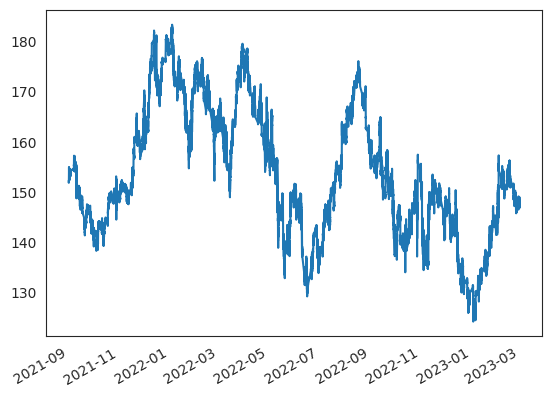

,open,high,low,close,volume,trade_count,vwap,ask,bid,ret,log_ret,sma_5,sma_pct_5,sma_9,sma_pct_9,sma_21,sma_pct_21,sma_50,sma_pct_50,sma_100,sma_pct_100,sma_200,sma_pct_200,ema_3,ema_5,ema_8,ema_9,ema_13,ema_21,ema_50,roc_5,roc_10,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,macd_line_6_13_5,macd_signal_6_13_5,macd_diff_6_13_5,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,atr_7,atr_pct_7,atr_14,atr_pct_14,atr_28,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_lband_20_2p0,bb_hband_20_2p0,bb_w_20_2p0,bb_lband_20_3p0,bb_hband_20_3p0,bb_w_20_3p0,bb_lband_50_2p0,bb_hband_50_2p0,bb_w_50_2p0,obv,vol_spike_7,vol_spike_14,vol_spike_28,rolling_max_close_200,rolling_min_close_200,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_h_20,donch_l_20,donch_w_20,donch_h_55,donch_l_55,donch_w_55,roll_vwap_20,roll_vwap_50,slope_close_20,slope_close_50,kc_mid_20_20_1.5,kc_l_20_20_1.5,kc_h_20_20_1.5,kc_w_20_20_1.5,kc_mid_20_20_2.0,kc_l_20_20_2.0,kc_h_20_20_2.0,kc_w_20_20_2.0,psar,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,0.002633,0.002630,151.956,0.002330,151.911111,0.002626,151.874286,0.002869,151.8499,0.003030,151.862701,0.002945,151.874676,0.002866,152.096413,152.018578,151.964327,151.953148,151.923549,151.894996,151.867887,0.002963,0.003095,0.003161,-0.03,-0.000197,0.06,0.11,0.001313,97.117392,92.108647,88.907688,0.072060,0.027698,0.044362,0.043925,0.012360,0.031565,0.093550,0.000614,0.053679,0.000352,0.031763,0.000209,84.467536,3.401602,28.421520,77.491111,7.239535,19.072892,69.968105,11.638923,14.391505,151.674268,152.077732,0.002657,151.573401,152.178599,0.003985,151.714905,151.984895,0.001778,1.529217e+10,0.613270,1.023843,1.224605,152.40,151.80,0.000591,0.003348,19082.0,125.599677,27680.000000,182.256001,0.000579,0.000339,0.948276,0.871648,0.948276,0.816092,466.666667,500.000000,85.708219,81.744827,0.262026,0.233686,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.889248,151.866828,0.007699,0.001677,151.897444,151.836322,151.958567,0.000805,151.897444,151.815948,151.978941,0.001073,151.820000,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,0.000000,0.000000,152.048,0.001723,151.961111,0.002296,151.896667,0.002721,151.8593,0.002968,151.866702,0.002919,151.876876,0.002852,152.203206,152.115719,152.041143,152.024518,151.978756,151.932724,151.885225,0.003029,0.003095,0.003095,0.00,0.000000,0.00,0.00,0.000000,97.117392,92.108647,88.907688,0.106679,0.054025,0.052654,0.071035,0.024095,0.046941,0.080186,0.000526,0.049844,0.000327,0.030628,0.000201,84.467536,3.401602,37.540956,77.491111,7.239535,23.632803,69.968105,11.638923,16.430226,151.624973,152.175027,0.003621,151.487459,152.312541,0.005432,151.672758,152.045842,0.002457,1.529217e+10,0.376288,0.576864,0.696184,152.40,151.80,0.000591,0.003348,17295.0,113.788242,26841.000000,176.705655,0.000579,0.000339,0.896552,0.911239,0.896552,0.892720,235.338654,336.051648,85.801987,86.061612,0.295809,0.278437,152.400000,151.82,0.003808,152.400,151.80,0.003939,151.905092,151.875656,0.013173,0.002735,151.936735,151.878669,151.994802,0.000764,151.936735,151.859314,152.014157,0.001019,151.820000,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,-0.000066,-0.000066,152.138,0.001065,152.011111,0.001900,151.919048,0.002508,151.8687,0.002840,151.870602,0.002827,151.879026,0.002772,152.251603,152.177146,152.098667,152.079614,152.024648,151.966113,151.901491,0.002963,0.002897,0.003096,0.00,0.000000,0.00,0.00,0.000000,94.266696,90.188784,87.281932,0.122091,0.076714,0.045377,0.090669,0.037410,0.053259,0.070159,0.000461,0.046998,0.000309,0.029892,0.000196,82.747626,5.368519,44.722948,76.313395,8.6

In [4]:
##############################
## INDICATORS STRATEGIES DF ##
##############################

df_inds = pd.read_csv(params.indunsc_csv, index_col=0, parse_dates=True) ############### 
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################

df = df_inds # SELECT THE CORRECT DATAFRAME
df.close.plot()
plt.show()
df

In [5]:
##### 95 ######
# {'reset_peak': (0, 0),
#  'rsi_min_thresh': (43, 47),
#  'rsi_max_thresh': (49, 51),
#  'adx_thresh': (54.182016788650685, 54.99579321134931),
#  'atr_mult': (16.694410274720497, 18.336149725279498),
#  'vwap_atr_mult': (-0.21776640620967802, 0.617386406209678),
#  'buy_factor': (0.7414908137030546, 0.8158391862969453),
#  'sell_factor': (0.03504106095237648, 0.05612893904762352),
#  'trailstop_pct': (18.313730235902057, 30.31062976409794),
#  'sign_thresh_pair': {'categorical': ['ema_3|ema_8']}}

##### 97 ######
# {'reset_peak': (0, 0),
#  'rsi_min_thresh': (27, 35),
#  'rsi_max_thresh': (50, 50),
#  'adx_thresh': (54.48213536933162, 54.65967463066837),
#  'atr_mult': (16.551936093816696, 18.439403906183305),
#  'vwap_atr_mult': (0.6030502094385315, 1.0297097905614685),
#  'buy_factor': (0.7726095987344072, 0.8673004012655928),
#  'sell_factor': (0.032442553605695895, 0.0424274463943041),
#  'trailstop_pct': (19.127797192673505, 32.404702807326494),
#  'sign_thresh_pair': {'categorical': ['ema_3|ema_8']}}

In [6]:
# Pre-compute per-day slices once
groups = df.groupby(df.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:
    reset_peak       = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh   = trial.suggest_int("rsi_min_thresh", 26, 38)
    rsi_max_thresh   = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 48), 52)
    adx_thresh       = trial.suggest_float("adx_thresh", 54.0, 55.0)
    atr_mult         = trial.suggest_float("atr_mult", 16.5, 18.5, log=True)
    vwap_atr_mult    = trial.suggest_float("vwap_atr_mult", 0, 1)
    buy_factor       = trial.suggest_float("buy_factor", 0.7, 0.85)
    sell_factor      = trial.suggest_float("sell_factor", 0.03, 0.05)
    trailstop_pct    = trial.suggest_float("trailstop_pct", 18.0, 32.0)
    sign_thresh_pair = trial.suggest_categorical("sign_thresh_pair",[ 
                                                    "ema_3|ema_8",
                                                    # "ema_5|ema_13",
                                                    # "ema_9|ema_21",
                                                    # "ema_21|ema_50",
                                                    # "roc_5|ema_21"
                                                    # "roc_5|0.0"
                                                    # "macd_line_12_26_9|0.0"
                                                    # "macd_diff_6_13_5|0.0"
                                                    # "rsi_14|50.0"
                                                    # "rsi_6|50.0"
                                                ])
    col_signal, sign_thresh = sign_thresh_pair.split("|")
    try: # convert numeric thresholds (only if numeric)
        sign_thresh = float(sign_thresh)
    except ValueError:
        pass
    
    print('-' * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    daily_pnls: List[float] = []
    daily_bh_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)

    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            col_signal      = col_signal,
            sign_thresh     = sign_thresh,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))

        # accumulate executed Action counts from df_sim
        trial_action_counts["Buy"] += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        daily_pnls.append(strats._parse_eq_value(stats['STRATEGY']))
        daily_bh_pnls.append(strats._parse_eq_value(stats['BUYNHOLD']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
            
            # sets partial set_user_attr (just to be available if trial pruned)
            trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
            
            trial.report(float(prun_val), report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = np.percentile(vals, prun_perc)
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # sets final set_user_attr
    trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
    
    mean_excess = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
    return float(mean_excess)


Baseline mean daily B&H: -9.5162


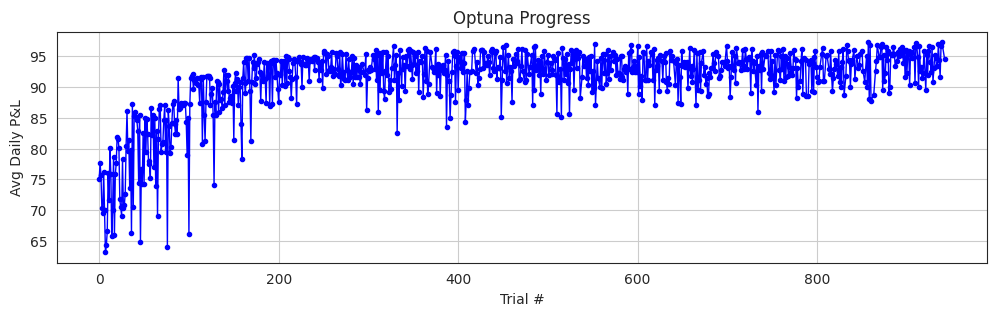

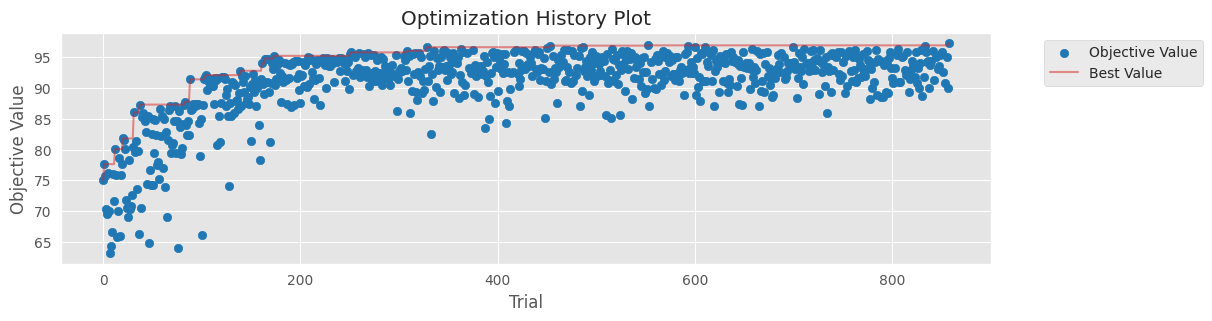

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=49; adx_thresh=54.75377670580634; atr_mult=16.859908296727102; vwap_atr_mult=0.855513044745853; buy_factor=0.7989641752344522; sell_factor=0.0355827973712903; trailstop_pct=29.832503081764695; sign_thresh_pair=ema_3|ema_8


Trial 0: 100%|██████████| 375/375 [03:42<00:00,  1.69it/s]


[Results] mean_pnl:66.2370 mean_bh:-8.7491 mean_excess:74.9861 improv_vs_bh:857.07%
Action counts: {'Buy': 808, 'Sell': 16787, 'Hold': 333116}
Best trial is: 0 with best_val: 74.9861
[save_results] wrote optuna_results/AAPL_74.9861_predicted.csv
[save_best_json] wrote optuna_results/AAPL_74.9861_predicted.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=52; adx_thresh=54.60820765268238; atr_mult=16.990601476745937; vwap_atr_mult=0.38202765148988216; buy_factor=0.8324751405604814; sell_factor=0.037710875604767685; trailstop_pct=27.717751236078954; sign_thresh_pair=ema_3|ema_8


Trial 1: 100%|██████████| 375/375 [03:06<00:00,  2.01it/s]


[Results] mean_pnl:68.8789 mean_bh:-8.7491 mean_excess:77.6280 improv_vs_bh:887.27%
Action counts: {'Buy': 821, 'Sell': 18033, 'Hold': 331857}
Best trial is: 1 with best_val: 77.6280
[save_results] wrote optuna_results/AAPL_77.628_predicted.csv
[save_best_json] wrote optuna_results/AAPL_77.628_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.06063633810805; atr_mult=18.12134746619185; vwap_atr_mult=0.7565783170449039; buy_factor=0.7773006492653292; sell_factor=0.03711677361599485; trailstop_pct=27.72601813326534; sign_thresh_pair=ema_3|ema_8


Trial 2: 100%|██████████| 375/375 [03:50<00:00,  1.63it/s]


[Results] mean_pnl:66.9190 mean_bh:-8.7491 mean_excess:75.6681 improv_vs_bh:864.87%
Action counts: {'Buy': 935, 'Sell': 17006, 'Hold': 332770}
Best trial is: 1 with best_val: 77.6280
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=52; adx_thresh=54.44512807993413; atr_mult=16.572880854251114; vwap_atr_mult=0.7798042740524875; buy_factor=0.7468217053467451; sell_factor=0.04822271037584383; trailstop_pct=31.054767207125227; sign_thresh_pair=ema_3|ema_8


Trial 3: 100%|██████████| 375/375 [03:24<00:00,  1.83it/s]


[Results] mean_pnl:61.5742 mean_bh:-8.7491 mean_excess:70.3233 improv_vs_bh:803.78%
Action counts: {'Buy': 975, 'Sell': 15771, 'Hold': 333965}
Best trial is: 1 with best_val: 77.6280
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=49; adx_thresh=54.030737487824446; atr_mult=17.504623317415316; vwap_atr_mult=0.7978463330804967; buy_factor=0.7639752933203496; sell_factor=0.0490342287670394; trailstop_pct=26.286156829544836; sign_thresh_pair=ema_3|ema_8


Trial 4: 100%|██████████| 375/375 [03:26<00:00,  1.81it/s]


[Results] mean_pnl:60.7116 mean_bh:-8.7491 mean_excess:69.4607 improv_vs_bh:793.92%
Action counts: {'Buy': 941, 'Sell': 14760, 'Hold': 335010}
Best trial is: 1 with best_val: 77.6280
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=51; adx_thresh=54.777567395117835; atr_mult=17.587852706875097; vwap_atr_mult=0.22130707892508872; buy_factor=0.8427904176889084; sell_factor=0.04617934686966514; trailstop_pct=29.2856263209367; sign_thresh_pair=ema_3|ema_8


Trial 5: 100%|██████████| 375/375 [03:20<00:00,  1.87it/s]


[Results] mean_pnl:67.4084 mean_bh:-8.7491 mean_excess:76.1575 improv_vs_bh:870.46%
Action counts: {'Buy': 800, 'Sell': 15674, 'Hold': 334237}
Best trial is: 1 with best_val: 77.6280
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=48; adx_thresh=54.541353280831274; atr_mult=17.289749616856277; vwap_atr_mult=0.4807693662063791; buy_factor=0.7098240256018746; sell_factor=0.04079383003868569; trailstop_pct=28.411001693573475; sign_thresh_pair=ema_3|ema_8


Trial 6: 100%|██████████| 375/375 [03:35<00:00,  1.74it/s]


[Results] mean_pnl:61.1972 mean_bh:-8.7491 mean_excess:69.9463 improv_vs_bh:799.47%
Action counts: {'Buy': 986, 'Sell': 15702, 'Hold': 334023}
Best trial is: 1 with best_val: 77.6280
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=48; adx_thresh=54.06047165343573; atr_mult=17.484248750519427; vwap_atr_mult=0.6041056279515041; buy_factor=0.7729673421180832; sell_factor=0.038344710249524905; trailstop_pct=23.968647574578675; sign_thresh_pair=ema_3|ema_8


Trial 7: 100%|██████████| 375/375 [03:35<00:00,  1.74it/s]


[Results] mean_pnl:54.4227 mean_bh:-8.7491 mean_excess:63.1718 improv_vs_bh:722.04%
Action counts: {'Buy': 930, 'Sell': 16686, 'Hold': 333095}
Best trial is: 1 with best_val: 77.6280
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=48; adx_thresh=54.84129906076643; atr_mult=17.055185188761605; vwap_atr_mult=0.9046220648311749; buy_factor=0.8444749902688766; sell_factor=0.0375795147444249; trailstop_pct=23.680157187960624; sign_thresh_pair=ema_3|ema_8


Trial 8: 100%|██████████| 375/375 [02:49<00:00,  2.22it/s]


[Results] mean_pnl:55.5833 mean_bh:-8.7491 mean_excess:64.3324 improv_vs_bh:735.30%
Action counts: {'Buy': 711, 'Sell': 15781, 'Hold': 334219}
Best trial is: 1 with best_val: 77.6280
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=52; adx_thresh=54.71746856746125; atr_mult=17.976430496871433; vwap_atr_mult=0.10954316159236066; buy_factor=0.7800404441464873; sell_factor=0.04972180797995435; trailstop_pct=19.56906659122393; sign_thresh_pair=ema_3|ema_8


Trial 9: 100%|██████████| 375/375 [03:40<00:00,  1.70it/s]


[Results] mean_pnl:57.7952 mean_bh:-8.7491 mean_excess:66.5443 improv_vs_bh:760.58%
Action counts: {'Buy': 960, 'Sell': 15103, 'Hold': 334648}
Best trial is: 1 with best_val: 77.6280
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.433784160643434; atr_mult=16.546055545787766; vwap_atr_mult=0.36495498782433666; buy_factor=0.8176166239434987; sell_factor=0.030795420675488676; trailstop_pct=20.83596585234585; sign_thresh_pair=ema_3|ema_8


Trial 10: 100%|██████████| 375/375 [03:22<00:00,  1.85it/s]


[Results] mean_pnl:67.2909 mean_bh:-8.7491 mean_excess:76.0400 improv_vs_bh:869.12%
Action counts: {'Buy': 840, 'Sell': 20171, 'Hold': 329700}
Best trial is: 1 with best_val: 77.6280
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=51; adx_thresh=54.98902159714374; atr_mult=17.77197796464737; vwap_atr_mult=0.17562057030788636; buy_factor=0.8487914131618283; sell_factor=0.04370629743123298; trailstop_pct=31.937128227868207; sign_thresh_pair=ema_3|ema_8


Trial 11: 100%|██████████| 375/375 [03:29<00:00,  1.79it/s]


[Results] mean_pnl:62.9286 mean_bh:-8.7491 mean_excess:71.6777 improv_vs_bh:819.26%
Action counts: {'Buy': 776, 'Sell': 16007, 'Hold': 333928}
Best trial is: 1 with best_val: 77.6280
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=51; adx_thresh=54.60399888570077; atr_mult=18.42460976457616; vwap_atr_mult=0.23144198854157572; buy_factor=0.8247160216655577; sell_factor=0.04402649577420804; trailstop_pct=26.271737105886046; sign_thresh_pair=ema_3|ema_8


Trial 12: 100%|██████████| 375/375 [02:40<00:00,  2.34it/s]


[Results] mean_pnl:71.2992 mean_bh:-8.7491 mean_excess:80.0483 improv_vs_bh:914.93%
Action counts: {'Buy': 817, 'Sell': 15792, 'Hold': 334102}
Best trial is: 12 with best_val: 80.0483
[save_results] wrote optuna_results/AAPL_80.0483_predicted.csv
[save_best_json] wrote optuna_results/AAPL_80.0483_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=52; adx_thresh=54.58182567809075; atr_mult=18.419829497930138; vwap_atr_mult=0.011326062738757137; buy_factor=0.8167631804150473; sell_factor=0.04144662257168875; trailstop_pct=26.03172410384576; sign_thresh_pair=ema_3|ema_8


Trial 13: 100%|██████████| 375/375 [01:16<00:00,  4.88it/s]


[Results] mean_pnl:67.0832 mean_bh:-8.7491 mean_excess:75.8323 improv_vs_bh:866.75%
Action counts: {'Buy': 844, 'Sell': 16730, 'Hold': 333137}
Best trial is: 12 with best_val: 80.0483
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=51; adx_thresh=54.26710313199771; atr_mult=17.083778453154245; vwap_atr_mult=0.3570816617491759; buy_factor=0.820564134709305; sell_factor=0.03438626160370222; trailstop_pct=22.47907288326141; sign_thresh_pair=ema_3|ema_8


Trial 14: 100%|██████████| 375/375 [00:54<00:00,  6.92it/s]


[Results] mean_pnl:57.0198 mean_bh:-8.7491 mean_excess:65.7689 improv_vs_bh:751.72%
Action counts: {'Buy': 846, 'Sell': 19051, 'Hold': 330814}
Best trial is: 12 with best_val: 80.0483
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.30263047423867; atr_mult=18.30792226711006; vwap_atr_mult=0.3213844944571215; buy_factor=0.8039688275861184; sell_factor=0.043663022310173195; trailstop_pct=26.610687500520253; sign_thresh_pair=ema_3|ema_8


Trial 15: 100%|██████████| 375/375 [00:44<00:00,  8.50it/s]


[Results] mean_pnl:61.2782 mean_bh:-8.7491 mean_excess:70.0273 improv_vs_bh:800.40%
Action counts: {'Buy': 836, 'Sell': 15689, 'Hold': 334186}
Best trial is: 12 with best_val: 80.0483
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=52; adx_thresh=54.60738666267445; atr_mult=16.802836404427516; vwap_atr_mult=0.5202598945777155; buy_factor=0.8300496339687585; sell_factor=0.03178074880471709; trailstop_pct=24.862488637110204; sign_thresh_pair=ema_3|ema_8


Trial 16: 100%|██████████| 375/375 [00:33<00:00, 11.27it/s]


[Results] mean_pnl:69.9115 mean_bh:-8.7491 mean_excess:78.6605 improv_vs_bh:899.07%
Action counts: {'Buy': 815, 'Sell': 19734, 'Hold': 330162}
Best trial is: 12 with best_val: 80.0483
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=51; adx_thresh=54.30005244125191; atr_mult=16.750695871962993; vwap_atr_mult=0.6083669857077675; buy_factor=0.7955204799835808; sell_factor=0.03027704089147977; trailstop_pct=21.957262638607617; sign_thresh_pair=ema_3|ema_8


Trial 17: 100%|██████████| 375/375 [00:28<00:00, 13.14it/s]


[Results] mean_pnl:57.1618 mean_bh:-8.7491 mean_excess:65.9109 improv_vs_bh:753.35%
Action counts: {'Buy': 893, 'Sell': 20308, 'Hold': 329510}
Best trial is: 12 with best_val: 80.0483
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.92510189998067; atr_mult=17.271463116751345; vwap_atr_mult=0.54505548282049; buy_factor=0.7335223317106742; sell_factor=0.033524870802648196; trailstop_pct=24.890828429415382; sign_thresh_pair=ema_3|ema_8


Trial 18: 100%|██████████| 375/375 [00:26<00:00, 13.92it/s]


[Results] mean_pnl:67.0669 mean_bh:-8.7491 mean_excess:75.8160 improv_vs_bh:866.56%
Action counts: {'Buy': 889, 'Sell': 17716, 'Hold': 332106}
Best trial is: 12 with best_val: 80.0483
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=52; adx_thresh=54.678405613081594; atr_mult=17.82598488850807; vwap_atr_mult=0.4793661895092909; buy_factor=0.8298345945023442; sell_factor=0.043008286541862055; trailstop_pct=24.725369281849243; sign_thresh_pair=ema_3|ema_8


Trial 19: 100%|██████████| 375/375 [00:26<00:00, 14.00it/s]


[Results] mean_pnl:68.8618 mean_bh:-8.7491 mean_excess:77.6109 improv_vs_bh:887.07%
Action counts: {'Buy': 800, 'Sell': 16349, 'Hold': 333562}
Best trial is: 12 with best_val: 80.0483
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.41517094275951; atr_mult=18.154140858791976; vwap_atr_mult=0.9917289519144048; buy_factor=0.8069065264049988; sell_factor=0.04628842794214285; trailstop_pct=18.32463104404588; sign_thresh_pair=ema_3|ema_8


Trial 20: 100%|██████████| 375/375 [00:24<00:00, 15.25it/s]


[Results] mean_pnl:73.0546 mean_bh:-8.7491 mean_excess:81.8037 improv_vs_bh:935.00%
Action counts: {'Buy': 780, 'Sell': 14624, 'Hold': 335307}
Best trial is: 20 with best_val: 81.8037
[save_results] wrote optuna_results/AAPL_81.8037_predicted.csv
[save_best_json] wrote optuna_results/AAPL_81.8037_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.40246681587624; atr_mult=18.20728004800338; vwap_atr_mult=0.9825982971053447; buy_factor=0.8086594421288945; sell_factor=0.04620221462504196; trailstop_pct=18.01649155334877; sign_thresh_pair=ema_3|ema_8


Trial 21: 100%|██████████| 375/375 [00:27<00:00, 13.81it/s]


[Results] mean_pnl:72.8740 mean_bh:-8.7491 mean_excess:81.6231 improv_vs_bh:932.93%
Action counts: {'Buy': 779, 'Sell': 14620, 'Hold': 335312}
Best trial is: 20 with best_val: 81.8037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.39455408373755; atr_mult=18.234446842007706; vwap_atr_mult=0.9944872897320244; buy_factor=0.7923346669940895; sell_factor=0.046263698873551876; trailstop_pct=18.280524964472836; sign_thresh_pair=ema_3|ema_8


Trial 22: 100%|██████████| 375/375 [00:24<00:00, 15.27it/s]


[Results] mean_pnl:71.3954 mean_bh:-8.7491 mean_excess:80.1445 improv_vs_bh:916.03%
Action counts: {'Buy': 874, 'Sell': 14592, 'Hold': 335245}
Best trial is: 20 with best_val: 81.8037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=54.38200687445813; atr_mult=18.134268426777517; vwap_atr_mult=0.9924661371311004; buy_factor=0.7927969758916348; sell_factor=0.04700377552367126; trailstop_pct=18.016593281611016; sign_thresh_pair=ema_3|ema_8


Trial 23: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:62.9800 mean_bh:-8.7491 mean_excess:71.7291 improv_vs_bh:819.85%
Action counts: {'Buy': 853, 'Sell': 14256, 'Hold': 335602}
Best trial is: 20 with best_val: 81.8037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.16774364027198; atr_mult=18.056250976300838; vwap_atr_mult=0.9889371490912667; buy_factor=0.8077021858582417; sell_factor=0.04551515397723244; trailstop_pct=18.14764248826846; sign_thresh_pair=ema_3|ema_8


Trial 24: 100%|██████████| 375/375 [00:24<00:00, 15.58it/s]


[Results] mean_pnl:61.7543 mean_bh:-8.7491 mean_excess:70.5034 improv_vs_bh:805.84%
Action counts: {'Buy': 797, 'Sell': 15133, 'Hold': 334781}
Best trial is: 20 with best_val: 81.8037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.20097603784853; atr_mult=18.310896456035625; vwap_atr_mult=0.9009056551686032; buy_factor=0.7897793076153027; sell_factor=0.045696946278047; trailstop_pct=19.677217993625025; sign_thresh_pair=ema_3|ema_8


Trial 25: 100%|██████████| 375/375 [00:23<00:00, 16.07it/s]


[Results] mean_pnl:60.3803 mean_bh:-8.7491 mean_excess:69.1294 improv_vs_bh:790.13%
Action counts: {'Buy': 907, 'Sell': 14905, 'Hold': 334899}
Best trial is: 20 with best_val: 81.8037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=54.47913414745654; atr_mult=17.835902657597522; vwap_atr_mult=0.7065869112624001; buy_factor=0.754646057284723; sell_factor=0.047464871109313925; trailstop_pct=19.738652895018802; sign_thresh_pair=ema_3|ema_8


Trial 26: 100%|██████████| 375/375 [00:24<00:00, 15.39it/s]


[Results] mean_pnl:69.5165 mean_bh:-8.7491 mean_excess:78.2656 improv_vs_bh:894.56%
Action counts: {'Buy': 902, 'Sell': 14419, 'Hold': 335390}
Best trial is: 20 with best_val: 81.8037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.365447211495294; atr_mult=18.25715276751269; vwap_atr_mult=0.9232891925202885; buy_factor=0.8073262233522156; sell_factor=0.04182948957129342; trailstop_pct=18.928500442475553; sign_thresh_pair=ema_3|ema_8


Trial 27: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:61.5509 mean_bh:-8.7491 mean_excess:70.3000 improv_vs_bh:803.51%
Action counts: {'Buy': 784, 'Sell': 15522, 'Hold': 334405}
Best trial is: 20 with best_val: 81.8037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.38469621393495; atr_mult=17.954668388685302; vwap_atr_mult=0.9981265440638422; buy_factor=0.7849676511823205; sell_factor=0.04525968370226307; trailstop_pct=21.000122142515995; sign_thresh_pair=ema_3|ema_8


Trial 28: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:62.0384 mean_bh:-8.7491 mean_excess:70.7875 improv_vs_bh:809.08%
Action counts: {'Buy': 879, 'Sell': 14628, 'Hold': 335204}
Best trial is: 20 with best_val: 81.8037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.17312891913183; atr_mult=18.463963931447694; vwap_atr_mult=0.853264574955829; buy_factor=0.7992124667638077; sell_factor=0.048145968185774456; trailstop_pct=20.916584144490045; sign_thresh_pair=ema_3|ema_8


Trial 29: 100%|██████████| 375/375 [00:22<00:00, 16.33it/s]


[Results] mean_pnl:63.9113 mean_bh:-8.7491 mean_excess:72.6604 improv_vs_bh:830.49%
Action counts: {'Buy': 873, 'Sell': 14590, 'Hold': 335248}
Best trial is: 20 with best_val: 81.8037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=54.50911004233785; atr_mult=17.687938377373623; vwap_atr_mult=0.7029317330674143; buy_factor=0.7642007736611479; sell_factor=0.04248859775250589; trailstop_pct=18.89893666508742; sign_thresh_pair=ema_3|ema_8


Trial 30: 100%|██████████| 375/375 [00:22<00:00, 16.42it/s]


[Results] mean_pnl:71.6332 mean_bh:-8.7491 mean_excess:80.3822 improv_vs_bh:918.75%
Action counts: {'Buy': 891, 'Sell': 15368, 'Hold': 334452}
Best trial is: 20 with best_val: 81.8037
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=54.51837799723212; atr_mult=17.685084198319085; vwap_atr_mult=0.6906648686987593; buy_factor=0.7660340123729925; sell_factor=0.03967948738763368; trailstop_pct=18.850627399975924; sign_thresh_pair=ema_3|ema_8


Trial 31: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:77.2750 mean_bh:-8.7491 mean_excess:86.0241 improv_vs_bh:983.23%
Action counts: {'Buy': 891, 'Sell': 16001, 'Hold': 333819}
Best trial is: 31 with best_val: 86.0241
[save_results] wrote optuna_results/AAPL_86.0241_predicted.csv
[save_best_json] wrote optuna_results/AAPL_86.0241_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.523139408552424; atr_mult=17.753658983453157; vwap_atr_mult=0.70660163690565; buy_factor=0.7637887941628186; sell_factor=0.03934000957582099; trailstop_pct=19.128557102888966; sign_thresh_pair=ema_3|ema_8


Trial 32: 100%|██████████| 375/375 [00:24<00:00, 15.46it/s]


[Results] mean_pnl:70.8948 mean_bh:-8.7491 mean_excess:79.6439 improv_vs_bh:910.31%
Action counts: {'Buy': 890, 'Sell': 16018, 'Hold': 333803}
Best trial is: 31 with best_val: 86.0241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=54.50335906588453; atr_mult=17.32108816435591; vwap_atr_mult=0.6663600108526315; buy_factor=0.7363106389197343; sell_factor=0.04010518150079022; trailstop_pct=20.35538817923574; sign_thresh_pair=ema_3|ema_8


Trial 33: 100%|██████████| 375/375 [00:26<00:00, 14.41it/s]


[Results] mean_pnl:72.6099 mean_bh:-8.7491 mean_excess:81.3590 improv_vs_bh:929.91%
Action counts: {'Buy': 917, 'Sell': 16048, 'Hold': 333746}
Best trial is: 31 with best_val: 86.0241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=48; adx_thresh=54.45976723312507; atr_mult=17.280181065510526; vwap_atr_mult=0.8202435522053376; buy_factor=0.7296903500444046; sell_factor=0.03995159459513651; trailstop_pct=21.93961386853707; sign_thresh_pair=ema_3|ema_8


Trial 34: 100%|██████████| 375/375 [00:24<00:00, 15.44it/s]


[Results] mean_pnl:64.8797 mean_bh:-8.7491 mean_excess:73.6288 improv_vs_bh:841.56%
Action counts: {'Buy': 913, 'Sell': 15525, 'Hold': 334273}
Best trial is: 31 with best_val: 86.0241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.66882472030847; atr_mult=17.408708893340116; vwap_atr_mult=0.7428353733423438; buy_factor=0.7418993964808417; sell_factor=0.035629032605664565; trailstop_pct=20.312194605266612; sign_thresh_pair=ema_3|ema_8


Trial 35: 100%|██████████| 375/375 [00:23<00:00, 15.99it/s]


[Results] mean_pnl:71.0778 mean_bh:-8.7491 mean_excess:79.8269 improv_vs_bh:912.40%
Action counts: {'Buy': 886, 'Sell': 16903, 'Hold': 332922}
Best trial is: 31 with best_val: 86.0241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=49; adx_thresh=54.331213588746785; atr_mult=17.626086681342755; vwap_atr_mult=0.8571250935590785; buy_factor=0.7266497611950626; sell_factor=0.03916225069225889; trailstop_pct=20.134523391068683; sign_thresh_pair=ema_3|ema_8


Trial 36: 100%|██████████| 375/375 [00:23<00:00, 15.76it/s]


[Results] mean_pnl:57.4790 mean_bh:-8.7491 mean_excess:66.2280 improv_vs_bh:756.97%
Action counts: {'Buy': 931, 'Sell': 16040, 'Hold': 333740}
Best trial is: 31 with best_val: 86.0241
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.54827914811063; atr_mult=17.927394955511694; vwap_atr_mult=0.6319355539891991; buy_factor=0.7118205887498955; sell_factor=0.03657214064530354; trailstop_pct=21.5894932922064; sign_thresh_pair=ema_3|ema_8


Trial 37: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:78.5410 mean_bh:-8.7491 mean_excess:87.2901 improv_vs_bh:997.70%
Action counts: {'Buy': 993, 'Sell': 16925, 'Hold': 332793}
Best trial is: 37 with best_val: 87.2901
[save_results] wrote optuna_results/AAPL_87.2901_predicted.csv
[save_best_json] wrote optuna_results/AAPL_87.2901_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.23625913903023; atr_mult=17.968424732205783; vwap_atr_mult=0.6516401151308089; buy_factor=0.7211477063957648; sell_factor=0.036161440806270685; trailstop_pct=22.93268722660498; sign_thresh_pair=ema_3|ema_8


Trial 38: 100%|██████████| 375/375 [00:27<00:00, 13.87it/s]


[Results] mean_pnl:61.7373 mean_bh:-8.7491 mean_excess:70.4864 improv_vs_bh:805.64%
Action counts: {'Buy': 973, 'Sell': 17330, 'Hold': 332408}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.57025936673984; atr_mult=18.125292134736124; vwap_atr_mult=0.4506462449990155; buy_factor=0.7058728074137199; sell_factor=0.036853136342905664; trailstop_pct=21.53997733017113; sign_thresh_pair=ema_3|ema_8


Trial 39: 100%|██████████| 375/375 [00:24<00:00, 15.53it/s]


[Results] mean_pnl:76.5580 mean_bh:-8.7491 mean_excess:85.3071 improv_vs_bh:975.04%
Action counts: {'Buy': 1012, 'Sell': 16828, 'Hold': 332871}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55487296820627; atr_mult=18.076515285561293; vwap_atr_mult=0.4471158937685035; buy_factor=0.7004035599464721; sell_factor=0.03675895643669528; trailstop_pct=21.618893057271286; sign_thresh_pair=ema_3|ema_8


Trial 40: 100%|██████████| 375/375 [00:22<00:00, 16.43it/s]


[Results] mean_pnl:77.1614 mean_bh:-8.7491 mean_excess:85.9105 improv_vs_bh:981.94%
Action counts: {'Buy': 1019, 'Sell': 16874, 'Hold': 332818}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55332532816408; atr_mult=18.084986633789185; vwap_atr_mult=0.43485822299547294; buy_factor=0.7030322699771496; sell_factor=0.03661007847230936; trailstop_pct=21.400754036166163; sign_thresh_pair=ema_3|ema_8


Trial 41: 100%|██████████| 375/375 [00:24<00:00, 15.23it/s]


[Results] mean_pnl:76.3894 mean_bh:-8.7491 mean_excess:85.1385 improv_vs_bh:973.11%
Action counts: {'Buy': 1018, 'Sell': 16906, 'Hold': 332787}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.563837655800484; atr_mult=18.051017932027513; vwap_atr_mult=0.4298983111664295; buy_factor=0.7034543082394382; sell_factor=0.036633924853902; trailstop_pct=21.442203830178997; sign_thresh_pair=ema_3|ema_8


Trial 42: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:75.8780 mean_bh:-8.7491 mean_excess:84.6271 improv_vs_bh:967.27%
Action counts: {'Buy': 1017, 'Sell': 16917, 'Hold': 332777}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.65605423843453; atr_mult=17.86123940822661; vwap_atr_mult=0.4173831089832253; buy_factor=0.7135967454582761; sell_factor=0.03454529469953613; trailstop_pct=22.985836890186246; sign_thresh_pair=ema_3|ema_8


Trial 43: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:74.0871 mean_bh:-8.7491 mean_excess:82.8362 improv_vs_bh:946.80%
Action counts: {'Buy': 984, 'Sell': 17508, 'Hold': 332219}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=51; adx_thresh=54.766000353411954; atr_mult=17.926484428994527; vwap_atr_mult=0.5989999831854999; buy_factor=0.700480447518066; sell_factor=0.038010882659158376; trailstop_pct=23.724064024901914; sign_thresh_pair=ema_3|ema_8


Trial 44: 100%|██████████| 375/375 [00:22<00:00, 16.40it/s]


[Results] mean_pnl:65.6762 mean_bh:-8.7491 mean_excess:74.4252 improv_vs_bh:850.66%
Action counts: {'Buy': 1005, 'Sell': 16940, 'Hold': 332766}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.63122454880881; atr_mult=18.03854871847412; vwap_atr_mult=0.2983781112013492; buy_factor=0.7140961321466881; sell_factor=0.03737019144528863; trailstop_pct=21.68892480505319; sign_thresh_pair=ema_3|ema_8


Trial 45: 100%|██████████| 375/375 [00:22<00:00, 16.64it/s]


[Results] mean_pnl:76.6520 mean_bh:-8.7491 mean_excess:85.4011 improv_vs_bh:976.11%
Action counts: {'Buy': 989, 'Sell': 16957, 'Hold': 332765}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=48; adx_thresh=54.72198851656287; atr_mult=17.57936859394783; vwap_atr_mult=0.2901907822482316; buy_factor=0.7142042946695439; sell_factor=0.03857787682349301; trailstop_pct=22.40247975502628; sign_thresh_pair=ema_3|ema_8


Trial 46: 100%|██████████| 375/375 [00:23<00:00, 15.68it/s]


[Results] mean_pnl:56.0784 mean_bh:-8.7491 mean_excess:64.8275 improv_vs_bh:740.96%
Action counts: {'Buy': 957, 'Sell': 16206, 'Hold': 333548}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=54.641333232833624; atr_mult=17.712523794775983; vwap_atr_mult=0.5601328908825505; buy_factor=0.7195867570908754; sell_factor=0.037278458881765446; trailstop_pct=23.5320215136366; sign_thresh_pair=ema_3|ema_8


Trial 47: 100%|██████████| 375/375 [00:23<00:00, 16.01it/s]


[Results] mean_pnl:67.9483 mean_bh:-8.7491 mean_excess:76.6974 improv_vs_bh:876.63%
Action counts: {'Buy': 953, 'Sell': 17363, 'Hold': 332395}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=51; adx_thresh=54.83443297529262; atr_mult=18.023353668619535; vwap_atr_mult=0.26267093597739777; buy_factor=0.7082494722240843; sell_factor=0.0332401969057978; trailstop_pct=24.250692358079544; sign_thresh_pair=ema_3|ema_8


Trial 48: 100%|██████████| 375/375 [00:23<00:00, 15.78it/s]


[Results] mean_pnl:65.5182 mean_bh:-8.7491 mean_excess:74.2673 improv_vs_bh:848.86%
Action counts: {'Buy': 991, 'Sell': 18226, 'Hold': 331494}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.62880399212497; atr_mult=17.90216912455626; vwap_atr_mult=0.14785095814359517; buy_factor=0.7195985355116176; sell_factor=0.03504552242782402; trailstop_pct=25.757721702876548; sign_thresh_pair=ema_3|ema_8


Trial 49: 100%|██████████| 375/375 [00:23<00:00, 16.20it/s]


[Results] mean_pnl:73.8292 mean_bh:-8.7491 mean_excess:82.5783 improv_vs_bh:943.85%
Action counts: {'Buy': 976, 'Sell': 17714, 'Hold': 332021}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.705346209140856; atr_mult=18.324812183311064; vwap_atr_mult=0.4881673249048774; buy_factor=0.7488869025864033; sell_factor=0.040639008766501714; trailstop_pct=29.946539318832215; sign_thresh_pair=ema_3|ema_8


Trial 50: 100%|██████████| 375/375 [00:22<00:00, 16.65it/s]


[Results] mean_pnl:65.4886 mean_bh:-8.7491 mean_excess:74.2377 improv_vs_bh:848.52%
Action counts: {'Buy': 909, 'Sell': 15789, 'Hold': 334013}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.563452790323744; atr_mult=18.10356006019962; vwap_atr_mult=0.4320698474202978; buy_factor=0.70680819713303; sell_factor=0.03652140443418644; trailstop_pct=21.538304452566933; sign_thresh_pair=ema_3|ema_8


Trial 51: 100%|██████████| 375/375 [00:23<00:00, 15.87it/s]


[Results] mean_pnl:76.2172 mean_bh:-8.7491 mean_excess:84.9663 improv_vs_bh:971.14%
Action counts: {'Buy': 1012, 'Sell': 16920, 'Hold': 332779}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=51; adx_thresh=54.54886687215229; atr_mult=18.13516355109905; vwap_atr_mult=0.3923473404567305; buy_factor=0.7005833441961672; sell_factor=0.03749804117641967; trailstop_pct=21.471611297333617; sign_thresh_pair=ema_3|ema_8


Trial 52: 100%|██████████| 375/375 [00:23<00:00, 15.86it/s]


[Results] mean_pnl:70.6850 mean_bh:-8.7491 mean_excess:79.4341 improv_vs_bh:907.91%
Action counts: {'Buy': 1043, 'Sell': 17186, 'Hold': 332482}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.59808575345044; atr_mult=18.011908473856405; vwap_atr_mult=0.3547797011697345; buy_factor=0.7154169287788676; sell_factor=0.03862795353883865; trailstop_pct=22.709900543875918; sign_thresh_pair=ema_3|ema_8


Trial 53: 100%|██████████| 375/375 [00:23<00:00, 15.95it/s]


[Results] mean_pnl:76.0985 mean_bh:-8.7491 mean_excess:84.8476 improv_vs_bh:969.79%
Action counts: {'Buy': 966, 'Sell': 16587, 'Hold': 333158}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.471593643751156; atr_mult=17.788278929709477; vwap_atr_mult=0.46236170941096866; buy_factor=0.7096848087926239; sell_factor=0.03556958701640453; trailstop_pct=22.17415923230976; sign_thresh_pair=ema_3|ema_8


Trial 54: 100%|██████████| 375/375 [00:23<00:00, 16.26it/s]


[Results] mean_pnl:73.6063 mean_bh:-8.7491 mean_excess:82.3554 improv_vs_bh:941.30%
Action counts: {'Buy': 1014, 'Sell': 17356, 'Hold': 332341}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=49; adx_thresh=54.528965242093584; atr_mult=17.645054809927046; vwap_atr_mult=0.5224494092603481; buy_factor=0.7222478431411095; sell_factor=0.033435165511286224; trailstop_pct=23.260620865506617; sign_thresh_pair=ema_3|ema_8


Trial 55: 100%|██████████| 375/375 [00:22<00:00, 16.89it/s]


[Results] mean_pnl:68.7622 mean_bh:-8.7491 mean_excess:77.5113 improv_vs_bh:885.94%
Action counts: {'Buy': 934, 'Sell': 17649, 'Hold': 332128}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.440990608882636; atr_mult=18.355658230680604; vwap_atr_mult=0.3278671423130571; buy_factor=0.7059569371255754; sell_factor=0.03688458817083418; trailstop_pct=20.817115691745315; sign_thresh_pair=ema_3|ema_8


Trial 56: 100%|██████████| 375/375 [00:23<00:00, 16.17it/s]


[Results] mean_pnl:69.2274 mean_bh:-8.7491 mean_excess:77.9765 improv_vs_bh:891.25%
Action counts: {'Buy': 1037, 'Sell': 16892, 'Hold': 332782}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=51; adx_thresh=54.79882911085841; atr_mult=17.531775105077006; vwap_atr_mult=0.5505181973326021; buy_factor=0.7264112129397703; sell_factor=0.03559537236042008; trailstop_pct=27.55680706525695; sign_thresh_pair=ema_3|ema_8


Trial 57: 100%|██████████| 375/375 [00:23<00:00, 16.07it/s]


[Results] mean_pnl:66.4511 mean_bh:-8.7491 mean_excess:75.2002 improv_vs_bh:859.52%
Action counts: {'Buy': 935, 'Sell': 17761, 'Hold': 332015}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.59395306869457; atr_mult=18.179659925050913; vwap_atr_mult=0.5948929489445459; buy_factor=0.7121330601425344; sell_factor=0.032417560581331224; trailstop_pct=21.62623108042854; sign_thresh_pair=ema_3|ema_8


Trial 58: 100%|██████████| 375/375 [00:22<00:00, 16.81it/s]


[Results] mean_pnl:77.8953 mean_bh:-8.7491 mean_excess:86.6443 improv_vs_bh:990.32%
Action counts: {'Buy': 977, 'Sell': 17932, 'Hold': 331802}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=54.59111190525987; atr_mult=18.159011100696247; vwap_atr_mult=0.5979354054409187; buy_factor=0.7343446011420697; sell_factor=0.03134244445845386; trailstop_pct=24.069232275684012; sign_thresh_pair=ema_3|ema_8


Trial 59: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:73.4033 mean_bh:-8.7491 mean_excess:82.1524 improv_vs_bh:938.98%
Action counts: {'Buy': 932, 'Sell': 18768, 'Hold': 331011}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.6325095194064; atr_mult=18.209924361634627; vwap_atr_mult=0.6633239541855851; buy_factor=0.7141324105897483; sell_factor=0.0322481446001379; trailstop_pct=21.885880746929814; sign_thresh_pair=ema_3|ema_8


Trial 60: 100%|██████████| 375/375 [00:22<00:00, 16.57it/s]


[Results] mean_pnl:76.6337 mean_bh:-8.7491 mean_excess:85.3828 improv_vs_bh:975.90%
Action counts: {'Buy': 958, 'Sell': 17863, 'Hold': 331890}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.69652461864537; atr_mult=18.24560164393863; vwap_atr_mult=0.6413748147730377; buy_factor=0.7124866660907984; sell_factor=0.032564058936617506; trailstop_pct=22.04405370280314; sign_thresh_pair=ema_3|ema_8


Trial 61: 100%|██████████| 375/375 [00:23<00:00, 16.07it/s]


[Results] mean_pnl:68.2669 mean_bh:-8.7491 mean_excess:77.0160 improv_vs_bh:880.27%
Action counts: {'Buy': 961, 'Sell': 17662, 'Hold': 332088}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.625424629546686; atr_mult=17.896688176471763; vwap_atr_mult=0.7491093518241237; buy_factor=0.7176309753627558; sell_factor=0.03242407981720196; trailstop_pct=20.50345238828725; sign_thresh_pair=ema_3|ema_8


Trial 62: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:76.1837 mean_bh:-8.7491 mean_excess:84.9328 improv_vs_bh:970.76%
Action counts: {'Buy': 929, 'Sell': 17742, 'Hold': 332040}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.74007149935199; atr_mult=18.209457387551236; vwap_atr_mult=0.6257372768185965; buy_factor=0.7097489105751654; sell_factor=0.03418396043742083; trailstop_pct=19.423627371886138; sign_thresh_pair=ema_3|ema_8


Trial 63: 100%|██████████| 375/375 [00:22<00:00, 16.65it/s]


[Results] mean_pnl:65.2039 mean_bh:-8.7491 mean_excess:73.9530 improv_vs_bh:845.26%
Action counts: {'Buy': 968, 'Sell': 17306, 'Hold': 332437}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.58744518526374; atr_mult=18.420388322746685; vwap_atr_mult=0.5806121999473044; buy_factor=0.7400953413927819; sell_factor=0.03797666608261783; trailstop_pct=21.062603356326555; sign_thresh_pair=ema_3|ema_8


Trial 64: 100%|██████████| 375/375 [00:22<00:00, 16.75it/s]


[Results] mean_pnl:74.1660 mean_bh:-8.7491 mean_excess:82.9151 improv_vs_bh:947.70%
Action counts: {'Buy': 921, 'Sell': 16453, 'Hold': 333337}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=48; adx_thresh=54.656129874354015; atr_mult=18.012991242648063; vwap_atr_mult=0.6728599814161287; buy_factor=0.7250440429639405; sell_factor=0.030952136939208397; trailstop_pct=19.95726302479334; sign_thresh_pair=ema_3|ema_8


Trial 65: 100%|██████████| 375/375 [00:23<00:00, 16.00it/s]


[Results] mean_pnl:60.2536 mean_bh:-8.7491 mean_excess:69.0026 improv_vs_bh:788.68%
Action counts: {'Buy': 894, 'Sell': 17720, 'Hold': 332097}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.48971538436145; atr_mult=18.353189821518527; vwap_atr_mult=0.506971259324521; buy_factor=0.7301833986962893; sell_factor=0.03222745799083067; trailstop_pct=21.883618568111217; sign_thresh_pair=ema_3|ema_8


Trial 66: 100%|██████████| 375/375 [00:23<00:00, 16.18it/s]


[Results] mean_pnl:72.8411 mean_bh:-8.7491 mean_excess:81.5902 improv_vs_bh:932.56%
Action counts: {'Buy': 939, 'Sell': 17927, 'Hold': 331845}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.61757834563953; atr_mult=18.177496427061154; vwap_atr_mult=0.7864518836095818; buy_factor=0.7118895689172527; sell_factor=0.030344992090620897; trailstop_pct=22.547989383490552; sign_thresh_pair=ema_3|ema_8


Trial 67: 100%|██████████| 375/375 [00:23<00:00, 15.73it/s]


[Results] mean_pnl:77.7405 mean_bh:-8.7491 mean_excess:86.4896 improv_vs_bh:988.56%
Action counts: {'Buy': 960, 'Sell': 18120, 'Hold': 331631}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=54.62766823764499; atr_mult=18.208035350573766; vwap_atr_mult=0.8086537813934285; buy_factor=0.7770369045151161; sell_factor=0.03174007873683812; trailstop_pct=24.473174425960174; sign_thresh_pair=ema_3|ema_8


Trial 68: 100%|██████████| 375/375 [00:22<00:00, 16.69it/s]


[Results] mean_pnl:78.3390 mean_bh:-8.7491 mean_excess:87.0881 improv_vs_bh:995.40%
Action counts: {'Buy': 850, 'Sell': 17417, 'Hold': 332444}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.68007149040021; atr_mult=17.84170222041748; vwap_atr_mult=0.7839241145138074; buy_factor=0.7730778593735101; sell_factor=0.030696942101686827; trailstop_pct=22.487391149866035; sign_thresh_pair=ema_3|ema_8


Trial 69: 100%|██████████| 375/375 [00:22<00:00, 16.34it/s]


[Results] mean_pnl:70.7127 mean_bh:-8.7491 mean_excess:79.4618 improv_vs_bh:908.23%
Action counts: {'Buy': 850, 'Sell': 17986, 'Hold': 331875}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.51686599775224; atr_mult=18.294516861706168; vwap_atr_mult=0.8449403199499528; buy_factor=0.780278963214441; sell_factor=0.030240241655744394; trailstop_pct=24.485388108684894; sign_thresh_pair=ema_3|ema_8


Trial 70: 100%|██████████| 375/375 [00:22<00:00, 16.39it/s]


[Results] mean_pnl:71.9681 mean_bh:-8.7491 mean_excess:80.7171 improv_vs_bh:922.58%
Action counts: {'Buy': 858, 'Sell': 17795, 'Hold': 332058}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=54.62121165375244; atr_mult=18.217217466792192; vwap_atr_mult=0.7197063315955092; buy_factor=0.7596588047703362; sell_factor=0.03274043984546554; trailstop_pct=25.286078197554794; sign_thresh_pair=ema_3|ema_8


Trial 71: 100%|██████████| 375/375 [00:22<00:00, 16.32it/s]


[Results] mean_pnl:72.2945 mean_bh:-8.7491 mean_excess:81.0436 improv_vs_bh:926.31%
Action counts: {'Buy': 874, 'Sell': 17410, 'Hold': 332427}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=49; adx_thresh=54.61383931955514; atr_mult=18.47946577434394; vwap_atr_mult=0.8019585380543535; buy_factor=0.7775040269971237; sell_factor=0.031995743514243564; trailstop_pct=23.420895100999505; sign_thresh_pair=ema_3|ema_8


Trial 72: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:75.8075 mean_bh:-8.7491 mean_excess:84.5566 improv_vs_bh:966.46%
Action counts: {'Buy': 852, 'Sell': 17230, 'Hold': 332629}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.54278008714476; atr_mult=18.177876743674815; vwap_atr_mult=0.030335282003465913; buy_factor=0.76801064952739; sell_factor=0.031579142365293626; trailstop_pct=26.85105435623352; sign_thresh_pair=ema_3|ema_8


Trial 73: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:78.2351 mean_bh:-8.7491 mean_excess:86.9842 improv_vs_bh:994.21%
Action counts: {'Buy': 942, 'Sell': 18705, 'Hold': 331064}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=49; adx_thresh=54.53624094058557; atr_mult=18.06770603798424; vwap_atr_mult=0.17245199954293877; buy_factor=0.770838053211742; sell_factor=0.03005003371961111; trailstop_pct=29.099957975250387; sign_thresh_pair=ema_3|ema_8


Trial 74: 100%|██████████| 375/375 [00:23<00:00, 15.86it/s]


[Results] mean_pnl:70.6978 mean_bh:-8.7491 mean_excess:79.4469 improv_vs_bh:908.06%
Action counts: {'Buy': 917, 'Sell': 18801, 'Hold': 330993}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.58158438763647; atr_mult=17.970014517385984; vwap_atr_mult=0.09481034482114013; buy_factor=0.7515449074988897; sell_factor=0.03152544906791302; trailstop_pct=26.346098523559608; sign_thresh_pair=ema_3|ema_8


Trial 75: 100%|██████████| 375/375 [00:23<00:00, 16.29it/s]


[Results] mean_pnl:75.9365 mean_bh:-8.7491 mean_excess:84.6856 improv_vs_bh:967.94%
Action counts: {'Buy': 943, 'Sell': 18675, 'Hold': 331093}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=48; adx_thresh=54.427937759539354; atr_mult=18.392659255770226; vwap_atr_mult=0.06974336705595549; buy_factor=0.7873750174230211; sell_factor=0.03294074671084226; trailstop_pct=27.51707254059304; sign_thresh_pair=ema_3|ema_8


Trial 76: 100%|██████████| 375/375 [00:24<00:00, 15.57it/s]


[Results] mean_pnl:55.2273 mean_bh:-8.7491 mean_excess:63.9764 improv_vs_bh:731.24%
Action counts: {'Buy': 912, 'Sell': 17635, 'Hold': 332164}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.49446864983938; atr_mult=18.166162261592522; vwap_atr_mult=0.04693399857395783; buy_factor=0.7828714176141064; sell_factor=0.03413017209679099; trailstop_pct=27.074440727688753; sign_thresh_pair=ema_3|ema_8


Trial 77: 100%|██████████| 375/375 [00:24<00:00, 15.14it/s]


[Results] mean_pnl:77.4616 mean_bh:-8.7491 mean_excess:86.2107 improv_vs_bh:985.37%
Action counts: {'Buy': 935, 'Sell': 18034, 'Hold': 331742}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.45766613772981; atr_mult=18.170290061231253; vwap_atr_mult=0.023125492591580577; buy_factor=0.7676614795526138; sell_factor=0.03408055248753778; trailstop_pct=26.687624370028836; sign_thresh_pair=ema_3|ema_8


Trial 78: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:74.8803 mean_bh:-8.7491 mean_excess:83.6294 improv_vs_bh:955.86%
Action counts: {'Buy': 958, 'Sell': 18064, 'Hold': 331689}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=49; adx_thresh=54.49178597655918; atr_mult=18.270635251917728; vwap_atr_mult=0.00593118211026545; buy_factor=0.7814273789202351; sell_factor=0.031082930831472726; trailstop_pct=26.983694201005466; sign_thresh_pair=ema_3|ema_8


Trial 79: 100%|██████████| 375/375 [00:23<00:00, 16.15it/s]


[Results] mean_pnl:70.5964 mean_bh:-8.7491 mean_excess:79.3455 improv_vs_bh:906.90%
Action counts: {'Buy': 923, 'Sell': 18525, 'Hold': 331263}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.35470177324187; atr_mult=17.44411200925529; vwap_atr_mult=0.04103831212143816; buy_factor=0.7983673404328383; sell_factor=0.030456648395579097; trailstop_pct=28.469271478797534; sign_thresh_pair=ema_3|ema_8


Trial 80: 100%|██████████| 375/375 [00:22<00:00, 16.50it/s]


[Results] mean_pnl:71.5207 mean_bh:-8.7491 mean_excess:80.2698 improv_vs_bh:917.46%
Action counts: {'Buy': 900, 'Sell': 19546, 'Hold': 330265}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.527052580115864; atr_mult=18.084187437500685; vwap_atr_mult=0.10887729378876604; buy_factor=0.7757588640712957; sell_factor=0.0336877880157279; trailstop_pct=28.321578370350316; sign_thresh_pair=ema_3|ema_8


Trial 81: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:75.4448 mean_bh:-8.7491 mean_excess:84.1939 improv_vs_bh:962.32%
Action counts: {'Buy': 936, 'Sell': 18041, 'Hold': 331734}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.495593981008696; atr_mult=18.16885112850764; vwap_atr_mult=0.7692379648655342; buy_factor=0.75577745122004; sell_factor=0.03164258873338258; trailstop_pct=27.02823866593992; sign_thresh_pair=ema_3|ema_8


Trial 82: 100%|██████████| 375/375 [00:24<00:00, 15.57it/s]


[Results] mean_pnl:78.4323 mean_bh:-8.7491 mean_excess:87.1814 improv_vs_bh:996.46%
Action counts: {'Buy': 901, 'Sell': 17837, 'Hold': 331973}
Best trial is: 37 with best_val: 87.2901
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.499615752534254; atr_mult=18.19670952999197; vwap_atr_mult=0.7685035329709382; buy_factor=0.761540686837045; sell_factor=0.03167626620484274; trailstop_pct=25.707920344341993; sign_thresh_pair=ema_3|ema_8


Trial 83: 100%|██████████| 375/375 [00:22<00:00, 16.75it/s]


[Results] mean_pnl:79.0063 mean_bh:-8.7491 mean_excess:87.7554 improv_vs_bh:1003.02%
Action counts: {'Buy': 902, 'Sell': 17819, 'Hold': 331990}
Best trial is: 83 with best_val: 87.7554
[save_results] wrote optuna_results/AAPL_87.7554_predicted.csv
[save_best_json] wrote optuna_results/AAPL_87.7554_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.49945804732409; atr_mult=16.6594854263488; vwap_atr_mult=0.8824313510664609; buy_factor=0.7570249620252008; sell_factor=0.03175808717327663; trailstop_pct=25.464376636941306; sign_thresh_pair=ema_3|ema_8


Trial 84: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:75.1904 mean_bh:-8.7491 mean_excess:83.9395 improv_vs_bh:959.41%
Action counts: {'Buy': 908, 'Sell': 18411, 'Hold': 331392}
Best trial is: 83 with best_val: 87.7554
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.41097312124095; atr_mult=18.1892190250258; vwap_atr_mult=0.7731022094384867; buy_factor=0.7612939721819875; sell_factor=0.031334078683105046; trailstop_pct=27.14929714886076; sign_thresh_pair=ema_3|ema_8


Trial 85: 100%|██████████| 375/375 [00:24<00:00, 15.40it/s]


[Results] mean_pnl:73.6574 mean_bh:-8.7491 mean_excess:82.4065 improv_vs_bh:941.89%
Action counts: {'Buy': 909, 'Sell': 18080, 'Hold': 331722}
Best trial is: 83 with best_val: 87.7554
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=51; adx_thresh=54.45975241918995; atr_mult=18.281496704109056; vwap_atr_mult=0.6868753134319423; buy_factor=0.7666235809845793; sell_factor=0.03479570601660707; trailstop_pct=25.926107422115553; sign_thresh_pair=ema_3|ema_8


Trial 86: 100%|██████████| 375/375 [00:23<00:00, 16.26it/s]


[Results] mean_pnl:75.9128 mean_bh:-8.7491 mean_excess:84.6619 improv_vs_bh:967.66%
Action counts: {'Buy': 920, 'Sell': 17668, 'Hold': 332123}
Best trial is: 83 with best_val: 87.7554
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.44105893532618; atr_mult=18.14016530106619; vwap_atr_mult=0.7317853577837341; buy_factor=0.7714651318285469; sell_factor=0.03318049842804538; trailstop_pct=28.20559494012866; sign_thresh_pair=ema_3|ema_8


Trial 87: 100%|██████████| 375/375 [00:23<00:00, 16.01it/s]


[Results] mean_pnl:73.6237 mean_bh:-8.7491 mean_excess:82.3728 improv_vs_bh:941.50%
Action counts: {'Buy': 907, 'Sell': 17727, 'Hold': 332077}
Best trial is: 83 with best_val: 87.7554
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.54334369017344; atr_mult=17.939927769838683; vwap_atr_mult=0.8049367556961111; buy_factor=0.7436915300526553; sell_factor=0.03382476663723834; trailstop_pct=26.455332305642045; sign_thresh_pair=ema_3|ema_8


Trial 88: 100%|██████████| 375/375 [00:22<00:00, 16.96it/s]


[Results] mean_pnl:82.6389 mean_bh:-8.7491 mean_excess:91.3880 improv_vs_bh:1044.54%
Action counts: {'Buy': 906, 'Sell': 17244, 'Hold': 332561}
Best trial is: 88 with best_val: 91.3880
[save_results] wrote optuna_results/AAPL_91.388_predicted.csv
[save_best_json] wrote optuna_results/AAPL_91.388_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.540302213999254; atr_mult=18.330972946832436; vwap_atr_mult=0.935641848732231; buy_factor=0.7439289005578844; sell_factor=0.0339029788749841; trailstop_pct=26.314954722786275; sign_thresh_pair=ema_3|ema_8


Trial 89: 100%|██████████| 375/375 [00:24<00:00, 15.42it/s]


[Results] mean_pnl:77.6885 mean_bh:-8.7491 mean_excess:86.4376 improv_vs_bh:987.96%
Action counts: {'Buy': 894, 'Sell': 16905, 'Hold': 332912}
Best trial is: 88 with best_val: 91.3880
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.547404273130894; atr_mult=18.356928589457635; vwap_atr_mult=0.9457363640520806; buy_factor=0.7434058453130635; sell_factor=0.03183800981317711; trailstop_pct=25.192320830117097; sign_thresh_pair=ema_3|ema_8


Trial 90: 100%|██████████| 375/375 [00:23<00:00, 15.63it/s]


[Results] mean_pnl:77.8759 mean_bh:-8.7491 mean_excess:86.6250 improv_vs_bh:990.10%
Action counts: {'Buy': 891, 'Sell': 17436, 'Hold': 332384}
Best trial is: 88 with best_val: 91.3880
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.55097949389818; atr_mult=18.370163455524228; vwap_atr_mult=0.956923608912659; buy_factor=0.7449287762423025; sell_factor=0.03171912628990264; trailstop_pct=25.248417327377744; sign_thresh_pair=ema_3|ema_8


Trial 91: 100%|██████████| 375/375 [00:23<00:00, 15.85it/s]


[Results] mean_pnl:78.5616 mean_bh:-8.7491 mean_excess:87.3107 improv_vs_bh:997.94%
Action counts: {'Buy': 890, 'Sell': 17460, 'Hold': 332361}
Best trial is: 88 with best_val: 91.3880
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.56752650500961; atr_mult=18.40232881415648; vwap_atr_mult=0.9551288171255107; buy_factor=0.7506020578854898; sell_factor=0.031800849320806394; trailstop_pct=25.126436719816116; sign_thresh_pair=ema_3|ema_8


Trial 92: 100%|██████████| 375/375 [00:23<00:00, 16.08it/s]


[Results] mean_pnl:78.4136 mean_bh:-8.7491 mean_excess:87.1627 improv_vs_bh:996.25%
Action counts: {'Buy': 880, 'Sell': 17429, 'Hold': 332402}
Best trial is: 88 with best_val: 91.3880
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.57662551718446; atr_mult=18.492251546799043; vwap_atr_mult=0.9533925293452934; buy_factor=0.752788922121049; sell_factor=0.031635371052344624; trailstop_pct=25.242869075367565; sign_thresh_pair=ema_3|ema_8


Trial 93: 100%|██████████| 375/375 [00:22<00:00, 16.80it/s]


[Results] mean_pnl:78.2443 mean_bh:-8.7491 mean_excess:86.9934 improv_vs_bh:994.31%
Action counts: {'Buy': 879, 'Sell': 17443, 'Hold': 332389}
Best trial is: 88 with best_val: 91.3880
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.57833375920287; atr_mult=18.456141785677296; vwap_atr_mult=0.9639854375295849; buy_factor=0.753802268883608; sell_factor=0.030837338957592473; trailstop_pct=25.664460709410307; sign_thresh_pair=ema_3|ema_8


Trial 94: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


[Results] mean_pnl:78.6563 mean_bh:-8.7491 mean_excess:87.4054 improv_vs_bh:999.02%
Action counts: {'Buy': 879, 'Sell': 17694, 'Hold': 332138}
Best trial is: 88 with best_val: 91.3880
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.57325762140088; atr_mult=18.486942843959874; vwap_atr_mult=0.9661027968378556; buy_factor=0.7534175227710043; sell_factor=0.030820109852672074; trailstop_pct=25.73498887256162; sign_thresh_pair=ema_3|ema_8


Trial 95: 100%|██████████| 375/375 [00:23<00:00, 16.29it/s]


[Results] mean_pnl:78.4705 mean_bh:-8.7491 mean_excess:87.2196 improv_vs_bh:996.90%
Action counts: {'Buy': 879, 'Sell': 17683, 'Hold': 332149}
Best trial is: 88 with best_val: 91.3880
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.571790351733995; atr_mult=18.496021150639397; vwap_atr_mult=0.959927361079024; buy_factor=0.7562893364523017; sell_factor=0.030848305257960125; trailstop_pct=25.688782903002615; sign_thresh_pair=ema_3|ema_8


Trial 96: 100%|██████████| 375/375 [00:22<00:00, 16.81it/s]


[Results] mean_pnl:78.6174 mean_bh:-8.7491 mean_excess:87.3665 improv_vs_bh:998.58%
Action counts: {'Buy': 879, 'Sell': 17672, 'Hold': 332160}
Best trial is: 88 with best_val: 91.3880
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.65114504336135; atr_mult=18.446427424338804; vwap_atr_mult=0.9676983260191071; buy_factor=0.7499100057246877; sell_factor=0.030723945539565693; trailstop_pct=25.6847141521602; sign_thresh_pair=ema_3|ema_8


Trial 97: 100%|██████████| 375/375 [00:23<00:00, 15.70it/s]


[Results] mean_pnl:75.5225 mean_bh:-8.7491 mean_excess:84.2716 improv_vs_bh:963.20%
Action counts: {'Buy': 877, 'Sell': 17707, 'Hold': 332127}
Best trial is: 88 with best_val: 91.3880
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=51; adx_thresh=54.47724095933745; atr_mult=18.40411716503555; vwap_atr_mult=0.914108122484139; buy_factor=0.7474014982920126; sell_factor=0.031061286113247454; trailstop_pct=24.739274171591322; sign_thresh_pair=ema_3|ema_8


Trial 98: 100%|██████████| 375/375 [00:22<00:00, 16.79it/s]


[Results] mean_pnl:70.2668 mean_bh:-8.7491 mean_excess:79.0159 improv_vs_bh:903.13%
Action counts: {'Buy': 913, 'Sell': 18336, 'Hold': 331462}
Best trial is: 88 with best_val: 91.3880
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.51630821526421; atr_mult=18.40116767150786; vwap_atr_mult=0.8714132395199542; buy_factor=0.7565909409772607; sell_factor=0.03072466035916097; trailstop_pct=25.989318595770737; sign_thresh_pair=ema_3|ema_8


Trial 99: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:76.2751 mean_bh:-8.7491 mean_excess:85.0242 improv_vs_bh:971.81%
Action counts: {'Buy': 887, 'Sell': 17864, 'Hold': 331960}
Best trial is: 88 with best_val: 91.3880
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.00538075609065; atr_mult=18.4603662804524; vwap_atr_mult=0.8974146042787545; buy_factor=0.7382655537109098; sell_factor=0.03293987672352949; trailstop_pct=24.412195464835005; sign_thresh_pair=ema_3|ema_8


Trial 100: 100%|██████████| 375/375 [00:22<00:00, 16.55it/s]


[Results] mean_pnl:57.3437 mean_bh:-8.7491 mean_excess:66.0928 improv_vs_bh:755.42%
Action counts: {'Buy': 950, 'Sell': 17856, 'Hold': 331905}
Best trial is: 88 with best_val: 91.3880
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.58062682088309; atr_mult=18.473239318877347; vwap_atr_mult=0.9589310320704862; buy_factor=0.7521966973510438; sell_factor=0.030004913688053022; trailstop_pct=26.5235346247245; sign_thresh_pair=ema_3|ema_8


Trial 101: 100%|██████████| 375/375 [00:21<00:00, 17.33it/s]


[Results] mean_pnl:78.3965 mean_bh:-8.7491 mean_excess:87.1456 improv_vs_bh:996.05%
Action counts: {'Buy': 878, 'Sell': 17918, 'Hold': 331915}
Best trial is: 88 with best_val: 91.3880
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.56482774882968; atr_mult=18.367186846736185; vwap_atr_mult=0.8201584383947259; buy_factor=0.7591898327760553; sell_factor=0.0300075016703296; trailstop_pct=25.57769797416887; sign_thresh_pair=ema_3|ema_8


Trial 102: 100%|██████████| 375/375 [00:24<00:00, 15.02it/s]


[Results] mean_pnl:82.7007 mean_bh:-8.7491 mean_excess:91.4498 improv_vs_bh:1045.25%
Action counts: {'Buy': 883, 'Sell': 18123, 'Hold': 331705}
Best trial is: 102 with best_val: 91.4498
[save_results] wrote optuna_results/AAPL_91.4498_predicted.csv
[save_best_json] wrote optuna_results/AAPL_91.4498_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.57164781925189; atr_mult=18.495600318650904; vwap_atr_mult=0.8344828116679506; buy_factor=0.7594662161713863; sell_factor=0.030130975946014802; trailstop_pct=25.013748647369457; sign_thresh_pair=ema_3|ema_8


Trial 103: 100%|██████████| 375/375 [00:21<00:00, 17.23it/s]


[Results] mean_pnl:82.9492 mean_bh:-8.7491 mean_excess:91.6983 improv_vs_bh:1048.09%
Action counts: {'Buy': 882, 'Sell': 18033, 'Hold': 331796}
Best trial is: 103 with best_val: 91.6983
[save_results] wrote optuna_results/AAPL_91.6983_predicted.csv
[save_best_json] wrote optuna_results/AAPL_91.6983_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.56197569678153; atr_mult=18.384487461095986; vwap_atr_mult=0.8382778170416815; buy_factor=0.7617799283774499; sell_factor=0.031217127545725382; trailstop_pct=24.96779173600041; sign_thresh_pair=ema_3|ema_8


Trial 104: 100%|██████████| 375/375 [00:25<00:00, 14.95it/s]


[Results] mean_pnl:83.3192 mean_bh:-8.7491 mean_excess:92.0683 improv_vs_bh:1052.32%
Action counts: {'Buy': 885, 'Sell': 17751, 'Hold': 332075}
Best trial is: 104 with best_val: 92.0683
[save_results] wrote optuna_results/AAPL_92.0683_predicted.csv
[save_best_json] wrote optuna_results/AAPL_92.0683_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.51439035375771; atr_mult=18.496633325059268; vwap_atr_mult=0.8307531342000798; buy_factor=0.7614716266731505; sell_factor=0.030573619863272124; trailstop_pct=25.5421096007125; sign_thresh_pair=ema_3|ema_8


Trial 105: 100%|██████████| 375/375 [00:24<00:00, 15.42it/s]


[Results] mean_pnl:80.8958 mean_bh:-8.7491 mean_excess:89.6449 improv_vs_bh:1024.62%
Action counts: {'Buy': 890, 'Sell': 17900, 'Hold': 331921}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.60206187368051; atr_mult=18.49694172926426; vwap_atr_mult=0.8308909697663684; buy_factor=0.7602872307959506; sell_factor=0.031144241066822797; trailstop_pct=25.57591163017394; sign_thresh_pair=ema_3|ema_8


Trial 106: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:82.3509 mean_bh:-8.7491 mean_excess:91.1000 improv_vs_bh:1041.25%
Action counts: {'Buy': 882, 'Sell': 17733, 'Hold': 332096}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.59728593621382; atr_mult=18.377907818123628; vwap_atr_mult=0.8318408572335761; buy_factor=0.7608346180660501; sell_factor=0.031153104796244058; trailstop_pct=25.52681506016238; sign_thresh_pair=ema_3|ema_8


Trial 107: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:82.6093 mean_bh:-8.7491 mean_excess:91.3584 improv_vs_bh:1044.20%
Action counts: {'Buy': 882, 'Sell': 17777, 'Hold': 332052}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.603082861500965; atr_mult=18.369540015984335; vwap_atr_mult=0.8346002742879728; buy_factor=0.7610531445775329; sell_factor=0.03131189321887024; trailstop_pct=24.816397943559828; sign_thresh_pair=ema_3|ema_8


Trial 108: 100%|██████████| 375/375 [00:22<00:00, 16.79it/s]


[Results] mean_pnl:81.9271 mean_bh:-8.7491 mean_excess:90.6762 improv_vs_bh:1036.41%
Action counts: {'Buy': 883, 'Sell': 17709, 'Hold': 332119}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.605796401093706; atr_mult=18.317914866638063; vwap_atr_mult=0.8283623494239659; buy_factor=0.7596594656302241; sell_factor=0.031216380337279255; trailstop_pct=25.5292959758319; sign_thresh_pair=ema_3|ema_8


Trial 109: 100%|██████████| 375/375 [00:22<00:00, 16.43it/s]


[Results] mean_pnl:82.6922 mean_bh:-8.7491 mean_excess:91.4413 improv_vs_bh:1045.15%
Action counts: {'Buy': 885, 'Sell': 17765, 'Hold': 332061}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.67059671659246; atr_mult=18.319284557986197; vwap_atr_mult=0.835660975772372; buy_factor=0.7626547296905651; sell_factor=0.03121425202499868; trailstop_pct=24.96010194493559; sign_thresh_pair=ema_3|ema_8


Trial 110: 100%|██████████| 375/375 [00:23<00:00, 15.85it/s]


[Results] mean_pnl:81.4896 mean_bh:-8.7491 mean_excess:90.2387 improv_vs_bh:1031.41%
Action counts: {'Buy': 873, 'Sell': 17766, 'Hold': 332072}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.670654898845676; atr_mult=18.312899381778553; vwap_atr_mult=0.828375744312174; buy_factor=0.7628852302181564; sell_factor=0.03113358585523881; trailstop_pct=24.88196094914626; sign_thresh_pair=ema_3|ema_8


Trial 111: 100%|██████████| 375/375 [00:23<00:00, 15.99it/s]


[Results] mean_pnl:81.4830 mean_bh:-8.7491 mean_excess:90.2321 improv_vs_bh:1031.33%
Action counts: {'Buy': 873, 'Sell': 17812, 'Hold': 332026}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.67839705295012; atr_mult=18.31221569825559; vwap_atr_mult=0.8368108462456884; buy_factor=0.7612526659599466; sell_factor=0.032130938765319694; trailstop_pct=23.879459353736284; sign_thresh_pair=ema_3|ema_8


Trial 112: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:78.6758 mean_bh:-8.7491 mean_excess:87.4249 improv_vs_bh:999.25%
Action counts: {'Buy': 877, 'Sell': 17517, 'Hold': 332317}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.60406391604698; atr_mult=18.26827235061681; vwap_atr_mult=0.8296349251521845; buy_factor=0.7636682288744657; sell_factor=0.030461916010260163; trailstop_pct=24.916224611518153; sign_thresh_pair=ema_3|ema_8


Trial 113: 100%|██████████| 375/375 [00:23<00:00, 16.13it/s]


[Results] mean_pnl:82.8958 mean_bh:-8.7491 mean_excess:91.6449 improv_vs_bh:1047.48%
Action counts: {'Buy': 877, 'Sell': 18021, 'Hold': 331813}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.60494170860154; atr_mult=18.43595982183965; vwap_atr_mult=0.8257349364747699; buy_factor=0.7633877308469699; sell_factor=0.030398390352741424; trailstop_pct=24.895072605868386; sign_thresh_pair=ema_3|ema_8


Trial 114: 100%|██████████| 375/375 [00:24<00:00, 15.46it/s]


[Results] mean_pnl:82.4529 mean_bh:-8.7491 mean_excess:91.2020 improv_vs_bh:1042.42%
Action counts: {'Buy': 877, 'Sell': 17953, 'Hold': 331881}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.72495938962446; atr_mult=18.25434014854103; vwap_atr_mult=0.861993150326021; buy_factor=0.7636320771364359; sell_factor=0.03123507555772998; trailstop_pct=24.992887416581326; sign_thresh_pair=ema_3|ema_8


Trial 115: 100%|██████████| 375/375 [00:22<00:00, 16.31it/s]


[Results] mean_pnl:72.0610 mean_bh:-8.7491 mean_excess:80.8101 improv_vs_bh:923.64%
Action counts: {'Buy': 866, 'Sell': 17640, 'Hold': 332205}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.605623909245175; atr_mult=18.430301032261543; vwap_atr_mult=0.8176708071290709; buy_factor=0.7705994168587568; sell_factor=0.031180609722076695; trailstop_pct=24.753972295744138; sign_thresh_pair=ema_3|ema_8


Trial 116: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


[Results] mean_pnl:82.7912 mean_bh:-8.7491 mean_excess:91.5403 improv_vs_bh:1046.28%
Action counts: {'Buy': 875, 'Sell': 17750, 'Hold': 332086}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.609588482743554; atr_mult=18.418453088939003; vwap_atr_mult=0.8870235967448774; buy_factor=0.7583917202298557; sell_factor=0.030381263472040183; trailstop_pct=24.2283524742847; sign_thresh_pair=ema_3|ema_8


Trial 117: 100%|██████████| 375/375 [00:22<00:00, 16.37it/s]


[Results] mean_pnl:76.7159 mean_bh:-8.7491 mean_excess:85.4650 improv_vs_bh:976.84%
Action counts: {'Buy': 876, 'Sell': 17904, 'Hold': 331931}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=54.69925843453039; atr_mult=18.373338684164178; vwap_atr_mult=0.8055642500712957; buy_factor=0.7689742818363661; sell_factor=0.03014961409628917; trailstop_pct=24.604891556501556; sign_thresh_pair=ema_3|ema_8


Trial 118: 100%|██████████| 375/375 [00:23<00:00, 16.22it/s]


[Results] mean_pnl:72.4506 mean_bh:-8.7491 mean_excess:81.1997 improv_vs_bh:928.09%
Action counts: {'Buy': 864, 'Sell': 17928, 'Hold': 331919}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.64875791648543; atr_mult=18.341180352965168; vwap_atr_mult=0.8511176374122866; buy_factor=0.7652711159592581; sell_factor=0.032557938394507255; trailstop_pct=26.153498033595003; sign_thresh_pair=ema_3|ema_8


Trial 119: 100%|██████████| 375/375 [00:22<00:00, 16.32it/s]


[Results] mean_pnl:78.7865 mean_bh:-8.7491 mean_excess:87.5356 improv_vs_bh:1000.51%
Action counts: {'Buy': 875, 'Sell': 17391, 'Hold': 332445}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.60165299765003; atr_mult=18.436680742137156; vwap_atr_mult=0.8217119302040066; buy_factor=0.7728189247010454; sell_factor=0.030074560563907192; trailstop_pct=24.84176061302056; sign_thresh_pair=ema_3|ema_8


Trial 120: 100%|██████████| 375/375 [00:22<00:00, 16.54it/s]


[Results] mean_pnl:83.0588 mean_bh:-8.7491 mean_excess:91.8079 improv_vs_bh:1049.34%
Action counts: {'Buy': 868, 'Sell': 18080, 'Hold': 331763}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.598705849255744; atr_mult=18.43461131394701; vwap_atr_mult=0.8190844680488998; buy_factor=0.7736927139035393; sell_factor=0.030422565837895436; trailstop_pct=24.830143168114397; sign_thresh_pair=ema_3|ema_8


Trial 121: 100%|██████████| 375/375 [00:23<00:00, 16.27it/s]


[Results] mean_pnl:83.0609 mean_bh:-8.7491 mean_excess:91.8099 improv_vs_bh:1049.37%
Action counts: {'Buy': 868, 'Sell': 17956, 'Hold': 331887}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.599485281656605; atr_mult=18.436003720005264; vwap_atr_mult=0.8173661403376884; buy_factor=0.7726082317843805; sell_factor=0.030003838288390566; trailstop_pct=24.03610574082105; sign_thresh_pair=ema_3|ema_8


Trial 122: 100%|██████████| 375/375 [00:24<00:00, 15.02it/s]


[Results] mean_pnl:82.9867 mean_bh:-8.7491 mean_excess:91.7358 improv_vs_bh:1048.52%
Action counts: {'Buy': 870, 'Sell': 18101, 'Hold': 331740}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.604341963479065; atr_mult=18.43781215469199; vwap_atr_mult=0.8092631325198661; buy_factor=0.7729783692292358; sell_factor=0.030427887906031563; trailstop_pct=25.377139588851584; sign_thresh_pair=ema_3|ema_8


Trial 123: 100%|██████████| 375/375 [00:28<00:00, 13.19it/s]


[Results] mean_pnl:82.6788 mean_bh:-8.7491 mean_excess:91.4279 improv_vs_bh:1045.00%
Action counts: {'Buy': 868, 'Sell': 17954, 'Hold': 331889}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.63221155247229; atr_mult=18.43653704579911; vwap_atr_mult=0.7943043545389902; buy_factor=0.7746703786195229; sell_factor=0.030410736167182158; trailstop_pct=24.082734372576176; sign_thresh_pair=ema_3|ema_8


Trial 124: 100%|██████████| 375/375 [00:23<00:00, 16.18it/s]


[Results] mean_pnl:78.2543 mean_bh:-8.7491 mean_excess:87.0034 improv_vs_bh:994.43%
Action counts: {'Buy': 866, 'Sell': 18045, 'Hold': 331800}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.60722899641594; atr_mult=17.103933197410523; vwap_atr_mult=0.7447252806728722; buy_factor=0.7707759355023832; sell_factor=0.03031898739318547; trailstop_pct=23.767117770097407; sign_thresh_pair=ema_3|ema_8


Trial 125: 100%|██████████| 375/375 [00:22<00:00, 16.49it/s]


[Results] mean_pnl:80.1179 mean_bh:-8.7491 mean_excess:88.8670 improv_vs_bh:1015.73%
Action counts: {'Buy': 891, 'Sell': 18843, 'Hold': 330977}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.64030915128137; atr_mult=18.43082737639027; vwap_atr_mult=0.8130760136348458; buy_factor=0.7780883262323771; sell_factor=0.030110052789499082; trailstop_pct=24.573483800216106; sign_thresh_pair=ema_3|ema_8


Trial 126: 100%|██████████| 375/375 [00:24<00:00, 15.31it/s]


[Results] mean_pnl:81.1310 mean_bh:-8.7491 mean_excess:89.8801 improv_vs_bh:1027.31%
Action counts: {'Buy': 863, 'Sell': 18069, 'Hold': 331779}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.65663440715596; atr_mult=18.263684660154492; vwap_atr_mult=0.8700464470753779; buy_factor=0.7735212458113189; sell_factor=0.03057198875245518; trailstop_pct=24.227897049555246; sign_thresh_pair=ema_3|ema_8


Trial 127: 100%|██████████| 375/375 [00:23<00:00, 15.83it/s]


[Results] mean_pnl:76.6423 mean_bh:-8.7491 mean_excess:85.3914 improv_vs_bh:976.00%
Action counts: {'Buy': 861, 'Sell': 17967, 'Hold': 331883}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.08329459360062; atr_mult=18.38578641633572; vwap_atr_mult=0.7879080167888287; buy_factor=0.7849742022131061; sell_factor=0.030062590433289793; trailstop_pct=25.29220985448608; sign_thresh_pair=ema_3|ema_8


Trial 128: 100%|██████████| 375/375 [00:22<00:00, 16.64it/s]


[Results] mean_pnl:65.3177 mean_bh:-8.7491 mean_excess:74.0668 improv_vs_bh:846.57%
Action counts: {'Buy': 911, 'Sell': 18802, 'Hold': 330998}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.59171471599484; atr_mult=18.42407510883723; vwap_atr_mult=0.7545755806977379; buy_factor=0.7695377414867167; sell_factor=0.03063986473535816; trailstop_pct=26.027132460015647; sign_thresh_pair=ema_3|ema_8


Trial 129: 100%|██████████| 375/375 [00:24<00:00, 15.32it/s]


[Results] mean_pnl:78.7198 mean_bh:-8.7491 mean_excess:87.4688 improv_vs_bh:999.75%
Action counts: {'Buy': 878, 'Sell': 18005, 'Hold': 331828}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=54.55770247378774; atr_mult=18.339626418692756; vwap_atr_mult=0.9127458072122059; buy_factor=0.7663939091483404; sell_factor=0.04994104543761719; trailstop_pct=23.335657650130944; sign_thresh_pair=ema_3|ema_8


Trial 130: 100%|██████████| 375/375 [00:22<00:00, 17.01it/s]


[Results] mean_pnl:76.7474 mean_bh:-8.7491 mean_excess:85.4965 improv_vs_bh:977.20%
Action counts: {'Buy': 887, 'Sell': 13722, 'Hold': 336102}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.605437696033; atr_mult=18.444579171644815; vwap_atr_mult=0.8149501526931963; buy_factor=0.7585503057631905; sell_factor=0.031087496976078554; trailstop_pct=25.413573317984376; sign_thresh_pair=ema_3|ema_8


Trial 131: 100%|██████████| 375/375 [00:24<00:00, 15.17it/s]


[Results] mean_pnl:82.1747 mean_bh:-8.7491 mean_excess:90.9238 improv_vs_bh:1039.24%
Action counts: {'Buy': 884, 'Sell': 17760, 'Hold': 332067}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.59158376660034; atr_mult=18.293426156108982; vwap_atr_mult=0.8499111373422307; buy_factor=0.7786127676449444; sell_factor=0.03049863610665104; trailstop_pct=24.975431297814158; sign_thresh_pair=ema_3|ema_8


Trial 132: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:82.0686 mean_bh:-8.7491 mean_excess:90.8177 improv_vs_bh:1038.02%
Action counts: {'Buy': 865, 'Sell': 18003, 'Hold': 331843}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=54.618121016781274; atr_mult=18.37899273919694; vwap_atr_mult=0.8841410662175786; buy_factor=0.7737698925180575; sell_factor=0.03216538865450805; trailstop_pct=24.653684450508894; sign_thresh_pair=ema_3|ema_8


Trial 133: 100%|██████████| 375/375 [00:21<00:00, 17.47it/s]


[Results] mean_pnl:77.1670 mean_bh:-8.7491 mean_excess:85.9160 improv_vs_bh:982.00%
Action counts: {'Buy': 866, 'Sell': 17444, 'Hold': 332401}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.53252999521184; atr_mult=18.45306940652639; vwap_atr_mult=0.8169088842212058; buy_factor=0.7656002273251328; sell_factor=0.03000685954525441; trailstop_pct=24.343654805893287; sign_thresh_pair=ema_3|ema_8


Trial 134: 100%|██████████| 375/375 [00:24<00:00, 15.58it/s]


[Results] mean_pnl:81.7746 mean_bh:-8.7491 mean_excess:90.5236 improv_vs_bh:1034.66%
Action counts: {'Buy': 883, 'Sell': 18092, 'Hold': 331736}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.561464236939564; atr_mult=18.49848869801826; vwap_atr_mult=0.7776218410384408; buy_factor=0.7692767061447229; sell_factor=0.03095682786340879; trailstop_pct=26.477418977707515; sign_thresh_pair=ema_3|ema_8


Trial 135: 100%|██████████| 375/375 [00:23<00:00, 16.30it/s]


[Results] mean_pnl:79.1911 mean_bh:-8.7491 mean_excess:87.9402 improv_vs_bh:1005.14%
Action counts: {'Buy': 880, 'Sell': 17874, 'Hold': 331957}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.63881650667548; atr_mult=18.41685854089073; vwap_atr_mult=0.8631597188306811; buy_factor=0.7719831351278305; sell_factor=0.031374566474481724; trailstop_pct=25.443397586576893; sign_thresh_pair=ema_3|ema_8


Trial 136: 100%|██████████| 375/375 [00:23<00:00, 15.82it/s]


[Results] mean_pnl:79.3057 mean_bh:-8.7491 mean_excess:88.0548 improv_vs_bh:1006.45%
Action counts: {'Buy': 868, 'Sell': 17669, 'Hold': 332174}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.60628550890023; atr_mult=18.282329841858346; vwap_atr_mult=0.7219093481119981; buy_factor=0.7668177322238662; sell_factor=0.03054532464746845; trailstop_pct=26.227730698140192; sign_thresh_pair=ema_3|ema_8


Trial 137: 100%|██████████| 375/375 [00:24<00:00, 15.27it/s]


[Results] mean_pnl:77.7487 mean_bh:-8.7491 mean_excess:86.4978 improv_vs_bh:988.65%
Action counts: {'Buy': 881, 'Sell': 18182, 'Hold': 331648}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.59188710206143; atr_mult=18.37419379373478; vwap_atr_mult=0.7944178319631022; buy_factor=0.7830974911342673; sell_factor=0.03207046839954326; trailstop_pct=25.933215962932646; sign_thresh_pair=ema_3|ema_8


Trial 138: 100%|██████████| 375/375 [00:23<00:00, 15.98it/s]


[Results] mean_pnl:80.4041 mean_bh:-8.7491 mean_excess:89.1532 improv_vs_bh:1019.00%
Action counts: {'Buy': 866, 'Sell': 17629, 'Hold': 332216}
Best trial is: 104 with best_val: 92.0683
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.56249476502969; atr_mult=18.237247934987845; vwap_atr_mult=0.8180241416693093; buy_factor=0.75899279707658; sell_factor=0.031002602364134383; trailstop_pct=25.034393890597226; sign_thresh_pair=ema_3|ema_8


Trial 139: 100%|██████████| 375/375 [00:24<00:00, 15.59it/s]


[Results] mean_pnl:84.0274 mean_bh:-8.7491 mean_excess:92.7765 improv_vs_bh:1060.41%
Action counts: {'Buy': 888, 'Sell': 17902, 'Hold': 331921}
Best trial is: 139 with best_val: 92.7765
[save_results] wrote optuna_results/AAPL_92.7765_predicted.csv
[save_best_json] wrote optuna_results/AAPL_92.7765_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.533943146624495; atr_mult=18.23029297271081; vwap_atr_mult=0.7644986265975088; buy_factor=0.7471391900585007; sell_factor=0.0307011245932789; trailstop_pct=23.97675290537349; sign_thresh_pair=ema_3|ema_8


Trial 140: 100%|██████████| 375/375 [00:22<00:00, 16.83it/s]


[Results] mean_pnl:78.2537 mean_bh:-8.7491 mean_excess:87.0028 improv_vs_bh:994.42%
Action counts: {'Buy': 902, 'Sell': 18076, 'Hold': 331733}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.56268146731216; atr_mult=18.336555494153256; vwap_atr_mult=0.8225287251299962; buy_factor=0.7592729114112101; sell_factor=0.03002123004116396; trailstop_pct=25.19369005309233; sign_thresh_pair=ema_3|ema_8


Trial 141: 100%|██████████| 375/375 [00:25<00:00, 14.68it/s]


[Results] mean_pnl:83.1654 mean_bh:-8.7491 mean_excess:91.9145 improv_vs_bh:1050.56%
Action counts: {'Buy': 883, 'Sell': 18141, 'Hold': 331687}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.559100690562595; atr_mult=18.33599810451981; vwap_atr_mult=0.8032585070608972; buy_factor=0.7642060401393791; sell_factor=0.03000079580886801; trailstop_pct=25.111869214238276; sign_thresh_pair=ema_3|ema_8


Trial 142: 100%|██████████| 375/375 [00:24<00:00, 15.45it/s]


[Results] mean_pnl:82.1574 mean_bh:-8.7491 mean_excess:90.9065 improv_vs_bh:1039.04%
Action counts: {'Buy': 881, 'Sell': 18147, 'Hold': 331683}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.621199042378166; atr_mult=18.30399341207601; vwap_atr_mult=0.8524308867447251; buy_factor=0.758145999210025; sell_factor=0.030373255701793538; trailstop_pct=24.715079989090363; sign_thresh_pair=ema_3|ema_8


Trial 143: 100%|██████████| 375/375 [00:22<00:00, 16.61it/s]


[Results] mean_pnl:80.5776 mean_bh:-8.7491 mean_excess:89.3267 improv_vs_bh:1020.98%
Action counts: {'Buy': 876, 'Sell': 18005, 'Hold': 331830}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.57249848597924; atr_mult=18.263394788348375; vwap_atr_mult=0.8179115554011163; buy_factor=0.755345642901349; sell_factor=0.03142548060442685; trailstop_pct=25.001969115864142; sign_thresh_pair=ema_3|ema_8


Trial 144: 100%|██████████| 375/375 [00:23<00:00, 15.89it/s]


[Results] mean_pnl:83.2586 mean_bh:-8.7491 mean_excess:92.0077 improv_vs_bh:1051.63%
Action counts: {'Buy': 887, 'Sell': 17736, 'Hold': 332088}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.573539305344184; atr_mult=18.266623411101634; vwap_atr_mult=0.8713702229702253; buy_factor=0.7551466150201278; sell_factor=0.031457255562315274; trailstop_pct=25.166204551231946; sign_thresh_pair=ema_3|ema_8


Trial 145: 100%|██████████| 375/375 [00:22<00:00, 16.94it/s]


[Results] mean_pnl:78.7990 mean_bh:-8.7491 mean_excess:87.5481 improv_vs_bh:1000.65%
Action counts: {'Buy': 883, 'Sell': 17692, 'Hold': 332136}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=54.531201752826426; atr_mult=18.234781912636482; vwap_atr_mult=0.7797182508430528; buy_factor=0.7760284118250071; sell_factor=0.030942878249650932; trailstop_pct=23.615124192355516; sign_thresh_pair=ema_3|ema_8


Trial 146: 100%|██████████| 375/375 [00:23<00:00, 15.87it/s]


[Results] mean_pnl:79.4068 mean_bh:-8.7491 mean_excess:88.1559 improv_vs_bh:1007.60%
Action counts: {'Buy': 879, 'Sell': 18027, 'Hold': 331805}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.551566828412106; atr_mult=18.389301383154283; vwap_atr_mult=0.8990190561430724; buy_factor=0.7688227297242102; sell_factor=0.03259153155054777; trailstop_pct=25.374125058911925; sign_thresh_pair=ema_3|ema_8


Trial 147: 100%|██████████| 375/375 [00:23<00:00, 15.63it/s]


[Results] mean_pnl:79.8046 mean_bh:-8.7491 mean_excess:88.5537 improv_vs_bh:1012.15%
Action counts: {'Buy': 878, 'Sell': 17252, 'Hold': 332581}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.58138283800192; atr_mult=18.346013106691085; vwap_atr_mult=0.7544687802596136; buy_factor=0.7587432733649828; sell_factor=0.0313996411332882; trailstop_pct=24.458259319936058; sign_thresh_pair=ema_3|ema_8


Trial 148: 100%|██████████| 375/375 [00:23<00:00, 16.20it/s]


[Results] mean_pnl:78.6923 mean_bh:-8.7491 mean_excess:87.4413 improv_vs_bh:999.43%
Action counts: {'Buy': 890, 'Sell': 17796, 'Hold': 332025}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.51954881257635; atr_mult=18.396278483411688; vwap_atr_mult=0.8081147295481348; buy_factor=0.7556255554365131; sell_factor=0.030902449045168368; trailstop_pct=24.67795002678887; sign_thresh_pair=ema_3|ema_8


Trial 149: 100%|██████████| 375/375 [00:24<00:00, 15.18it/s]


[Results] mean_pnl:81.4522 mean_bh:-8.7491 mean_excess:90.2013 improv_vs_bh:1030.98%
Action counts: {'Buy': 892, 'Sell': 17844, 'Hold': 331975}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=54.95054898294498; atr_mult=18.287763799330733; vwap_atr_mult=0.8505299615420567; buy_factor=0.7508852945894936; sell_factor=0.0300031653282572; trailstop_pct=25.953736818705508; sign_thresh_pair=ema_3|ema_8


Trial 150: 100%|██████████| 375/375 [00:22<00:00, 16.87it/s]


[Results] mean_pnl:72.5791 mean_bh:-8.7491 mean_excess:81.3282 improv_vs_bh:929.56%
Action counts: {'Buy': 843, 'Sell': 17671, 'Hold': 332197}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.6257691150609; atr_mult=18.4500960515433; vwap_atr_mult=0.8240548022103886; buy_factor=0.7637211761239279; sell_factor=0.030563947879186062; trailstop_pct=24.82577654282147; sign_thresh_pair=ema_3|ema_8


Trial 151: 100%|██████████| 375/375 [00:23<00:00, 15.95it/s]


[Results] mean_pnl:81.8746 mean_bh:-8.7491 mean_excess:90.6237 improv_vs_bh:1035.81%
Action counts: {'Buy': 875, 'Sell': 17906, 'Hold': 331930}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.586975427493634; atr_mult=18.37273135944968; vwap_atr_mult=0.8245665154286099; buy_factor=0.7725021270677421; sell_factor=0.03197368620222538; trailstop_pct=24.117324615937104; sign_thresh_pair=ema_3|ema_8


Trial 152: 100%|██████████| 375/375 [00:25<00:00, 14.90it/s]


[Results] mean_pnl:83.4436 mean_bh:-8.7491 mean_excess:92.1927 improv_vs_bh:1053.74%
Action counts: {'Buy': 878, 'Sell': 17568, 'Hold': 332265}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.56443839653469; atr_mult=18.342409495742988; vwap_atr_mult=0.7911975816894146; buy_factor=0.7721839152994592; sell_factor=0.0319589701439565; trailstop_pct=24.1906420488982; sign_thresh_pair=ema_3|ema_8


Trial 153: 100%|██████████| 375/375 [00:21<00:00, 17.15it/s]


[Results] mean_pnl:80.5314 mean_bh:-8.7491 mean_excess:89.2805 improv_vs_bh:1020.45%
Action counts: {'Buy': 879, 'Sell': 17668, 'Hold': 332164}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.58739260014629; atr_mult=18.24966277059153; vwap_atr_mult=0.8442322788784097; buy_factor=0.7754842928453659; sell_factor=0.03139327923061095; trailstop_pct=23.082544474641075; sign_thresh_pair=ema_3|ema_8


Trial 154: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:82.5612 mean_bh:-8.7491 mean_excess:91.3103 improv_vs_bh:1043.65%
Action counts: {'Buy': 867, 'Sell': 17765, 'Hold': 332079}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.546068148348006; atr_mult=18.409222426841552; vwap_atr_mult=0.8828266072146729; buy_factor=0.7678780779270622; sell_factor=0.03097908891717265; trailstop_pct=25.059404666981088; sign_thresh_pair=ema_3|ema_8


Trial 155: 100%|██████████| 375/375 [00:23<00:00, 16.00it/s]


[Results] mean_pnl:78.2950 mean_bh:-8.7491 mean_excess:87.0441 improv_vs_bh:994.89%
Action counts: {'Buy': 875, 'Sell': 17778, 'Hold': 332058}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.64676574603442; atr_mult=18.32762583254293; vwap_atr_mult=0.8188012479438634; buy_factor=0.7710485323052282; sell_factor=0.03213870468860953; trailstop_pct=31.92695135349655; sign_thresh_pair=ema_3|ema_8


Trial 156: 100%|██████████| 375/375 [00:22<00:00, 16.68it/s]


[Results] mean_pnl:81.3043 mean_bh:-8.7491 mean_excess:90.0534 improv_vs_bh:1029.29%
Action counts: {'Buy': 875, 'Sell': 17523, 'Hold': 332313}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.569936044787134; atr_mult=16.92314180937059; vwap_atr_mult=0.7969500581068274; buy_factor=0.7798109886615548; sell_factor=0.030837863300911632; trailstop_pct=23.823565973026987; sign_thresh_pair=ema_3|ema_8


Trial 157: 100%|██████████| 375/375 [00:24<00:00, 15.53it/s]


[Results] mean_pnl:81.9674 mean_bh:-8.7491 mean_excess:90.7165 improv_vs_bh:1036.87%
Action counts: {'Buy': 884, 'Sell': 18732, 'Hold': 331095}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.66017111119846; atr_mult=18.367896981929352; vwap_atr_mult=0.8700569426655305; buy_factor=0.7598870311289747; sell_factor=0.03166427399221733; trailstop_pct=25.48931081105934; sign_thresh_pair=ema_3|ema_8


Trial 158: 100%|██████████| 375/375 [00:22<00:00, 16.60it/s]


[Results] mean_pnl:75.2864 mean_bh:-8.7491 mean_excess:84.0355 improv_vs_bh:960.51%
Action counts: {'Buy': 875, 'Sell': 17592, 'Hold': 332244}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.68553881291309; atr_mult=18.452390089119557; vwap_atr_mult=0.7709845217150082; buy_factor=0.7665968768758252; sell_factor=0.048902175088972294; trailstop_pct=24.284475871217495; sign_thresh_pair=ema_3|ema_8


Trial 159: 100%|██████████| 375/375 [00:23<00:00, 15.70it/s]


[Results] mean_pnl:69.5502 mean_bh:-8.7491 mean_excess:78.2993 improv_vs_bh:894.94%
Action counts: {'Buy': 883, 'Sell': 14027, 'Hold': 335801}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.586179357636425; atr_mult=18.308683833878387; vwap_atr_mult=0.8369945892336235; buy_factor=0.754246362466345; sell_factor=0.03000332723855453; trailstop_pct=25.836065997185923; sign_thresh_pair=ema_3|ema_8


Trial 160: 100%|██████████| 375/375 [00:23<00:00, 15.76it/s]


[Results] mean_pnl:82.6199 mean_bh:-8.7491 mean_excess:91.3690 improv_vs_bh:1044.33%
Action counts: {'Buy': 883, 'Sell': 18143, 'Hold': 331685}
Best trial is: 139 with best_val: 92.7765
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.58990053401173; atr_mult=18.313688582028316; vwap_atr_mult=0.8418545770614798; buy_factor=0.8405379660195419; sell_factor=0.030362954436618184; trailstop_pct=25.801737576300553; sign_thresh_pair=ema_3|ema_8


Trial 161: 100%|██████████| 375/375 [00:22<00:00, 16.59it/s]


[Results] mean_pnl:85.2415 mean_bh:-8.7491 mean_excess:93.9906 improv_vs_bh:1074.29%
Action counts: {'Buy': 745, 'Sell': 18105, 'Hold': 331861}
Best trial is: 161 with best_val: 93.9906
[save_results] wrote optuna_results/AAPL_93.9906_predicted.csv
[save_best_json] wrote optuna_results/AAPL_93.9906_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.620436854137274; atr_mult=18.295736771099858; vwap_atr_mult=0.8403354248472318; buy_factor=0.7478917886078003; sell_factor=0.03000582770841791; trailstop_pct=26.669806557037777; sign_thresh_pair=ema_3|ema_8


Trial 162: 100%|██████████| 375/375 [00:22<00:00, 16.32it/s]


[Results] mean_pnl:81.9232 mean_bh:-8.7491 mean_excess:90.6723 improv_vs_bh:1036.36%
Action counts: {'Buy': 887, 'Sell': 18141, 'Hold': 331683}
Best trial is: 161 with best_val: 93.9906
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.545091982144555; atr_mult=18.2265255025915; vwap_atr_mult=0.9282386346443287; buy_factor=0.7554663520372256; sell_factor=0.030410908719863055; trailstop_pct=26.19387610903057; sign_thresh_pair=ema_3|ema_8


Trial 163: 100%|██████████| 375/375 [00:24<00:00, 15.19it/s]


[Results] mean_pnl:80.2200 mean_bh:-8.7491 mean_excess:88.9691 improv_vs_bh:1016.90%
Action counts: {'Buy': 881, 'Sell': 17900, 'Hold': 331930}
Best trial is: 161 with best_val: 93.9906
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.5857653618577; atr_mult=18.30824777939329; vwap_atr_mult=0.8078345010744635; buy_factor=0.844180377936093; sell_factor=0.0304718561509898; trailstop_pct=25.828581564084605; sign_thresh_pair=ema_3|ema_8


Trial 164: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:85.9744 mean_bh:-8.7491 mean_excess:94.7235 improv_vs_bh:1082.67%
Action counts: {'Buy': 747, 'Sell': 18082, 'Hold': 331882}
Best trial is: 164 with best_val: 94.7235
[save_results] wrote optuna_results/AAPL_94.7235_predicted.csv
[save_best_json] wrote optuna_results/AAPL_94.7235_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.57587066195518; atr_mult=18.416002622535828; vwap_atr_mult=0.8085457395812382; buy_factor=0.8361494821502096; sell_factor=0.030635859880993727; trailstop_pct=25.223383297215143; sign_thresh_pair=ema_3|ema_8


Trial 165: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:86.0014 mean_bh:-8.7491 mean_excess:94.7505 improv_vs_bh:1082.98%
Action counts: {'Buy': 748, 'Sell': 17987, 'Hold': 331976}
Best trial is: 165 with best_val: 94.7505
[save_results] wrote optuna_results/AAPL_94.7505_predicted.csv
[save_best_json] wrote optuna_results/AAPL_94.7505_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.63611795351034; atr_mult=17.214195044375813; vwap_atr_mult=0.7856887582247807; buy_factor=0.8407957780152877; sell_factor=0.030690816252656104; trailstop_pct=25.15759166855373; sign_thresh_pair=ema_3|ema_8


Trial 166: 100%|██████████| 375/375 [00:25<00:00, 14.79it/s]


[Results] mean_pnl:82.2762 mean_bh:-8.7491 mean_excess:91.0253 improv_vs_bh:1040.40%
Action counts: {'Buy': 756, 'Sell': 18683, 'Hold': 331272}
Best trial is: 165 with best_val: 94.7505
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.56828868515247; atr_mult=18.430003821052203; vwap_atr_mult=0.8154396903425811; buy_factor=0.8382208503179202; sell_factor=0.030428600142000828; trailstop_pct=24.514951063431045; sign_thresh_pair=ema_3|ema_8


Trial 167: 100%|██████████| 375/375 [00:23<00:00, 15.69it/s]


[Results] mean_pnl:85.9280 mean_bh:-8.7491 mean_excess:94.6770 improv_vs_bh:1082.14%
Action counts: {'Buy': 748, 'Sell': 18027, 'Hold': 331936}
Best trial is: 165 with best_val: 94.7505
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.5701478438804; atr_mult=18.355671925193015; vwap_atr_mult=0.7406991474886301; buy_factor=0.834719658206437; sell_factor=0.031240767064333326; trailstop_pct=24.478721002515698; sign_thresh_pair=ema_3|ema_8


Trial 168: 100%|██████████| 375/375 [00:23<00:00, 15.72it/s]


[Results] mean_pnl:80.5104 mean_bh:-8.7491 mean_excess:89.2595 improv_vs_bh:1020.21%
Action counts: {'Buy': 755, 'Sell': 18006, 'Hold': 331950}
Best trial is: 165 with best_val: 94.7505
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=52; adx_thresh=54.51857825925126; atr_mult=18.409881303797913; vwap_atr_mult=0.8621072718805164; buy_factor=0.8452932709116108; sell_factor=0.030763537629591272; trailstop_pct=24.93698225387243; sign_thresh_pair=ema_3|ema_8


Trial 169: 100%|██████████| 375/375 [00:23<00:00, 16.17it/s]


[Results] mean_pnl:72.4400 mean_bh:-8.7491 mean_excess:81.1891 improv_vs_bh:927.97%
Action counts: {'Buy': 780, 'Sell': 18883, 'Hold': 331048}
Best trial is: 165 with best_val: 94.7505
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.57899386676854; atr_mult=18.269536340413048; vwap_atr_mult=0.9012616857103074; buy_factor=0.8360809176567158; sell_factor=0.03042367932213378; trailstop_pct=23.97366587217049; sign_thresh_pair=ema_3|ema_8


Trial 170: 100%|██████████| 375/375 [00:22<00:00, 16.61it/s]


[Results] mean_pnl:82.1046 mean_bh:-8.7491 mean_excess:90.8536 improv_vs_bh:1038.44%
Action counts: {'Buy': 746, 'Sell': 17952, 'Hold': 332013}
Best trial is: 165 with best_val: 94.7505
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.607328398112124; atr_mult=18.457784180975715; vwap_atr_mult=0.8141432487010595; buy_factor=0.8385558016248168; sell_factor=0.030368868795107397; trailstop_pct=25.29929804725394; sign_thresh_pair=ema_3|ema_8


Trial 171: 100%|██████████| 375/375 [00:24<00:00, 15.30it/s]


[Results] mean_pnl:85.3127 mean_bh:-8.7491 mean_excess:94.0617 improv_vs_bh:1075.10%
Action counts: {'Buy': 746, 'Sell': 18037, 'Hold': 331928}
Best trial is: 165 with best_val: 94.7505
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.615700111451225; atr_mult=18.466766286803747; vwap_atr_mult=0.8063162859571664; buy_factor=0.8398514115561848; sell_factor=0.03088227014126977; trailstop_pct=24.7703139881546; sign_thresh_pair=ema_3|ema_8


Trial 172: 100%|██████████| 375/375 [00:24<00:00, 15.05it/s]


[Results] mean_pnl:84.3687 mean_bh:-8.7491 mean_excess:93.1178 improv_vs_bh:1064.31%
Action counts: {'Buy': 746, 'Sell': 17897, 'Hold': 332068}
Best trial is: 165 with best_val: 94.7505
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.557022298290875; atr_mult=18.49716000094898; vwap_atr_mult=0.8145350055359946; buy_factor=0.8497864202852666; sell_factor=0.030358813381519762; trailstop_pct=24.734331361503383; sign_thresh_pair=ema_3|ema_8


Trial 173: 100%|██████████| 375/375 [00:22<00:00, 16.44it/s]


[Results] mean_pnl:86.4514 mean_bh:-8.7491 mean_excess:95.2005 improv_vs_bh:1088.12%
Action counts: {'Buy': 750, 'Sell': 18042, 'Hold': 331919}
Best trial is: 173 with best_val: 95.2005
[save_results] wrote optuna_results/AAPL_95.2005_predicted.csv
[save_best_json] wrote optuna_results/AAPL_95.2005_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.616077260684236; atr_mult=18.49845179636865; vwap_atr_mult=0.7676790766569551; buy_factor=0.8499673817200124; sell_factor=0.030868415887698796; trailstop_pct=24.660234035815634; sign_thresh_pair=ema_3|ema_8


Trial 174: 100%|██████████| 375/375 [00:24<00:00, 15.17it/s]


[Results] mean_pnl:81.6766 mean_bh:-8.7491 mean_excess:90.4257 improv_vs_bh:1033.54%
Action counts: {'Buy': 747, 'Sell': 17996, 'Hold': 331968}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.59034481071916; atr_mult=18.457838170030467; vwap_atr_mult=0.7966416130673676; buy_factor=0.840689670561942; sell_factor=0.03040856513723459; trailstop_pct=24.477219968259025; sign_thresh_pair=ema_3|ema_8


Trial 175: 100%|██████████| 375/375 [00:24<00:00, 15.57it/s]


[Results] mean_pnl:82.6350 mean_bh:-8.7491 mean_excess:91.3841 improv_vs_bh:1044.50%
Action counts: {'Buy': 749, 'Sell': 18110, 'Hold': 331852}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.56026913729921; atr_mult=18.46785820205596; vwap_atr_mult=0.8565937546028541; buy_factor=0.8471042283067814; sell_factor=0.031522012704277555; trailstop_pct=24.874065365772783; sign_thresh_pair=ema_3|ema_8


Trial 176: 100%|██████████| 375/375 [00:23<00:00, 15.97it/s]


[Results] mean_pnl:85.0207 mean_bh:-8.7491 mean_excess:93.7698 improv_vs_bh:1071.77%
Action counts: {'Buy': 745, 'Sell': 17706, 'Hold': 332260}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.55435332921246; atr_mult=18.458728736708597; vwap_atr_mult=0.8594389763895932; buy_factor=0.8461333073464357; sell_factor=0.03153240640175063; trailstop_pct=24.949956631997665; sign_thresh_pair=ema_3|ema_8


Trial 177: 100%|██████████| 375/375 [00:24<00:00, 15.33it/s]


[Results] mean_pnl:85.2945 mean_bh:-8.7491 mean_excess:94.0436 improv_vs_bh:1074.90%
Action counts: {'Buy': 747, 'Sell': 17716, 'Hold': 332248}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.55236265409172; atr_mult=18.46641761273417; vwap_atr_mult=0.8541244660408085; buy_factor=0.8456919663420063; sell_factor=0.031646139993500404; trailstop_pct=24.128671390112988; sign_thresh_pair=ema_3|ema_8


Trial 178: 100%|██████████| 375/375 [00:23<00:00, 16.08it/s]


[Results] mean_pnl:85.7803 mean_bh:-8.7491 mean_excess:94.5293 improv_vs_bh:1080.45%
Action counts: {'Buy': 747, 'Sell': 17679, 'Hold': 332285}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.529505112911814; atr_mult=18.458952229952345; vwap_atr_mult=0.858507919813973; buy_factor=0.8468511615336679; sell_factor=0.0317646219983466; trailstop_pct=24.183519608644403; sign_thresh_pair=ema_3|ema_8


Trial 179: 100%|██████████| 375/375 [00:22<00:00, 16.64it/s]


[Results] mean_pnl:83.5913 mean_bh:-8.7491 mean_excess:92.3404 improv_vs_bh:1055.43%
Action counts: {'Buy': 751, 'Sell': 17642, 'Hold': 332318}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.504974561164666; atr_mult=18.467291877972087; vwap_atr_mult=0.8864298847423551; buy_factor=0.845798498665972; sell_factor=0.03185485005290953; trailstop_pct=23.66094015554876; sign_thresh_pair=ema_3|ema_8


Trial 180: 100%|██████████| 375/375 [00:23<00:00, 16.29it/s]


[Results] mean_pnl:78.9878 mean_bh:-8.7491 mean_excess:87.7369 improv_vs_bh:1002.81%
Action counts: {'Buy': 751, 'Sell': 17572, 'Hold': 332388}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.53552157166153; atr_mult=18.4105945439469; vwap_atr_mult=0.8503959912769411; buy_factor=0.8383629006252156; sell_factor=0.03153543267637661; trailstop_pct=24.282044417642684; sign_thresh_pair=ema_3|ema_8


Trial 181: 100%|██████████| 375/375 [00:24<00:00, 15.25it/s]


[Results] mean_pnl:83.2367 mean_bh:-8.7491 mean_excess:91.9858 improv_vs_bh:1051.38%
Action counts: {'Buy': 751, 'Sell': 17729, 'Hold': 332231}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.47616569436443; atr_mult=18.399311705485037; vwap_atr_mult=0.8664590605105863; buy_factor=0.8389864044470738; sell_factor=0.032435979384420666; trailstop_pct=24.363580129422687; sign_thresh_pair=ema_3|ema_8


Trial 182: 100%|██████████| 375/375 [00:24<00:00, 15.31it/s]


[Results] mean_pnl:82.2389 mean_bh:-8.7491 mean_excess:90.9880 improv_vs_bh:1039.97%
Action counts: {'Buy': 758, 'Sell': 17555, 'Hold': 332398}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.531309456386836; atr_mult=18.46175206200572; vwap_atr_mult=0.8532421006074027; buy_factor=0.8258391531882447; sell_factor=0.03163429416306126; trailstop_pct=24.106300903827446; sign_thresh_pair=ema_3|ema_8


Trial 183: 100%|██████████| 375/375 [00:22<00:00, 16.66it/s]


[Results] mean_pnl:82.5952 mean_bh:-8.7491 mean_excess:91.3443 improv_vs_bh:1044.04%
Action counts: {'Buy': 758, 'Sell': 17670, 'Hold': 332283}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.54842970715474; atr_mult=18.42159795356866; vwap_atr_mult=0.8523843697679022; buy_factor=0.8446437306284408; sell_factor=0.03307546587184113; trailstop_pct=24.658085592282305; sign_thresh_pair=ema_3|ema_8


Trial 184: 100%|██████████| 375/375 [00:23<00:00, 16.09it/s]


[Results] mean_pnl:85.2513 mean_bh:-8.7491 mean_excess:94.0004 improv_vs_bh:1074.40%
Action counts: {'Buy': 749, 'Sell': 17309, 'Hold': 332653}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.54534635393626; atr_mult=18.404821278989758; vwap_atr_mult=0.9092256991033698; buy_factor=0.8469041900614948; sell_factor=0.03305290364027679; trailstop_pct=24.524969341342178; sign_thresh_pair=ema_3|ema_8


Trial 185: 100%|██████████| 375/375 [00:21<00:00, 17.24it/s]


[Results] mean_pnl:82.4983 mean_bh:-8.7491 mean_excess:91.2474 improv_vs_bh:1042.94%
Action counts: {'Buy': 746, 'Sell': 17191, 'Hold': 332774}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.50757438914709; atr_mult=18.49582703854832; vwap_atr_mult=0.8796267987357281; buy_factor=0.8433849553573339; sell_factor=0.03224235442575542; trailstop_pct=25.126768600684496; sign_thresh_pair=ema_3|ema_8


Trial 186: 100%|██████████| 375/375 [00:25<00:00, 14.70it/s]


[Results] mean_pnl:78.6839 mean_bh:-8.7491 mean_excess:87.4330 improv_vs_bh:999.34%
Action counts: {'Buy': 751, 'Sell': 17431, 'Hold': 332529}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.55424874807134; atr_mult=18.384545924160445; vwap_atr_mult=0.8524370187483052; buy_factor=0.8367187905309226; sell_factor=0.031834279723221066; trailstop_pct=24.194547233358623; sign_thresh_pair=ema_3|ema_8


Trial 187: 100%|██████████| 375/375 [00:24<00:00, 15.52it/s]


[Results] mean_pnl:85.1373 mean_bh:-8.7491 mean_excess:93.8864 improv_vs_bh:1073.10%
Action counts: {'Buy': 752, 'Sell': 17655, 'Hold': 332304}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.52902329730921; atr_mult=18.360795800152765; vwap_atr_mult=0.8567596244979884; buy_factor=0.8376897882712575; sell_factor=0.03251874855884866; trailstop_pct=23.4948027644895; sign_thresh_pair=ema_3|ema_8


Trial 188: 100%|██████████| 375/375 [00:22<00:00, 16.41it/s]


[Results] mean_pnl:82.8492 mean_bh:-8.7491 mean_excess:91.5983 improv_vs_bh:1046.95%
Action counts: {'Buy': 753, 'Sell': 17474, 'Hold': 332484}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.55701664203338; atr_mult=18.392667367051956; vwap_atr_mult=0.8509337322987262; buy_factor=0.8304576282701255; sell_factor=0.03184480232603325; trailstop_pct=24.196130963760368; sign_thresh_pair=ema_3|ema_8


Trial 189: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:84.9562 mean_bh:-8.7491 mean_excess:93.7053 improv_vs_bh:1071.03%
Action counts: {'Buy': 755, 'Sell': 17646, 'Hold': 332310}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.48262364522802; atr_mult=18.394553202192988; vwap_atr_mult=0.8940533962311242; buy_factor=0.8318988832683502; sell_factor=0.03286061964689556; trailstop_pct=23.836441653345577; sign_thresh_pair=ema_3|ema_8


Trial 190: 100%|██████████| 375/375 [00:23<00:00, 16.10it/s]


[Results] mean_pnl:78.1921 mean_bh:-8.7491 mean_excess:86.9412 improv_vs_bh:993.72%
Action counts: {'Buy': 760, 'Sell': 17322, 'Hold': 332629}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.55546262145026; atr_mult=18.463474870184484; vwap_atr_mult=0.852239359692937; buy_factor=0.8416715091780629; sell_factor=0.03168898145376902; trailstop_pct=24.208762942827946; sign_thresh_pair=ema_3|ema_8


Trial 191: 100%|██████████| 375/375 [00:24<00:00, 15.36it/s]


[Results] mean_pnl:85.1654 mean_bh:-8.7491 mean_excess:93.9145 improv_vs_bh:1073.42%
Action counts: {'Buy': 748, 'Sell': 17661, 'Hold': 332302}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.55313197443812; atr_mult=18.467440192466523; vwap_atr_mult=0.8498908182760394; buy_factor=0.8410889171767388; sell_factor=0.03202970925132476; trailstop_pct=24.183685085121876; sign_thresh_pair=ema_3|ema_8


Trial 192: 100%|██████████| 375/375 [00:24<00:00, 15.58it/s]


[Results] mean_pnl:85.3947 mean_bh:-8.7491 mean_excess:94.1438 improv_vs_bh:1076.04%
Action counts: {'Buy': 748, 'Sell': 17572, 'Hold': 332391}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.511856072309435; atr_mult=18.47174736704546; vwap_atr_mult=0.8751990491212164; buy_factor=0.8423013033787928; sell_factor=0.03191331350399256; trailstop_pct=24.109784395564173; sign_thresh_pair=ema_3|ema_8


Trial 193: 100%|██████████| 375/375 [00:22<00:00, 16.54it/s]


[Results] mean_pnl:78.5028 mean_bh:-8.7491 mean_excess:87.2519 improv_vs_bh:997.27%
Action counts: {'Buy': 750, 'Sell': 17551, 'Hold': 332410}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.553034031809; atr_mult=18.466550100460253; vwap_atr_mult=0.8506105045580408; buy_factor=0.8482982818333714; sell_factor=0.0320575291030454; trailstop_pct=23.930902034204237; sign_thresh_pair=ema_3|ema_8


Trial 194: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:85.6420 mean_bh:-8.7491 mean_excess:94.3911 improv_vs_bh:1078.87%
Action counts: {'Buy': 747, 'Sell': 17572, 'Hold': 332392}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.55208538791093; atr_mult=18.49769159032984; vwap_atr_mult=0.8493612406779563; buy_factor=0.8472106169627986; sell_factor=0.03221405896868005; trailstop_pct=23.261384656787815; sign_thresh_pair=ema_3|ema_8


Trial 195: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:85.6928 mean_bh:-8.7491 mean_excess:94.4419 improv_vs_bh:1079.45%
Action counts: {'Buy': 747, 'Sell': 17494, 'Hold': 332470}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.55178582490061; atr_mult=18.497764416921402; vwap_atr_mult=0.9133784434208321; buy_factor=0.8486433545283234; sell_factor=0.03225463303779216; trailstop_pct=22.972071465623827; sign_thresh_pair=ema_3|ema_8


Trial 196: 100%|██████████| 375/375 [00:23<00:00, 16.09it/s]


[Results] mean_pnl:82.7762 mean_bh:-8.7491 mean_excess:91.5252 improv_vs_bh:1046.11%
Action counts: {'Buy': 744, 'Sell': 17324, 'Hold': 332643}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.545532096346506; atr_mult=18.45941386600371; vwap_atr_mult=0.8550137271079333; buy_factor=0.8444125911136175; sell_factor=0.032754828195216426; trailstop_pct=23.28311016920581; sign_thresh_pair=ema_3|ema_8


Trial 197: 100%|██████████| 375/375 [00:24<00:00, 15.55it/s]


[Results] mean_pnl:85.6106 mean_bh:-8.7491 mean_excess:94.3597 improv_vs_bh:1078.51%
Action counts: {'Buy': 749, 'Sell': 17367, 'Hold': 332595}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.5245057278815; atr_mult=18.455084631790655; vwap_atr_mult=0.8618372966765991; buy_factor=0.8435231231860629; sell_factor=0.03305209668816402; trailstop_pct=23.291612452371066; sign_thresh_pair=ema_3|ema_8


Trial 198: 100%|██████████| 375/375 [00:22<00:00, 16.56it/s]


[Results] mean_pnl:83.5100 mean_bh:-8.7491 mean_excess:92.2591 improv_vs_bh:1054.50%
Action counts: {'Buy': 751, 'Sell': 17306, 'Hold': 332654}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.55097708571543; atr_mult=18.46669114536866; vwap_atr_mult=0.8753891981290518; buy_factor=0.8342257533482637; sell_factor=0.033312309797600234; trailstop_pct=23.611380793913273; sign_thresh_pair=ema_3|ema_8


Trial 199: 100%|██████████| 375/375 [00:23<00:00, 15.69it/s]


[Results] mean_pnl:80.9323 mean_bh:-8.7491 mean_excess:89.6814 improv_vs_bh:1025.04%
Action counts: {'Buy': 750, 'Sell': 17160, 'Hold': 332801}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.49797926758366; atr_mult=18.431131595349857; vwap_atr_mult=0.8923326482210553; buy_factor=0.8477071216065081; sell_factor=0.0326993907229809; trailstop_pct=23.397019902821974; sign_thresh_pair=ema_3|ema_8


Trial 200: 100%|██████████| 375/375 [00:24<00:00, 15.53it/s]


[Results] mean_pnl:78.7820 mean_bh:-8.7491 mean_excess:87.5311 improv_vs_bh:1000.46%
Action counts: {'Buy': 752, 'Sell': 17365, 'Hold': 332594}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.52828441074322; atr_mult=18.498086204309573; vwap_atr_mult=0.8550950648910022; buy_factor=0.8445501689623938; sell_factor=0.033497120022019516; trailstop_pct=23.317440677039148; sign_thresh_pair=ema_3|ema_8


Trial 201: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:83.1499 mean_bh:-8.7491 mean_excess:91.8990 improv_vs_bh:1050.38%
Action counts: {'Buy': 751, 'Sell': 17164, 'Hold': 332796}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.51743782696942; atr_mult=18.44932461234641; vwap_atr_mult=0.8483691342652406; buy_factor=0.8425311258426657; sell_factor=0.03277508319367472; trailstop_pct=23.104962621335375; sign_thresh_pair=ema_3|ema_8


Trial 202: 100%|██████████| 375/375 [00:24<00:00, 15.27it/s]


[Results] mean_pnl:83.4239 mean_bh:-8.7491 mean_excess:92.1730 improv_vs_bh:1053.52%
Action counts: {'Buy': 751, 'Sell': 17364, 'Hold': 332596}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.55247201246762; atr_mult=18.45819223278038; vwap_atr_mult=0.8637230961926982; buy_factor=0.8400445798827304; sell_factor=0.03240736776097551; trailstop_pct=23.822155978685366; sign_thresh_pair=ema_3|ema_8


Trial 203: 100%|██████████| 375/375 [00:23<00:00, 15.90it/s]


[Results] mean_pnl:85.4876 mean_bh:-8.7491 mean_excess:94.2367 improv_vs_bh:1077.10%
Action counts: {'Buy': 747, 'Sell': 17441, 'Hold': 332523}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.56469586414593; atr_mult=18.465597011423025; vwap_atr_mult=0.8730610012752863; buy_factor=0.8397693679972305; sell_factor=0.03234464862953882; trailstop_pct=22.641188773051596; sign_thresh_pair=ema_3|ema_8


Trial 204: 100%|██████████| 375/375 [00:23<00:00, 16.08it/s]


[Results] mean_pnl:81.5247 mean_bh:-8.7491 mean_excess:90.2737 improv_vs_bh:1031.81%
Action counts: {'Buy': 745, 'Sell': 17420, 'Hold': 332546}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.551175455726614; atr_mult=18.49917859058816; vwap_atr_mult=0.8492285938028032; buy_factor=0.8287122186865281; sell_factor=0.03194287393343652; trailstop_pct=23.775552122231634; sign_thresh_pair=ema_3|ema_8


Trial 205: 100%|██████████| 375/375 [00:23<00:00, 16.30it/s]


[Results] mean_pnl:84.9454 mean_bh:-8.7491 mean_excess:93.6945 improv_vs_bh:1070.91%
Action counts: {'Buy': 755, 'Sell': 17574, 'Hold': 332382}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.54858651356376; atr_mult=18.415235656026116; vwap_atr_mult=0.8416049677918434; buy_factor=0.8280900948454415; sell_factor=0.03202926625134161; trailstop_pct=23.888877801599314; sign_thresh_pair=ema_3|ema_8


Trial 206: 100%|██████████| 375/375 [00:23<00:00, 15.85it/s]


[Results] mean_pnl:85.4936 mean_bh:-8.7491 mean_excess:94.2427 improv_vs_bh:1077.17%
Action counts: {'Buy': 757, 'Sell': 17586, 'Hold': 332368}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.558019663804565; atr_mult=18.496182276187923; vwap_atr_mult=0.926260324067868; buy_factor=0.8300870983747355; sell_factor=0.03204883798575534; trailstop_pct=23.867453851704646; sign_thresh_pair=ema_3|ema_8


Trial 207: 100%|██████████| 375/375 [00:24<00:00, 15.59it/s]


[Results] mean_pnl:81.4731 mean_bh:-8.7491 mean_excess:90.2222 improv_vs_bh:1031.22%
Action counts: {'Buy': 750, 'Sell': 17406, 'Hold': 332555}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.543279085881586; atr_mult=18.414539216541513; vwap_atr_mult=0.8406680943091951; buy_factor=0.8261347855463999; sell_factor=0.03252875557252189; trailstop_pct=23.755977322867594; sign_thresh_pair=ema_3|ema_8


Trial 208: 100%|██████████| 375/375 [00:23<00:00, 16.27it/s]


[Results] mean_pnl:86.2851 mean_bh:-8.7491 mean_excess:95.0342 improv_vs_bh:1086.22%
Action counts: {'Buy': 758, 'Sell': 17436, 'Hold': 332517}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.54519914406871; atr_mult=18.415517088650372; vwap_atr_mult=0.8957620838251703; buy_factor=0.8265740062303621; sell_factor=0.032617845760700565; trailstop_pct=23.642136800858626; sign_thresh_pair=ema_3|ema_8


Trial 209: 100%|██████████| 375/375 [00:22<00:00, 16.36it/s]


[Results] mean_pnl:81.8923 mean_bh:-8.7491 mean_excess:90.6414 improv_vs_bh:1036.01%
Action counts: {'Buy': 753, 'Sell': 17275, 'Hold': 332683}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.54530155773273; atr_mult=18.40971350337162; vwap_atr_mult=0.8397293652293644; buy_factor=0.820988232679599; sell_factor=0.03326007455221621; trailstop_pct=22.875302332869207; sign_thresh_pair=ema_3|ema_8


Trial 210: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:86.0910 mean_bh:-8.7491 mean_excess:94.8401 improv_vs_bh:1084.00%
Action counts: {'Buy': 759, 'Sell': 17249, 'Hold': 332703}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.54042407668475; atr_mult=18.414825523987773; vwap_atr_mult=0.8403725532396613; buy_factor=0.8290513051564694; sell_factor=0.03342690950741481; trailstop_pct=23.64576463247366; sign_thresh_pair=ema_3|ema_8


Trial 211: 100%|██████████| 375/375 [00:23<00:00, 15.63it/s]


[Results] mean_pnl:85.7655 mean_bh:-8.7491 mean_excess:94.5146 improv_vs_bh:1080.28%
Action counts: {'Buy': 759, 'Sell': 17202, 'Hold': 332750}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.535298559868004; atr_mult=18.409545398986257; vwap_atr_mult=0.8375812477273863; buy_factor=0.8210187260795133; sell_factor=0.033332816157596354; trailstop_pct=23.469021507332123; sign_thresh_pair=ema_3|ema_8


Trial 212: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:83.7530 mean_bh:-8.7491 mean_excess:92.5021 improv_vs_bh:1057.28%
Action counts: {'Buy': 761, 'Sell': 17214, 'Hold': 332736}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.50772039348447; atr_mult=18.421217473292046; vwap_atr_mult=0.8404938505119611; buy_factor=0.8319084340618406; sell_factor=0.04440249587580347; trailstop_pct=22.71186441199232; sign_thresh_pair=ema_3|ema_8


Trial 213: 100%|██████████| 375/375 [00:24<00:00, 15.18it/s]


[Results] mean_pnl:82.8595 mean_bh:-8.7491 mean_excess:91.6086 improv_vs_bh:1047.06%
Action counts: {'Buy': 765, 'Sell': 14802, 'Hold': 335144}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.579914056639815; atr_mult=18.386633529493746; vwap_atr_mult=0.8768328929850449; buy_factor=0.8133192353084406; sell_factor=0.033677254466306594; trailstop_pct=22.77551738669333; sign_thresh_pair=ema_3|ema_8


Trial 214: 100%|██████████| 375/375 [00:22<00:00, 16.78it/s]


[Results] mean_pnl:79.4461 mean_bh:-8.7491 mean_excess:88.1952 improv_vs_bh:1008.05%
Action counts: {'Buy': 753, 'Sell': 17091, 'Hold': 332867}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=32; rsi_max_thresh=50; adx_thresh=54.53852246232374; atr_mult=18.42805476451164; vwap_atr_mult=0.8639109924099115; buy_factor=0.822692293858909; sell_factor=0.03297774955014876; trailstop_pct=23.791699583476447; sign_thresh_pair=ema_3|ema_8


Trial 215: 100%|██████████| 375/375 [00:22<00:00, 16.63it/s]


[Results] mean_pnl:82.4863 mean_bh:-8.7491 mean_excess:91.2354 improv_vs_bh:1042.80%
Action counts: {'Buy': 760, 'Sell': 17311, 'Hold': 332640}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.552614261964315; atr_mult=18.369671246092956; vwap_atr_mult=0.8503187855378539; buy_factor=0.836136946741034; sell_factor=0.03237248638523083; trailstop_pct=23.05062359437385; sign_thresh_pair=ema_3|ema_8


Trial 216: 100%|██████████| 375/375 [00:23<00:00, 15.88it/s]


[Results] mean_pnl:85.1061 mean_bh:-8.7491 mean_excess:93.8552 improv_vs_bh:1072.74%
Action counts: {'Buy': 752, 'Sell': 17483, 'Hold': 332476}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.572489310751756; atr_mult=18.346154519955803; vwap_atr_mult=0.8384860484408287; buy_factor=0.8362485992897027; sell_factor=0.032468113483464366; trailstop_pct=23.164531412517356; sign_thresh_pair=ema_3|ema_8


Trial 217: 100%|██████████| 375/375 [00:24<00:00, 15.17it/s]


[Results] mean_pnl:85.7921 mean_bh:-8.7491 mean_excess:94.5412 improv_vs_bh:1080.58%
Action counts: {'Buy': 751, 'Sell': 17485, 'Hold': 332475}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.58074227684559; atr_mult=18.35598912967528; vwap_atr_mult=0.8389035716286014; buy_factor=0.8357107873161964; sell_factor=0.03254681617883799; trailstop_pct=23.007935857622492; sign_thresh_pair=ema_3|ema_8


Trial 218: 100%|██████████| 375/375 [00:22<00:00, 16.68it/s]


[Results] mean_pnl:85.4748 mean_bh:-8.7491 mean_excess:94.2239 improv_vs_bh:1076.96%
Action counts: {'Buy': 752, 'Sell': 17472, 'Hold': 332487}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.57879004539656; atr_mult=18.338250264788375; vwap_atr_mult=0.7980400337426479; buy_factor=0.8353735661136072; sell_factor=0.033318299183590604; trailstop_pct=22.148562552540522; sign_thresh_pair=ema_3|ema_8


Trial 219: 100%|██████████| 375/375 [00:22<00:00, 16.90it/s]


[Results] mean_pnl:82.8355 mean_bh:-8.7491 mean_excess:91.5845 improv_vs_bh:1046.79%
Action counts: {'Buy': 755, 'Sell': 17352, 'Hold': 332604}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.487827829752625; atr_mult=18.427976534421585; vwap_atr_mult=0.8873077507350405; buy_factor=0.8430085379303007; sell_factor=0.032733433845065156; trailstop_pct=23.235230999595586; sign_thresh_pair=ema_3|ema_8


Trial 220: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:78.3995 mean_bh:-8.7491 mean_excess:87.1486 improv_vs_bh:996.09%
Action counts: {'Buy': 753, 'Sell': 17347, 'Hold': 332611}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.543164211468785; atr_mult=18.360365853222348; vwap_atr_mult=0.8351605990419132; buy_factor=0.8360606874200517; sell_factor=0.03254240887710857; trailstop_pct=22.90903037696617; sign_thresh_pair=ema_3|ema_8


Trial 221: 100%|██████████| 375/375 [00:24<00:00, 15.20it/s]


[Results] mean_pnl:85.5578 mean_bh:-8.7491 mean_excess:94.3069 improv_vs_bh:1077.90%
Action counts: {'Buy': 755, 'Sell': 17478, 'Hold': 332478}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57829292926757; atr_mult=18.350575613607088; vwap_atr_mult=0.8326088643045704; buy_factor=0.8335711907705672; sell_factor=0.032896575625558366; trailstop_pct=23.04025062174383; sign_thresh_pair=ema_3|ema_8


Trial 222: 100%|██████████| 375/375 [00:24<00:00, 15.25it/s]


[Results] mean_pnl:85.5379 mean_bh:-8.7491 mean_excess:94.2870 improv_vs_bh:1077.68%
Action counts: {'Buy': 752, 'Sell': 17386, 'Hold': 332573}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.58187025342458; atr_mult=18.347176522096483; vwap_atr_mult=0.8334896021054595; buy_factor=0.849867028777016; sell_factor=0.033049645328955; trailstop_pct=22.487650709292502; sign_thresh_pair=ema_3|ema_8


Trial 223: 100%|██████████| 375/375 [00:23<00:00, 15.85it/s]


[Results] mean_pnl:86.0696 mean_bh:-8.7491 mean_excess:94.8187 improv_vs_bh:1083.75%
Action counts: {'Buy': 746, 'Sell': 17372, 'Hold': 332593}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.580425137802315; atr_mult=18.33605803232607; vwap_atr_mult=0.8053170053520139; buy_factor=0.8496480885152443; sell_factor=0.034561976186777456; trailstop_pct=22.44060123189866; sign_thresh_pair=ema_3|ema_8


Trial 224: 100%|██████████| 375/375 [00:23<00:00, 16.27it/s]


[Results] mean_pnl:85.3403 mean_bh:-8.7491 mean_excess:94.0894 improv_vs_bh:1075.42%
Action counts: {'Buy': 749, 'Sell': 16953, 'Hold': 333009}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57517052720467; atr_mult=18.358316951615336; vwap_atr_mult=0.8050781653786102; buy_factor=0.8478932891299957; sell_factor=0.03344262748725178; trailstop_pct=22.458307609502008; sign_thresh_pair=ema_3|ema_8


Trial 225: 100%|██████████| 375/375 [00:22<00:00, 16.47it/s]


[Results] mean_pnl:84.9228 mean_bh:-8.7491 mean_excess:93.6719 improv_vs_bh:1070.65%
Action counts: {'Buy': 748, 'Sell': 17242, 'Hold': 332721}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.52043443366296; atr_mult=18.339411224717217; vwap_atr_mult=0.780926797145856; buy_factor=0.8495209914233119; sell_factor=0.034577891519267046; trailstop_pct=22.985697262291932; sign_thresh_pair=ema_3|ema_8


Trial 226: 100%|██████████| 375/375 [00:24<00:00, 15.59it/s]


[Results] mean_pnl:81.1644 mean_bh:-8.7491 mean_excess:89.9135 improv_vs_bh:1027.69%
Action counts: {'Buy': 756, 'Sell': 17036, 'Hold': 332919}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57645018359634; atr_mult=18.410253938071783; vwap_atr_mult=0.8347308629269113; buy_factor=0.845449645726637; sell_factor=0.03391367767656024; trailstop_pct=22.876782780435693; sign_thresh_pair=ema_3|ema_8


Trial 227: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


[Results] mean_pnl:86.0944 mean_bh:-8.7491 mean_excess:94.8435 improv_vs_bh:1084.04%
Action counts: {'Buy': 747, 'Sell': 17103, 'Hold': 332861}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.58526984037345; atr_mult=18.356732162104088; vwap_atr_mult=0.8271725417603716; buy_factor=0.8330470908615387; sell_factor=0.03411548436569582; trailstop_pct=22.50773015443875; sign_thresh_pair=ema_3|ema_8


Trial 228: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]


[Results] mean_pnl:85.0233 mean_bh:-8.7491 mean_excess:93.7724 improv_vs_bh:1071.80%
Action counts: {'Buy': 754, 'Sell': 17076, 'Hold': 332881}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57392306919134; atr_mult=18.397193436795735; vwap_atr_mult=0.7984965709170775; buy_factor=0.8276354292373668; sell_factor=0.03357623714748333; trailstop_pct=22.27183235909004; sign_thresh_pair=ema_3|ema_8


Trial 229: 100%|██████████| 375/375 [00:24<00:00, 15.52it/s]


[Results] mean_pnl:84.8482 mean_bh:-8.7491 mean_excess:93.5972 improv_vs_bh:1069.79%
Action counts: {'Buy': 756, 'Sell': 17184, 'Hold': 332771}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.5352329291869; atr_mult=18.337027274474266; vwap_atr_mult=0.8273115763849564; buy_factor=0.8498068377592252; sell_factor=0.03274600569189087; trailstop_pct=22.79784448751653; sign_thresh_pair=ema_3|ema_8


Trial 230: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]


[Results] mean_pnl:84.8428 mean_bh:-8.7491 mean_excess:93.5918 improv_vs_bh:1069.73%
Action counts: {'Buy': 753, 'Sell': 17449, 'Hold': 332509}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.585873762273856; atr_mult=18.428920496087386; vwap_atr_mult=0.8355410247890515; buy_factor=0.8455039814954312; sell_factor=0.03394477338029972; trailstop_pct=22.773045726329578; sign_thresh_pair=ema_3|ema_8


Trial 231: 100%|██████████| 375/375 [00:24<00:00, 15.46it/s]


[Results] mean_pnl:85.7413 mean_bh:-8.7491 mean_excess:94.4904 improv_vs_bh:1080.00%
Action counts: {'Buy': 746, 'Sell': 17084, 'Hold': 332881}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.58691217183504; atr_mult=18.426870444971243; vwap_atr_mult=0.8100829043041379; buy_factor=0.845280226186766; sell_factor=0.033770189856943814; trailstop_pct=22.829104665117644; sign_thresh_pair=ema_3|ema_8


Trial 232: 100%|██████████| 375/375 [00:24<00:00, 15.37it/s]


[Results] mean_pnl:85.8760 mean_bh:-8.7491 mean_excess:94.6251 improv_vs_bh:1081.54%
Action counts: {'Buy': 747, 'Sell': 17116, 'Hold': 332848}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.58797405399269; atr_mult=18.417752002915037; vwap_atr_mult=0.8089654030685113; buy_factor=0.8374863141049969; sell_factor=0.03502022700670936; trailstop_pct=22.892246278266263; sign_thresh_pair=ema_3|ema_8


Trial 233: 100%|██████████| 375/375 [00:24<00:00, 15.50it/s]


[Results] mean_pnl:85.3598 mean_bh:-8.7491 mean_excess:94.1089 improv_vs_bh:1075.64%
Action counts: {'Buy': 752, 'Sell': 16799, 'Hold': 333160}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.58514557327592; atr_mult=18.38510674988379; vwap_atr_mult=0.7879063084493201; buy_factor=0.8445751291643067; sell_factor=0.03497811859664364; trailstop_pct=22.84436805842352; sign_thresh_pair=ema_3|ema_8


Trial 234: 100%|██████████| 375/375 [00:23<00:00, 15.95it/s]


[Results] mean_pnl:82.1860 mean_bh:-8.7491 mean_excess:90.9351 improv_vs_bh:1039.37%
Action counts: {'Buy': 752, 'Sell': 16918, 'Hold': 333041}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57594046571959; atr_mult=18.419511610214624; vwap_atr_mult=0.833326339721231; buy_factor=0.8330959724469349; sell_factor=0.03422711816693448; trailstop_pct=22.467371293887354; sign_thresh_pair=ema_3|ema_8


Trial 235: 100%|██████████| 375/375 [00:23<00:00, 16.25it/s]


[Results] mean_pnl:85.5754 mean_bh:-8.7491 mean_excess:94.3244 improv_vs_bh:1078.11%
Action counts: {'Buy': 754, 'Sell': 17010, 'Hold': 332947}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57033133344952; atr_mult=18.42700876250423; vwap_atr_mult=0.830501154123613; buy_factor=0.8351539199146841; sell_factor=0.033962086165823115; trailstop_pct=22.726836290521163; sign_thresh_pair=ema_3|ema_8


Trial 236: 100%|██████████| 375/375 [00:25<00:00, 14.62it/s]


[Results] mean_pnl:85.8060 mean_bh:-8.7491 mean_excess:94.5551 improv_vs_bh:1080.74%
Action counts: {'Buy': 753, 'Sell': 17075, 'Hold': 332883}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57098639991612; atr_mult=18.420235222719402; vwap_atr_mult=0.827884873290643; buy_factor=0.8323886319722198; sell_factor=0.033886142585062035; trailstop_pct=22.273080465874294; sign_thresh_pair=ema_3|ema_8


Trial 237: 100%|██████████| 375/375 [00:23<00:00, 16.07it/s]


[Results] mean_pnl:85.4366 mean_bh:-8.7491 mean_excess:94.1857 improv_vs_bh:1076.52%
Action counts: {'Buy': 755, 'Sell': 17086, 'Hold': 332870}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.576337594217215; atr_mult=18.379377450719993; vwap_atr_mult=0.8322034590724049; buy_factor=0.8321841209950057; sell_factor=0.03390694144600237; trailstop_pct=21.837757339248697; sign_thresh_pair=ema_3|ema_8


Trial 238: 100%|██████████| 375/375 [00:24<00:00, 15.54it/s]


[Results] mean_pnl:85.8551 mean_bh:-8.7491 mean_excess:94.6042 improv_vs_bh:1081.30%
Action counts: {'Buy': 754, 'Sell': 17110, 'Hold': 332847}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.5729748187932; atr_mult=18.376236006666524; vwap_atr_mult=0.8268189592379704; buy_factor=0.8338882674850919; sell_factor=0.03402331674515471; trailstop_pct=23.07022684869551; sign_thresh_pair=ema_3|ema_8


Trial 239: 100%|██████████| 375/375 [00:22<00:00, 16.49it/s]


[Results] mean_pnl:86.0255 mean_bh:-8.7491 mean_excess:94.7746 improv_vs_bh:1083.25%
Action counts: {'Buy': 755, 'Sell': 17087, 'Hold': 332869}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.535719147827734; atr_mult=18.380823407605895; vwap_atr_mult=0.8291264883652794; buy_factor=0.8275612297180871; sell_factor=0.0342897489901916; trailstop_pct=21.93063425113739; sign_thresh_pair=ema_3|ema_8


Trial 240: 100%|██████████| 375/375 [00:22<00:00, 16.46it/s]


[Results] mean_pnl:84.0440 mean_bh:-8.7491 mean_excess:92.7931 improv_vs_bh:1060.60%
Action counts: {'Buy': 761, 'Sell': 17014, 'Hold': 332936}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.56917441961412; atr_mult=18.313182014523807; vwap_atr_mult=0.8250954210978997; buy_factor=0.833365208322761; sell_factor=0.033901469894623; trailstop_pct=23.186013362737015; sign_thresh_pair=ema_3|ema_8


Trial 241: 100%|██████████| 375/375 [00:25<00:00, 14.59it/s]


[Results] mean_pnl:86.1644 mean_bh:-8.7491 mean_excess:94.9135 improv_vs_bh:1084.84%
Action counts: {'Buy': 755, 'Sell': 17138, 'Hold': 332818}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.56945459438932; atr_mult=18.306771986509002; vwap_atr_mult=0.8317224608417897; buy_factor=0.8330267816349866; sell_factor=0.03383864303109854; trailstop_pct=23.228129872339; sign_thresh_pair=ema_3|ema_8


Trial 242: 100%|██████████| 375/375 [00:23<00:00, 16.25it/s]


[Results] mean_pnl:85.8484 mean_bh:-8.7491 mean_excess:94.5974 improv_vs_bh:1081.23%
Action counts: {'Buy': 754, 'Sell': 17151, 'Hold': 332806}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57129690045265; atr_mult=18.29373920523903; vwap_atr_mult=0.8296299461387762; buy_factor=0.8302730541846944; sell_factor=0.033882677160780604; trailstop_pct=23.21525980568495; sign_thresh_pair=ema_3|ema_8


Trial 243: 100%|██████████| 375/375 [00:24<00:00, 15.20it/s]


[Results] mean_pnl:85.9951 mean_bh:-8.7491 mean_excess:94.7442 improv_vs_bh:1082.90%
Action counts: {'Buy': 754, 'Sell': 17148, 'Hold': 332809}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.59517493775978; atr_mult=18.29737492307501; vwap_atr_mult=0.8143684188945273; buy_factor=0.8323372911516171; sell_factor=0.033825722678892306; trailstop_pct=23.20377871133006; sign_thresh_pair=ema_3|ema_8


Trial 244: 100%|██████████| 375/375 [00:22<00:00, 16.92it/s]


[Results] mean_pnl:85.2951 mean_bh:-8.7491 mean_excess:94.0442 improv_vs_bh:1074.90%
Action counts: {'Buy': 755, 'Sell': 17157, 'Hold': 332799}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.569382244724494; atr_mult=18.31247629538842; vwap_atr_mult=0.781985282339315; buy_factor=0.8341273576127637; sell_factor=0.03430495074815524; trailstop_pct=22.721316624793346; sign_thresh_pair=ema_3|ema_8


Trial 245: 100%|██████████| 375/375 [00:23<00:00, 16.08it/s]


[Results] mean_pnl:82.4452 mean_bh:-8.7491 mean_excess:91.1943 improv_vs_bh:1042.33%
Action counts: {'Buy': 758, 'Sell': 17118, 'Hold': 332835}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.599956346001754; atr_mult=18.30238287440725; vwap_atr_mult=0.8277721678047437; buy_factor=0.8305709276452474; sell_factor=0.03387773509031624; trailstop_pct=23.265019233320015; sign_thresh_pair=ema_3|ema_8


Trial 246: 100%|██████████| 375/375 [00:23<00:00, 16.19it/s]


[Results] mean_pnl:85.2044 mean_bh:-8.7491 mean_excess:93.9535 improv_vs_bh:1073.87%
Action counts: {'Buy': 753, 'Sell': 17139, 'Hold': 332819}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57152333424011; atr_mult=18.357777406002377; vwap_atr_mult=0.8058378100811026; buy_factor=0.8248403171901592; sell_factor=0.0341876781575548; trailstop_pct=22.645961933782438; sign_thresh_pair=ema_3|ema_8


Trial 247: 100%|██████████| 375/375 [00:25<00:00, 14.85it/s]


[Results] mean_pnl:83.9849 mean_bh:-8.7491 mean_excess:92.7340 improv_vs_bh:1059.93%
Action counts: {'Buy': 756, 'Sell': 17040, 'Hold': 332915}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.59022612060485; atr_mult=18.30528089284696; vwap_atr_mult=0.831208426044956; buy_factor=0.8336342467037251; sell_factor=0.03373165892964865; trailstop_pct=23.074987227408254; sign_thresh_pair=ema_3|ema_8


Trial 248: 100%|██████████| 375/375 [00:22<00:00, 16.34it/s]


[Results] mean_pnl:85.5151 mean_bh:-8.7491 mean_excess:94.2641 improv_vs_bh:1077.42%
Action counts: {'Buy': 753, 'Sell': 17175, 'Hold': 332783}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.62219301498571; atr_mult=18.37782238752175; vwap_atr_mult=0.7926990298868802; buy_factor=0.823175971310926; sell_factor=0.03339623919770632; trailstop_pct=23.421190542018284; sign_thresh_pair=ema_3|ema_8


Trial 249: 100%|██████████| 375/375 [00:22<00:00, 16.38it/s]


[Results] mean_pnl:81.0457 mean_bh:-8.7491 mean_excess:89.7947 improv_vs_bh:1026.33%
Action counts: {'Buy': 754, 'Sell': 17297, 'Hold': 332660}
Best trial is: 173 with best_val: 95.2005
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57155632723911; atr_mult=17.343536000233044; vwap_atr_mult=0.8168801594438797; buy_factor=0.8369659953295078; sell_factor=0.03464448782567536; trailstop_pct=22.859308265928664; sign_thresh_pair=ema_3|ema_8


Trial 250: 100%|██████████| 375/375 [00:22<00:00, 16.71it/s]


[Results] mean_pnl:86.7170 mean_bh:-8.7491 mean_excess:95.4661 improv_vs_bh:1091.15%
Action counts: {'Buy': 760, 'Sell': 17409, 'Hold': 332542}
Best trial is: 250 with best_val: 95.4661
[save_results] wrote optuna_results/AAPL_95.4661_predicted.csv
[save_best_json] wrote optuna_results/AAPL_95.4661_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57138249026096; atr_mult=17.32023091347286; vwap_atr_mult=0.8140504128584297; buy_factor=0.8448705705825197; sell_factor=0.03433019367537474; trailstop_pct=22.392510927900904; sign_thresh_pair=ema_3|ema_8


Trial 251: 100%|██████████| 375/375 [00:25<00:00, 14.97it/s]


[Results] mean_pnl:87.0129 mean_bh:-8.7491 mean_excess:95.7620 improv_vs_bh:1094.54%
Action counts: {'Buy': 757, 'Sell': 17521, 'Hold': 332433}
Best trial is: 251 with best_val: 95.7620
[save_results] wrote optuna_results/AAPL_95.762_predicted.csv
[save_best_json] wrote optuna_results/AAPL_95.762_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57199127394442; atr_mult=17.406576864945276; vwap_atr_mult=0.8102017402629612; buy_factor=0.8169142117023463; sell_factor=0.03468536995963628; trailstop_pct=22.35279008770715; sign_thresh_pair=ema_3|ema_8


Trial 252: 100%|██████████| 375/375 [00:25<00:00, 14.85it/s]


[Results] mean_pnl:86.6958 mean_bh:-8.7491 mean_excess:95.4449 improv_vs_bh:1090.91%
Action counts: {'Buy': 766, 'Sell': 17354, 'Hold': 332591}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.607387314296346; atr_mult=17.310019070791043; vwap_atr_mult=0.7700433909524538; buy_factor=0.8454582739217574; sell_factor=0.03467084185605497; trailstop_pct=21.96803590920519; sign_thresh_pair=ema_3|ema_8


Trial 253: 100%|██████████| 375/375 [00:24<00:00, 15.51it/s]


[Results] mean_pnl:83.3103 mean_bh:-8.7491 mean_excess:92.0594 improv_vs_bh:1052.22%
Action counts: {'Buy': 758, 'Sell': 17506, 'Hold': 332447}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.565933626872166; atr_mult=17.373075119445215; vwap_atr_mult=0.8039511581662249; buy_factor=0.8441778468402195; sell_factor=0.035409679879697016; trailstop_pct=22.207759739113456; sign_thresh_pair=ema_3|ema_8


Trial 254: 100%|██████████| 375/375 [00:23<00:00, 15.96it/s]


[Results] mean_pnl:86.6637 mean_bh:-8.7491 mean_excess:95.4128 improv_vs_bh:1090.55%
Action counts: {'Buy': 760, 'Sell': 17220, 'Hold': 332731}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.56650007886208; atr_mult=17.358793539046168; vwap_atr_mult=0.8011856237746379; buy_factor=0.8422494756487162; sell_factor=0.035473121616854064; trailstop_pct=21.265866731474166; sign_thresh_pair=ema_3|ema_8


Trial 255: 100%|██████████| 375/375 [00:24<00:00, 15.23it/s]


[Results] mean_pnl:86.2276 mean_bh:-8.7491 mean_excess:94.9767 improv_vs_bh:1085.56%
Action counts: {'Buy': 759, 'Sell': 17204, 'Hold': 332748}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.59717980588388; atr_mult=17.355426403028478; vwap_atr_mult=0.790973679127901; buy_factor=0.8415580416685198; sell_factor=0.03454124953889908; trailstop_pct=21.091533122025613; sign_thresh_pair=ema_3|ema_8


Trial 256: 100%|██████████| 375/375 [00:22<00:00, 16.55it/s]


[Results] mean_pnl:83.9938 mean_bh:-8.7491 mean_excess:92.7429 improv_vs_bh:1060.03%
Action counts: {'Buy': 757, 'Sell': 17508, 'Hold': 332446}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.56607464484761; atr_mult=17.416944846033196; vwap_atr_mult=0.7658046238027715; buy_factor=0.8383716039266548; sell_factor=0.03582755021342069; trailstop_pct=22.14124859936032; sign_thresh_pair=ema_3|ema_8


Trial 257: 100%|██████████| 375/375 [00:23<00:00, 15.83it/s]


[Results] mean_pnl:83.8360 mean_bh:-8.7491 mean_excess:92.5851 improv_vs_bh:1058.23%
Action counts: {'Buy': 762, 'Sell': 17159, 'Hold': 332790}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.61912469087756; atr_mult=17.354592791242144; vwap_atr_mult=0.8057291997458045; buy_factor=0.8202308299337855; sell_factor=0.03474244730162862; trailstop_pct=22.277198332365028; sign_thresh_pair=ema_3|ema_8


Trial 258: 100%|██████████| 375/375 [00:22<00:00, 16.44it/s]


[Results] mean_pnl:84.4231 mean_bh:-8.7491 mean_excess:93.1721 improv_vs_bh:1064.94%
Action counts: {'Buy': 761, 'Sell': 17356, 'Hold': 332594}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.593547882674194; atr_mult=17.237016635490583; vwap_atr_mult=0.8117770757087124; buy_factor=0.8422615840708957; sell_factor=0.0353273451686891; trailstop_pct=21.832745657948237; sign_thresh_pair=ema_3|ema_8


Trial 259: 100%|██████████| 375/375 [00:22<00:00, 16.68it/s]


[Results] mean_pnl:86.9928 mean_bh:-8.7491 mean_excess:95.7419 improv_vs_bh:1094.31%
Action counts: {'Buy': 757, 'Sell': 17297, 'Hold': 332657}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.598169067106845; atr_mult=17.19042300338775; vwap_atr_mult=0.7874908577340749; buy_factor=0.8187344264097818; sell_factor=0.03539628245602251; trailstop_pct=22.06607091121162; sign_thresh_pair=ema_3|ema_8


Trial 260: 100%|██████████| 375/375 [00:23<00:00, 15.76it/s]


[Results] mean_pnl:83.0506 mean_bh:-8.7491 mean_excess:91.7996 improv_vs_bh:1049.25%
Action counts: {'Buy': 767, 'Sell': 17353, 'Hold': 332591}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.6318215422966; atr_mult=17.493600034696847; vwap_atr_mult=0.8092325395801091; buy_factor=0.8163529408306318; sell_factor=0.03530695402389084; trailstop_pct=21.5075568002137; sign_thresh_pair=ema_3|ema_8


Trial 261: 100%|██████████| 375/375 [00:24<00:00, 15.05it/s]


[Results] mean_pnl:84.0479 mean_bh:-8.7491 mean_excess:92.7970 improv_vs_bh:1060.65%
Action counts: {'Buy': 760, 'Sell': 17157, 'Hold': 332794}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.57104637988735; atr_mult=17.443117787437988; vwap_atr_mult=0.7544109346174777; buy_factor=0.8430592385229627; sell_factor=0.03581629422383918; trailstop_pct=20.705247462983372; sign_thresh_pair=ema_3|ema_8


Trial 262: 100%|██████████| 375/375 [00:24<00:00, 15.62it/s]


[Results] mean_pnl:84.1581 mean_bh:-8.7491 mean_excess:92.9071 improv_vs_bh:1061.91%
Action counts: {'Buy': 761, 'Sell': 17160, 'Hold': 332790}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.58852975178847; atr_mult=17.362713885300245; vwap_atr_mult=0.7795946831325167; buy_factor=0.8383674195985863; sell_factor=0.035070834455082925; trailstop_pct=21.793702273669496; sign_thresh_pair=ema_3|ema_8


Trial 263: 100%|██████████| 375/375 [00:24<00:00, 15.32it/s]


[Results] mean_pnl:83.3977 mean_bh:-8.7491 mean_excess:92.1468 improv_vs_bh:1053.22%
Action counts: {'Buy': 761, 'Sell': 17383, 'Hold': 332567}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.61631892557107; atr_mult=17.389798978755493; vwap_atr_mult=0.8103306780289232; buy_factor=0.8296393158718863; sell_factor=0.03397448052031302; trailstop_pct=22.64246278508715; sign_thresh_pair=ema_3|ema_8


Trial 264: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


[Results] mean_pnl:86.7213 mean_bh:-8.7491 mean_excess:95.4704 improv_vs_bh:1091.20%
Action counts: {'Buy': 758, 'Sell': 17566, 'Hold': 332387}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.61663561639565; atr_mult=17.385858902340136; vwap_atr_mult=0.8090764419395168; buy_factor=0.8295431665658437; sell_factor=0.03633861770485645; trailstop_pct=21.808077822727256; sign_thresh_pair=ema_3|ema_8


Trial 265: 100%|██████████| 375/375 [00:23<00:00, 15.75it/s]


[Results] mean_pnl:86.2807 mean_bh:-8.7491 mean_excess:95.0298 improv_vs_bh:1086.17%
Action counts: {'Buy': 757, 'Sell': 16943, 'Hold': 333011}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.62965824140985; atr_mult=17.258901920088093; vwap_atr_mult=0.8061650704121814; buy_factor=0.8244948360497496; sell_factor=0.036159921711776795; trailstop_pct=21.209031294951814; sign_thresh_pair=ema_3|ema_8


Trial 266: 100%|██████████| 375/375 [00:24<00:00, 15.03it/s]


[Results] mean_pnl:84.1716 mean_bh:-8.7491 mean_excess:92.9207 improv_vs_bh:1062.06%
Action counts: {'Buy': 761, 'Sell': 17044, 'Hold': 332906}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.611846289978644; atr_mult=17.38314801460628; vwap_atr_mult=0.7827136790533378; buy_factor=0.8299935381683927; sell_factor=0.03532054702403081; trailstop_pct=21.795124296316494; sign_thresh_pair=ema_3|ema_8


Trial 267: 100%|██████████| 375/375 [00:23<00:00, 15.98it/s]


[Results] mean_pnl:83.0967 mean_bh:-8.7491 mean_excess:91.8458 improv_vs_bh:1049.77%
Action counts: {'Buy': 761, 'Sell': 17307, 'Hold': 332643}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.61043024601372; atr_mult=17.269650553863336; vwap_atr_mult=0.8144112446385392; buy_factor=0.8374613465359273; sell_factor=0.0348460396427694; trailstop_pct=22.438360104805877; sign_thresh_pair=ema_3|ema_8


Trial 268: 100%|██████████| 375/375 [00:25<00:00, 14.57it/s]


[Results] mean_pnl:86.8688 mean_bh:-8.7491 mean_excess:95.6179 improv_vs_bh:1092.89%
Action counts: {'Buy': 758, 'Sell': 17370, 'Hold': 332583}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.64063728410291; atr_mult=17.279783868650117; vwap_atr_mult=0.7964956356613753; buy_factor=0.8370963240522484; sell_factor=0.034872205545262706; trailstop_pct=22.41346029794162; sign_thresh_pair=ema_3|ema_8


Trial 269: 100%|██████████| 375/375 [00:23<00:00, 16.04it/s]


[Results] mean_pnl:81.6343 mean_bh:-8.7491 mean_excess:90.3834 improv_vs_bh:1033.06%
Action counts: {'Buy': 756, 'Sell': 17447, 'Hold': 332508}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.61155147879306; atr_mult=17.313164353014034; vwap_atr_mult=0.7624500863742241; buy_factor=0.8392776814036229; sell_factor=0.034344046828384975; trailstop_pct=22.110614298596296; sign_thresh_pair=ema_3|ema_8


Trial 270: 100%|██████████| 375/375 [00:25<00:00, 14.96it/s]


[Results] mean_pnl:83.0899 mean_bh:-8.7491 mean_excess:91.8390 improv_vs_bh:1049.70%
Action counts: {'Buy': 759, 'Sell': 17594, 'Hold': 332358}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.61939620731439; atr_mult=17.171770417217974; vwap_atr_mult=0.8123148323648525; buy_factor=0.8309343452595245; sell_factor=0.03454187200752259; trailstop_pct=21.774639224723092; sign_thresh_pair=ema_3|ema_8


Trial 271: 100%|██████████| 375/375 [00:23<00:00, 15.99it/s]


[Results] mean_pnl:86.5379 mean_bh:-8.7491 mean_excess:95.2870 improv_vs_bh:1089.11%
Action counts: {'Buy': 758, 'Sell': 17482, 'Hold': 332471}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.6511295938236; atr_mult=17.24410068880232; vwap_atr_mult=0.8112166094852931; buy_factor=0.8269947541619506; sell_factor=0.03446696423724982; trailstop_pct=21.831468715969308; sign_thresh_pair=ema_3|ema_8


Trial 272: 100%|██████████| 375/375 [00:25<00:00, 14.52it/s]


[Results] mean_pnl:83.6271 mean_bh:-8.7491 mean_excess:92.3762 improv_vs_bh:1055.84%
Action counts: {'Buy': 755, 'Sell': 17463, 'Hold': 332493}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.62811952690263; atr_mult=17.191988936042463; vwap_atr_mult=0.7878362473282782; buy_factor=0.8304942751718077; sell_factor=0.03561374985012961; trailstop_pct=21.234070072112637; sign_thresh_pair=ema_3|ema_8


Trial 273: 100%|██████████| 375/375 [00:23<00:00, 15.73it/s]


[Results] mean_pnl:82.5519 mean_bh:-8.7491 mean_excess:91.3010 improv_vs_bh:1043.55%
Action counts: {'Buy': 760, 'Sell': 17305, 'Hold': 332646}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.614644709387164; atr_mult=17.143833292252737; vwap_atr_mult=0.741191349322017; buy_factor=0.8418633095609773; sell_factor=0.034164813826685306; trailstop_pct=21.692595720066272; sign_thresh_pair=ema_3|ema_8


Trial 274: 100%|██████████| 375/375 [00:23<00:00, 15.91it/s]


[Results] mean_pnl:82.3490 mean_bh:-8.7491 mean_excess:91.0980 improv_vs_bh:1041.23%
Action counts: {'Buy': 762, 'Sell': 17820, 'Hold': 332129}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.598168780424245; atr_mult=17.39173133727035; vwap_atr_mult=0.8085678666199249; buy_factor=0.8248249160946588; sell_factor=0.03506888131731603; trailstop_pct=21.439389457217054; sign_thresh_pair=ema_3|ema_8


Trial 275: 100%|██████████| 375/375 [00:25<00:00, 14.48it/s]


[Results] mean_pnl:86.5651 mean_bh:-8.7491 mean_excess:95.3142 improv_vs_bh:1089.42%
Action counts: {'Buy': 759, 'Sell': 17275, 'Hold': 332677}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.6364999784859; atr_mult=17.40718697599138; vwap_atr_mult=0.8084264690890737; buy_factor=0.8153105416794387; sell_factor=0.03499335383892435; trailstop_pct=21.47246063548387; sign_thresh_pair=ema_3|ema_8


Trial 276: 100%|██████████| 375/375 [00:25<00:00, 14.93it/s]


[Results] mean_pnl:83.9896 mean_bh:-8.7491 mean_excess:92.7387 improv_vs_bh:1059.98%
Action counts: {'Buy': 763, 'Sell': 17270, 'Hold': 332678}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.60451657352559; atr_mult=17.45330862300441; vwap_atr_mult=0.7745957639130779; buy_factor=0.8221361738347397; sell_factor=0.03592370165230928; trailstop_pct=22.27367515737838; sign_thresh_pair=ema_3|ema_8


Trial 277: 100%|██████████| 375/375 [00:26<00:00, 14.38it/s]


[Results] mean_pnl:82.3686 mean_bh:-8.7491 mean_excess:91.1177 improv_vs_bh:1041.45%
Action counts: {'Buy': 762, 'Sell': 17106, 'Hold': 332843}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.59551657841704; atr_mult=17.332205734144694; vwap_atr_mult=0.8132336314962422; buy_factor=0.8262591705916064; sell_factor=0.03514521465341804; trailstop_pct=21.375455248799387; sign_thresh_pair=ema_3|ema_8


Trial 278: 100%|██████████| 375/375 [00:24<00:00, 15.27it/s]


[Results] mean_pnl:85.7010 mean_bh:-8.7491 mean_excess:94.4501 improv_vs_bh:1079.54%
Action counts: {'Buy': 761, 'Sell': 17290, 'Hold': 332660}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.61749860631816; atr_mult=17.411560937576997; vwap_atr_mult=0.7894258695359377; buy_factor=0.8300670247682891; sell_factor=0.03477151327904451; trailstop_pct=21.626331543270414; sign_thresh_pair=ema_3|ema_8


Trial 279: 100%|██████████| 375/375 [00:23<00:00, 15.89it/s]


[Results] mean_pnl:82.8859 mean_bh:-8.7491 mean_excess:91.6349 improv_vs_bh:1047.37%
Action counts: {'Buy': 760, 'Sell': 17419, 'Hold': 332532}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.66021724213798; atr_mult=17.382112911010857; vwap_atr_mult=0.8157574513241881; buy_factor=0.8238469558697646; sell_factor=0.03546878263915977; trailstop_pct=22.569740658496077; sign_thresh_pair=ema_3|ema_8


Trial 280: 100%|██████████| 375/375 [00:29<00:00, 12.74it/s]


[Results] mean_pnl:83.6787 mean_bh:-8.7491 mean_excess:92.4278 improv_vs_bh:1056.43%
Action counts: {'Buy': 756, 'Sell': 17164, 'Hold': 332791}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.595590869360436; atr_mult=17.54384303669778; vwap_atr_mult=0.7970015513032718; buy_factor=0.8318410286497931; sell_factor=0.03456558541710705; trailstop_pct=22.023502096655037; sign_thresh_pair=ema_3|ema_8


Trial 281: 100%|██████████| 375/375 [00:22<00:00, 16.37it/s]


[Results] mean_pnl:83.6520 mean_bh:-8.7491 mean_excess:92.4011 improv_vs_bh:1056.12%
Action counts: {'Buy': 758, 'Sell': 17399, 'Hold': 332554}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.61687149082868; atr_mult=17.342767522871913; vwap_atr_mult=0.816336127931072; buy_factor=0.8416205432648157; sell_factor=0.0339765852467147; trailstop_pct=22.362064768025515; sign_thresh_pair=ema_3|ema_8


Trial 282: 100%|██████████| 375/375 [00:25<00:00, 14.50it/s]


[Results] mean_pnl:86.2486 mean_bh:-8.7491 mean_excess:94.9977 improv_vs_bh:1085.80%
Action counts: {'Buy': 755, 'Sell': 17604, 'Hold': 332352}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.636284002629395; atr_mult=17.289532569713476; vwap_atr_mult=0.7634195367486122; buy_factor=0.8425020208931494; sell_factor=0.03435927381570704; trailstop_pct=22.3878029387039; sign_thresh_pair=ema_3|ema_8


Trial 283: 100%|██████████| 375/375 [00:23<00:00, 15.99it/s]


[Results] mean_pnl:81.6788 mean_bh:-8.7491 mean_excess:90.4279 improv_vs_bh:1033.57%
Action counts: {'Buy': 756, 'Sell': 17597, 'Hold': 332358}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.61542099404512; atr_mult=17.330712047069863; vwap_atr_mult=0.8156406434821307; buy_factor=0.8389419936133257; sell_factor=0.03620592974870745; trailstop_pct=21.825456940488834; sign_thresh_pair=ema_3|ema_8


Trial 284: 100%|██████████| 375/375 [00:23<00:00, 15.94it/s]


[Results] mean_pnl:85.8943 mean_bh:-8.7491 mean_excess:94.6434 improv_vs_bh:1081.75%
Action counts: {'Buy': 757, 'Sell': 17025, 'Hold': 332929}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.61503703444192; atr_mult=17.333838028772746; vwap_atr_mult=0.7789878812860181; buy_factor=0.8402109411029085; sell_factor=0.035911593787667506; trailstop_pct=20.84821466425885; sign_thresh_pair=ema_3|ema_8


Trial 285: 100%|██████████| 375/375 [00:25<00:00, 14.78it/s]


[Results] mean_pnl:82.8111 mean_bh:-8.7491 mean_excess:91.5602 improv_vs_bh:1046.51%
Action counts: {'Buy': 759, 'Sell': 17177, 'Hold': 332775}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.64397513898641; atr_mult=17.390268764035323; vwap_atr_mult=0.8125738293709941; buy_factor=0.8436708549725989; sell_factor=0.036294435990236476; trailstop_pct=22.139417362342076; sign_thresh_pair=ema_3|ema_8


Trial 286: 100%|██████████| 375/375 [00:21<00:00, 17.10it/s]


[Results] mean_pnl:84.7445 mean_bh:-8.7491 mean_excess:93.4936 improv_vs_bh:1068.61%
Action counts: {'Buy': 753, 'Sell': 16964, 'Hold': 332994}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.62310106110363; atr_mult=17.311190226182465; vwap_atr_mult=0.7969506659661886; buy_factor=0.8398599333863834; sell_factor=0.03529047097072623; trailstop_pct=22.63624994923332; sign_thresh_pair=ema_3|ema_8


Trial 287: 100%|██████████| 375/375 [00:26<00:00, 14.39it/s]


[Results] mean_pnl:82.8214 mean_bh:-8.7491 mean_excess:91.5705 improv_vs_bh:1046.63%
Action counts: {'Buy': 758, 'Sell': 17343, 'Hold': 332610}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.60142918197238; atr_mult=17.22632616005309; vwap_atr_mult=0.7571482270761085; buy_factor=0.8458815935060833; sell_factor=0.034741512647533154; trailstop_pct=21.62396748736365; sign_thresh_pair=ema_3|ema_8


Trial 288: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:84.4211 mean_bh:-8.7491 mean_excess:93.1701 improv_vs_bh:1064.91%
Action counts: {'Buy': 758, 'Sell': 17521, 'Hold': 332432}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.646451857496004; atr_mult=17.46329602579744; vwap_atr_mult=0.8143205128877209; buy_factor=0.8370356021375571; sell_factor=0.035075680336562776; trailstop_pct=22.466036749094595; sign_thresh_pair=ema_3|ema_8


Trial 289: 100%|██████████| 375/375 [00:25<00:00, 14.93it/s]


[Results] mean_pnl:83.9289 mean_bh:-8.7491 mean_excess:92.6780 improv_vs_bh:1059.29%
Action counts: {'Buy': 755, 'Sell': 17240, 'Hold': 332716}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.67127457930205; atr_mult=17.134391937212524; vwap_atr_mult=0.7939409544092246; buy_factor=0.8424571305950924; sell_factor=0.0367108915912534; trailstop_pct=22.260467429195874; sign_thresh_pair=ema_3|ema_8


Trial 290: 100%|██████████| 375/375 [00:25<00:00, 14.84it/s]


[Results] mean_pnl:82.8247 mean_bh:-8.7491 mean_excess:91.5738 improv_vs_bh:1046.67%
Action counts: {'Buy': 756, 'Sell': 17053, 'Hold': 332902}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.5971205957805; atr_mult=17.354839034191276; vwap_atr_mult=0.72981487135778; buy_factor=0.8387633260585912; sell_factor=0.03705764168698495; trailstop_pct=22.00542837924792; sign_thresh_pair=ema_3|ema_8


Trial 291: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:81.7422 mean_bh:-8.7491 mean_excess:90.4913 improv_vs_bh:1034.29%
Action counts: {'Buy': 764, 'Sell': 16922, 'Hold': 333025}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.620588005292376; atr_mult=17.431681563739197; vwap_atr_mult=0.7760931845610254; buy_factor=0.847835159646231; sell_factor=0.03631819374838369; trailstop_pct=22.57640223967598; sign_thresh_pair=ema_3|ema_8


Trial 292: 100%|██████████| 375/375 [00:23<00:00, 16.01it/s]


[Results] mean_pnl:83.7005 mean_bh:-8.7491 mean_excess:92.4496 improv_vs_bh:1056.68%
Action counts: {'Buy': 757, 'Sell': 17034, 'Hold': 332920}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.59841228873893; atr_mult=17.321406803512097; vwap_atr_mult=0.8185432960621641; buy_factor=0.801974578485; sell_factor=0.034356645462080046; trailstop_pct=21.435193099066773; sign_thresh_pair=ema_3|ema_8


Trial 293: 100%|██████████| 375/375 [00:23<00:00, 16.26it/s]


[Results] mean_pnl:84.9554 mean_bh:-8.7491 mean_excess:93.7045 improv_vs_bh:1071.02%
Action counts: {'Buy': 783, 'Sell': 17465, 'Hold': 332463}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.098839488844014; atr_mult=17.379518260704266; vwap_atr_mult=0.7992195733184015; buy_factor=0.828048665293104; sell_factor=0.033622355145415284; trailstop_pct=21.157814405078113; sign_thresh_pair=ema_3|ema_8


Trial 294:  79%|███████▉  | 298/375 [00:19<00:05, 15.26it/s]


[PRUNE] value=82.697060 thr=97.245535
[Results] mean_pnl:54.2275 mean_bh:-28.4695 mean_excess:82.6971 improv_vs_bh:290.48%
Action counts: {'Buy': 634, 'Sell': 14324, 'Hold': 265745}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.25313546788513; atr_mult=17.038285213703645; vwap_atr_mult=0.8189602420099864; buy_factor=0.8114306140163647; sell_factor=0.03465711451426543; trailstop_pct=22.780461729280553; sign_thresh_pair=ema_3|ema_8


Trial 295:  80%|███████▉  | 299/375 [00:17<00:04, 16.72it/s]


[PRUNE] value=81.779930 thr=97.245535
[Results] mean_pnl:53.3104 mean_bh:-28.4695 mean_excess:81.7799 improv_vs_bh:287.25%
Action counts: {'Buy': 631, 'Sell': 14132, 'Hold': 265940}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.62527325146957; atr_mult=17.268245621163423; vwap_atr_mult=0.778618844971253; buy_factor=0.8443095606967309; sell_factor=0.035704137178241405; trailstop_pct=21.819904429732507; sign_thresh_pair=ema_3|ema_8


Trial 296: 100%|██████████| 375/375 [00:27<00:00, 13.78it/s]


[Results] mean_pnl:83.1278 mean_bh:-8.7491 mean_excess:91.8769 improv_vs_bh:1050.13%
Action counts: {'Buy': 759, 'Sell': 17230, 'Hold': 332722}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.59077862087494; atr_mult=17.2837736842657; vwap_atr_mult=0.8124443702895379; buy_factor=0.8357692344589979; sell_factor=0.035380759259609484; trailstop_pct=22.258951576328524; sign_thresh_pair=ema_3|ema_8


Trial 297: 100%|██████████| 375/375 [00:24<00:00, 15.50it/s]


[Results] mean_pnl:86.5626 mean_bh:-8.7491 mean_excess:95.3117 improv_vs_bh:1089.39%
Action counts: {'Buy': 759, 'Sell': 17248, 'Hold': 332704}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.89357791758601; atr_mult=17.293467429534815; vwap_atr_mult=0.8203731622063932; buy_factor=0.8353997919548013; sell_factor=0.03537004170320696; trailstop_pct=22.380855029117527; sign_thresh_pair=ema_3|ema_8


Trial 298: 100%|██████████| 375/375 [00:22<00:00, 16.55it/s]


[Results] mean_pnl:77.5096 mean_bh:-8.7491 mean_excess:86.2587 improv_vs_bh:985.92%
Action counts: {'Buy': 729, 'Sell': 16772, 'Hold': 333210}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.59419438326906; atr_mult=17.246935563304536; vwap_atr_mult=0.752829569311746; buy_factor=0.8198384413841233; sell_factor=0.03494081214664942; trailstop_pct=22.087912098679606; sign_thresh_pair=ema_3|ema_8


Trial 299: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:82.6996 mean_bh:-8.7491 mean_excess:91.4487 improv_vs_bh:1045.24%
Action counts: {'Buy': 765, 'Sell': 17438, 'Hold': 332508}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.61107551650939; atr_mult=17.18889310610027; vwap_atr_mult=0.7941534218895693; buy_factor=0.8256356806760085; sell_factor=0.03557025397321688; trailstop_pct=21.62872754502993; sign_thresh_pair=ema_3|ema_8


Trial 300: 100%|██████████| 375/375 [00:24<00:00, 15.40it/s]


[Results] mean_pnl:83.9112 mean_bh:-8.7491 mean_excess:92.6603 improv_vs_bh:1059.08%
Action counts: {'Buy': 762, 'Sell': 17316, 'Hold': 332633}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.66016157475821; atr_mult=17.372430824281174; vwap_atr_mult=0.82084492249581; buy_factor=0.8354005127960915; sell_factor=0.04094681857178338; trailstop_pct=22.27784274808649; sign_thresh_pair=ema_3|ema_8


Trial 301: 100%|██████████| 375/375 [00:25<00:00, 14.89it/s]


[Results] mean_pnl:83.7872 mean_bh:-8.7491 mean_excess:92.5363 improv_vs_bh:1057.67%
Action counts: {'Buy': 754, 'Sell': 15911, 'Hold': 334046}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.567313840026934; atr_mult=17.340887093846835; vwap_atr_mult=0.7972828298439878; buy_factor=0.8498772656128524; sell_factor=0.03610514736936002; trailstop_pct=22.571921569604886; sign_thresh_pair=ema_3|ema_8


Trial 302: 100%|██████████| 375/375 [00:24<00:00, 15.18it/s]


[Results] mean_pnl:84.5532 mean_bh:-8.7491 mean_excess:93.3023 improv_vs_bh:1066.42%
Action counts: {'Buy': 759, 'Sell': 17148, 'Hold': 332804}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.58673833507803; atr_mult=17.485217414021797; vwap_atr_mult=0.769593615994635; buy_factor=0.8386012024589565; sell_factor=0.034195065762181634; trailstop_pct=21.9275396939995; sign_thresh_pair=ema_3|ema_8


Trial 303: 100%|██████████| 375/375 [00:23<00:00, 15.73it/s]


[Results] mean_pnl:83.9919 mean_bh:-8.7491 mean_excess:92.7410 improv_vs_bh:1060.01%
Action counts: {'Buy': 759, 'Sell': 17571, 'Hold': 332381}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.62107125796393; atr_mult=17.288362745229268; vwap_atr_mult=0.23721973170747823; buy_factor=0.8416011822569605; sell_factor=0.03517166084384106; trailstop_pct=21.334774934524823; sign_thresh_pair=ema_3|ema_8


Trial 304:  53%|█████▎    | 198/375 [00:13<00:11, 14.90it/s]


[PRUNE] value=32.379270 thr=48.558321
[Results] mean_pnl:-40.5269 mean_bh:-72.9061 mean_excess:32.3793 improv_vs_bh:44.41%
Action counts: {'Buy': 414, 'Sell': 9425, 'Hold': 177391}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.56543558984604; atr_mult=17.329486650236365; vwap_atr_mult=0.8250567506102578; buy_factor=0.8300189471360176; sell_factor=0.03476045455090493; trailstop_pct=22.201807162676122; sign_thresh_pair=ema_3|ema_8


Trial 305: 100%|██████████| 375/375 [00:24<00:00, 15.17it/s]


[Results] mean_pnl:86.4563 mean_bh:-8.7491 mean_excess:95.2054 improv_vs_bh:1088.17%
Action counts: {'Buy': 760, 'Sell': 17373, 'Hold': 332578}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.5240421838222; atr_mult=17.237272635307875; vwap_atr_mult=0.830649006146102; buy_factor=0.8293618854463289; sell_factor=0.03438970697921868; trailstop_pct=22.262911372551038; sign_thresh_pair=ema_3|ema_8


Trial 306: 100%|██████████| 375/375 [00:25<00:00, 14.84it/s]


[Results] mean_pnl:85.8356 mean_bh:-8.7491 mean_excess:94.5847 improv_vs_bh:1081.08%
Action counts: {'Buy': 765, 'Sell': 17519, 'Hold': 332427}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.56272635711424; atr_mult=17.417976224338954; vwap_atr_mult=0.7976358736867585; buy_factor=0.8236905096931852; sell_factor=0.03455182697240758; trailstop_pct=22.875400693174768; sign_thresh_pair=ema_3|ema_8


Trial 307: 100%|██████████| 375/375 [00:23<00:00, 15.97it/s]


[Results] mean_pnl:84.2069 mean_bh:-8.7491 mean_excess:92.9560 improv_vs_bh:1062.47%
Action counts: {'Buy': 764, 'Sell': 17462, 'Hold': 332485}
Best trial is: 251 with best_val: 95.7620
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=50; adx_thresh=54.58246477341413; atr_mult=17.3948011105553; vwap_atr_mult=0.8371341195720812; buy_factor=0.8282870859253955; sell_factor=0.03479031544085059; trailstop_pct=22.443123530838292; sign_thresh_pair=ema_3|ema_8


Trial 308: 100%|██████████| 375/375 [00:23<00:00, 15.89it/s]


[Results] mean_pnl:87.2744 mean_bh:-8.7491 mean_excess:96.0235 improv_vs_bh:1097.53%
Action counts: {'Buy': 759, 'Sell': 17336, 'Hold': 332616}
Best trial is: 308 with best_val: 96.0235
[save_results] wrote optuna_results/AAPL_96.0235_predicted.csv
[save_best_json] wrote optuna_results/AAPL_96.0235_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.581504444080466; atr_mult=17.38432329304242; vwap_atr_mult=0.8732220294624298; buy_factor=0.8271200959675331; sell_factor=0.03487598995223946; trailstop_pct=22.574811795296267; sign_thresh_pair=ema_3|ema_8


Trial 309: 100%|██████████| 375/375 [00:26<00:00, 14.40it/s]


[Results] mean_pnl:82.4021 mean_bh:-8.7491 mean_excess:91.1512 improv_vs_bh:1041.84%
Action counts: {'Buy': 757, 'Sell': 17280, 'Hold': 332674}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.58739652720818; atr_mult=17.430190286046933; vwap_atr_mult=0.8367907001788486; buy_factor=0.8299252038574181; sell_factor=0.03540068850720378; trailstop_pct=22.21048303661535; sign_thresh_pair=ema_3|ema_8


Trial 310: 100%|██████████| 375/375 [00:23<00:00, 15.98it/s]


[Results] mean_pnl:86.4202 mean_bh:-8.7491 mean_excess:95.1693 improv_vs_bh:1087.76%
Action counts: {'Buy': 758, 'Sell': 17183, 'Hold': 332770}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.60083989139769; atr_mult=17.48288505231618; vwap_atr_mult=0.39223727933550195; buy_factor=0.8299555336869294; sell_factor=0.03536206327930613; trailstop_pct=22.316155503503705; sign_thresh_pair=ema_3|ema_8


Trial 311: 100%|██████████| 375/375 [00:23<00:00, 15.88it/s]


[Results] mean_pnl:77.2107 mean_bh:-8.7491 mean_excess:85.9598 improv_vs_bh:982.50%
Action counts: {'Buy': 785, 'Sell': 17726, 'Hold': 332200}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.56241669355416; atr_mult=17.434852513169698; vwap_atr_mult=0.8368868713088737; buy_factor=0.8249372127600434; sell_factor=0.03478139399863328; trailstop_pct=22.101360412761657; sign_thresh_pair=ema_3|ema_8


Trial 312: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:86.7335 mean_bh:-8.7491 mean_excess:95.4826 improv_vs_bh:1091.34%
Action counts: {'Buy': 761, 'Sell': 17320, 'Hold': 332630}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.5330701131407; atr_mult=17.41269504043763; vwap_atr_mult=0.8711424297698717; buy_factor=0.8219765380842983; sell_factor=0.034974731237995604; trailstop_pct=22.10384363103931; sign_thresh_pair=ema_3|ema_8


Trial 313: 100%|██████████| 375/375 [00:26<00:00, 14.23it/s]


[Results] mean_pnl:80.7158 mean_bh:-8.7491 mean_excess:89.4649 improv_vs_bh:1022.56%
Action counts: {'Buy': 765, 'Sell': 17255, 'Hold': 332691}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.55708715877275; atr_mult=17.446139252572966; vwap_atr_mult=0.8385592462621023; buy_factor=0.825557813766974; sell_factor=0.03564765607650766; trailstop_pct=21.974934892630298; sign_thresh_pair=ema_3|ema_8


Trial 314: 100%|██████████| 375/375 [00:25<00:00, 14.55it/s]


[Results] mean_pnl:86.8092 mean_bh:-8.7491 mean_excess:95.5583 improv_vs_bh:1092.21%
Action counts: {'Buy': 763, 'Sell': 17104, 'Hold': 332844}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.511463971356065; atr_mult=17.550030667022025; vwap_atr_mult=0.8442650716289068; buy_factor=0.8192955486976414; sell_factor=0.035661192707398516; trailstop_pct=21.983307683950688; sign_thresh_pair=ema_3|ema_8


Trial 315: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:83.5809 mean_bh:-8.7491 mean_excess:92.3300 improv_vs_bh:1055.31%
Action counts: {'Buy': 762, 'Sell': 17044, 'Hold': 332905}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.55497293677505; atr_mult=17.457355050917048; vwap_atr_mult=0.839315356057353; buy_factor=0.8258752924045987; sell_factor=0.03540415233541659; trailstop_pct=21.623284302307667; sign_thresh_pair=ema_3|ema_8


Trial 316: 100%|██████████| 375/375 [00:23<00:00, 15.72it/s]


[Results] mean_pnl:86.9841 mean_bh:-8.7491 mean_excess:95.7332 improv_vs_bh:1094.21%
Action counts: {'Buy': 763, 'Sell': 17167, 'Hold': 332781}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.535822440751254; atr_mult=17.520490517892874; vwap_atr_mult=0.8716894109079776; buy_factor=0.8251722552264936; sell_factor=0.03554275740716912; trailstop_pct=21.590572827363403; sign_thresh_pair=ema_3|ema_8


Trial 317: 100%|██████████| 375/375 [00:23<00:00, 16.05it/s]


[Results] mean_pnl:80.5224 mean_bh:-8.7491 mean_excess:89.2715 improv_vs_bh:1020.35%
Action counts: {'Buy': 763, 'Sell': 17073, 'Hold': 332875}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.55546398529746; atr_mult=17.485764504688465; vwap_atr_mult=0.52733173314028; buy_factor=0.8230546505531362; sell_factor=0.03523808786833419; trailstop_pct=21.7521532235472; sign_thresh_pair=ema_3|ema_8


Trial 318: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:79.3041 mean_bh:-8.7491 mean_excess:88.0532 improv_vs_bh:1006.43%
Action counts: {'Buy': 782, 'Sell': 17668, 'Hold': 332261}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=30; rsi_max_thresh=50; adx_thresh=54.518990110990124; atr_mult=17.44103745968249; vwap_atr_mult=0.8477006696466293; buy_factor=0.8264643516093158; sell_factor=0.03481564456047215; trailstop_pct=21.01510591332169; sign_thresh_pair=ema_3|ema_8


Trial 319: 100%|██████████| 375/375 [00:26<00:00, 14.14it/s]


[Results] mean_pnl:83.7905 mean_bh:-8.7491 mean_excess:92.5396 improv_vs_bh:1057.71%
Action counts: {'Buy': 763, 'Sell': 17306, 'Hold': 332642}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.557312688685684; atr_mult=17.45167705049588; vwap_atr_mult=0.839400038672941; buy_factor=0.8211460397325702; sell_factor=0.03570313526673857; trailstop_pct=22.17511339123761; sign_thresh_pair=ema_3|ema_8


Trial 320: 100%|██████████| 375/375 [00:24<00:00, 15.27it/s]


[Results] mean_pnl:86.8427 mean_bh:-8.7491 mean_excess:95.5918 improv_vs_bh:1092.59%
Action counts: {'Buy': 763, 'Sell': 17067, 'Hold': 332881}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.53659292291597; atr_mult=17.447664224162548; vwap_atr_mult=0.8605849021999673; buy_factor=0.8186816863631248; sell_factor=0.03586731800479713; trailstop_pct=21.425204201300687; sign_thresh_pair=ema_3|ema_8


Trial 321: 100%|██████████| 375/375 [00:25<00:00, 14.78it/s]


[Results] mean_pnl:83.2015 mean_bh:-8.7491 mean_excess:91.9506 improv_vs_bh:1050.97%
Action counts: {'Buy': 764, 'Sell': 17033, 'Hold': 332914}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.55578268674961; atr_mult=17.397112434136105; vwap_atr_mult=0.8446296015990582; buy_factor=0.8164767248058278; sell_factor=0.035574193342510496; trailstop_pct=22.01740269439659; sign_thresh_pair=ema_3|ema_8


Trial 322: 100%|██████████| 375/375 [00:23<00:00, 15.85it/s]


[Results] mean_pnl:86.2276 mean_bh:-8.7491 mean_excess:94.9766 improv_vs_bh:1085.56%
Action counts: {'Buy': 767, 'Sell': 17136, 'Hold': 332808}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.56180277099034; atr_mult=17.406895876520124; vwap_atr_mult=0.8807058136386458; buy_factor=0.8159991162576954; sell_factor=0.03653321389400688; trailstop_pct=21.94544579825039; sign_thresh_pair=ema_3|ema_8


Trial 323: 100%|██████████| 375/375 [00:24<00:00, 15.03it/s]


[Results] mean_pnl:80.3755 mean_bh:-8.7491 mean_excess:89.1246 improv_vs_bh:1018.67%
Action counts: {'Buy': 764, 'Sell': 16835, 'Hold': 333112}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.64203907418377; atr_mult=17.45672060379067; vwap_atr_mult=0.8445114736058292; buy_factor=0.8248191635781754; sell_factor=0.03573463262017456; trailstop_pct=22.06725935656291; sign_thresh_pair=ema_3|ema_8


Trial 324: 100%|██████████| 375/375 [00:26<00:00, 14.20it/s]


[Results] mean_pnl:82.4480 mean_bh:-8.7491 mean_excess:91.1971 improv_vs_bh:1042.36%
Action counts: {'Buy': 753, 'Sell': 17039, 'Hold': 332919}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.559583725387775; atr_mult=17.584489909592403; vwap_atr_mult=0.7065554985290156; buy_factor=0.8127667963707448; sell_factor=0.03535578413281477; trailstop_pct=21.7106299179991; sign_thresh_pair=ema_3|ema_8


Trial 325: 100%|██████████| 375/375 [00:23<00:00, 15.86it/s]


[Results] mean_pnl:80.9325 mean_bh:-8.7491 mean_excess:89.6816 improv_vs_bh:1025.04%
Action counts: {'Buy': 775, 'Sell': 17389, 'Hold': 332547}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.59484932976032; atr_mult=17.356435896441468; vwap_atr_mult=0.8646416398863834; buy_factor=0.827882942874318; sell_factor=0.036062645403175504; trailstop_pct=22.19393021869263; sign_thresh_pair=ema_3|ema_8


Trial 326: 100%|██████████| 375/375 [00:29<00:00, 12.87it/s]


[Results] mean_pnl:84.3739 mean_bh:-8.7491 mean_excess:93.1229 improv_vs_bh:1064.37%
Action counts: {'Buy': 756, 'Sell': 17032, 'Hold': 332923}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=48; adx_thresh=54.50894253600835; atr_mult=17.51245156096381; vwap_atr_mult=0.8206219137042736; buy_factor=0.8215171059573266; sell_factor=0.03514935844674992; trailstop_pct=21.308906769615476; sign_thresh_pair=ema_3|ema_8


Trial 327:  80%|███████▉  | 299/375 [00:18<00:04, 16.61it/s]


[PRUNE] value=82.498223 thr=97.638445
[Results] mean_pnl:54.0287 mean_bh:-28.4695 mean_excess:82.4982 improv_vs_bh:289.78%
Action counts: {'Buy': 585, 'Sell': 12867, 'Hold': 267251}
Best trial is: 308 with best_val: 96.0235
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54520988009881; atr_mult=17.391437476501167; vwap_atr_mult=0.8406601484863145; buy_factor=0.8282082332995965; sell_factor=0.03569941214114906; trailstop_pct=21.681198273336147; sign_thresh_pair=ema_3|ema_8


Trial 328: 100%|██████████| 375/375 [00:25<00:00, 14.74it/s]


[Results] mean_pnl:87.8564 mean_bh:-8.7491 mean_excess:96.6054 improv_vs_bh:1104.18%
Action counts: {'Buy': 763, 'Sell': 17104, 'Hold': 332844}
Best trial is: 328 with best_val: 96.6054
[save_results] wrote optuna_results/AAPL_96.6054_predicted.csv
[save_best_json] wrote optuna_results/AAPL_96.6054_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.53182065015642; atr_mult=17.396133004357843; vwap_atr_mult=0.7867080228590602; buy_factor=0.8280237224730863; sell_factor=0.03585334522602403; trailstop_pct=21.7147712817058; sign_thresh_pair=ema_3|ema_8


Trial 329: 100%|██████████| 375/375 [00:26<00:00, 14.16it/s]


[Results] mean_pnl:82.3927 mean_bh:-8.7491 mean_excess:91.1418 improv_vs_bh:1041.73%
Action counts: {'Buy': 769, 'Sell': 17159, 'Hold': 332783}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55179288045866; atr_mult=17.43619535668394; vwap_atr_mult=0.846248378707787; buy_factor=0.7921383366052176; sell_factor=0.035537994630912284; trailstop_pct=21.481535032616613; sign_thresh_pair=ema_3|ema_8


Trial 330: 100%|██████████| 375/375 [00:25<00:00, 14.68it/s]


[Results] mean_pnl:84.7760 mean_bh:-8.7491 mean_excess:93.5251 improv_vs_bh:1068.97%
Action counts: {'Buy': 862, 'Sell': 17109, 'Hold': 332740}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54048961626731; atr_mult=17.35130330799397; vwap_atr_mult=0.8219310862072161; buy_factor=0.8248745926076947; sell_factor=0.03491270334629511; trailstop_pct=21.960695700720112; sign_thresh_pair=ema_3|ema_8


Trial 331: 100%|██████████| 375/375 [00:25<00:00, 14.99it/s]


[Results] mean_pnl:86.3833 mean_bh:-8.7491 mean_excess:95.1324 improv_vs_bh:1087.34%
Action counts: {'Buy': 766, 'Sell': 17330, 'Hold': 332615}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=52; adx_thresh=54.50571981432032; atr_mult=17.36489801271387; vwap_atr_mult=0.8028838550402445; buy_factor=0.8180839976006302; sell_factor=0.036331072149258264; trailstop_pct=21.890420101496908; sign_thresh_pair=ema_3|ema_8


Trial 332: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:73.8498 mean_bh:-8.7491 mean_excess:82.5989 improv_vs_bh:944.09%
Action counts: {'Buy': 804, 'Sell': 17811, 'Hold': 332096}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.523147458350415; atr_mult=17.31546992527388; vwap_atr_mult=0.8680396304855067; buy_factor=0.8236128937491183; sell_factor=0.03498543285148157; trailstop_pct=20.877292592847116; sign_thresh_pair=ema_3|ema_8


Trial 333: 100%|██████████| 375/375 [00:25<00:00, 14.74it/s]


[Results] mean_pnl:83.4492 mean_bh:-8.7491 mean_excess:92.1983 improv_vs_bh:1053.80%
Action counts: {'Buy': 764, 'Sell': 17323, 'Hold': 332624}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.53161517392091; atr_mult=17.39853288151715; vwap_atr_mult=0.8920673621429736; buy_factor=0.8255104694185911; sell_factor=0.03550080510779413; trailstop_pct=22.223524097558045; sign_thresh_pair=ema_3|ema_8


Trial 334: 100%|██████████| 375/375 [00:24<00:00, 15.53it/s]


[Results] mean_pnl:79.0502 mean_bh:-8.7491 mean_excess:87.7993 improv_vs_bh:1003.53%
Action counts: {'Buy': 762, 'Sell': 17118, 'Hold': 332831}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54833350976922; atr_mult=17.282730746984253; vwap_atr_mult=0.8205195823432297; buy_factor=0.8211627153268021; sell_factor=0.034852247094495234; trailstop_pct=21.61794008700439; sign_thresh_pair=ema_3|ema_8


Trial 335: 100%|██████████| 375/375 [00:25<00:00, 14.98it/s]


[Results] mean_pnl:87.2996 mean_bh:-8.7491 mean_excess:96.0487 improv_vs_bh:1097.81%
Action counts: {'Buy': 767, 'Sell': 17360, 'Hold': 332584}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54218071656218; atr_mult=17.2736118745596; vwap_atr_mult=0.3332288355482058; buy_factor=0.8215000337728554; sell_factor=0.03477434847241416; trailstop_pct=21.526404816674113; sign_thresh_pair=ema_3|ema_8


Trial 336:  53%|█████▎    | 199/375 [00:14<00:12, 14.18it/s]


[PRUNE] value=32.482160 thr=49.240451
[Results] mean_pnl:-40.4240 mean_bh:-72.9061 mean_excess:32.4822 improv_vs_bh:44.55%
Action counts: {'Buy': 417, 'Sell': 9461, 'Hold': 177352}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.49727176987326; atr_mult=17.34512295395878; vwap_atr_mult=0.7773940723410316; buy_factor=0.8290308842071776; sell_factor=0.03495506469525417; trailstop_pct=21.164822898842814; sign_thresh_pair=ema_3|ema_8


Trial 337: 100%|██████████| 375/375 [00:23<00:00, 15.71it/s]


[Results] mean_pnl:81.3509 mean_bh:-8.7491 mean_excess:90.1000 improv_vs_bh:1029.82%
Action counts: {'Buy': 773, 'Sell': 17416, 'Hold': 332522}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.60446995181503; atr_mult=17.15165142084553; vwap_atr_mult=0.8106522849611786; buy_factor=0.825351492619533; sell_factor=0.03520892400262065; trailstop_pct=20.59974778589429; sign_thresh_pair=ema_3|ema_8


Trial 338: 100%|██████████| 375/375 [00:28<00:00, 13.36it/s]


[Results] mean_pnl:86.1239 mean_bh:-8.7491 mean_excess:94.8729 improv_vs_bh:1084.37%
Action counts: {'Buy': 763, 'Sell': 17349, 'Hold': 332599}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.63481904068374; atr_mult=17.297352498379997; vwap_atr_mult=0.8225914263734377; buy_factor=0.8310751689264567; sell_factor=0.03470998600226666; trailstop_pct=21.73436152703981; sign_thresh_pair=ema_3|ema_8


Trial 339: 100%|██████████| 375/375 [00:27<00:00, 13.88it/s]


[Results] mean_pnl:84.2144 mean_bh:-8.7491 mean_excess:92.9635 improv_vs_bh:1062.55%
Action counts: {'Buy': 756, 'Sell': 17386, 'Hold': 332569}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.589962878680225; atr_mult=17.22302422183336; vwap_atr_mult=0.7916040616628771; buy_factor=0.8276361965339102; sell_factor=0.03607452611185727; trailstop_pct=21.238378395035923; sign_thresh_pair=ema_3|ema_8


Trial 340: 100%|██████████| 375/375 [00:24<00:00, 15.23it/s]


[Results] mean_pnl:84.7940 mean_bh:-8.7491 mean_excess:93.5431 improv_vs_bh:1069.18%
Action counts: {'Buy': 761, 'Sell': 17172, 'Hold': 332778}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.46880768989364; atr_mult=17.46105117571749; vwap_atr_mult=0.7610998765721264; buy_factor=0.8235353869407097; sell_factor=0.03460860514677167; trailstop_pct=20.23634394944753; sign_thresh_pair=ema_3|ema_8


Trial 341: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:80.5669 mean_bh:-8.7491 mean_excess:89.3160 improv_vs_bh:1020.86%
Action counts: {'Buy': 774, 'Sell': 17519, 'Hold': 332418}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54484561446151; atr_mult=17.332279555169073; vwap_atr_mult=0.8055692050974232; buy_factor=0.8302361000515047; sell_factor=0.035235930994490336; trailstop_pct=22.295224931825405; sign_thresh_pair=ema_3|ema_8


Trial 342: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:86.2022 mean_bh:-8.7491 mean_excess:94.9513 improv_vs_bh:1085.27%
Action counts: {'Buy': 765, 'Sell': 17271, 'Hold': 332675}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.51658929763533; atr_mult=17.272874589362765; vwap_atr_mult=0.8389996049040828; buy_factor=0.8206608814898295; sell_factor=0.036765237313627665; trailstop_pct=21.879610328790978; sign_thresh_pair=ema_3|ema_8


Trial 343: 100%|██████████| 375/375 [00:24<00:00, 15.00it/s]


[Results] mean_pnl:84.6094 mean_bh:-8.7491 mean_excess:93.3584 improv_vs_bh:1067.06%
Action counts: {'Buy': 771, 'Sell': 16894, 'Hold': 333046}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.557082852038754; atr_mult=17.36210156257692; vwap_atr_mult=0.824357874475916; buy_factor=0.825490282564083; sell_factor=0.0358789368265787; trailstop_pct=21.633841393202548; sign_thresh_pair=ema_3|ema_8


Trial 344: 100%|██████████| 375/375 [00:23<00:00, 15.70it/s]


[Results] mean_pnl:87.2194 mean_bh:-8.7491 mean_excess:95.9685 improv_vs_bh:1096.90%
Action counts: {'Buy': 766, 'Sell': 17083, 'Hold': 332862}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.55659944764059; atr_mult=17.43906537871285; vwap_atr_mult=0.8272060104290754; buy_factor=0.8261126547016722; sell_factor=0.037469651049618455; trailstop_pct=21.668874463451584; sign_thresh_pair=ema_3|ema_8


Trial 345: 100%|██████████| 375/375 [00:24<00:00, 15.17it/s]


[Results] mean_pnl:87.3951 mean_bh:-8.7491 mean_excess:96.1442 improv_vs_bh:1098.90%
Action counts: {'Buy': 765, 'Sell': 16656, 'Hold': 333290}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.53738885945526; atr_mult=17.475434570644747; vwap_atr_mult=0.8570863294722793; buy_factor=0.8256031566331081; sell_factor=0.03637692913415174; trailstop_pct=21.5649242936778; sign_thresh_pair=ema_3|ema_8


Trial 346: 100%|██████████| 375/375 [00:22<00:00, 16.53it/s]


[Results] mean_pnl:84.1895 mean_bh:-8.7491 mean_excess:92.9386 improv_vs_bh:1062.27%
Action counts: {'Buy': 763, 'Sell': 16892, 'Hold': 333056}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.555589098391174; atr_mult=17.432963882104232; vwap_atr_mult=0.8315336678582187; buy_factor=0.8237516713677416; sell_factor=0.03919930462045118; trailstop_pct=21.72305279128192; sign_thresh_pair=ema_3|ema_8


Trial 347: 100%|██████████| 375/375 [00:25<00:00, 14.95it/s]


[Results] mean_pnl:87.1488 mean_bh:-8.7491 mean_excess:95.8979 improv_vs_bh:1096.09%
Action counts: {'Buy': 766, 'Sell': 16257, 'Hold': 333688}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.518033296497265; atr_mult=17.50585547530011; vwap_atr_mult=0.840701073702314; buy_factor=0.8228449970659907; sell_factor=0.038260571479098705; trailstop_pct=21.548454756341894; sign_thresh_pair=ema_3|ema_8


Trial 348: 100%|██████████| 375/375 [00:26<00:00, 14.01it/s]


[Results] mean_pnl:84.8661 mean_bh:-8.7491 mean_excess:93.6152 improv_vs_bh:1070.00%
Action counts: {'Buy': 767, 'Sell': 16458, 'Hold': 333486}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.55487072136085; atr_mult=17.437674257869897; vwap_atr_mult=0.8683304059357342; buy_factor=0.818441748285749; sell_factor=0.03883389616189941; trailstop_pct=21.998387374910486; sign_thresh_pair=ema_3|ema_8


Trial 349: 100%|██████████| 375/375 [00:25<00:00, 14.91it/s]


[Results] mean_pnl:82.4953 mean_bh:-8.7491 mean_excess:91.2444 improv_vs_bh:1042.90%
Action counts: {'Buy': 765, 'Sell': 16289, 'Hold': 333657}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54160830489019; atr_mult=17.42048669190969; vwap_atr_mult=0.8300624354795283; buy_factor=0.8258866303681918; sell_factor=0.035838218706171626; trailstop_pct=20.97117945444679; sign_thresh_pair=ema_3|ema_8


Trial 350: 100%|██████████| 375/375 [00:24<00:00, 15.04it/s]


[Results] mean_pnl:86.8473 mean_bh:-8.7491 mean_excess:95.5964 improv_vs_bh:1092.64%
Action counts: {'Buy': 765, 'Sell': 17062, 'Hold': 332884}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.49478248488677; atr_mult=17.43154943240268; vwap_atr_mult=0.8241682288574274; buy_factor=0.823393754634565; sell_factor=0.0377536845061499; trailstop_pct=21.03057976277744; sign_thresh_pair=ema_3|ema_8


Trial 351: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:84.8907 mean_bh:-8.7491 mean_excess:93.6398 improv_vs_bh:1070.28%
Action counts: {'Buy': 771, 'Sell': 16597, 'Hold': 333343}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=50; adx_thresh=54.55958509210826; atr_mult=17.550972916841147; vwap_atr_mult=0.8323771873051636; buy_factor=0.8207874032530138; sell_factor=0.042148125892802285; trailstop_pct=20.741579933561006; sign_thresh_pair=ema_3|ema_8


Trial 352: 100%|██████████| 375/375 [00:23<00:00, 15.85it/s]


[Results] mean_pnl:86.1886 mean_bh:-8.7491 mean_excess:94.9377 improv_vs_bh:1085.11%
Action counts: {'Buy': 762, 'Sell': 15575, 'Hold': 334374}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.529508664427794; atr_mult=17.413888373030744; vwap_atr_mult=0.8581158667408091; buy_factor=0.8271526885645759; sell_factor=0.04007890254646594; trailstop_pct=21.38889323005787; sign_thresh_pair=ema_3|ema_8


Trial 353: 100%|██████████| 375/375 [00:24<00:00, 15.02it/s]


[Results] mean_pnl:83.4671 mean_bh:-8.7491 mean_excess:92.2162 improv_vs_bh:1054.01%
Action counts: {'Buy': 767, 'Sell': 16013, 'Hold': 333931}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.5638462084878; atr_mult=17.48863491886128; vwap_atr_mult=0.782588890927724; buy_factor=0.8242099319749969; sell_factor=0.037696080230640784; trailstop_pct=21.768602421716036; sign_thresh_pair=ema_3|ema_8


Trial 354: 100%|██████████| 375/375 [00:25<00:00, 14.76it/s]


[Results] mean_pnl:83.7809 mean_bh:-8.7491 mean_excess:92.5300 improv_vs_bh:1057.60%
Action counts: {'Buy': 764, 'Sell': 16664, 'Hold': 333283}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.582005802164055; atr_mult=17.194064677673307; vwap_atr_mult=0.8219358592930421; buy_factor=0.8269645478880338; sell_factor=0.03593225874841802; trailstop_pct=22.095103678675862; sign_thresh_pair=ema_3|ema_8


Trial 355: 100%|██████████| 375/375 [00:22<00:00, 16.93it/s]


[Results] mean_pnl:86.9109 mean_bh:-8.7491 mean_excess:95.6600 improv_vs_bh:1093.37%
Action counts: {'Buy': 763, 'Sell': 17134, 'Hold': 332814}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.582930429867545; atr_mult=17.165365833425064; vwap_atr_mult=0.8806572326909768; buy_factor=0.8297317015207637; sell_factor=0.03925235207355578; trailstop_pct=20.998085639401346; sign_thresh_pair=ema_3|ema_8


Trial 356: 100%|██████████| 375/375 [00:24<00:00, 15.62it/s]


[Results] mean_pnl:80.4323 mean_bh:-8.7491 mean_excess:89.1814 improv_vs_bh:1019.32%
Action counts: {'Buy': 758, 'Sell': 16295, 'Hold': 333658}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.57615282824943; atr_mult=17.07058911235438; vwap_atr_mult=0.8518297651799787; buy_factor=0.8320871429088809; sell_factor=0.037465283255623; trailstop_pct=22.128183691568424; sign_thresh_pair=ema_3|ema_8


Trial 357: 100%|██████████| 375/375 [00:24<00:00, 15.15it/s]


[Results] mean_pnl:85.5073 mean_bh:-8.7491 mean_excess:94.2564 improv_vs_bh:1077.33%
Action counts: {'Buy': 760, 'Sell': 16800, 'Hold': 333151}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.31535472008562; atr_mult=17.20557112808127; vwap_atr_mult=0.8268279180645292; buy_factor=0.8202348997674672; sell_factor=0.03710704580071428; trailstop_pct=20.458300009529516; sign_thresh_pair=ema_3|ema_8


Trial 358:  79%|███████▉  | 298/375 [00:20<00:05, 14.63it/s]


[PRUNE] value=83.381583 thr=98.267544
[Results] mean_pnl:54.9121 mean_bh:-28.4695 mean_excess:83.3816 improv_vs_bh:292.88%
Action counts: {'Buy': 623, 'Sell': 13473, 'Hold': 266607}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.586008827562786; atr_mult=17.465128348793932; vwap_atr_mult=0.8015453358306338; buy_factor=0.827533350948825; sell_factor=0.035991844475556194; trailstop_pct=22.441535767735378; sign_thresh_pair=ema_3|ema_8


Trial 359: 100%|██████████| 375/375 [00:22<00:00, 16.83it/s]


[Results] mean_pnl:85.3452 mean_bh:-8.7491 mean_excess:94.0943 improv_vs_bh:1075.48%
Action counts: {'Buy': 760, 'Sell': 17008, 'Hold': 332943}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55799319975586; atr_mult=17.643644421130876; vwap_atr_mult=0.8420454460965718; buy_factor=0.8275944655617573; sell_factor=0.039568552565976106; trailstop_pct=21.58501836852998; sign_thresh_pair=ema_3|ema_8


Trial 360: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:86.2499 mean_bh:-8.7491 mean_excess:94.9990 improv_vs_bh:1085.82%
Action counts: {'Buy': 759, 'Sell': 16083, 'Hold': 333869}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.58944408395459; atr_mult=17.240764174057276; vwap_atr_mult=0.4625735288649077; buy_factor=0.8323834706368907; sell_factor=0.0357942886866946; trailstop_pct=21.398712907820723; sign_thresh_pair=ema_3|ema_8


Trial 361: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:79.6664 mean_bh:-8.7491 mean_excess:88.4155 improv_vs_bh:1010.57%
Action counts: {'Buy': 781, 'Sell': 17609, 'Hold': 332321}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.564013567578996; atr_mult=17.28910751256413; vwap_atr_mult=0.7809645128036412; buy_factor=0.8221837446471033; sell_factor=0.0367356135993226; trailstop_pct=22.185839113082142; sign_thresh_pair=ema_3|ema_8


Trial 362: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:83.3944 mean_bh:-8.7491 mean_excess:92.1435 improv_vs_bh:1053.18%
Action counts: {'Buy': 768, 'Sell': 16972, 'Hold': 332971}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54441836948206; atr_mult=17.421328667680022; vwap_atr_mult=0.8190330700503767; buy_factor=0.8259979404313474; sell_factor=0.035674857963321864; trailstop_pct=21.749989651045457; sign_thresh_pair=ema_3|ema_8


Trial 363: 100%|██████████| 375/375 [00:25<00:00, 14.60it/s]


[Results] mean_pnl:87.5065 mean_bh:-8.7491 mean_excess:96.2555 improv_vs_bh:1100.18%
Action counts: {'Buy': 766, 'Sell': 17106, 'Hold': 332839}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.52027764094876; atr_mult=16.619548728284116; vwap_atr_mult=0.8006302807450676; buy_factor=0.816617941338859; sell_factor=0.03595234393000569; trailstop_pct=21.65339828167; sign_thresh_pair=ema_3|ema_8


Trial 364: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:82.1792 mean_bh:-8.7491 mean_excess:90.9283 improv_vs_bh:1039.29%
Action counts: {'Buy': 786, 'Sell': 17402, 'Hold': 332523}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.540334192084984; atr_mult=17.10189638889873; vwap_atr_mult=0.8091690438141756; buy_factor=0.8255229651084438; sell_factor=0.04041571720054133; trailstop_pct=21.138599264535394; sign_thresh_pair=ema_3|ema_8


Trial 365: 100%|██████████| 375/375 [00:24<00:00, 15.20it/s]


[Results] mean_pnl:87.1006 mean_bh:-8.7491 mean_excess:95.8497 improv_vs_bh:1095.54%
Action counts: {'Buy': 775, 'Sell': 16095, 'Hold': 333841}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.51184644232408; atr_mult=17.165330789406717; vwap_atr_mult=0.7479481134193839; buy_factor=0.8248293219680068; sell_factor=0.0401093388765904; trailstop_pct=20.98753302893931; sign_thresh_pair=ema_3|ema_8


Trial 366: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:80.1276 mean_bh:-8.7491 mean_excess:88.8767 improv_vs_bh:1015.84%
Action counts: {'Buy': 780, 'Sell': 16268, 'Hold': 333663}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.535437514414255; atr_mult=17.133224777593036; vwap_atr_mult=0.7732059799087668; buy_factor=0.819854901803083; sell_factor=0.040557883223263064; trailstop_pct=21.218881632546218; sign_thresh_pair=ema_3|ema_8


Trial 367: 100%|██████████| 375/375 [00:25<00:00, 14.50it/s]


[Results] mean_pnl:81.7297 mean_bh:-8.7491 mean_excess:90.4788 improv_vs_bh:1034.15%
Action counts: {'Buy': 778, 'Sell': 16144, 'Hold': 333789}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.48788289893465; atr_mult=17.10059496296205; vwap_atr_mult=0.16351418236916193; buy_factor=0.826393990718333; sell_factor=0.04065303741275154; trailstop_pct=21.310576036895224; sign_thresh_pair=ema_3|ema_8


Trial 368:  53%|█████▎    | 198/375 [00:11<00:10, 16.83it/s]


[PRUNE] value=29.398535 thr=49.951881
[Results] mean_pnl:-43.5076 mean_bh:-72.9061 mean_excess:29.3985 improv_vs_bh:40.32%
Action counts: {'Buy': 427, 'Sell': 8823, 'Hold': 177980}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54313671130317; atr_mult=17.382907638106946; vwap_atr_mult=0.8179657763512423; buy_factor=0.8235037885548662; sell_factor=0.034548747830955746; trailstop_pct=30.29653183498369; sign_thresh_pair=ema_3|ema_8


Trial 369: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:86.9353 mean_bh:-8.7491 mean_excess:95.6844 improv_vs_bh:1093.65%
Action counts: {'Buy': 767, 'Sell': 17398, 'Hold': 332546}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.80005861801852; atr_mult=17.038210748965195; vwap_atr_mult=0.5745111454138807; buy_factor=0.8141577543299316; sell_factor=0.03567953973660222; trailstop_pct=21.735706232646876; sign_thresh_pair=ema_3|ema_8


Trial 370:  53%|█████▎    | 198/375 [00:16<00:14, 11.85it/s]


[PRUNE] value=30.072850 thr=49.958352
[Results] mean_pnl:-42.8333 mean_bh:-72.9061 mean_excess:30.0728 improv_vs_bh:41.25%
Action counts: {'Buy': 400, 'Sell': 9189, 'Hold': 177641}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.53846142708478; atr_mult=17.38559132732732; vwap_atr_mult=0.7982651012900013; buy_factor=0.82197445996939; sell_factor=0.03525609931274369; trailstop_pct=31.93674208062175; sign_thresh_pair=ema_3|ema_8


Trial 371: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:84.5461 mean_bh:-8.7491 mean_excess:93.2952 improv_vs_bh:1066.34%
Action counts: {'Buy': 770, 'Sell': 17236, 'Hold': 332705}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.49360238058277; atr_mult=17.413202587701914; vwap_atr_mult=0.8163241682515323; buy_factor=0.8108418746105784; sell_factor=0.0344130242122501; trailstop_pct=19.78723407227785; sign_thresh_pair=ema_3|ema_8


Trial 372: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:84.3972 mean_bh:-8.7491 mean_excess:93.1463 improv_vs_bh:1064.64%
Action counts: {'Buy': 780, 'Sell': 17419, 'Hold': 332512}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.51759686507406; atr_mult=17.524959947394954; vwap_atr_mult=0.8585672708762847; buy_factor=0.8230732762167093; sell_factor=0.03649246878978495; trailstop_pct=20.728720806788345; sign_thresh_pair=ema_3|ema_8


Trial 373: 100%|██████████| 375/375 [00:25<00:00, 14.94it/s]


[Results] mean_pnl:83.6113 mean_bh:-8.7491 mean_excess:92.3604 improv_vs_bh:1055.66%
Action counts: {'Buy': 763, 'Sell': 16845, 'Hold': 333103}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54535655784302; atr_mult=17.471767834076527; vwap_atr_mult=0.7864293961559287; buy_factor=0.8181284190225663; sell_factor=0.03509809562607041; trailstop_pct=21.152449701493534; sign_thresh_pair=ema_3|ema_8


Trial 374: 100%|██████████| 375/375 [00:24<00:00, 15.56it/s]


[Results] mean_pnl:84.0745 mean_bh:-8.7491 mean_excess:92.8236 improv_vs_bh:1060.95%
Action counts: {'Buy': 768, 'Sell': 17306, 'Hold': 332637}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.547010386571934; atr_mult=17.374267931955494; vwap_atr_mult=0.8262737420676896; buy_factor=0.8262864314842904; sell_factor=0.03601730552683228; trailstop_pct=27.915055294259332; sign_thresh_pair=ema_3|ema_8


Trial 375: 100%|██████████| 375/375 [00:26<00:00, 14.39it/s]


[Results] mean_pnl:87.4256 mean_bh:-8.7491 mean_excess:96.1747 improv_vs_bh:1099.25%
Action counts: {'Buy': 767, 'Sell': 17051, 'Hold': 332893}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.523772902759; atr_mult=17.364753999994523; vwap_atr_mult=0.8957961429369995; buy_factor=0.8246527070489043; sell_factor=0.03621016751884981; trailstop_pct=30.156810404657378; sign_thresh_pair=ema_3|ema_8


Trial 376: 100%|██████████| 375/375 [00:26<00:00, 13.94it/s]


[Results] mean_pnl:80.1891 mean_bh:-8.7491 mean_excess:88.9382 improv_vs_bh:1016.54%
Action counts: {'Buy': 762, 'Sell': 16859, 'Hold': 333090}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.53753901662791; atr_mult=17.377499726963414; vwap_atr_mult=0.8380309457459327; buy_factor=0.8200664818252416; sell_factor=0.03881177312601256; trailstop_pct=30.657678264912754; sign_thresh_pair=ema_3|ema_8


Trial 377: 100%|██████████| 375/375 [00:25<00:00, 14.55it/s]


[Results] mean_pnl:84.9124 mean_bh:-8.7491 mean_excess:93.6615 improv_vs_bh:1070.53%
Action counts: {'Buy': 772, 'Sell': 16352, 'Hold': 333587}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.555363238424405; atr_mult=16.5052129009498; vwap_atr_mult=0.8622268782028446; buy_factor=0.8269101673289646; sell_factor=0.036865571036765556; trailstop_pct=31.400172265746836; sign_thresh_pair=ema_3|ema_8


Trial 378: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:83.1836 mean_bh:-8.7491 mean_excess:91.9327 improv_vs_bh:1050.77%
Action counts: {'Buy': 777, 'Sell': 17231, 'Hold': 332703}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.51123714542697; atr_mult=17.431713595527494; vwap_atr_mult=0.8257644471495993; buy_factor=0.8222323077122978; sell_factor=0.03588466539524263; trailstop_pct=29.538595462129216; sign_thresh_pair=ema_3|ema_8


Trial 379: 100%|██████████| 375/375 [00:22<00:00, 16.41it/s]


[Results] mean_pnl:84.7308 mean_bh:-8.7491 mean_excess:93.4799 improv_vs_bh:1068.45%
Action counts: {'Buy': 769, 'Sell': 17051, 'Hold': 332891}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54407286999499; atr_mult=17.311491974014174; vwap_atr_mult=0.8809568799354611; buy_factor=0.8177376275794555; sell_factor=0.041193214541554404; trailstop_pct=28.27269421206386; sign_thresh_pair=ema_3|ema_8


Trial 380: 100%|██████████| 375/375 [00:24<00:00, 15.23it/s]


[Results] mean_pnl:79.7925 mean_bh:-8.7491 mean_excess:88.5416 improv_vs_bh:1012.01%
Action counts: {'Buy': 767, 'Sell': 15831, 'Hold': 334113}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.565599546794104; atr_mult=17.39644672809825; vwap_atr_mult=0.7918881137060773; buy_factor=0.8252650524645007; sell_factor=0.040298413354876494; trailstop_pct=21.92166552239514; sign_thresh_pair=ema_3|ema_8


Trial 381: 100%|██████████| 375/375 [00:24<00:00, 15.26it/s]


[Results] mean_pnl:84.4471 mean_bh:-8.7491 mean_excess:93.1962 improv_vs_bh:1065.21%
Action counts: {'Buy': 767, 'Sell': 16073, 'Hold': 333871}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.52664583054999; atr_mult=17.257857724588472; vwap_atr_mult=0.8455875764412278; buy_factor=0.8284688581810963; sell_factor=0.03559786730165009; trailstop_pct=21.558723546429185; sign_thresh_pair=ema_3|ema_8


Trial 382: 100%|██████████| 375/375 [00:23<00:00, 15.82it/s]


[Results] mean_pnl:83.9435 mean_bh:-8.7491 mean_excess:92.6926 improv_vs_bh:1059.45%
Action counts: {'Buy': 763, 'Sell': 17191, 'Hold': 332757}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.50211714664315; atr_mult=17.45443289799492; vwap_atr_mult=0.8176399352284902; buy_factor=0.8221397089665753; sell_factor=0.03607121449872007; trailstop_pct=27.268169708868516; sign_thresh_pair=ema_3|ema_8


Trial 383: 100%|██████████| 375/375 [00:25<00:00, 14.50it/s]


[Results] mean_pnl:84.8502 mean_bh:-8.7491 mean_excess:93.5993 improv_vs_bh:1069.82%
Action counts: {'Buy': 769, 'Sell': 17002, 'Hold': 332940}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57355632088121; atr_mult=17.306290117159417; vwap_atr_mult=0.6333177492024589; buy_factor=0.8264115227322736; sell_factor=0.04173043541297531; trailstop_pct=30.35215253409777; sign_thresh_pair=ema_3|ema_8


Trial 384: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:83.5719 mean_bh:-8.7491 mean_excess:92.3210 improv_vs_bh:1055.21%
Action counts: {'Buy': 779, 'Sell': 16105, 'Hold': 333827}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54754857984983; atr_mult=17.369868740594363; vwap_atr_mult=0.7584399207459268; buy_factor=0.8197047681685304; sell_factor=0.035277777166621026; trailstop_pct=29.237848220532385; sign_thresh_pair=ema_3|ema_8


Trial 385: 100%|██████████| 375/375 [00:24<00:00, 15.62it/s]


[Results] mean_pnl:84.0424 mean_bh:-8.7491 mean_excess:92.7915 improv_vs_bh:1060.58%
Action counts: {'Buy': 770, 'Sell': 17331, 'Hold': 332610}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.57874265843962; atr_mult=17.42916024470103; vwap_atr_mult=0.8377248634317127; buy_factor=0.8237852111762926; sell_factor=0.03554190211625599; trailstop_pct=28.833113547006512; sign_thresh_pair=ema_3|ema_8


Trial 386: 100%|██████████| 375/375 [00:24<00:00, 15.26it/s]


[Results] mean_pnl:86.4741 mean_bh:-8.7491 mean_excess:95.2232 improv_vs_bh:1088.38%
Action counts: {'Buy': 761, 'Sell': 17141, 'Hold': 332809}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=54.47360799786581; atr_mult=16.971634540498197; vwap_atr_mult=0.8039409702507181; buy_factor=0.8282083021616911; sell_factor=0.039662392919252415; trailstop_pct=22.55491716246042; sign_thresh_pair=ema_3|ema_8


Trial 387: 100%|██████████| 375/375 [00:26<00:00, 14.13it/s]


[Results] mean_pnl:74.7844 mean_bh:-8.7491 mean_excess:83.5335 improv_vs_bh:954.77%
Action counts: {'Buy': 796, 'Sell': 16896, 'Hold': 333019}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55192564539338; atr_mult=17.50346745666646; vwap_atr_mult=0.8684006229137283; buy_factor=0.8333420384141358; sell_factor=0.03500197076408721; trailstop_pct=27.69089694933747; sign_thresh_pair=ema_3|ema_8


Trial 388: 100%|██████████| 375/375 [00:25<00:00, 14.89it/s]


[Results] mean_pnl:83.2266 mean_bh:-8.7491 mean_excess:91.9757 improv_vs_bh:1051.26%
Action counts: {'Buy': 759, 'Sell': 17214, 'Hold': 332738}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.598265033202026; atr_mult=17.327425702998873; vwap_atr_mult=0.8252434739718668; buy_factor=0.8158463570701537; sell_factor=0.0357949504590787; trailstop_pct=21.436846966893512; sign_thresh_pair=ema_3|ema_8


Trial 389: 100%|██████████| 375/375 [00:25<00:00, 14.89it/s]


[Results] mean_pnl:85.4418 mean_bh:-8.7491 mean_excess:94.1909 improv_vs_bh:1076.58%
Action counts: {'Buy': 765, 'Sell': 17096, 'Hold': 332850}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.52752696360444; atr_mult=17.400505789516988; vwap_atr_mult=0.770121069894301; buy_factor=0.8253249627763084; sell_factor=0.036512592281956975; trailstop_pct=20.91486076230569; sign_thresh_pair=ema_3|ema_8


Trial 390: 100%|██████████| 375/375 [00:22<00:00, 16.57it/s]


[Results] mean_pnl:82.1542 mean_bh:-8.7491 mean_excess:90.9033 improv_vs_bh:1039.00%
Action counts: {'Buy': 771, 'Sell': 16999, 'Hold': 332941}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.99152702531004; atr_mult=17.472820007845456; vwap_atr_mult=0.8517247847528606; buy_factor=0.8216639573373716; sell_factor=0.037177200973014926; trailstop_pct=29.771746771491017; sign_thresh_pair=ema_3|ema_8


Trial 391: 100%|██████████| 375/375 [00:24<00:00, 15.50it/s]


[Results] mean_pnl:76.2243 mean_bh:-8.7491 mean_excess:84.9734 improv_vs_bh:971.23%
Action counts: {'Buy': 722, 'Sell': 16200, 'Hold': 333789}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=29; rsi_max_thresh=50; adx_thresh=54.56789712817697; atr_mult=17.259925880147318; vwap_atr_mult=0.4158674157199997; buy_factor=0.829131159975925; sell_factor=0.03812712378389603; trailstop_pct=30.971391388785346; sign_thresh_pair=ema_3|ema_8


Trial 392: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:79.9638 mean_bh:-8.7491 mean_excess:88.7129 improv_vs_bh:1013.97%
Action counts: {'Buy': 786, 'Sell': 17050, 'Hold': 332875}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54479912156239; atr_mult=17.34408221538831; vwap_atr_mult=0.7974104314630981; buy_factor=0.8068365601585906; sell_factor=0.03459869694184023; trailstop_pct=22.45179253366987; sign_thresh_pair=ema_3|ema_8


Trial 393: 100%|██████████| 375/375 [00:31<00:00, 12.10it/s]


[Results] mean_pnl:83.6641 mean_bh:-8.7491 mean_excess:92.4132 improv_vs_bh:1056.26%
Action counts: {'Buy': 782, 'Sell': 17469, 'Hold': 332460}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.582966764298774; atr_mult=17.422646187102828; vwap_atr_mult=0.8169545662401927; buy_factor=0.832283258377803; sell_factor=0.03521069233958655; trailstop_pct=21.987409768384364; sign_thresh_pair=ema_3|ema_8


Trial 394: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:86.8403 mean_bh:-8.7491 mean_excess:95.5894 improv_vs_bh:1092.56%
Action counts: {'Buy': 760, 'Sell': 17238, 'Hold': 332713}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.56757264783706; atr_mult=17.435327883550595; vwap_atr_mult=0.8363202178753438; buy_factor=0.8321615159482254; sell_factor=0.03436528531450369; trailstop_pct=21.934044516314746; sign_thresh_pair=ema_3|ema_8


Trial 395: 100%|██████████| 375/375 [00:22<00:00, 16.92it/s]


[Results] mean_pnl:87.0748 mean_bh:-8.7491 mean_excess:95.8239 improv_vs_bh:1095.24%
Action counts: {'Buy': 759, 'Sell': 17445, 'Hold': 332507}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55444499984015; atr_mult=17.50627361505518; vwap_atr_mult=0.8661800432416976; buy_factor=0.8317866422623469; sell_factor=0.034386686959313933; trailstop_pct=22.007134527309983; sign_thresh_pair=ema_3|ema_8


Trial 396: 100%|██████████| 375/375 [00:25<00:00, 14.56it/s]


[Results] mean_pnl:86.2391 mean_bh:-8.7491 mean_excess:94.9882 improv_vs_bh:1085.69%
Action counts: {'Buy': 759, 'Sell': 17395, 'Hold': 332557}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.49943918283545; atr_mult=17.447170267643113; vwap_atr_mult=0.9075890633890741; buy_factor=0.83220356253809; sell_factor=0.03430065108510523; trailstop_pct=21.877915755916725; sign_thresh_pair=ema_3|ema_8


Trial 397: 100%|██████████| 375/375 [00:26<00:00, 14.12it/s]


[Results] mean_pnl:78.8665 mean_bh:-8.7491 mean_excess:87.6156 improv_vs_bh:1001.43%
Action counts: {'Buy': 764, 'Sell': 17401, 'Hold': 332546}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.52817764002419; atr_mult=17.42840211305502; vwap_atr_mult=0.8428017288273953; buy_factor=0.8282362595631213; sell_factor=0.0363442516141924; trailstop_pct=21.735100327094404; sign_thresh_pair=ema_3|ema_8


Trial 398: 100%|██████████| 375/375 [00:23<00:00, 15.85it/s]


[Results] mean_pnl:84.6133 mean_bh:-8.7491 mean_excess:93.3624 improv_vs_bh:1067.11%
Action counts: {'Buy': 765, 'Sell': 16928, 'Hold': 333018}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.56846002343715; atr_mult=17.54236808409348; vwap_atr_mult=0.8316092794415165; buy_factor=0.833268515062825; sell_factor=0.03480056135114516; trailstop_pct=22.08537595873626; sign_thresh_pair=ema_3|ema_8


Trial 399: 100%|██████████| 375/375 [00:24<00:00, 15.36it/s]


[Results] mean_pnl:86.8901 mean_bh:-8.7491 mean_excess:95.6392 improv_vs_bh:1093.13%
Action counts: {'Buy': 756, 'Sell': 17273, 'Hold': 332682}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.579428933611226; atr_mult=17.583278287584267; vwap_atr_mult=0.883728026670897; buy_factor=0.8346197977253731; sell_factor=0.034790019001614825; trailstop_pct=21.99924681758623; sign_thresh_pair=ema_3|ema_8


Trial 400: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


[Results] mean_pnl:80.7312 mean_bh:-8.7491 mean_excess:89.4803 improv_vs_bh:1022.74%
Action counts: {'Buy': 753, 'Sell': 17195, 'Hold': 332763}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54782540092105; atr_mult=17.547590571641177; vwap_atr_mult=0.8530239707438033; buy_factor=0.8310134653219395; sell_factor=0.034475272991375434; trailstop_pct=20.49274853307982; sign_thresh_pair=ema_3|ema_8


Trial 401: 100%|██████████| 375/375 [00:24<00:00, 15.38it/s]


[Results] mean_pnl:86.1732 mean_bh:-8.7491 mean_excess:94.9223 improv_vs_bh:1084.94%
Action counts: {'Buy': 758, 'Sell': 17329, 'Hold': 332624}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.524346546927056; atr_mult=17.60446050295715; vwap_atr_mult=0.8322665308409898; buy_factor=0.8336560828382494; sell_factor=0.034856012233987495; trailstop_pct=21.634182841367583; sign_thresh_pair=ema_3|ema_8


Trial 402: 100%|██████████| 375/375 [00:24<00:00, 15.17it/s]


[Results] mean_pnl:85.4244 mean_bh:-8.7491 mean_excess:94.1735 improv_vs_bh:1076.38%
Action counts: {'Buy': 762, 'Sell': 17231, 'Hold': 332718}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.56733068679271; atr_mult=16.81405976830934; vwap_atr_mult=0.8664608781171699; buy_factor=0.8279484136101349; sell_factor=0.03415394109434584; trailstop_pct=22.508311490613387; sign_thresh_pair=ema_3|ema_8


Trial 403: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:84.2739 mean_bh:-8.7491 mean_excess:93.0230 improv_vs_bh:1063.23%
Action counts: {'Buy': 765, 'Sell': 17791, 'Hold': 332155}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54310669201481; atr_mult=17.510351638250558; vwap_atr_mult=0.824776577398995; buy_factor=0.8264234784037544; sell_factor=0.035877142372323735; trailstop_pct=21.145126573055553; sign_thresh_pair=ema_3|ema_8


Trial 404: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:86.8270 mean_bh:-8.7491 mean_excess:95.5761 improv_vs_bh:1092.41%
Action counts: {'Buy': 765, 'Sell': 17014, 'Hold': 332932}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.51068668891035; atr_mult=17.525861433179493; vwap_atr_mult=0.8438771632186165; buy_factor=0.8298421926928151; sell_factor=0.03607502742381863; trailstop_pct=21.313809471100058; sign_thresh_pair=ema_3|ema_8


Trial 405: 100%|██████████| 375/375 [00:22<00:00, 16.50it/s]


[Results] mean_pnl:83.6481 mean_bh:-8.7491 mean_excess:92.3972 improv_vs_bh:1056.08%
Action counts: {'Buy': 763, 'Sell': 16963, 'Hold': 332985}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.53807926228883; atr_mult=17.55580197587644; vwap_atr_mult=0.8241740654325342; buy_factor=0.8268452143738373; sell_factor=0.036740278815205925; trailstop_pct=21.17579403186481; sign_thresh_pair=ema_3|ema_8


Trial 406: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:85.0698 mean_bh:-8.7491 mean_excess:93.8189 improv_vs_bh:1072.33%
Action counts: {'Buy': 764, 'Sell': 16796, 'Hold': 333151}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.550472046283524; atr_mult=17.488872811407166; vwap_atr_mult=0.8577947221467865; buy_factor=0.8331553954054556; sell_factor=0.035737147073366976; trailstop_pct=20.813936163991794; sign_thresh_pair=ema_3|ema_8


Trial 407: 100%|██████████| 375/375 [00:25<00:00, 14.95it/s]


[Results] mean_pnl:86.7375 mean_bh:-8.7491 mean_excess:95.4866 improv_vs_bh:1091.39%
Action counts: {'Buy': 759, 'Sell': 17048, 'Hold': 332904}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.4460728560841; atr_mult=17.507189618389845; vwap_atr_mult=0.9059158080634752; buy_factor=0.8318787662646907; sell_factor=0.03583193161475921; trailstop_pct=20.00470818002736; sign_thresh_pair=ema_3|ema_8


Trial 408: 100%|██████████| 375/375 [00:25<00:00, 14.68it/s]


[Results] mean_pnl:75.5611 mean_bh:-8.7491 mean_excess:84.3102 improv_vs_bh:963.65%
Action counts: {'Buy': 769, 'Sell': 17137, 'Hold': 332805}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.49329624471237; atr_mult=17.48405651938139; vwap_atr_mult=0.8744131272794872; buy_factor=0.8260246610964916; sell_factor=0.043296972795087874; trailstop_pct=20.29173691883603; sign_thresh_pair=ema_3|ema_8


Trial 409: 100%|██████████| 375/375 [00:23<00:00, 16.30it/s]


[Results] mean_pnl:79.1491 mean_bh:-8.7491 mean_excess:87.8982 improv_vs_bh:1004.66%
Action counts: {'Buy': 768, 'Sell': 15370, 'Hold': 334573}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.53344692936193; atr_mult=17.46684515680092; vwap_atr_mult=0.8552141214753022; buy_factor=0.829353240892837; sell_factor=0.03621660172490114; trailstop_pct=20.85585347514067; sign_thresh_pair=ema_3|ema_8


Trial 410: 100%|██████████| 375/375 [00:23<00:00, 15.82it/s]


[Results] mean_pnl:83.8413 mean_bh:-8.7491 mean_excess:92.5904 improv_vs_bh:1058.29%
Action counts: {'Buy': 763, 'Sell': 16953, 'Hold': 332995}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.51043082728214; atr_mult=17.57568588527195; vwap_atr_mult=0.8959311447738975; buy_factor=0.8340059149096967; sell_factor=0.03567691318850683; trailstop_pct=20.621606038604433; sign_thresh_pair=ema_3|ema_8


Trial 411: 100%|██████████| 375/375 [00:23<00:00, 15.64it/s]


[Results] mean_pnl:78.3802 mean_bh:-8.7491 mean_excess:87.1293 improv_vs_bh:995.87%
Action counts: {'Buy': 758, 'Sell': 16975, 'Hold': 332978}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.5517174037343; atr_mult=17.498157250965598; vwap_atr_mult=0.8839510389622358; buy_factor=0.8232955906289027; sell_factor=0.036451177470240737; trailstop_pct=21.115077447687444; sign_thresh_pair=ema_3|ema_8


Trial 412: 100%|██████████| 375/375 [00:25<00:00, 14.47it/s]


[Results] mean_pnl:81.0690 mean_bh:-8.7491 mean_excess:89.8181 improv_vs_bh:1026.60%
Action counts: {'Buy': 758, 'Sell': 16815, 'Hold': 333138}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.53132682764635; atr_mult=17.45175685030464; vwap_atr_mult=0.8482595789427024; buy_factor=0.8275526021299006; sell_factor=0.03534132676912128; trailstop_pct=20.999877132177104; sign_thresh_pair=ema_3|ema_8


Trial 413: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:83.7321 mean_bh:-8.7491 mean_excess:92.4812 improv_vs_bh:1057.04%
Action counts: {'Buy': 763, 'Sell': 17183, 'Hold': 332765}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.216700900842305; atr_mult=17.61518936246781; vwap_atr_mult=0.8619001305848898; buy_factor=0.8318794015359101; sell_factor=0.035807947233009944; trailstop_pct=21.44246652692411; sign_thresh_pair=ema_3|ema_8


Trial 414:  80%|███████▉  | 299/375 [00:18<00:04, 16.56it/s]


[PRUNE] value=78.995650 thr=99.133360
[Results] mean_pnl:50.5261 mean_bh:-28.4695 mean_excess:78.9957 improv_vs_bh:277.47%
Action counts: {'Buy': 622, 'Sell': 13703, 'Hold': 266378}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.47943916744267; atr_mult=17.53514523642748; vwap_atr_mult=0.8317854680129421; buy_factor=0.824213314947846; sell_factor=0.03611264810684083; trailstop_pct=20.66971379537103; sign_thresh_pair=ema_3|ema_8


Trial 415: 100%|██████████| 375/375 [00:23<00:00, 16.07it/s]


[Results] mean_pnl:83.7684 mean_bh:-8.7491 mean_excess:92.5175 improv_vs_bh:1057.45%
Action counts: {'Buy': 767, 'Sell': 17043, 'Hold': 332901}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55373643332406; atr_mult=17.45738150498648; vwap_atr_mult=0.8388670515282067; buy_factor=0.8293136552480298; sell_factor=0.0352505483794175; trailstop_pct=21.605501142807086; sign_thresh_pair=ema_3|ema_8


Trial 416: 100%|██████████| 375/375 [00:26<00:00, 14.27it/s]


[Results] mean_pnl:87.1533 mean_bh:-8.7491 mean_excess:95.9023 improv_vs_bh:1096.14%
Action counts: {'Buy': 762, 'Sell': 17212, 'Hold': 332737}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=48; adx_thresh=54.148092311807495; atr_mult=17.480289039589927; vwap_atr_mult=0.8727461639581506; buy_factor=0.8207163769475434; sell_factor=0.03519850324527887; trailstop_pct=21.351055725470665; sign_thresh_pair=ema_3|ema_8


Trial 417:  80%|███████▉  | 299/375 [00:19<00:05, 15.06it/s]


[PRUNE] value=55.610373 thr=99.134216
[Results] mean_pnl:27.1408 mean_bh:-28.4695 mean_excess:55.6104 improv_vs_bh:195.33%
Action counts: {'Buy': 608, 'Sell': 13360, 'Hold': 266735}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55016544958184; atr_mult=17.51401903201929; vwap_atr_mult=0.8395547647827415; buy_factor=0.8261066101061229; sell_factor=0.03561209977188334; trailstop_pct=19.192464456407116; sign_thresh_pair=ema_3|ema_8


Trial 418: 100%|██████████| 375/375 [00:28<00:00, 13.39it/s]


[Results] mean_pnl:87.4105 mean_bh:-8.7491 mean_excess:96.1596 improv_vs_bh:1099.08%
Action counts: {'Buy': 763, 'Sell': 17083, 'Hold': 332865}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=51; adx_thresh=54.549214499439906; atr_mult=17.517328918375497; vwap_atr_mult=0.195881649914037; buy_factor=0.8345631890635659; sell_factor=0.03568251348574458; trailstop_pct=18.133468545007702; sign_thresh_pair=ema_3|ema_8


Trial 419:  53%|█████▎    | 197/375 [00:13<00:12, 14.34it/s]


[PRUNE] value=21.749225 thr=50.718212
[Results] mean_pnl:-51.1569 mean_bh:-72.9061 mean_excess:21.7492 improv_vs_bh:29.83%
Action counts: {'Buy': 426, 'Sell': 9630, 'Hold': 177174}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.52003196791259; atr_mult=17.565180618555065; vwap_atr_mult=0.8561666299537398; buy_factor=0.8277202993230811; sell_factor=0.03663154151725129; trailstop_pct=21.699879502118222; sign_thresh_pair=ema_3|ema_8


Trial 420: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:83.5227 mean_bh:-8.7491 mean_excess:92.2718 improv_vs_bh:1054.64%
Action counts: {'Buy': 761, 'Sell': 16818, 'Hold': 333132}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.50770944139229; atr_mult=17.521280754589426; vwap_atr_mult=0.8331852139917849; buy_factor=0.8313000386933141; sell_factor=0.03558455739602173; trailstop_pct=21.50553512486766; sign_thresh_pair=ema_3|ema_8


Trial 421: 100%|██████████| 375/375 [00:24<00:00, 15.62it/s]


[Results] mean_pnl:85.3702 mean_bh:-8.7491 mean_excess:94.1193 improv_vs_bh:1075.76%
Action counts: {'Buy': 766, 'Sell': 17095, 'Hold': 332850}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.54105978416827; atr_mult=17.435285488313617; vwap_atr_mult=0.9243668352932446; buy_factor=0.8231824804011553; sell_factor=0.03601650998621473; trailstop_pct=28.78418966754925; sign_thresh_pair=ema_3|ema_8


Trial 422: 100%|██████████| 375/375 [00:23<00:00, 15.87it/s]


[Results] mean_pnl:81.4950 mean_bh:-8.7491 mean_excess:90.2441 improv_vs_bh:1031.47%
Action counts: {'Buy': 760, 'Sell': 16879, 'Hold': 333072}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55693786595478; atr_mult=17.475691527779833; vwap_atr_mult=0.8736412735810374; buy_factor=0.8265023606588412; sell_factor=0.037203100685173185; trailstop_pct=18.774494308061506; sign_thresh_pair=ema_3|ema_8


Trial 423: 100%|██████████| 375/375 [00:24<00:00, 15.30it/s]


[Results] mean_pnl:82.6205 mean_bh:-8.7491 mean_excess:91.3696 improv_vs_bh:1044.33%
Action counts: {'Buy': 759, 'Sell': 16648, 'Hold': 333304}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.52909588584324; atr_mult=17.455020182331733; vwap_atr_mult=0.8512808482063129; buy_factor=0.8347062028718136; sell_factor=0.03528000860010644; trailstop_pct=19.35915520278835; sign_thresh_pair=ema_3|ema_8


Trial 424: 100%|██████████| 375/375 [00:24<00:00, 15.03it/s]


[Results] mean_pnl:84.1436 mean_bh:-8.7491 mean_excess:92.8927 improv_vs_bh:1061.74%
Action counts: {'Buy': 763, 'Sell': 17201, 'Hold': 332747}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57890530697677; atr_mult=17.212841488375826; vwap_atr_mult=0.8304336080112976; buy_factor=0.8292125495322193; sell_factor=0.036284833597906095; trailstop_pct=19.025277396607887; sign_thresh_pair=ema_3|ema_8


Trial 425: 100%|██████████| 375/375 [00:24<00:00, 15.40it/s]


[Results] mean_pnl:87.2344 mean_bh:-8.7491 mean_excess:95.9834 improv_vs_bh:1097.07%
Action counts: {'Buy': 759, 'Sell': 17036, 'Hold': 332916}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57914238111148; atr_mult=17.105164498418638; vwap_atr_mult=0.8292620930380403; buy_factor=0.8293465039932038; sell_factor=0.036855128253279856; trailstop_pct=21.84339690183292; sign_thresh_pair=ema_3|ema_8


Trial 426: 100%|██████████| 375/375 [00:23<00:00, 15.78it/s]


[Results] mean_pnl:87.2076 mean_bh:-8.7491 mean_excess:95.9567 improv_vs_bh:1096.76%
Action counts: {'Buy': 763, 'Sell': 16944, 'Hold': 333004}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.58047114669544; atr_mult=17.109035547117447; vwap_atr_mult=0.8220347383397776; buy_factor=0.8292305579999106; sell_factor=0.036830350503828276; trailstop_pct=18.452689898535386; sign_thresh_pair=ema_3|ema_8


Trial 427: 100%|██████████| 375/375 [00:25<00:00, 14.77it/s]


[Results] mean_pnl:87.3054 mean_bh:-8.7491 mean_excess:96.0544 improv_vs_bh:1097.88%
Action counts: {'Buy': 763, 'Sell': 16947, 'Hold': 333001}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.587350952144135; atr_mult=17.116134751666085; vwap_atr_mult=0.7864544245928989; buy_factor=0.8299708423616534; sell_factor=0.03739348317721799; trailstop_pct=18.512565545806318; sign_thresh_pair=ema_3|ema_8


Trial 428: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:84.3109 mean_bh:-8.7491 mean_excess:93.0600 improv_vs_bh:1063.65%
Action counts: {'Buy': 765, 'Sell': 16876, 'Hold': 333070}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.579689111568065; atr_mult=17.07579566445331; vwap_atr_mult=0.8228732559734301; buy_factor=0.8292317574132768; sell_factor=0.03696259086067703; trailstop_pct=19.0379105138832; sign_thresh_pair=ema_3|ema_8


Trial 429: 100%|██████████| 375/375 [00:24<00:00, 15.36it/s]


[Results] mean_pnl:86.9121 mean_bh:-8.7491 mean_excess:95.6612 improv_vs_bh:1093.38%
Action counts: {'Buy': 763, 'Sell': 16919, 'Hold': 333029}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.597165943133604; atr_mult=16.97412122370823; vwap_atr_mult=0.8272986887036524; buy_factor=0.8285835089304087; sell_factor=0.03786504283194055; trailstop_pct=19.147816097481538; sign_thresh_pair=ema_3|ema_8


Trial 430: 100%|██████████| 375/375 [00:24<00:00, 15.38it/s]


[Results] mean_pnl:84.9141 mean_bh:-8.7491 mean_excess:93.6632 improv_vs_bh:1070.55%
Action counts: {'Buy': 764, 'Sell': 16762, 'Hold': 333185}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57373209279767; atr_mult=17.227782459202913; vwap_atr_mult=0.7970852767639645; buy_factor=0.829491677467896; sell_factor=0.037149872819853595; trailstop_pct=18.817910579903433; sign_thresh_pair=ema_3|ema_8


Trial 431: 100%|██████████| 375/375 [00:25<00:00, 14.61it/s]


[Results] mean_pnl:85.0986 mean_bh:-8.7491 mean_excess:93.8477 improv_vs_bh:1072.66%
Action counts: {'Buy': 762, 'Sell': 16860, 'Hold': 333089}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.59594667220106; atr_mult=17.061214787870025; vwap_atr_mult=0.8335753899083436; buy_factor=0.7975867380170074; sell_factor=0.03682237181378831; trailstop_pct=18.584550458298274; sign_thresh_pair=ema_3|ema_8


Trial 432: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:84.8566 mean_bh:-8.7491 mean_excess:93.6057 improv_vs_bh:1069.89%
Action counts: {'Buy': 850, 'Sell': 16944, 'Hold': 332917}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.5733599826895; atr_mult=17.03953280953576; vwap_atr_mult=0.8135428134551689; buy_factor=0.8225542273128027; sell_factor=0.03677129890754581; trailstop_pct=19.289831373217826; sign_thresh_pair=ema_3|ema_8


Trial 433: 100%|██████████| 375/375 [00:24<00:00, 15.61it/s]


[Results] mean_pnl:86.3373 mean_bh:-8.7491 mean_excess:95.0863 improv_vs_bh:1086.81%
Action counts: {'Buy': 769, 'Sell': 16998, 'Hold': 332944}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.60087465013118; atr_mult=17.07414694985926; vwap_atr_mult=0.842450937769718; buy_factor=0.8196211515158599; sell_factor=0.037410347003177594; trailstop_pct=19.03447910691137; sign_thresh_pair=ema_3|ema_8


Trial 434: 100%|██████████| 375/375 [00:22<00:00, 16.51it/s]


[Results] mean_pnl:85.3078 mean_bh:-8.7491 mean_excess:94.0569 improv_vs_bh:1075.05%
Action counts: {'Buy': 765, 'Sell': 16800, 'Hold': 333146}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57816850369419; atr_mult=17.013681893910526; vwap_atr_mult=0.7827688656828593; buy_factor=0.8291774757120067; sell_factor=0.03656917630921032; trailstop_pct=18.639188261268107; sign_thresh_pair=ema_3|ema_8


Trial 435: 100%|██████████| 375/375 [00:23<00:00, 15.83it/s]


[Results] mean_pnl:83.1835 mean_bh:-8.7491 mean_excess:91.9326 improv_vs_bh:1050.77%
Action counts: {'Buy': 766, 'Sell': 17149, 'Hold': 332796}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.568852503977794; atr_mult=17.107652652990186; vwap_atr_mult=0.29057228840558225; buy_factor=0.8250112563892963; sell_factor=0.03683237958011278; trailstop_pct=19.024207217879272; sign_thresh_pair=ema_3|ema_8


Trial 436:  53%|█████▎    | 197/375 [00:15<00:13, 12.77it/s]


[PRUNE] value=34.853735 thr=51.085441
[Results] mean_pnl:-38.0524 mean_bh:-72.9061 mean_excess:34.8537 improv_vs_bh:47.81%
Action counts: {'Buy': 418, 'Sell': 9220, 'Hold': 177592}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55930632474009; atr_mult=17.185119027279434; vwap_atr_mult=0.8169793266361484; buy_factor=0.8312020286887898; sell_factor=0.037040615273463966; trailstop_pct=19.50201100519878; sign_thresh_pair=ema_3|ema_8


Trial 437: 100%|██████████| 375/375 [00:23<00:00, 15.92it/s]


[Results] mean_pnl:87.1508 mean_bh:-8.7491 mean_excess:95.8999 improv_vs_bh:1096.11%
Action counts: {'Buy': 761, 'Sell': 16816, 'Hold': 333134}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.59027873876694; atr_mult=17.105909347612645; vwap_atr_mult=0.8071639784514125; buy_factor=0.8364851443925666; sell_factor=0.03842543301130048; trailstop_pct=19.018638320977345; sign_thresh_pair=ema_3|ema_8


Trial 438: 100%|██████████| 375/375 [00:25<00:00, 14.61it/s]


[Results] mean_pnl:87.3997 mean_bh:-8.7491 mean_excess:96.1488 improv_vs_bh:1098.96%
Action counts: {'Buy': 761, 'Sell': 16553, 'Hold': 333397}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.60839521339085; atr_mult=17.095378974960912; vwap_atr_mult=0.7965483618988706; buy_factor=0.8365939149821084; sell_factor=0.03831890110189783; trailstop_pct=19.411249366212868; sign_thresh_pair=ema_3|ema_8


Trial 439: 100%|██████████| 375/375 [00:24<00:00, 15.53it/s]


[Results] mean_pnl:84.2707 mean_bh:-8.7491 mean_excess:93.0198 improv_vs_bh:1063.19%
Action counts: {'Buy': 762, 'Sell': 16696, 'Hold': 333253}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.583979080996805; atr_mult=17.168185033749978; vwap_atr_mult=0.7783299079601387; buy_factor=0.8364223225118282; sell_factor=0.03656011488032536; trailstop_pct=19.51450520101024; sign_thresh_pair=ema_3|ema_8


Trial 440: 100%|██████████| 375/375 [00:23<00:00, 16.14it/s]


[Results] mean_pnl:83.7607 mean_bh:-8.7491 mean_excess:92.5098 improv_vs_bh:1057.36%
Action counts: {'Buy': 762, 'Sell': 17086, 'Hold': 332863}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.60869996400508; atr_mult=17.122629523412915; vwap_atr_mult=0.8091492202508896; buy_factor=0.8337859280109228; sell_factor=0.038618638116844274; trailstop_pct=18.427850424942758; sign_thresh_pair=ema_3|ema_8


Trial 441: 100%|██████████| 375/375 [00:23<00:00, 15.86it/s]


[Results] mean_pnl:86.7523 mean_bh:-8.7491 mean_excess:95.5014 improv_vs_bh:1091.56%
Action counts: {'Buy': 760, 'Sell': 16510, 'Hold': 333441}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.588217907484626; atr_mult=17.21409470601368; vwap_atr_mult=0.8099308119163801; buy_factor=0.8328594127619446; sell_factor=0.0377339033314361; trailstop_pct=19.786546598253256; sign_thresh_pair=ema_3|ema_8


Trial 442: 100%|██████████| 375/375 [00:25<00:00, 14.94it/s]


[Results] mean_pnl:87.1549 mean_bh:-8.7491 mean_excess:95.9040 improv_vs_bh:1096.16%
Action counts: {'Buy': 759, 'Sell': 16685, 'Hold': 333267}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.584638830753214; atr_mult=17.197249234420806; vwap_atr_mult=0.731155638462103; buy_factor=0.8312446106725018; sell_factor=0.0379297535376312; trailstop_pct=18.976211082351828; sign_thresh_pair=ema_3|ema_8


Trial 443: 100%|██████████| 375/375 [00:24<00:00, 15.07it/s]


[Results] mean_pnl:82.4706 mean_bh:-8.7491 mean_excess:91.2197 improv_vs_bh:1042.62%
Action counts: {'Buy': 765, 'Sell': 16813, 'Hold': 333133}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56633779164491; atr_mult=17.14856142837817; vwap_atr_mult=0.6827108206511939; buy_factor=0.8315725893665539; sell_factor=0.03772176405066387; trailstop_pct=19.904719908687124; sign_thresh_pair=ema_3|ema_8


Trial 444: 100%|██████████| 375/375 [00:22<00:00, 16.67it/s]


[Results] mean_pnl:84.4221 mean_bh:-8.7491 mean_excess:93.1712 improv_vs_bh:1064.92%
Action counts: {'Buy': 774, 'Sell': 17103, 'Hold': 332834}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.58493775000473; atr_mult=17.191838078086068; vwap_atr_mult=0.7920896202186397; buy_factor=0.8343830822968586; sell_factor=0.03889281866149473; trailstop_pct=19.685281068008; sign_thresh_pair=ema_3|ema_8


Trial 445: 100%|██████████| 375/375 [00:23<00:00, 15.96it/s]


[Results] mean_pnl:84.3838 mean_bh:-8.7491 mean_excess:93.1329 improv_vs_bh:1064.49%
Action counts: {'Buy': 761, 'Sell': 16485, 'Hold': 333465}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56034968881534; atr_mult=17.091505967441577; vwap_atr_mult=0.7675426506843389; buy_factor=0.8293704893929277; sell_factor=0.03697747351946786; trailstop_pct=18.01903879312068; sign_thresh_pair=ema_3|ema_8


Trial 446: 100%|██████████| 375/375 [00:26<00:00, 13.99it/s]


[Results] mean_pnl:84.3111 mean_bh:-8.7491 mean_excess:93.0602 improv_vs_bh:1063.66%
Action counts: {'Buy': 767, 'Sell': 16991, 'Hold': 332953}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.59643814295329; atr_mult=17.01226025200667; vwap_atr_mult=0.8163693044280064; buy_factor=0.8326780076974104; sell_factor=0.03737924307852579; trailstop_pct=19.245318107208444; sign_thresh_pair=ema_3|ema_8


Trial 447: 100%|██████████| 375/375 [00:26<00:00, 14.26it/s]


[Results] mean_pnl:86.0336 mean_bh:-8.7491 mean_excess:94.7827 improv_vs_bh:1083.34%
Action counts: {'Buy': 762, 'Sell': 16849, 'Hold': 333100}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=52; adx_thresh=54.56496280320604; atr_mult=17.219892451519904; vwap_atr_mult=0.8013137426668474; buy_factor=0.8280797103218246; sell_factor=0.03821963775524748; trailstop_pct=19.621151228801704; sign_thresh_pair=ema_3|ema_8


Trial 448: 100%|██████████| 375/375 [00:26<00:00, 14.22it/s]


[Results] mean_pnl:76.3574 mean_bh:-8.7491 mean_excess:85.1065 improv_vs_bh:972.75%
Action counts: {'Buy': 796, 'Sell': 17424, 'Hold': 332491}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.580446503143655; atr_mult=17.129134817270128; vwap_atr_mult=0.6106802025313004; buy_factor=0.8355545138979149; sell_factor=0.03923679972799363; trailstop_pct=18.379560418592735; sign_thresh_pair=ema_3|ema_8


Trial 449: 100%|██████████| 375/375 [00:23<00:00, 16.06it/s]


[Results] mean_pnl:82.3404 mean_bh:-8.7491 mean_excess:91.0895 improv_vs_bh:1041.13%
Action counts: {'Buy': 778, 'Sell': 16807, 'Hold': 333126}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.549750763197; atr_mult=17.073877127185646; vwap_atr_mult=0.828881054189129; buy_factor=0.8311709722861124; sell_factor=0.03783937513315715; trailstop_pct=18.94909243889091; sign_thresh_pair=ema_3|ema_8


Trial 450: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:87.7017 mean_bh:-8.7491 mean_excess:96.4507 improv_vs_bh:1102.41%
Action counts: {'Buy': 767, 'Sell': 16740, 'Hold': 333204}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=49; adx_thresh=54.52338327359376; atr_mult=17.05751916682809; vwap_atr_mult=0.9989838375159541; buy_factor=0.8302898455754193; sell_factor=0.03770297370896783; trailstop_pct=19.09776641501426; sign_thresh_pair=ema_3|ema_8


Trial 451:  79%|███████▉  | 298/375 [00:18<00:04, 16.44it/s]


[PRUNE] value=87.004493 thr=99.882081
[Results] mean_pnl:58.5350 mean_bh:-28.4695 mean_excess:87.0045 improv_vs_bh:305.61%
Action counts: {'Buy': 586, 'Sell': 12675, 'Hold': 267442}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.542966148029635; atr_mult=17.084611438845023; vwap_atr_mult=0.6545434685843006; buy_factor=0.8271076562335474; sell_factor=0.03830582909306803; trailstop_pct=18.761169594519643; sign_thresh_pair=ema_3|ema_8


Trial 452: 100%|██████████| 375/375 [00:26<00:00, 13.97it/s]


[Results] mean_pnl:83.8420 mean_bh:-8.7491 mean_excess:92.5911 improv_vs_bh:1058.29%
Action counts: {'Buy': 784, 'Sell': 17003, 'Hold': 332924}
Best trial is: 328 with best_val: 96.6054
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55063570114087; atr_mult=17.163712888273764; vwap_atr_mult=0.8155326530904546; buy_factor=0.8310730217072526; sell_factor=0.037449222641982464; trailstop_pct=18.918170962873237; sign_thresh_pair=ema_3|ema_8


Trial 453: 100%|██████████| 375/375 [00:25<00:00, 14.78it/s]


[Results] mean_pnl:88.1078 mean_bh:-8.7491 mean_excess:96.8569 improv_vs_bh:1107.05%
Action counts: {'Buy': 763, 'Sell': 16772, 'Hold': 333176}
Best trial is: 453 with best_val: 96.8569
[save_results] wrote optuna_results/AAPL_96.8569_predicted.csv
[save_best_json] wrote optuna_results/AAPL_96.8569_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.51385471155649; atr_mult=17.137378688503855; vwap_atr_mult=0.7845492845264677; buy_factor=0.8302452473324891; sell_factor=0.03752567673196634; trailstop_pct=18.791716201124146; sign_thresh_pair=ema_3|ema_8


Trial 454: 100%|██████████| 375/375 [00:24<00:00, 15.52it/s]


[Results] mean_pnl:81.9003 mean_bh:-8.7491 mean_excess:90.6494 improv_vs_bh:1036.10%
Action counts: {'Buy': 772, 'Sell': 16847, 'Hold': 333092}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.530490824745165; atr_mult=17.162401947075963; vwap_atr_mult=0.07139105311887373; buy_factor=0.8372291489425241; sell_factor=0.03802329308555794; trailstop_pct=19.469340873658968; sign_thresh_pair=ema_3|ema_8


Trial 455:  53%|█████▎    | 198/375 [00:13<00:12, 14.58it/s]


[PRUNE] value=25.266255 thr=51.519248
[Results] mean_pnl:-47.6399 mean_bh:-72.9061 mean_excess:25.2663 improv_vs_bh:34.66%
Action counts: {'Buy': 426, 'Sell': 9265, 'Hold': 177539}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.552928857177896; atr_mult=17.02315103670843; vwap_atr_mult=0.8522673302874204; buy_factor=0.8314642242169129; sell_factor=0.0372097409263708; trailstop_pct=18.35761811482941; sign_thresh_pair=ema_3|ema_8


Trial 456: 100%|██████████| 375/375 [00:24<00:00, 15.07it/s]


[Results] mean_pnl:86.4189 mean_bh:-8.7491 mean_excess:95.1680 improv_vs_bh:1087.75%
Action counts: {'Buy': 763, 'Sell': 16870, 'Hold': 333078}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.50225980087922; atr_mult=17.094998849402348; vwap_atr_mult=0.7613776725463688; buy_factor=0.8352850902172418; sell_factor=0.037672308250075275; trailstop_pct=19.005195686773536; sign_thresh_pair=ema_3|ema_8


Trial 457: 100%|██████████| 375/375 [00:25<00:00, 14.96it/s]


[Results] mean_pnl:82.7064 mean_bh:-8.7491 mean_excess:91.4555 improv_vs_bh:1045.31%
Action counts: {'Buy': 774, 'Sell': 16849, 'Hold': 333088}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54266525636228; atr_mult=16.939749492299814; vwap_atr_mult=0.8039460711998497; buy_factor=0.8245074085376767; sell_factor=0.03841231006547689; trailstop_pct=19.286557758795627; sign_thresh_pair=ema_3|ema_8


Trial 458: 100%|██████████| 375/375 [00:25<00:00, 14.78it/s]


[Results] mean_pnl:84.5532 mean_bh:-8.7491 mean_excess:93.3023 improv_vs_bh:1066.42%
Action counts: {'Buy': 777, 'Sell': 16632, 'Hold': 333302}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55768527313006; atr_mult=17.069144393321896; vwap_atr_mult=0.8212065920996687; buy_factor=0.7319297650460108; sell_factor=0.03735964572639949; trailstop_pct=27.97709071507905; sign_thresh_pair=ema_3|ema_8


Trial 459: 100%|██████████| 375/375 [00:23<00:00, 15.87it/s]


[Results] mean_pnl:83.7713 mean_bh:-8.7491 mean_excess:92.5204 improv_vs_bh:1057.49%
Action counts: {'Buy': 930, 'Sell': 16733, 'Hold': 333048}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.52387851379578; atr_mult=17.126734697604775; vwap_atr_mult=0.8842507231326856; buy_factor=0.8289586974080244; sell_factor=0.03791211874043539; trailstop_pct=18.623121293205806; sign_thresh_pair=ema_3|ema_8


Trial 460: 100%|██████████| 375/375 [00:25<00:00, 14.63it/s]


[Results] mean_pnl:78.8374 mean_bh:-8.7491 mean_excess:87.5865 improv_vs_bh:1001.09%
Action counts: {'Buy': 764, 'Sell': 16627, 'Hold': 333320}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.53925677543184; atr_mult=17.18299388010451; vwap_atr_mult=0.8504447789634825; buy_factor=0.8319428826865937; sell_factor=0.037014379836747956; trailstop_pct=19.145294815830283; sign_thresh_pair=ema_3|ema_8


Trial 461: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:85.8115 mean_bh:-8.7491 mean_excess:94.5606 improv_vs_bh:1080.80%
Action counts: {'Buy': 762, 'Sell': 16834, 'Hold': 333115}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.562833902278754; atr_mult=17.203397880714753; vwap_atr_mult=0.7915181084966271; buy_factor=0.8270471850559651; sell_factor=0.03897704882537621; trailstop_pct=19.64122809455828; sign_thresh_pair=ema_3|ema_8


Trial 462: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:84.6095 mean_bh:-8.7491 mean_excess:93.3586 improv_vs_bh:1067.07%
Action counts: {'Buy': 769, 'Sell': 16463, 'Hold': 333479}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.48204720500162; atr_mult=17.160221748815488; vwap_atr_mult=0.48804545479343775; buy_factor=0.8242408207188627; sell_factor=0.03709776725868684; trailstop_pct=18.78503532595259; sign_thresh_pair=ema_3|ema_8


Trial 463:  53%|█████▎    | 199/375 [00:16<00:14, 12.22it/s]


[PRUNE] value=35.754920 thr=51.677327
[Results] mean_pnl:-37.1512 mean_bh:-72.9061 mean_excess:35.7549 improv_vs_bh:49.04%
Action counts: {'Buy': 412, 'Sell': 9090, 'Hold': 177728}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.60030387658349; atr_mult=17.23616693504105; vwap_atr_mult=0.821273453860099; buy_factor=0.8332115102110609; sell_factor=0.037881714758417194; trailstop_pct=18.32424898264697; sign_thresh_pair=ema_3|ema_8


Trial 464: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:86.5701 mean_bh:-8.7491 mean_excess:95.3192 improv_vs_bh:1089.48%
Action counts: {'Buy': 758, 'Sell': 16641, 'Hold': 333312}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57923867265468; atr_mult=17.154852549580692; vwap_atr_mult=0.8659039270179922; buy_factor=0.8290292993548399; sell_factor=0.039515927396601376; trailstop_pct=19.98130746392928; sign_thresh_pair=ema_3|ema_8


Trial 465: 100%|██████████| 375/375 [00:23<00:00, 15.66it/s]


[Results] mean_pnl:85.1913 mean_bh:-8.7491 mean_excess:93.9404 improv_vs_bh:1073.72%
Action counts: {'Buy': 762, 'Sell': 16273, 'Hold': 333676}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.51991032802839; atr_mult=17.06887095923049; vwap_atr_mult=0.8387341645442337; buy_factor=0.8376538223190596; sell_factor=0.037236706138227875; trailstop_pct=18.879706135872453; sign_thresh_pair=ema_3|ema_8


Trial 466: 100%|██████████| 375/375 [00:24<00:00, 15.07it/s]


[Results] mean_pnl:85.4039 mean_bh:-8.7491 mean_excess:94.1530 improv_vs_bh:1076.15%
Action counts: {'Buy': 767, 'Sell': 16860, 'Hold': 333084}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55225325857922; atr_mult=17.109917656494726; vwap_atr_mult=0.8062994587990062; buy_factor=0.8309529599755779; sell_factor=0.03844114574931958; trailstop_pct=18.919393527603333; sign_thresh_pair=ema_3|ema_8


Trial 467: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:87.4144 mean_bh:-8.7491 mean_excess:96.1635 improv_vs_bh:1099.13%
Action counts: {'Buy': 768, 'Sell': 16545, 'Hold': 333398}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.49722227694766; atr_mult=17.108570492306463; vwap_atr_mult=0.7742247546535967; buy_factor=0.8342907451937368; sell_factor=0.03891098835444783; trailstop_pct=19.36398740665131; sign_thresh_pair=ema_3|ema_8


Trial 468: 100%|██████████| 375/375 [00:26<00:00, 14.24it/s]


[Results] mean_pnl:82.4458 mean_bh:-8.7491 mean_excess:91.1949 improv_vs_bh:1042.34%
Action counts: {'Buy': 775, 'Sell': 16531, 'Hold': 333405}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.543527720534634; atr_mult=17.229740442708806; vwap_atr_mult=0.747645515912187; buy_factor=0.8233802083001189; sell_factor=0.04691587617141201; trailstop_pct=19.230823834552854; sign_thresh_pair=ema_3|ema_8


Trial 469: 100%|██████████| 375/375 [00:23<00:00, 15.94it/s]


[Results] mean_pnl:82.4643 mean_bh:-8.7491 mean_excess:91.2134 improv_vs_bh:1042.55%
Action counts: {'Buy': 776, 'Sell': 14948, 'Hold': 334987}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.531606774633744; atr_mult=17.126182240343088; vwap_atr_mult=0.7991525489598548; buy_factor=0.8314368873624395; sell_factor=0.038587386075118676; trailstop_pct=18.536438876639114; sign_thresh_pair=ema_3|ema_8


Trial 470: 100%|██████████| 375/375 [00:24<00:00, 15.02it/s]


[Results] mean_pnl:84.7190 mean_bh:-8.7491 mean_excess:93.4681 improv_vs_bh:1068.32%
Action counts: {'Buy': 771, 'Sell': 16512, 'Hold': 333428}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55601039152345; atr_mult=17.18958888650894; vwap_atr_mult=0.808213236031751; buy_factor=0.8263240928437477; sell_factor=0.038628733309076305; trailstop_pct=19.369967863176434; sign_thresh_pair=ema_3|ema_8


Trial 471: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:87.4079 mean_bh:-8.7491 mean_excess:96.1570 improv_vs_bh:1099.05%
Action counts: {'Buy': 769, 'Sell': 16477, 'Hold': 333465}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55878832199384; atr_mult=17.185263024369075; vwap_atr_mult=0.7739734776380857; buy_factor=0.8270781416846746; sell_factor=0.03829489218734669; trailstop_pct=18.87989608242958; sign_thresh_pair=ema_3|ema_8


Trial 472: 100%|██████████| 375/375 [00:22<00:00, 16.32it/s]


[Results] mean_pnl:83.7504 mean_bh:-8.7491 mean_excess:92.4995 improv_vs_bh:1057.25%
Action counts: {'Buy': 769, 'Sell': 16653, 'Hold': 333289}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55920007356951; atr_mult=17.219831872686434; vwap_atr_mult=0.3687285452448365; buy_factor=0.837911133322369; sell_factor=0.03922168109235156; trailstop_pct=19.697801780248696; sign_thresh_pair=ema_3|ema_8


Trial 473:  53%|█████▎    | 197/375 [00:16<00:15, 11.60it/s]


[PRUNE] value=37.384760 thr=51.873579
[Results] mean_pnl:-35.5214 mean_bh:-72.9061 mean_excess:37.3848 improv_vs_bh:51.28%
Action counts: {'Buy': 411, 'Sell': 8883, 'Hold': 177936}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.5147441225359; atr_mult=17.133362281245635; vwap_atr_mult=0.7888260409611706; buy_factor=0.8314629466041099; sell_factor=0.03843727186571623; trailstop_pct=19.659498785219164; sign_thresh_pair=ema_3|ema_8


Trial 474: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:82.0153 mean_bh:-8.7491 mean_excess:90.7644 improv_vs_bh:1037.42%
Action counts: {'Buy': 774, 'Sell': 16622, 'Hold': 333315}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56600456661507; atr_mult=17.176797154611286; vwap_atr_mult=0.8085104868559363; buy_factor=0.8355525201946523; sell_factor=0.038795112478206134; trailstop_pct=19.433198718715072; sign_thresh_pair=ema_3|ema_8


Trial 475: 100%|██████████| 375/375 [00:23<00:00, 16.25it/s]


[Results] mean_pnl:87.1580 mean_bh:-8.7491 mean_excess:95.9071 improv_vs_bh:1096.20%
Action counts: {'Buy': 760, 'Sell': 16446, 'Hold': 333505}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.60211128628835; atr_mult=17.1727646274796; vwap_atr_mult=0.749327538449524; buy_factor=0.8357762408104676; sell_factor=0.039830800455080015; trailstop_pct=19.515778946060408; sign_thresh_pair=ema_3|ema_8


Trial 476: 100%|██████████| 375/375 [00:25<00:00, 14.83it/s]


[Results] mean_pnl:82.3589 mean_bh:-8.7491 mean_excess:91.1080 improv_vs_bh:1041.34%
Action counts: {'Buy': 762, 'Sell': 16383, 'Hold': 333566}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.58485997650046; atr_mult=17.223267461651044; vwap_atr_mult=0.8056899953816455; buy_factor=0.838910744842078; sell_factor=0.03876497328922989; trailstop_pct=19.159107491001784; sign_thresh_pair=ema_3|ema_8


Trial 477: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:86.5829 mean_bh:-8.7491 mean_excess:95.3319 improv_vs_bh:1089.62%
Action counts: {'Buy': 760, 'Sell': 16427, 'Hold': 333524}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.567832443455416; atr_mult=17.15536871909465; vwap_atr_mult=0.13043957584856414; buy_factor=0.8347298872783835; sell_factor=0.03854121676758256; trailstop_pct=20.043432494650038; sign_thresh_pair=ema_3|ema_8


Trial 478:  53%|█████▎    | 199/375 [00:14<00:12, 13.91it/s]


[PRUNE] value=30.879425 thr=51.913943
[Results] mean_pnl:-42.0267 mean_bh:-72.9061 mean_excess:30.8794 improv_vs_bh:42.36%
Action counts: {'Buy': 421, 'Sell': 9058, 'Hold': 177751}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.60252626497784; atr_mult=17.251511963008166; vwap_atr_mult=0.773168510212193; buy_factor=0.8391066539467099; sell_factor=0.039235574117582585; trailstop_pct=19.404281483071575; sign_thresh_pair=ema_3|ema_8


Trial 479: 100%|██████████| 375/375 [00:24<00:00, 15.32it/s]


[Results] mean_pnl:83.3472 mean_bh:-8.7491 mean_excess:92.0963 improv_vs_bh:1052.64%
Action counts: {'Buy': 761, 'Sell': 16389, 'Hold': 333561}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.53814504827804; atr_mult=17.193782550425563; vwap_atr_mult=0.8018540521313664; buy_factor=0.833118420069351; sell_factor=0.03792109867965319; trailstop_pct=18.784900578330365; sign_thresh_pair=ema_3|ema_8


Trial 480: 100%|██████████| 375/375 [00:24<00:00, 15.38it/s]


[Results] mean_pnl:84.5592 mean_bh:-8.7491 mean_excess:93.3083 improv_vs_bh:1066.49%
Action counts: {'Buy': 767, 'Sell': 16653, 'Hold': 333291}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.04114047761195; atr_mult=17.106729744838795; vwap_atr_mult=0.7903757659825366; buy_factor=0.8299943260948215; sell_factor=0.03809966146961631; trailstop_pct=18.155955318494993; sign_thresh_pair=ema_3|ema_8


Trial 481:  79%|███████▉  | 298/375 [00:19<00:05, 15.29it/s]


[PRUNE] value=82.585300 thr=100.397795
[Results] mean_pnl:54.1158 mean_bh:-28.4695 mean_excess:82.5853 improv_vs_bh:290.08%
Action counts: {'Buy': 644, 'Sell': 13643, 'Hold': 266416}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57355220785269; atr_mult=17.031101879316918; vwap_atr_mult=0.813309983866692; buy_factor=0.8332615405761359; sell_factor=0.03870303228974688; trailstop_pct=19.779454894574577; sign_thresh_pair=ema_3|ema_8


Trial 482: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:86.4198 mean_bh:-8.7491 mean_excess:95.1689 improv_vs_bh:1087.76%
Action counts: {'Buy': 763, 'Sell': 16538, 'Hold': 333410}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.875007214240846; atr_mult=17.28842949981071; vwap_atr_mult=0.8378887893524759; buy_factor=0.8361455726599978; sell_factor=0.03902073498102792; trailstop_pct=19.045434818089568; sign_thresh_pair=ema_3|ema_8


Trial 483: 100%|██████████| 375/375 [00:24<00:00, 15.55it/s]


[Results] mean_pnl:78.3122 mean_bh:-8.7491 mean_excess:87.0613 improv_vs_bh:995.09%
Action counts: {'Buy': 730, 'Sell': 15990, 'Hold': 333991}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55349327623806; atr_mult=17.158527756865602; vwap_atr_mult=0.8083225110899369; buy_factor=0.8285004654274499; sell_factor=0.037455542893409716; trailstop_pct=18.512781022919107; sign_thresh_pair=ema_3|ema_8


Trial 484: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:87.6771 mean_bh:-8.7491 mean_excess:96.4262 improv_vs_bh:1102.13%
Action counts: {'Buy': 766, 'Sell': 16771, 'Hold': 333174}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.51793448706648; atr_mult=17.110206433965022; vwap_atr_mult=0.7746697973944892; buy_factor=0.7875269239900641; sell_factor=0.03743032908069155; trailstop_pct=18.481879396473953; sign_thresh_pair=ema_3|ema_8


Trial 485: 100%|██████████| 375/375 [00:24<00:00, 15.51it/s]


[Results] mean_pnl:80.8000 mean_bh:-8.7491 mean_excess:89.5491 improv_vs_bh:1023.52%
Action counts: {'Buy': 890, 'Sell': 16848, 'Hold': 332973}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54838129264764; atr_mult=17.14107323255327; vwap_atr_mult=0.8259191010773411; buy_factor=0.8274932555091394; sell_factor=0.0376328113454811; trailstop_pct=18.612379763936133; sign_thresh_pair=ema_3|ema_8


Trial 486: 100%|██████████| 375/375 [00:25<00:00, 14.86it/s]


[Results] mean_pnl:87.8408 mean_bh:-8.7491 mean_excess:96.5899 improv_vs_bh:1104.00%
Action counts: {'Buy': 771, 'Sell': 16739, 'Hold': 333201}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.50080782648752; atr_mult=17.146349227987237; vwap_atr_mult=0.8552748317098777; buy_factor=0.8278424148046983; sell_factor=0.03772632552979506; trailstop_pct=18.52758336750533; sign_thresh_pair=ema_3|ema_8


Trial 487: 100%|██████████| 375/375 [00:25<00:00, 14.80it/s]


[Results] mean_pnl:83.9225 mean_bh:-8.7491 mean_excess:92.6716 improv_vs_bh:1059.21%
Action counts: {'Buy': 771, 'Sell': 16714, 'Hold': 333226}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.53173526605867; atr_mult=17.060028992008927; vwap_atr_mult=0.8391049305771775; buy_factor=0.8305437202018361; sell_factor=0.03813377299021142; trailstop_pct=18.81596944268112; sign_thresh_pair=ema_3|ema_8


Trial 488: 100%|██████████| 375/375 [00:25<00:00, 14.85it/s]


[Results] mean_pnl:84.7153 mean_bh:-8.7491 mean_excess:93.4644 improv_vs_bh:1068.28%
Action counts: {'Buy': 768, 'Sell': 16677, 'Hold': 333266}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54550133894736; atr_mult=17.097187660231395; vwap_atr_mult=0.7981677823805766; buy_factor=0.827381806256421; sell_factor=0.03754415827346946; trailstop_pct=18.250243549412165; sign_thresh_pair=ema_3|ema_8


Trial 489: 100%|██████████| 375/375 [00:23<00:00, 15.72it/s]


[Results] mean_pnl:85.5574 mean_bh:-8.7491 mean_excess:94.3065 improv_vs_bh:1077.90%
Action counts: {'Buy': 772, 'Sell': 16862, 'Hold': 333077}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55387188261667; atr_mult=17.17097187926724; vwap_atr_mult=0.7222494928982917; buy_factor=0.8248086584377122; sell_factor=0.03850526389787137; trailstop_pct=18.66469728376879; sign_thresh_pair=ema_3|ema_8


Trial 490: 100%|██████████| 375/375 [00:25<00:00, 14.99it/s]


[Results] mean_pnl:83.2250 mean_bh:-8.7491 mean_excess:91.9741 improv_vs_bh:1051.24%
Action counts: {'Buy': 775, 'Sell': 16671, 'Hold': 333265}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.525248418459476; atr_mult=17.125243753016864; vwap_atr_mult=0.8259774150428176; buy_factor=0.8309498225858896; sell_factor=0.03976653245862052; trailstop_pct=19.323554056148506; sign_thresh_pair=ema_3|ema_8


Trial 491: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:85.2917 mean_bh:-8.7491 mean_excess:94.0408 improv_vs_bh:1074.86%
Action counts: {'Buy': 771, 'Sell': 16254, 'Hold': 333686}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.48785665174959; atr_mult=17.16759490351862; vwap_atr_mult=0.8691924336579224; buy_factor=0.827391165785197; sell_factor=0.03761907279466737; trailstop_pct=18.974315951964954; sign_thresh_pair=ema_3|ema_8


Trial 492: 100%|██████████| 375/375 [00:26<00:00, 13.91it/s]


[Results] mean_pnl:80.0696 mean_bh:-8.7491 mean_excess:88.8187 improv_vs_bh:1015.18%
Action counts: {'Buy': 769, 'Sell': 16695, 'Hold': 333247}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55107145354287; atr_mult=16.992178148988966; vwap_atr_mult=0.8306148702031134; buy_factor=0.8210545694539524; sell_factor=0.038296503795131345; trailstop_pct=18.22684192375842; sign_thresh_pair=ema_3|ema_8


Trial 493: 100%|██████████| 375/375 [00:25<00:00, 14.43it/s]


[Results] mean_pnl:86.3155 mean_bh:-8.7491 mean_excess:95.0646 improv_vs_bh:1086.57%
Action counts: {'Buy': 772, 'Sell': 16663, 'Hold': 333276}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.52674292292076; atr_mult=17.208191627544227; vwap_atr_mult=0.8467526813009129; buy_factor=0.8316280300891856; sell_factor=0.03759401157433052; trailstop_pct=18.00545327015619; sign_thresh_pair=ema_3|ema_8


Trial 494: 100%|██████████| 375/375 [00:24<00:00, 15.54it/s]


[Results] mean_pnl:84.1057 mean_bh:-8.7491 mean_excess:92.8548 improv_vs_bh:1061.31%
Action counts: {'Buy': 764, 'Sell': 16711, 'Hold': 333236}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.5645084582117; atr_mult=17.05030664406654; vwap_atr_mult=0.7898739429396986; buy_factor=0.8292725139398717; sell_factor=0.037158677714051166; trailstop_pct=18.56540682423754; sign_thresh_pair=ema_3|ema_8


Trial 495: 100%|██████████| 375/375 [00:24<00:00, 15.03it/s]


[Results] mean_pnl:83.3885 mean_bh:-8.7491 mean_excess:92.1376 improv_vs_bh:1053.11%
Action counts: {'Buy': 766, 'Sell': 16943, 'Hold': 333002}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=54.54228163188648; atr_mult=17.09406737216946; vwap_atr_mult=0.8110620826036911; buy_factor=0.8250580002151437; sell_factor=0.03775575166003694; trailstop_pct=19.177861344212957; sign_thresh_pair=ema_3|ema_8


Trial 496: 100%|██████████| 375/375 [00:24<00:00, 15.23it/s]


[Results] mean_pnl:87.0470 mean_bh:-8.7491 mean_excess:95.7961 improv_vs_bh:1094.93%
Action counts: {'Buy': 773, 'Sell': 16737, 'Hold': 333201}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.28536009801875; atr_mult=17.13094181292932; vwap_atr_mult=0.8834537759440502; buy_factor=0.8333905624549347; sell_factor=0.03942513041118534; trailstop_pct=19.44738531309957; sign_thresh_pair=ema_3|ema_8


Trial 497:  80%|███████▉  | 299/375 [00:20<00:05, 14.57it/s]


[PRUNE] value=77.662107 thr=100.641732
[Results] mean_pnl:49.1926 mean_bh:-28.4695 mean_excess:77.6621 improv_vs_bh:272.79%
Action counts: {'Buy': 618, 'Sell': 13072, 'Hold': 267013}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.50550564555768; atr_mult=17.18925693512858; vwap_atr_mult=0.7588836822931402; buy_factor=0.8286181732347545; sell_factor=0.037993610811785525; trailstop_pct=18.99278823419985; sign_thresh_pair=ema_3|ema_8


Trial 498: 100%|██████████| 375/375 [00:26<00:00, 14.39it/s]


[Results] mean_pnl:82.2891 mean_bh:-8.7491 mean_excess:91.0382 improv_vs_bh:1040.54%
Action counts: {'Buy': 772, 'Sell': 16727, 'Hold': 333212}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.565107159856915; atr_mult=17.148462409676643; vwap_atr_mult=0.8557879487086357; buy_factor=0.8230593232990462; sell_factor=0.0369451257615103; trailstop_pct=18.74105070005517; sign_thresh_pair=ema_3|ema_8


Trial 499: 100%|██████████| 375/375 [00:22<00:00, 16.37it/s]


[Results] mean_pnl:85.3290 mean_bh:-8.7491 mean_excess:94.0781 improv_vs_bh:1075.29%
Action counts: {'Buy': 766, 'Sell': 16882, 'Hold': 333063}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.58011610551992; atr_mult=17.720958699041574; vwap_atr_mult=0.8233414370393158; buy_factor=0.8270295730281434; sell_factor=0.03882613264194315; trailstop_pct=20.073875532908236; sign_thresh_pair=ema_3|ema_8


Trial 500: 100%|██████████| 375/375 [00:24<00:00, 15.53it/s]


[Results] mean_pnl:86.4399 mean_bh:-8.7491 mean_excess:95.1889 improv_vs_bh:1087.99%
Action counts: {'Buy': 758, 'Sell': 16206, 'Hold': 333747}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.4648447873978; atr_mult=17.07550776059373; vwap_atr_mult=0.8045751167791999; buy_factor=0.8313026355377087; sell_factor=0.03824009977173015; trailstop_pct=18.401307631995873; sign_thresh_pair=ema_3|ema_8


Trial 501: 100%|██████████| 375/375 [00:24<00:00, 15.44it/s]


[Results] mean_pnl:83.1860 mean_bh:-8.7491 mean_excess:91.9350 improv_vs_bh:1050.80%
Action counts: {'Buy': 776, 'Sell': 16733, 'Hold': 333202}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54478756911521; atr_mult=17.19865603254587; vwap_atr_mult=0.2578735902086829; buy_factor=0.834664374591378; sell_factor=0.036578722208071526; trailstop_pct=19.19504330916061; sign_thresh_pair=ema_3|ema_8


Trial 502:  53%|█████▎    | 198/375 [00:13<00:11, 15.10it/s]


[PRUNE] value=34.351530 thr=52.135808
[Results] mean_pnl:-38.5546 mean_bh:-72.9061 mean_excess:34.3515 improv_vs_bh:47.12%
Action counts: {'Buy': 420, 'Sell': 9249, 'Hold': 177561}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.51280210925373; atr_mult=17.111372012032103; vwap_atr_mult=0.8402442457881999; buy_factor=0.8259000335731427; sell_factor=0.03735769661474436; trailstop_pct=19.72900360176504; sign_thresh_pair=ema_3|ema_8


Trial 503: 100%|██████████| 375/375 [00:25<00:00, 14.80it/s]


[Results] mean_pnl:85.2091 mean_bh:-8.7491 mean_excess:93.9582 improv_vs_bh:1073.92%
Action counts: {'Buy': 773, 'Sell': 16815, 'Hold': 333123}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.556687079067665; atr_mult=17.145697543984767; vwap_atr_mult=0.7877058462977278; buy_factor=0.8214476928921095; sell_factor=0.03857655520176045; trailstop_pct=18.881516525071618; sign_thresh_pair=ema_3|ema_8


Trial 504: 100%|██████████| 375/375 [00:23<00:00, 16.09it/s]


[Results] mean_pnl:83.9388 mean_bh:-8.7491 mean_excess:92.6879 improv_vs_bh:1059.40%
Action counts: {'Buy': 775, 'Sell': 16578, 'Hold': 333358}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.53073806137755; atr_mult=17.029943942446025; vwap_atr_mult=0.8642577950265222; buy_factor=0.8288503474862206; sell_factor=0.03801197927502716; trailstop_pct=19.368274226161336; sign_thresh_pair=ema_3|ema_8


Trial 505: 100%|██████████| 375/375 [00:25<00:00, 14.56it/s]


[Results] mean_pnl:83.3519 mean_bh:-8.7491 mean_excess:92.1010 improv_vs_bh:1052.69%
Action counts: {'Buy': 767, 'Sell': 16708, 'Hold': 333236}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.582866895640436; atr_mult=17.244128585884923; vwap_atr_mult=0.8214498711264884; buy_factor=0.8316364747049076; sell_factor=0.039205292097749325; trailstop_pct=18.68381475717851; sign_thresh_pair=ema_3|ema_8


Trial 506: 100%|██████████| 375/375 [00:24<00:00, 15.31it/s]


[Results] mean_pnl:86.2790 mean_bh:-8.7491 mean_excess:95.0281 improv_vs_bh:1086.15%
Action counts: {'Buy': 762, 'Sell': 16320, 'Hold': 333629}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56123188786231; atr_mult=17.175756166767542; vwap_atr_mult=0.8059910706119207; buy_factor=0.8249722636348298; sell_factor=0.03695577364143623; trailstop_pct=19.51225964239921; sign_thresh_pair=ema_3|ema_8


Trial 507: 100%|██████████| 375/375 [00:24<00:00, 15.55it/s]


[Results] mean_pnl:86.0152 mean_bh:-8.7491 mean_excess:94.7643 improv_vs_bh:1083.13%
Action counts: {'Buy': 766, 'Sell': 16870, 'Hold': 333075}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.536287341284606; atr_mult=17.085661680833613; vwap_atr_mult=0.8375598574675386; buy_factor=0.8345261062919715; sell_factor=0.03744889727213769; trailstop_pct=19.065122856778096; sign_thresh_pair=ema_3|ema_8


Trial 508: 100%|██████████| 375/375 [00:26<00:00, 14.35it/s]


[Results] mean_pnl:85.6770 mean_bh:-8.7491 mean_excess:94.4261 improv_vs_bh:1079.27%
Action counts: {'Buy': 767, 'Sell': 16816, 'Hold': 333128}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.59234579161082; atr_mult=17.205332301066637; vwap_atr_mult=0.7841280680689223; buy_factor=0.8291807862427178; sell_factor=0.0400760544377655; trailstop_pct=18.578048713561806; sign_thresh_pair=ema_3|ema_8


Trial 509: 100%|██████████| 375/375 [00:23<00:00, 16.04it/s]


[Results] mean_pnl:83.1853 mean_bh:-8.7491 mean_excess:91.9344 improv_vs_bh:1050.79%
Action counts: {'Buy': 765, 'Sell': 16172, 'Hold': 333774}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.51103237371344; atr_mult=16.98676566680033; vwap_atr_mult=0.9010651264346641; buy_factor=0.8185476465460577; sell_factor=0.036567788768424134; trailstop_pct=18.247266249157178; sign_thresh_pair=ema_3|ema_8


Trial 510: 100%|██████████| 375/375 [00:25<00:00, 14.78it/s]


[Results] mean_pnl:76.9062 mean_bh:-8.7491 mean_excess:85.6553 improv_vs_bh:979.02%
Action counts: {'Buy': 769, 'Sell': 17013, 'Hold': 332929}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57363215204295; atr_mult=17.263738154404738; vwap_atr_mult=0.8216110730839719; buy_factor=0.8247015488504905; sell_factor=0.040816373503066786; trailstop_pct=19.80368562869529; sign_thresh_pair=ema_3|ema_8


Trial 511: 100%|██████████| 375/375 [00:24<00:00, 15.12it/s]


[Results] mean_pnl:86.7882 mean_bh:-8.7491 mean_excess:95.5373 improv_vs_bh:1091.97%
Action counts: {'Buy': 765, 'Sell': 15967, 'Hold': 333979}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55073860178717; atr_mult=17.135309536682147; vwap_atr_mult=0.8523943061688505; buy_factor=0.7236264839306817; sell_factor=0.03807546027634356; trailstop_pct=19.109961152171067; sign_thresh_pair=ema_3|ema_8


Trial 512: 100%|██████████| 375/375 [00:23<00:00, 16.05it/s]


[Results] mean_pnl:82.0462 mean_bh:-8.7491 mean_excess:90.7953 improv_vs_bh:1037.77%
Action counts: {'Buy': 936, 'Sell': 16539, 'Hold': 333236}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.61103143122814; atr_mult=17.054289148947017; vwap_atr_mult=0.7687318634047231; buy_factor=0.822096958997344; sell_factor=0.03721291182683185; trailstop_pct=18.88652071006295; sign_thresh_pair=ema_3|ema_8


Trial 513: 100%|██████████| 375/375 [00:23<00:00, 15.76it/s]


[Results] mean_pnl:82.4512 mean_bh:-8.7491 mean_excess:91.2002 improv_vs_bh:1042.40%
Action counts: {'Buy': 770, 'Sell': 16924, 'Hold': 333017}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.53013787902563; atr_mult=17.15726312124055; vwap_atr_mult=0.8048719734500769; buy_factor=0.8275581264653098; sell_factor=0.03845147898615495; trailstop_pct=19.46312115436438; sign_thresh_pair=ema_3|ema_8


Trial 514: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:84.1187 mean_bh:-8.7491 mean_excess:92.8678 improv_vs_bh:1061.46%
Action counts: {'Buy': 772, 'Sell': 16524, 'Hold': 333415}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.378847181821556; atr_mult=17.21468157462029; vwap_atr_mult=0.8738089786838943; buy_factor=0.8309443297655413; sell_factor=0.03643722026374252; trailstop_pct=18.429686162876607; sign_thresh_pair=ema_3|ema_8


Trial 515: 100%|██████████| 375/375 [00:25<00:00, 14.62it/s]


[Results] mean_pnl:76.3350 mean_bh:-8.7491 mean_excess:85.0841 improv_vs_bh:972.49%
Action counts: {'Buy': 779, 'Sell': 17182, 'Hold': 332750}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57241838624509; atr_mult=17.122992006255615; vwap_atr_mult=0.8290692868699537; buy_factor=0.83479291332551; sell_factor=0.03769403101741168; trailstop_pct=20.2709434754624; sign_thresh_pair=ema_3|ema_8


Trial 516: 100%|██████████| 375/375 [00:26<00:00, 14.06it/s]


[Results] mean_pnl:87.5490 mean_bh:-8.7491 mean_excess:96.2981 improv_vs_bh:1100.66%
Action counts: {'Buy': 762, 'Sell': 16733, 'Hold': 333216}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.623926124221455; atr_mult=17.108952992553515; vwap_atr_mult=0.8189000038521591; buy_factor=0.8335658934231555; sell_factor=0.03775950819523372; trailstop_pct=20.295032917463672; sign_thresh_pair=ema_3|ema_8


Trial 517: 100%|██████████| 375/375 [00:23<00:00, 15.95it/s]


[Results] mean_pnl:85.9842 mean_bh:-8.7491 mean_excess:94.7333 improv_vs_bh:1082.78%
Action counts: {'Buy': 759, 'Sell': 16720, 'Hold': 333232}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.5891201399035; atr_mult=17.08052573168234; vwap_atr_mult=0.7386960617595206; buy_factor=0.8354459232585394; sell_factor=0.03745341264738653; trailstop_pct=20.046667295095986; sign_thresh_pair=ema_3|ema_8


Trial 518: 100%|██████████| 375/375 [00:22<00:00, 16.45it/s]


[Results] mean_pnl:82.3747 mean_bh:-8.7491 mean_excess:91.1238 improv_vs_bh:1041.52%
Action counts: {'Buy': 766, 'Sell': 16980, 'Hold': 332965}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55030016599025; atr_mult=17.174213300471205; vwap_atr_mult=0.7945335448666769; buy_factor=0.8369884124652612; sell_factor=0.03804369699782189; trailstop_pct=20.202626095228013; sign_thresh_pair=ema_3|ema_8


Trial 519: 100%|██████████| 375/375 [00:24<00:00, 15.39it/s]


[Results] mean_pnl:85.8336 mean_bh:-8.7491 mean_excess:94.5827 improv_vs_bh:1081.06%
Action counts: {'Buy': 765, 'Sell': 16735, 'Hold': 333211}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.49009103932856; atr_mult=17.124387120043313; vwap_atr_mult=0.8481180131663096; buy_factor=0.8267935549550908; sell_factor=0.03879351538959039; trailstop_pct=19.827907011126094; sign_thresh_pair=ema_3|ema_8


Trial 520: 100%|██████████| 375/375 [00:26<00:00, 14.36it/s]


[Results] mean_pnl:83.3362 mean_bh:-8.7491 mean_excess:92.0853 improv_vs_bh:1052.51%
Action counts: {'Buy': 774, 'Sell': 16455, 'Hold': 333482}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57800054048294; atr_mult=17.04035732071531; vwap_atr_mult=0.8276513104621994; buy_factor=0.8300185044037487; sell_factor=0.037069185658669575; trailstop_pct=19.54318827119817; sign_thresh_pair=ema_3|ema_8


Trial 521: 100%|██████████| 375/375 [00:25<00:00, 14.74it/s]


[Results] mean_pnl:86.5255 mean_bh:-8.7491 mean_excess:95.2746 improv_vs_bh:1088.97%
Action counts: {'Buy': 763, 'Sell': 16884, 'Hold': 333064}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.5233378473058; atr_mult=17.153768783408673; vwap_atr_mult=0.7800616916011015; buy_factor=0.8238067076333535; sell_factor=0.03682583278266071; trailstop_pct=19.2051528386211; sign_thresh_pair=ema_3|ema_8


Trial 522: 100%|██████████| 375/375 [00:25<00:00, 14.46it/s]


[Results] mean_pnl:81.8732 mean_bh:-8.7491 mean_excess:90.6223 improv_vs_bh:1035.79%
Action counts: {'Buy': 776, 'Sell': 17018, 'Hold': 332917}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.599655881974115; atr_mult=17.257171318573445; vwap_atr_mult=0.8054225267757803; buy_factor=0.8196752648301667; sell_factor=0.03768035302588877; trailstop_pct=19.888636030948348; sign_thresh_pair=ema_3|ema_8


Trial 523: 100%|██████████| 375/375 [00:24<00:00, 15.37it/s]


[Results] mean_pnl:84.9726 mean_bh:-8.7491 mean_excess:93.7217 improv_vs_bh:1071.22%
Action counts: {'Buy': 766, 'Sell': 16660, 'Hold': 333285}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.95059471948591; atr_mult=17.103042814279053; vwap_atr_mult=0.8642615266284749; buy_factor=0.8267630717279233; sell_factor=0.03852147440758437; trailstop_pct=18.7492236088078; sign_thresh_pair=ema_3|ema_8


Trial 524: 100%|██████████| 375/375 [00:24<00:00, 15.05it/s]


[Results] mean_pnl:76.7865 mean_bh:-8.7491 mean_excess:85.5356 improv_vs_bh:977.65%
Action counts: {'Buy': 730, 'Sell': 16057, 'Hold': 333924}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55803963779908; atr_mult=17.19283883556666; vwap_atr_mult=0.7593080076302942; buy_factor=0.8337471942387165; sell_factor=0.03911641770774765; trailstop_pct=19.321418357192027; sign_thresh_pair=ema_3|ema_8


Trial 525: 100%|██████████| 375/375 [00:24<00:00, 15.39it/s]


[Results] mean_pnl:84.1040 mean_bh:-8.7491 mean_excess:92.8531 improv_vs_bh:1061.29%
Action counts: {'Buy': 764, 'Sell': 16454, 'Hold': 333493}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57058997283976; atr_mult=17.133558520698955; vwap_atr_mult=0.8280303327029259; buy_factor=0.8297940261029414; sell_factor=0.03643827708469671; trailstop_pct=20.319163336925605; sign_thresh_pair=ema_3|ema_8


Trial 526: 100%|██████████| 375/375 [00:25<00:00, 14.58it/s]


[Results] mean_pnl:87.2758 mean_bh:-8.7491 mean_excess:96.0249 improv_vs_bh:1097.54%
Action counts: {'Buy': 762, 'Sell': 17027, 'Hold': 332922}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.626328710228805; atr_mult=17.225914162604468; vwap_atr_mult=0.8453842759039617; buy_factor=0.8372798933805038; sell_factor=0.03682993432335132; trailstop_pct=20.18655642348512; sign_thresh_pair=ema_3|ema_8


Trial 527: 100%|██████████| 375/375 [00:25<00:00, 15.00it/s]


[Results] mean_pnl:85.0669 mean_bh:-8.7491 mean_excess:93.8160 improv_vs_bh:1072.29%
Action counts: {'Buy': 754, 'Sell': 16888, 'Hold': 333069}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.593043360021845; atr_mult=17.16086806506818; vwap_atr_mult=0.8306068691874305; buy_factor=0.8303319024279555; sell_factor=0.03643961573823214; trailstop_pct=19.56869774484899; sign_thresh_pair=ema_3|ema_8


Trial 528: 100%|██████████| 375/375 [00:23<00:00, 15.94it/s]


[Results] mean_pnl:86.5242 mean_bh:-8.7491 mean_excess:95.2732 improv_vs_bh:1088.95%
Action counts: {'Buy': 758, 'Sell': 17018, 'Hold': 332935}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57608914554902; atr_mult=17.286422194926587; vwap_atr_mult=0.8781166251851211; buy_factor=0.8328415565122795; sell_factor=0.03636230822098515; trailstop_pct=20.305876522619524; sign_thresh_pair=ema_3|ema_8


Trial 529: 100%|██████████| 375/375 [00:25<00:00, 14.93it/s]


[Results] mean_pnl:80.7775 mean_bh:-8.7491 mean_excess:89.5265 improv_vs_bh:1023.27%
Action counts: {'Buy': 756, 'Sell': 16916, 'Hold': 333039}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.606573360091524; atr_mult=17.193124812928456; vwap_atr_mult=0.8435719341041961; buy_factor=0.835583242723739; sell_factor=0.0373128441820464; trailstop_pct=20.442685871217627; sign_thresh_pair=ema_3|ema_8


Trial 530: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:85.7458 mean_bh:-8.7491 mean_excess:94.4949 improv_vs_bh:1080.05%
Action counts: {'Buy': 756, 'Sell': 16775, 'Hold': 333180}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57092412122599; atr_mult=17.129899796520533; vwap_atr_mult=0.8202904570344733; buy_factor=0.8288755527314152; sell_factor=0.037852207909124726; trailstop_pct=19.95251450896859; sign_thresh_pair=ema_3|ema_8


Trial 531: 100%|██████████| 375/375 [00:24<00:00, 15.36it/s]


[Results] mean_pnl:87.2126 mean_bh:-8.7491 mean_excess:95.9617 improv_vs_bh:1096.82%
Action counts: {'Buy': 765, 'Sell': 16697, 'Hold': 333249}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.58637927285749; atr_mult=17.072626902762984; vwap_atr_mult=0.7919595116864794; buy_factor=0.8290852025416545; sell_factor=0.037758434616871575; trailstop_pct=19.948585178741226; sign_thresh_pair=ema_3|ema_8


Trial 532: 100%|██████████| 375/375 [00:23<00:00, 16.01it/s]


[Results] mean_pnl:84.3207 mean_bh:-8.7491 mean_excess:93.0698 improv_vs_bh:1063.77%
Action counts: {'Buy': 765, 'Sell': 16823, 'Hold': 333123}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.61245785376735; atr_mult=17.13770364271729; vwap_atr_mult=0.8144369072749454; buy_factor=0.8322179019516188; sell_factor=0.03721026008954094; trailstop_pct=19.811884369656124; sign_thresh_pair=ema_3|ema_8


Trial 533: 100%|██████████| 375/375 [00:23<00:00, 15.91it/s]


[Results] mean_pnl:86.5176 mean_bh:-8.7491 mean_excess:95.2667 improv_vs_bh:1088.88%
Action counts: {'Buy': 760, 'Sell': 16816, 'Hold': 333135}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56795167716633; atr_mult=17.14810006021158; vwap_atr_mult=0.8608341371000092; buy_factor=0.8394093838806161; sell_factor=0.036889974766666826; trailstop_pct=19.674079370896994; sign_thresh_pair=ema_3|ema_8


Trial 534: 100%|██████████| 375/375 [00:27<00:00, 13.59it/s]


[Results] mean_pnl:85.9571 mean_bh:-8.7491 mean_excess:94.7062 improv_vs_bh:1082.47%
Action counts: {'Buy': 759, 'Sell': 16923, 'Hold': 333029}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.590861486716854; atr_mult=17.12110716345527; vwap_atr_mult=0.8155058257369222; buy_factor=0.8302220051970478; sell_factor=0.037707800566869835; trailstop_pct=19.031822146014537; sign_thresh_pair=ema_3|ema_8


Trial 535: 100%|██████████| 375/375 [00:24<00:00, 15.08it/s]


[Results] mean_pnl:86.8807 mean_bh:-8.7491 mean_excess:95.6298 improv_vs_bh:1093.03%
Action counts: {'Buy': 762, 'Sell': 16724, 'Hold': 333225}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56925193581873; atr_mult=17.206774551994567; vwap_atr_mult=0.5449437687786813; buy_factor=0.8361171857854394; sell_factor=0.03807417303142456; trailstop_pct=19.355310849757235; sign_thresh_pair=ema_3|ema_8


Trial 536: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:79.5097 mean_bh:-8.7491 mean_excess:88.2588 improv_vs_bh:1008.78%
Action counts: {'Buy': 779, 'Sell': 17080, 'Hold': 332852}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.346834281271796; atr_mult=17.03117026131064; vwap_atr_mult=0.8911826465710412; buy_factor=0.8284411130208253; sell_factor=0.03743597879783933; trailstop_pct=20.103235096968454; sign_thresh_pair=ema_3|ema_8


Trial 537:  79%|███████▉  | 298/375 [00:17<00:04, 17.32it/s]


[PRUNE] value=77.792660 thr=101.091721
[Results] mean_pnl:49.3231 mean_bh:-28.4695 mean_excess:77.7927 improv_vs_bh:273.25%
Action counts: {'Buy': 618, 'Sell': 13377, 'Hold': 266708}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.5455497190598; atr_mult=17.084473631857136; vwap_atr_mult=0.7874963886325892; buy_factor=0.833170856074354; sell_factor=0.049322273218030684; trailstop_pct=18.88654885502556; sign_thresh_pair=ema_3|ema_8


Trial 538: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:82.8439 mean_bh:-8.7491 mean_excess:91.5929 improv_vs_bh:1046.89%
Action counts: {'Buy': 774, 'Sell': 14551, 'Hold': 335386}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.607937458562674; atr_mult=17.177276777847887; vwap_atr_mult=0.8283100517355442; buy_factor=0.8278620114420716; sell_factor=0.036242407114743073; trailstop_pct=20.449497127747954; sign_thresh_pair=ema_3|ema_8


Trial 539: 100%|██████████| 375/375 [00:26<00:00, 14.18it/s]


[Results] mean_pnl:86.3148 mean_bh:-8.7491 mean_excess:95.0639 improv_vs_bh:1086.56%
Action counts: {'Buy': 760, 'Sell': 17060, 'Hold': 332891}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.578004196438506; atr_mult=17.00602206633576; vwap_atr_mult=0.8559015039928578; buy_factor=0.8318135851566443; sell_factor=0.03670048864473563; trailstop_pct=18.61966018293236; sign_thresh_pair=ema_3|ema_8


Trial 540: 100%|██████████| 375/375 [00:25<00:00, 14.94it/s]


[Results] mean_pnl:84.6189 mean_bh:-8.7491 mean_excess:93.3680 improv_vs_bh:1067.17%
Action counts: {'Buy': 760, 'Sell': 17035, 'Hold': 332916}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56079150831523; atr_mult=17.23187823825968; vwap_atr_mult=0.8066865962078916; buy_factor=0.8368435035135465; sell_factor=0.04502890689838902; trailstop_pct=19.5239281314338; sign_thresh_pair=ema_3|ema_8


Trial 541: 100%|██████████| 375/375 [00:25<00:00, 14.48it/s]


[Results] mean_pnl:85.6553 mean_bh:-8.7491 mean_excess:94.4043 improv_vs_bh:1079.02%
Action counts: {'Buy': 762, 'Sell': 15159, 'Hold': 334790}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.5447329479445; atr_mult=16.722839431611828; vwap_atr_mult=0.8333421122637253; buy_factor=0.8266018366957132; sell_factor=0.038198189748031755; trailstop_pct=18.347402869750216; sign_thresh_pair=ema_3|ema_8


Trial 542: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:85.7648 mean_bh:-8.7491 mean_excess:94.5139 improv_vs_bh:1080.27%
Action counts: {'Buy': 777, 'Sell': 16817, 'Hold': 333117}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.62947598252856; atr_mult=17.125204243287527; vwap_atr_mult=0.7687280440119569; buy_factor=0.8299616819624618; sell_factor=0.03711500541471989; trailstop_pct=19.268816750188165; sign_thresh_pair=ema_3|ema_8


Trial 543: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:82.7600 mean_bh:-8.7491 mean_excess:91.5091 improv_vs_bh:1045.93%
Action counts: {'Buy': 763, 'Sell': 16900, 'Hold': 333048}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.588660189253254; atr_mult=17.2542755842175; vwap_atr_mult=0.8466650762615398; buy_factor=0.8343103566984742; sell_factor=0.036291723867071794; trailstop_pct=19.90756797520743; sign_thresh_pair=ema_3|ema_8


Trial 544: 100%|██████████| 375/375 [00:25<00:00, 14.83it/s]


[Results] mean_pnl:85.2536 mean_bh:-8.7491 mean_excess:94.0027 improv_vs_bh:1074.43%
Action counts: {'Buy': 756, 'Sell': 17012, 'Hold': 332943}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.51969228839977; atr_mult=16.942513700186236; vwap_atr_mult=0.7920961102925037; buy_factor=0.8309012363584825; sell_factor=0.03760417112926725; trailstop_pct=18.006945532632283; sign_thresh_pair=ema_3|ema_8


Trial 545: 100%|██████████| 375/375 [00:23<00:00, 15.70it/s]


[Results] mean_pnl:81.5707 mean_bh:-8.7491 mean_excess:90.3198 improv_vs_bh:1032.33%
Action counts: {'Buy': 774, 'Sell': 16918, 'Hold': 333019}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56669361483527; atr_mult=17.177825837248108; vwap_atr_mult=0.821989082674662; buy_factor=0.8020262672401149; sell_factor=0.036681074191342644; trailstop_pct=19.067878823020823; sign_thresh_pair=ema_3|ema_8


Trial 546: 100%|██████████| 375/375 [00:28<00:00, 13.33it/s]


[Results] mean_pnl:86.1138 mean_bh:-8.7491 mean_excess:94.8629 improv_vs_bh:1084.26%
Action counts: {'Buy': 789, 'Sell': 16936, 'Hold': 332986}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.53062273884716; atr_mult=17.058939953490807; vwap_atr_mult=0.8054375607964827; buy_factor=0.8268419873548556; sell_factor=0.03781575957541353; trailstop_pct=19.647210414553044; sign_thresh_pair=ema_3|ema_8


Trial 547: 100%|██████████| 375/375 [00:23<00:00, 15.89it/s]


[Results] mean_pnl:83.7659 mean_bh:-8.7491 mean_excess:92.5150 improv_vs_bh:1057.42%
Action counts: {'Buy': 775, 'Sell': 16743, 'Hold': 333193}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.554600547491; atr_mult=17.10446051453602; vwap_atr_mult=0.8550674217020116; buy_factor=0.8237631449435027; sell_factor=0.0372832488986843; trailstop_pct=18.78092836962599; sign_thresh_pair=ema_3|ema_8


Trial 548: 100%|██████████| 375/375 [00:24<00:00, 15.12it/s]


[Results] mean_pnl:86.3231 mean_bh:-8.7491 mean_excess:95.0722 improv_vs_bh:1086.65%
Action counts: {'Buy': 768, 'Sell': 16816, 'Hold': 333127}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=51; adx_thresh=54.60016963850952; atr_mult=17.150343781650488; vwap_atr_mult=0.8229347819787519; buy_factor=0.8332589987644479; sell_factor=0.03806627257922501; trailstop_pct=18.440785943841604; sign_thresh_pair=ema_3|ema_8


Trial 549: 100%|██████████| 375/375 [00:24<00:00, 15.52it/s]


[Results] mean_pnl:80.3479 mean_bh:-8.7491 mean_excess:89.0970 improv_vs_bh:1018.36%
Action counts: {'Buy': 777, 'Sell': 17127, 'Hold': 332807}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.58104297764337; atr_mult=17.201376998204328; vwap_atr_mult=0.7769426344544562; buy_factor=0.8288774460209026; sell_factor=0.036928460642264696; trailstop_pct=19.26463848538221; sign_thresh_pair=ema_3|ema_8


Trial 550: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:83.8556 mean_bh:-8.7491 mean_excess:92.6047 improv_vs_bh:1058.45%
Action counts: {'Buy': 763, 'Sell': 16960, 'Hold': 332988}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.53801748712663; atr_mult=17.282623016822296; vwap_atr_mult=0.8686240500704993; buy_factor=0.8398703954500905; sell_factor=0.03839006767418252; trailstop_pct=18.864668715105516; sign_thresh_pair=ema_3|ema_8


Trial 551: 100%|██████████| 375/375 [00:24<00:00, 15.36it/s]


[Results] mean_pnl:81.1445 mean_bh:-8.7491 mean_excess:89.8936 improv_vs_bh:1027.46%
Action counts: {'Buy': 763, 'Sell': 16469, 'Hold': 333479}
Best trial is: 453 with best_val: 96.8569
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56921719545767; atr_mult=17.11466853260679; vwap_atr_mult=0.8378310609132369; buy_factor=0.8360394283517288; sell_factor=0.03615225475314296; trailstop_pct=19.608601853159918; sign_thresh_pair=ema_3|ema_8


Trial 552: 100%|██████████| 375/375 [00:22<00:00, 16.88it/s]


[Results] mean_pnl:88.1555 mean_bh:-8.7491 mean_excess:96.9046 improv_vs_bh:1107.60%
Action counts: {'Buy': 761, 'Sell': 17125, 'Hold': 332825}
Best trial is: 552 with best_val: 96.9046
[save_results] wrote optuna_results/AAPL_96.9046_predicted.csv
[save_best_json] wrote optuna_results/AAPL_96.9046_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.63644916016485; atr_mult=17.06552757607596; vwap_atr_mult=0.8812812151271672; buy_factor=0.8378725203536941; sell_factor=0.03618697041422843; trailstop_pct=20.361698709279615; sign_thresh_pair=ema_3|ema_8


Trial 553: 100%|██████████| 375/375 [00:24<00:00, 15.03it/s]


[Results] mean_pnl:78.2873 mean_bh:-8.7491 mean_excess:87.0364 improv_vs_bh:994.81%
Action counts: {'Buy': 754, 'Sell': 17078, 'Hold': 332879}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=49; adx_thresh=54.75276752919558; atr_mult=17.090604937467024; vwap_atr_mult=0.8392118323209371; buy_factor=0.7388403971976047; sell_factor=0.048221343432956774; trailstop_pct=20.17753762653618; sign_thresh_pair=ema_3|ema_8


Trial 554:  93%|█████████▎| 348/375 [00:22<00:01, 15.34it/s]


[PRUNE] value=107.157400 thr=124.569383
[Results] mean_pnl:85.9031 mean_bh:-21.2543 mean_excess:107.1574 improv_vs_bh:504.17%
Action counts: {'Buy': 822, 'Sell': 13032, 'Hold': 313460}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.60936533510949; atr_mult=17.127696228252624; vwap_atr_mult=0.8536159113952361; buy_factor=0.8359018615092992; sell_factor=0.03617471351681239; trailstop_pct=19.839284465320162; sign_thresh_pair=ema_3|ema_8


Trial 555: 100%|██████████| 375/375 [00:24<00:00, 15.08it/s]


[Results] mean_pnl:85.4155 mean_bh:-8.7491 mean_excess:94.1646 improv_vs_bh:1076.28%
Action counts: {'Buy': 757, 'Sell': 17098, 'Hold': 332856}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.58061029405299; atr_mult=17.11649610879895; vwap_atr_mult=0.9161653861095784; buy_factor=0.825247646786352; sell_factor=0.036516350863191216; trailstop_pct=18.597815389782145; sign_thresh_pair=ema_3|ema_8


Trial 556: 100%|██████████| 375/375 [00:23<00:00, 16.00it/s]


[Results] mean_pnl:82.6217 mean_bh:-8.7491 mean_excess:91.3708 improv_vs_bh:1044.35%
Action counts: {'Buy': 762, 'Sell': 16881, 'Hold': 333068}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=52; adx_thresh=54.505365923061355; atr_mult=17.00858090837163; vwap_atr_mult=0.8362675276436781; buy_factor=0.8386624070514095; sell_factor=0.03634657038115685; trailstop_pct=19.061730699293815; sign_thresh_pair=ema_3|ema_8


Trial 557:  53%|█████▎    | 199/375 [00:13<00:11, 15.18it/s]


[PRUNE] value=30.746970 thr=52.643184
[Results] mean_pnl:-42.1592 mean_bh:-72.9061 mean_excess:30.7470 improv_vs_bh:42.17%
Action counts: {'Buy': 410, 'Sell': 9297, 'Hold': 177523}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.59545855554714; atr_mult=17.05810979513743; vwap_atr_mult=0.8694577139178201; buy_factor=0.8349684246912035; sell_factor=0.0376502601656587; trailstop_pct=20.61028576766152; sign_thresh_pair=ema_3|ema_8


Trial 558: 100%|██████████| 375/375 [00:25<00:00, 14.67it/s]


[Results] mean_pnl:81.2486 mean_bh:-8.7491 mean_excess:89.9976 improv_vs_bh:1028.65%
Action counts: {'Buy': 758, 'Sell': 16742, 'Hold': 333211}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56693205441065; atr_mult=17.155849412596258; vwap_atr_mult=0.8021892745167732; buy_factor=0.8217824137561824; sell_factor=0.038436122043309144; trailstop_pct=19.626848513872126; sign_thresh_pair=ema_3|ema_8


Trial 559: 100%|██████████| 375/375 [00:23<00:00, 15.86it/s]


[Results] mean_pnl:85.8806 mean_bh:-8.7491 mean_excess:94.6297 improv_vs_bh:1081.59%
Action counts: {'Buy': 768, 'Sell': 16518, 'Hold': 333425}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54397224266035; atr_mult=16.894705649000695; vwap_atr_mult=0.8980195118266014; buy_factor=0.828231663010313; sell_factor=0.03669137462602082; trailstop_pct=18.285610583277894; sign_thresh_pair=ema_3|ema_8


Trial 560: 100%|██████████| 375/375 [00:26<00:00, 14.42it/s]


[Results] mean_pnl:80.9987 mean_bh:-8.7491 mean_excess:89.7478 improv_vs_bh:1025.80%
Action counts: {'Buy': 765, 'Sell': 16940, 'Hold': 333006}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57661249084567; atr_mult=17.30416359607965; vwap_atr_mult=0.8362102988453287; buy_factor=0.8331684470732481; sell_factor=0.03801966654333828; trailstop_pct=19.086387611553373; sign_thresh_pair=ema_3|ema_8


Trial 561: 100%|██████████| 375/375 [00:23<00:00, 15.86it/s]


[Results] mean_pnl:86.6253 mean_bh:-8.7491 mean_excess:95.3743 improv_vs_bh:1090.11%
Action counts: {'Buy': 759, 'Sell': 16587, 'Hold': 333365}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.52498674105457; atr_mult=17.099209858075035; vwap_atr_mult=0.8197620016041842; buy_factor=0.8309672822335283; sell_factor=0.03737950048966531; trailstop_pct=19.968921415069097; sign_thresh_pair=ema_3|ema_8


Trial 562: 100%|██████████| 375/375 [00:24<00:00, 15.50it/s]


[Results] mean_pnl:85.6809 mean_bh:-8.7491 mean_excess:94.4300 improv_vs_bh:1079.31%
Action counts: {'Buy': 769, 'Sell': 16814, 'Hold': 333128}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.61162847357139; atr_mult=17.036334499248063; vwap_atr_mult=0.7943408136981437; buy_factor=0.8260426334906745; sell_factor=0.03611601345031237; trailstop_pct=18.630388895598703; sign_thresh_pair=ema_3|ema_8


Trial 563: 100%|██████████| 375/375 [00:24<00:00, 15.27it/s]


[Results] mean_pnl:83.5275 mean_bh:-8.7491 mean_excess:92.2765 improv_vs_bh:1054.70%
Action counts: {'Buy': 766, 'Sell': 17245, 'Hold': 332700}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.554625247802164; atr_mult=17.22486558009793; vwap_atr_mult=0.847078240372053; buy_factor=0.8223587790626493; sell_factor=0.037427430864195255; trailstop_pct=19.35862966499199; sign_thresh_pair=ema_3|ema_8


Trial 564: 100%|██████████| 375/375 [00:24<00:00, 15.19it/s]


[Results] mean_pnl:86.6392 mean_bh:-8.7491 mean_excess:95.3883 improv_vs_bh:1090.26%
Action counts: {'Buy': 766, 'Sell': 16726, 'Hold': 333219}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.58405528547131; atr_mult=17.14106286355725; vwap_atr_mult=0.9381331372844316; buy_factor=0.8292551803575438; sell_factor=0.03882195126865893; trailstop_pct=18.955335559113223; sign_thresh_pair=ema_3|ema_8


Trial 565: 100%|██████████| 375/375 [00:24<00:00, 15.18it/s]


[Results] mean_pnl:81.6457 mean_bh:-8.7491 mean_excess:90.3948 improv_vs_bh:1033.19%
Action counts: {'Buy': 759, 'Sell': 16304, 'Hold': 333648}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.539083562600325; atr_mult=17.348557669532173; vwap_atr_mult=0.7520859098434666; buy_factor=0.8403575883928806; sell_factor=0.03691503654691825; trailstop_pct=19.688069758853906; sign_thresh_pair=ema_3|ema_8


Trial 566: 100%|██████████| 375/375 [00:23<00:00, 16.26it/s]


[Results] mean_pnl:83.4526 mean_bh:-8.7491 mean_excess:92.2017 improv_vs_bh:1053.84%
Action counts: {'Buy': 768, 'Sell': 16926, 'Hold': 333017}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56079342223472; atr_mult=17.09299405168438; vwap_atr_mult=0.8150240904753328; buy_factor=0.8360120864975614; sell_factor=0.037940909013521935; trailstop_pct=19.262771858671762; sign_thresh_pair=ema_3|ema_8


Trial 567: 100%|██████████| 375/375 [00:24<00:00, 15.24it/s]


[Results] mean_pnl:87.2110 mean_bh:-8.7491 mean_excess:95.9600 improv_vs_bh:1096.80%
Action counts: {'Buy': 763, 'Sell': 16697, 'Hold': 333251}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.62191794620701; atr_mult=17.07733399923783; vwap_atr_mult=0.7769548859457063; buy_factor=0.8364789514176719; sell_factor=0.038044208681452675; trailstop_pct=19.31439687279393; sign_thresh_pair=ema_3|ema_8


Trial 568: 100%|██████████| 375/375 [00:24<00:00, 15.08it/s]


[Results] mean_pnl:82.6083 mean_bh:-8.7491 mean_excess:91.3574 improv_vs_bh:1044.19%
Action counts: {'Buy': 762, 'Sell': 16765, 'Hold': 333184}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.59714256901332; atr_mult=17.103895941051274; vwap_atr_mult=0.805396506749561; buy_factor=0.8392734153634512; sell_factor=0.03864544698695722; trailstop_pct=18.823707269646246; sign_thresh_pair=ema_3|ema_8


Trial 569: 100%|██████████| 375/375 [00:25<00:00, 14.42it/s]


[Results] mean_pnl:86.2450 mean_bh:-8.7491 mean_excess:94.9941 improv_vs_bh:1085.76%
Action counts: {'Buy': 761, 'Sell': 16521, 'Hold': 333429}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56844183266898; atr_mult=17.019599496325295; vwap_atr_mult=0.7906531705733912; buy_factor=0.8350625363036759; sell_factor=0.037782255958911964; trailstop_pct=19.471039138649445; sign_thresh_pair=ema_3|ema_8


Trial 570: 100%|██████████| 375/375 [00:25<00:00, 14.79it/s]


[Results] mean_pnl:84.0573 mean_bh:-8.7491 mean_excess:92.8064 improv_vs_bh:1060.75%
Action counts: {'Buy': 765, 'Sell': 16854, 'Hold': 333092}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=48; adx_thresh=54.51062269887242; atr_mult=17.16905487652173; vwap_atr_mult=0.81309090980204; buy_factor=0.7950201229925635; sell_factor=0.03836437516327212; trailstop_pct=19.169381866394765; sign_thresh_pair=ema_3|ema_8


Trial 571:  80%|███████▉  | 299/375 [00:18<00:04, 16.01it/s]


[PRUNE] value=82.746450 thr=101.418310
[Results] mean_pnl:54.2769 mean_bh:-28.4695 mean_excess:82.7465 improv_vs_bh:290.65%
Action counts: {'Buy': 648, 'Sell': 12376, 'Hold': 267679}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.5698397402476; atr_mult=17.063143419445932; vwap_atr_mult=0.8277364486042667; buy_factor=0.8378713254918677; sell_factor=0.03789644125962245; trailstop_pct=20.120776908864904; sign_thresh_pair=ema_3|ema_8


Trial 572: 100%|██████████| 375/375 [00:24<00:00, 15.45it/s]


[Results] mean_pnl:86.9930 mean_bh:-8.7491 mean_excess:95.7421 improv_vs_bh:1094.31%
Action counts: {'Buy': 762, 'Sell': 16726, 'Hold': 333223}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=54.594378571395005; atr_mult=17.131092155140013; vwap_atr_mult=0.7679929202142873; buy_factor=0.727661207550773; sell_factor=0.03736352996612302; trailstop_pct=18.66128508604368; sign_thresh_pair=ema_3|ema_8


Trial 573:  93%|█████████▎| 348/375 [00:23<00:01, 14.84it/s]


[PRUNE] value=111.617143 thr=124.866412
[Results] mean_pnl:90.3629 mean_bh:-21.2543 mean_excess:111.6171 improv_vs_bh:525.15%
Action counts: {'Buy': 879, 'Sell': 16041, 'Hold': 310394}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.53576540236584; atr_mult=17.105602099233096; vwap_atr_mult=0.8088190392795904; buy_factor=0.8327146019147922; sell_factor=0.03832656522428304; trailstop_pct=19.20854786499836; sign_thresh_pair=ema_3|ema_8


Trial 574: 100%|██████████| 375/375 [00:25<00:00, 14.64it/s]


[Results] mean_pnl:85.5280 mean_bh:-8.7491 mean_excess:94.2771 improv_vs_bh:1077.56%
Action counts: {'Buy': 769, 'Sell': 16612, 'Hold': 333330}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.553994638577066; atr_mult=17.170290916912865; vwap_atr_mult=0.8639678354365198; buy_factor=0.8349350669939126; sell_factor=0.03702881787730316; trailstop_pct=19.664311978600125; sign_thresh_pair=ema_3|ema_8


Trial 575: 100%|██████████| 375/375 [00:26<00:00, 14.39it/s]


[Results] mean_pnl:86.4755 mean_bh:-8.7491 mean_excess:95.2246 improv_vs_bh:1088.39%
Action counts: {'Buy': 760, 'Sell': 16831, 'Hold': 333120}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57939046741397; atr_mult=16.96923651037037; vwap_atr_mult=0.7927357339163799; buy_factor=0.8325972116219925; sell_factor=0.03658849651117132; trailstop_pct=18.384998250513426; sign_thresh_pair=ema_3|ema_8


Trial 576: 100%|██████████| 375/375 [00:24<00:00, 15.39it/s]


[Results] mean_pnl:83.1036 mean_bh:-8.7491 mean_excess:91.8526 improv_vs_bh:1049.85%
Action counts: {'Buy': 767, 'Sell': 17171, 'Hold': 332773}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.62256840229263; atr_mult=17.242330158334862; vwap_atr_mult=0.8240381314908435; buy_factor=0.8405872724156747; sell_factor=0.037741528305768914; trailstop_pct=18.95452385562826; sign_thresh_pair=ema_3|ema_8


Trial 577: 100%|██████████| 375/375 [00:26<00:00, 14.24it/s]


[Results] mean_pnl:85.7969 mean_bh:-8.7491 mean_excess:94.5460 improv_vs_bh:1080.64%
Action counts: {'Buy': 757, 'Sell': 16671, 'Hold': 333283}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.49840407448322; atr_mult=17.203045699094172; vwap_atr_mult=0.8493249599040141; buy_factor=0.8258616884348816; sell_factor=0.03745941133544687; trailstop_pct=19.893957700131818; sign_thresh_pair=ema_3|ema_8


Trial 578: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:83.5529 mean_bh:-8.7491 mean_excess:92.3020 improv_vs_bh:1054.99%
Action counts: {'Buy': 770, 'Sell': 16751, 'Hold': 333190}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.64654569169908; atr_mult=17.05693901919669; vwap_atr_mult=0.8228841590584086; buy_factor=0.836664995939179; sell_factor=0.03825402110826972; trailstop_pct=19.39329177303818; sign_thresh_pair=ema_3|ema_8


Trial 579: 100%|██████████| 375/375 [00:22<00:00, 16.36it/s]


[Results] mean_pnl:83.4345 mean_bh:-8.7491 mean_excess:92.1836 improv_vs_bh:1053.64%
Action counts: {'Buy': 757, 'Sell': 16634, 'Hold': 333320}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.52586244356418; atr_mult=17.136220284643414; vwap_atr_mult=0.7871073147972251; buy_factor=0.8314901201891739; sell_factor=0.036157029149672934; trailstop_pct=18.692835186439634; sign_thresh_pair=ema_3|ema_8


Trial 580: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:82.5388 mean_bh:-8.7491 mean_excess:91.2879 improv_vs_bh:1043.40%
Action counts: {'Buy': 771, 'Sell': 17199, 'Hold': 332741}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55482854101003; atr_mult=17.094232155002548; vwap_atr_mult=0.8065234077092299; buy_factor=0.8177670951088741; sell_factor=0.03867049424662095; trailstop_pct=19.073741626138847; sign_thresh_pair=ema_3|ema_8


Trial 581: 100%|██████████| 375/375 [00:23<00:00, 15.83it/s]


[Results] mean_pnl:86.3284 mean_bh:-8.7491 mean_excess:95.0775 improv_vs_bh:1086.71%
Action counts: {'Buy': 774, 'Sell': 16497, 'Hold': 333440}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.599936425303184; atr_mult=17.15441502254575; vwap_atr_mult=0.8396886011573893; buy_factor=0.8279426415691472; sell_factor=0.03718356761755965; trailstop_pct=18.188015666747294; sign_thresh_pair=ema_3|ema_8


Trial 582: 100%|██████████| 375/375 [00:27<00:00, 13.67it/s]


[Results] mean_pnl:86.3153 mean_bh:-8.7491 mean_excess:95.0644 improv_vs_bh:1086.56%
Action counts: {'Buy': 762, 'Sell': 16814, 'Hold': 333135}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.47622256663898; atr_mult=17.00567670760456; vwap_atr_mult=0.8239862891662386; buy_factor=0.8228462435196169; sell_factor=0.03669895183153172; trailstop_pct=20.232315317767583; sign_thresh_pair=ema_3|ema_8


Trial 583: 100%|██████████| 375/375 [00:24<00:00, 15.39it/s]


[Results] mean_pnl:82.8338 mean_bh:-8.7491 mean_excess:91.5829 improv_vs_bh:1046.77%
Action counts: {'Buy': 778, 'Sell': 17132, 'Hold': 332801}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57063416021096; atr_mult=17.25648862359288; vwap_atr_mult=0.870615585201285; buy_factor=0.8341747174674743; sell_factor=0.0379940344268863; trailstop_pct=19.72046817723529; sign_thresh_pair=ema_3|ema_8


Trial 584: 100%|██████████| 375/375 [00:25<00:00, 14.45it/s]


[Results] mean_pnl:82.3627 mean_bh:-8.7491 mean_excess:91.1118 improv_vs_bh:1041.39%
Action counts: {'Buy': 757, 'Sell': 16581, 'Hold': 333373}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.5408743664239; atr_mult=17.201494920865056; vwap_atr_mult=0.7807034276221927; buy_factor=0.83059240713992; sell_factor=0.03757198757695271; trailstop_pct=19.421266032667145; sign_thresh_pair=ema_3|ema_8


Trial 585: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:84.1816 mean_bh:-8.7491 mean_excess:92.9307 improv_vs_bh:1062.18%
Action counts: {'Buy': 769, 'Sell': 16809, 'Hold': 333133}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.58598827798139; atr_mult=17.30870233326257; vwap_atr_mult=0.8509100902540154; buy_factor=0.8253751085751919; sell_factor=0.03613607219423855; trailstop_pct=18.809670292542226; sign_thresh_pair=ema_3|ema_8


Trial 586: 100%|██████████| 375/375 [00:24<00:00, 15.02it/s]


[Results] mean_pnl:84.5756 mean_bh:-8.7491 mean_excess:93.3247 improv_vs_bh:1066.68%
Action counts: {'Buy': 759, 'Sell': 17028, 'Hold': 332924}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.5610894908129; atr_mult=17.11988325060386; vwap_atr_mult=0.7395120236013122; buy_factor=0.8379719482765069; sell_factor=0.03698334887149313; trailstop_pct=18.440748000919786; sign_thresh_pair=ema_3|ema_8


Trial 587: 100%|██████████| 375/375 [00:24<00:00, 15.04it/s]


[Results] mean_pnl:83.6004 mean_bh:-8.7491 mean_excess:92.3495 improv_vs_bh:1055.53%
Action counts: {'Buy': 768, 'Sell': 17063, 'Hold': 332880}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.51816721410163; atr_mult=17.076454720755066; vwap_atr_mult=0.8044020784333272; buy_factor=0.828191636426282; sell_factor=0.03885398059486875; trailstop_pct=20.444860769798073; sign_thresh_pair=ema_3|ema_8


Trial 588: 100%|██████████| 375/375 [00:23<00:00, 16.20it/s]


[Results] mean_pnl:84.1860 mean_bh:-8.7491 mean_excess:92.9351 improv_vs_bh:1062.23%
Action counts: {'Buy': 775, 'Sell': 16475, 'Hold': 333461}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.61198741299691; atr_mult=17.182108529987023; vwap_atr_mult=0.8875685641451236; buy_factor=0.8337592588912793; sell_factor=0.036348890378087244; trailstop_pct=19.185489998885565; sign_thresh_pair=ema_3|ema_8


Trial 589: 100%|██████████| 375/375 [00:24<00:00, 15.15it/s]


[Results] mean_pnl:80.1726 mean_bh:-8.7491 mean_excess:88.9216 improv_vs_bh:1016.35%
Action counts: {'Buy': 754, 'Sell': 16966, 'Hold': 332991}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54126505735188; atr_mult=17.0475031975248; vwap_atr_mult=0.6973681668527737; buy_factor=0.8208301863877536; sell_factor=0.038002210913515806; trailstop_pct=19.89524036517058; sign_thresh_pair=ema_3|ema_8


Trial 590: 100%|██████████| 375/375 [00:23<00:00, 15.75it/s]


[Results] mean_pnl:86.7336 mean_bh:-8.7491 mean_excess:95.4827 improv_vs_bh:1091.34%
Action counts: {'Buy': 783, 'Sell': 17004, 'Hold': 332924}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57369016138473; atr_mult=17.14758078116152; vwap_atr_mult=0.7628564564651683; buy_factor=0.8405139966611719; sell_factor=0.03667379937183999; trailstop_pct=18.94990584014247; sign_thresh_pair=ema_3|ema_8


Trial 591: 100%|██████████| 375/375 [00:23<00:00, 15.78it/s]


[Results] mean_pnl:84.1732 mean_bh:-8.7491 mean_excess:92.9223 improv_vs_bh:1062.08%
Action counts: {'Buy': 764, 'Sell': 17074, 'Hold': 332873}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.58728965763511; atr_mult=17.2214076419604; vwap_atr_mult=0.8321875063611638; buy_factor=0.8253970536306002; sell_factor=0.037577493910714056; trailstop_pct=19.510918595135934; sign_thresh_pair=ema_3|ema_8


Trial 592: 100%|██████████| 375/375 [00:24<00:00, 15.16it/s]


[Results] mean_pnl:87.1200 mean_bh:-8.7491 mean_excess:95.8691 improv_vs_bh:1095.76%
Action counts: {'Buy': 762, 'Sell': 16705, 'Hold': 333244}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54948149779716; atr_mult=17.104098240234254; vwap_atr_mult=0.811930122179901; buy_factor=0.8310362544290726; sell_factor=0.03717879539529332; trailstop_pct=18.597571335505606; sign_thresh_pair=ema_3|ema_8


Trial 593: 100%|██████████| 375/375 [00:26<00:00, 14.39it/s]


[Results] mean_pnl:88.1083 mean_bh:-8.7491 mean_excess:96.8574 improv_vs_bh:1107.06%
Action counts: {'Buy': 766, 'Sell': 16842, 'Hold': 333103}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.50935273434677; atr_mult=17.084095579056946; vwap_atr_mult=0.8587932749075101; buy_factor=0.8294705767319983; sell_factor=0.035981454689062914; trailstop_pct=18.240214796829747; sign_thresh_pair=ema_3|ema_8


Trial 594: 100%|██████████| 375/375 [00:25<00:00, 14.62it/s]


[Results] mean_pnl:83.7125 mean_bh:-8.7491 mean_excess:92.4616 improv_vs_bh:1056.81%
Action counts: {'Buy': 767, 'Sell': 17182, 'Hold': 332762}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.52937057044784; atr_mult=17.011374032369737; vwap_atr_mult=0.8369789879474641; buy_factor=0.8234002444391567; sell_factor=0.037050797213438194; trailstop_pct=18.639591347391537; sign_thresh_pair=ema_3|ema_8


Trial 595: 100%|██████████| 375/375 [00:23<00:00, 16.20it/s]


[Results] mean_pnl:84.4423 mean_bh:-8.7491 mean_excess:93.1914 improv_vs_bh:1065.16%
Action counts: {'Buy': 773, 'Sell': 16896, 'Hold': 333042}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54815220117513; atr_mult=17.10742047738562; vwap_atr_mult=0.7959756831302285; buy_factor=0.8276529075486105; sell_factor=0.03646757980505778; trailstop_pct=18.49726037909354; sign_thresh_pair=ema_3|ema_8


Trial 596: 100%|██████████| 375/375 [00:23<00:00, 15.73it/s]


[Results] mean_pnl:85.4578 mean_bh:-8.7491 mean_excess:94.2069 improv_vs_bh:1076.76%
Action counts: {'Buy': 771, 'Sell': 17122, 'Hold': 332818}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.487454249174476; atr_mult=17.03793538987005; vwap_atr_mult=0.8192223187507511; buy_factor=0.8073640226147363; sell_factor=0.0370777397674723; trailstop_pct=18.613178461157528; sign_thresh_pair=ema_3|ema_8


Trial 597: 100%|██████████| 375/375 [00:25<00:00, 14.74it/s]


[Results] mean_pnl:83.6288 mean_bh:-8.7491 mean_excess:92.3779 improv_vs_bh:1055.86%
Action counts: {'Buy': 790, 'Sell': 16867, 'Hold': 333054}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.529544377766356; atr_mult=17.117536441756105; vwap_atr_mult=0.8488976904482433; buy_factor=0.8310118350348554; sell_factor=0.035980363712305855; trailstop_pct=18.069814773848254; sign_thresh_pair=ema_3|ema_8


Trial 598: 100%|██████████| 375/375 [00:25<00:00, 14.78it/s]


[Results] mean_pnl:84.7165 mean_bh:-8.7491 mean_excess:93.4656 improv_vs_bh:1068.29%
Action counts: {'Buy': 765, 'Sell': 17165, 'Hold': 332781}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.56082566874338; atr_mult=17.07335565955225; vwap_atr_mult=0.7844961349006976; buy_factor=0.8260092611488251; sell_factor=0.03667671682271922; trailstop_pct=18.960125864029074; sign_thresh_pair=ema_3|ema_8


Trial 599: 100%|██████████| 375/375 [00:25<00:00, 14.69it/s]


[Results] mean_pnl:83.7217 mean_bh:-8.7491 mean_excess:92.4708 improv_vs_bh:1056.92%
Action counts: {'Buy': 771, 'Sell': 17094, 'Hold': 332846}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.547203458798045; atr_mult=17.14455198620191; vwap_atr_mult=0.8147404988321505; buy_factor=0.8358865379945761; sell_factor=0.037476292037697936; trailstop_pct=18.41164628214059; sign_thresh_pair=ema_3|ema_8


Trial 600: 100%|██████████| 375/375 [00:24<00:00, 15.46it/s]


[Results] mean_pnl:87.8341 mean_bh:-8.7491 mean_excess:96.5832 improv_vs_bh:1103.92%
Action counts: {'Buy': 766, 'Sell': 16783, 'Hold': 333162}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.51180905422333; atr_mult=17.135268055196825; vwap_atr_mult=0.8719300752277398; buy_factor=0.819257413818953; sell_factor=0.03690474372469977; trailstop_pct=18.349704026303886; sign_thresh_pair=ema_3|ema_8


Trial 601: 100%|██████████| 375/375 [00:24<00:00, 15.08it/s]


[Results] mean_pnl:80.1651 mean_bh:-8.7491 mean_excess:88.9142 improv_vs_bh:1016.27%
Action counts: {'Buy': 772, 'Sell': 16882, 'Hold': 333057}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.54020863691201; atr_mult=16.98891519173803; vwap_atr_mult=0.833885353791752; buy_factor=0.8298014003876231; sell_factor=0.03733739601033386; trailstop_pct=18.0960015278177; sign_thresh_pair=ema_3|ema_8


Trial 602: 100%|██████████| 375/375 [00:25<00:00, 14.96it/s]


[Results] mean_pnl:86.0506 mean_bh:-8.7491 mean_excess:94.7997 improv_vs_bh:1083.54%
Action counts: {'Buy': 768, 'Sell': 16874, 'Hold': 333069}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.41823175946553; atr_mult=17.09527230120337; vwap_atr_mult=0.8195037283141187; buy_factor=0.8230200702132456; sell_factor=0.03728096916170488; trailstop_pct=18.51793531425072; sign_thresh_pair=ema_3|ema_8


Trial 603: 100%|██████████| 375/375 [00:25<00:00, 14.43it/s]


[Results] mean_pnl:81.4567 mean_bh:-8.7491 mean_excess:90.2057 improv_vs_bh:1031.03%
Action counts: {'Buy': 785, 'Sell': 17005, 'Hold': 332921}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.495818599259444; atr_mult=17.053073877962607; vwap_atr_mult=0.854747620414742; buy_factor=0.8322406898101596; sell_factor=0.036538492087454084; trailstop_pct=18.31268802986958; sign_thresh_pair=ema_3|ema_8


Trial 604: 100%|██████████| 375/375 [00:22<00:00, 16.43it/s]


[Results] mean_pnl:82.9413 mean_bh:-8.7491 mean_excess:91.6904 improv_vs_bh:1048.00%
Action counts: {'Buy': 770, 'Sell': 17057, 'Hold': 332884}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.51829117176248; atr_mult=17.125403145552458; vwap_atr_mult=0.8888494030953704; buy_factor=0.8368658238306134; sell_factor=0.03741546918379159; trailstop_pct=18.767221667110817; sign_thresh_pair=ema_3|ema_8


Trial 605: 100%|██████████| 375/375 [00:23<00:00, 15.85it/s]


[Results] mean_pnl:79.1439 mean_bh:-8.7491 mean_excess:87.8930 improv_vs_bh:1004.60%
Action counts: {'Buy': 763, 'Sell': 16742, 'Hold': 333206}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.5508087645716; atr_mult=17.162839852619594; vwap_atr_mult=0.8032731845419722; buy_factor=0.8275299564548447; sell_factor=0.037742260672108625; trailstop_pct=18.63479084686435; sign_thresh_pair=ema_3|ema_8


Trial 606: 100%|██████████| 375/375 [00:26<00:00, 14.11it/s]


[Results] mean_pnl:86.9523 mean_bh:-8.7491 mean_excess:95.7014 improv_vs_bh:1093.84%
Action counts: {'Buy': 768, 'Sell': 16706, 'Hold': 333237}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54323470093888; atr_mult=17.366213320749797; vwap_atr_mult=0.8340848730684881; buy_factor=0.8248256409024274; sell_factor=0.0363056582553238; trailstop_pct=18.867369605976034; sign_thresh_pair=ema_3|ema_8


Trial 607: 100%|██████████| 375/375 [00:25<00:00, 14.67it/s]


[Results] mean_pnl:86.8225 mean_bh:-8.7491 mean_excess:95.5716 improv_vs_bh:1092.36%
Action counts: {'Buy': 767, 'Sell': 16971, 'Hold': 332973}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.52710998057553; atr_mult=17.080320886767904; vwap_atr_mult=0.7692999380663502; buy_factor=0.8340047292375936; sell_factor=0.03700944903268684; trailstop_pct=18.449596734103757; sign_thresh_pair=ema_3|ema_8


Trial 608: 100%|██████████| 375/375 [00:24<00:00, 15.21it/s]


[Results] mean_pnl:82.3046 mean_bh:-8.7491 mean_excess:91.0537 improv_vs_bh:1040.72%
Action counts: {'Buy': 772, 'Sell': 16982, 'Hold': 332957}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.459448725327356; atr_mult=17.03063567596974; vwap_atr_mult=0.8612911609418846; buy_factor=0.829134446359477; sell_factor=0.035888496082608454; trailstop_pct=18.26185761024555; sign_thresh_pair=ema_3|ema_8


Trial 609: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:82.3665 mean_bh:-8.7491 mean_excess:91.1156 improv_vs_bh:1041.43%
Action counts: {'Buy': 772, 'Sell': 17309, 'Hold': 332630}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55477986142466; atr_mult=17.136248035209817; vwap_atr_mult=0.8182630589826393; buy_factor=0.831154322001741; sell_factor=0.03797387959092522; trailstop_pct=18.00998439937802; sign_thresh_pair=ema_3|ema_8


Trial 610: 100%|██████████| 375/375 [00:25<00:00, 14.83it/s]


[Results] mean_pnl:87.8244 mean_bh:-8.7491 mean_excess:96.5735 improv_vs_bh:1103.81%
Action counts: {'Buy': 766, 'Sell': 16668, 'Hold': 333277}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.505775655020095; atr_mult=17.153373847039063; vwap_atr_mult=0.7895940434685574; buy_factor=0.8355654394401164; sell_factor=0.03822787909596939; trailstop_pct=18.386349613806985; sign_thresh_pair=ema_3|ema_8


Trial 611: 100%|██████████| 375/375 [00:24<00:00, 15.09it/s]


[Results] mean_pnl:82.3064 mean_bh:-8.7491 mean_excess:91.0555 improv_vs_bh:1040.74%
Action counts: {'Buy': 773, 'Sell': 16707, 'Hold': 333231}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.53113916404527; atr_mult=17.32147231501456; vwap_atr_mult=0.8140450593633434; buy_factor=0.8390087597108632; sell_factor=0.03797292413097167; trailstop_pct=18.031682711310467; sign_thresh_pair=ema_3|ema_8


Trial 612: 100%|██████████| 375/375 [00:26<00:00, 14.26it/s]


[Results] mean_pnl:85.3899 mean_bh:-8.7491 mean_excess:94.1390 improv_vs_bh:1075.99%
Action counts: {'Buy': 766, 'Sell': 16602, 'Hold': 333343}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54522826884268; atr_mult=17.138101268216758; vwap_atr_mult=0.7559823692245462; buy_factor=0.8326364521295917; sell_factor=0.0383369212558942; trailstop_pct=18.232269620090268; sign_thresh_pair=ema_3|ema_8


Trial 613: 100%|██████████| 375/375 [00:24<00:00, 15.25it/s]


[Results] mean_pnl:84.8739 mean_bh:-8.7491 mean_excess:93.6230 improv_vs_bh:1070.09%
Action counts: {'Buy': 770, 'Sell': 16669, 'Hold': 333272}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=49; adx_thresh=54.16261755886794; atr_mult=17.176151248066088; vwap_atr_mult=0.7992709874082797; buy_factor=0.8314624592768837; sell_factor=0.037699732390659824; trailstop_pct=18.629731476756454; sign_thresh_pair=ema_3|ema_8


Trial 614:  80%|███████▉  | 299/375 [00:17<00:04, 17.23it/s]


[PRUNE] value=77.015180 thr=101.700383
[Results] mean_pnl:48.5456 mean_bh:-28.4695 mean_excess:77.0152 improv_vs_bh:270.52%
Action counts: {'Buy': 618, 'Sell': 13333, 'Hold': 266752}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.561759281000334; atr_mult=17.113270171698698; vwap_atr_mult=0.8425142491054513; buy_factor=0.8206244344925229; sell_factor=0.037523130552929405; trailstop_pct=18.059843842843094; sign_thresh_pair=ema_3|ema_8


Trial 615: 100%|██████████| 375/375 [00:24<00:00, 15.55it/s]


[Results] mean_pnl:86.9143 mean_bh:-8.7491 mean_excess:95.6634 improv_vs_bh:1093.41%
Action counts: {'Buy': 768, 'Sell': 16761, 'Hold': 333182}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.556938777102296; atr_mult=17.357424183572146; vwap_atr_mult=0.8178741112835527; buy_factor=0.8151619550919488; sell_factor=0.038029159330651006; trailstop_pct=27.28610403537932; sign_thresh_pair=ema_3|ema_8


Trial 616: 100%|██████████| 375/375 [00:23<00:00, 15.77it/s]


[Results] mean_pnl:86.6692 mean_bh:-8.7491 mean_excess:95.4183 improv_vs_bh:1090.61%
Action counts: {'Buy': 771, 'Sell': 16558, 'Hold': 333382}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.51947973054338; atr_mult=17.393818141546138; vwap_atr_mult=0.7894266102396685; buy_factor=0.8273406325117868; sell_factor=0.03837488087295704; trailstop_pct=18.892957720069898; sign_thresh_pair=ema_3|ema_8


Trial 617: 100%|██████████| 375/375 [00:25<00:00, 14.52it/s]


[Results] mean_pnl:82.4316 mean_bh:-8.7491 mean_excess:91.1807 improv_vs_bh:1042.17%
Action counts: {'Buy': 773, 'Sell': 16552, 'Hold': 333386}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=54.54185330188971; atr_mult=17.072656758411703; vwap_atr_mult=0.8268457405196671; buy_factor=0.835439620868554; sell_factor=0.03570380251996027; trailstop_pct=18.363041893322443; sign_thresh_pair=ema_3|ema_8


Trial 618: 100%|██████████| 375/375 [00:25<00:00, 14.73it/s]


[Results] mean_pnl:87.4278 mean_bh:-8.7491 mean_excess:96.1769 improv_vs_bh:1099.28%
Action counts: {'Buy': 767, 'Sell': 17244, 'Hold': 332700}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=50; adx_thresh=54.48840941553356; atr_mult=17.07049272821775; vwap_atr_mult=0.8764427489968339; buy_factor=0.8250101785136821; sell_factor=0.03587777872183474; trailstop_pct=18.124464206892775; sign_thresh_pair=ema_3|ema_8


Trial 619: 100%|██████████| 375/375 [00:24<00:00, 15.55it/s]


[Results] mean_pnl:78.2943 mean_bh:-8.7491 mean_excess:87.0434 improv_vs_bh:994.89%
Action counts: {'Buy': 769, 'Sell': 17149, 'Hold': 332793}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.5246723719221; atr_mult=17.184413680489495; vwap_atr_mult=0.8452755132896045; buy_factor=0.830780904396449; sell_factor=0.03563641615608415; trailstop_pct=18.486431526683507; sign_thresh_pair=ema_3|ema_8


Trial 620: 100%|██████████| 375/375 [00:24<00:00, 15.11it/s]


[Results] mean_pnl:84.0067 mean_bh:-8.7491 mean_excess:92.7558 improv_vs_bh:1060.18%
Action counts: {'Buy': 765, 'Sell': 17212, 'Hold': 332734}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.53825449532248; atr_mult=17.270014962994903; vwap_atr_mult=0.8289418748320891; buy_factor=0.8273862552017802; sell_factor=0.03557207965871902; trailstop_pct=18.062293021209385; sign_thresh_pair=ema_3|ema_8


Trial 621: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:85.5576 mean_bh:-8.7491 mean_excess:94.3067 improv_vs_bh:1077.90%
Action counts: {'Buy': 766, 'Sell': 17198, 'Hold': 332747}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.51570832716961; atr_mult=17.125307589917064; vwap_atr_mult=0.8437959861189246; buy_factor=0.841707898170844; sell_factor=0.036226957409596396; trailstop_pct=18.473323431433972; sign_thresh_pair=ema_3|ema_8


Trial 622: 100%|██████████| 375/375 [00:25<00:00, 14.92it/s]


[Results] mean_pnl:84.7220 mean_bh:-8.7491 mean_excess:93.4711 improv_vs_bh:1068.35%
Action counts: {'Buy': 765, 'Sell': 17105, 'Hold': 332841}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.544558303192716; atr_mult=17.047012465902867; vwap_atr_mult=0.860327357417702; buy_factor=0.8340528122845111; sell_factor=0.03559045942046192; trailstop_pct=18.01126603545035; sign_thresh_pair=ema_3|ema_8


Trial 623: 100%|██████████| 375/375 [00:24<00:00, 15.52it/s]


[Results] mean_pnl:85.8930 mean_bh:-8.7491 mean_excess:94.6421 improv_vs_bh:1081.74%
Action counts: {'Buy': 763, 'Sell': 17295, 'Hold': 332653}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=54.503019448881936; atr_mult=16.981800114520752; vwap_atr_mult=0.7785170623371341; buy_factor=0.8231135475259088; sell_factor=0.035937431613699236; trailstop_pct=18.35186755040675; sign_thresh_pair=ema_3|ema_8


Trial 624: 100%|██████████| 375/375 [00:22<00:00, 16.55it/s]


[Results] mean_pnl:80.5958 mean_bh:-8.7491 mean_excess:89.3449 improv_vs_bh:1021.19%
Action counts: {'Buy': 779, 'Sell': 17319, 'Hold': 332613}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.56983485520893; atr_mult=17.213160566586993; vwap_atr_mult=0.8033827185450695; buy_factor=0.8308438457160802; sell_factor=0.0366164945833517; trailstop_pct=18.691733251014014; sign_thresh_pair=ema_3|ema_8


Trial 625: 100%|██████████| 375/375 [00:26<00:00, 14.37it/s]


[Results] mean_pnl:86.3734 mean_bh:-8.7491 mean_excess:95.1225 improv_vs_bh:1087.23%
Action counts: {'Buy': 761, 'Sell': 16961, 'Hold': 332989}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=54.550070722414794; atr_mult=17.159876839518933; vwap_atr_mult=0.41256997437292015; buy_factor=0.704015104654519; sell_factor=0.036256108099485394; trailstop_pct=18.310610260896414; sign_thresh_pair=ema_3|ema_8


Trial 626:  53%|█████▎    | 197/375 [00:13<00:11, 14.88it/s]


[PRUNE] value=38.221740 thr=52.894526
[Results] mean_pnl:-34.6844 mean_bh:-72.9061 mean_excess:38.2217 improv_vs_bh:52.43%
Action counts: {'Buy': 537, 'Sell': 9157, 'Hold': 177536}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.528033191224594; atr_mult=17.083940809175747; vwap_atr_mult=0.8272301970261824; buy_factor=0.8265864696534362; sell_factor=0.03725754741150543; trailstop_pct=26.840515914261374; sign_thresh_pair=ema_3|ema_8


Trial 627: 100%|██████████| 375/375 [00:26<00:00, 14.41it/s]


[Results] mean_pnl:85.4418 mean_bh:-8.7491 mean_excess:94.1909 improv_vs_bh:1076.58%
Action counts: {'Buy': 773, 'Sell': 16842, 'Hold': 333096}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.57549048347762; atr_mult=17.381438492664287; vwap_atr_mult=0.9063043487670635; buy_factor=0.834558041784888; sell_factor=0.035459750997906776; trailstop_pct=18.69129494282246; sign_thresh_pair=ema_3|ema_8


Trial 628: 100%|██████████| 375/375 [00:25<00:00, 14.73it/s]


[Results] mean_pnl:82.3995 mean_bh:-8.7491 mean_excess:91.1486 improv_vs_bh:1041.81%
Action counts: {'Buy': 755, 'Sell': 17050, 'Hold': 332906}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55405449004046; atr_mult=17.139846413758328; vwap_atr_mult=0.8631378662210084; buy_factor=0.82913808373967; sell_factor=0.036566039174212375; trailstop_pct=18.945269451490617; sign_thresh_pair=ema_3|ema_8


Trial 629: 100%|██████████| 375/375 [00:23<00:00, 16.03it/s]


[Results] mean_pnl:86.2475 mean_bh:-8.7491 mean_excess:94.9966 improv_vs_bh:1085.79%
Action counts: {'Buy': 762, 'Sell': 17006, 'Hold': 332943}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.5312467128573; atr_mult=17.330265903946707; vwap_atr_mult=0.8171764261222273; buy_factor=0.8389158773325976; sell_factor=0.037132263843731944; trailstop_pct=18.405241917909635; sign_thresh_pair=ema_3|ema_8


Trial 630: 100%|██████████| 375/375 [00:26<00:00, 14.19it/s]


[Results] mean_pnl:85.3132 mean_bh:-8.7491 mean_excess:94.0623 improv_vs_bh:1075.11%
Action counts: {'Buy': 766, 'Sell': 16762, 'Hold': 333183}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=50; adx_thresh=54.578000903411294; atr_mult=17.240146743593968; vwap_atr_mult=0.8408838731089058; buy_factor=0.8219625578773246; sell_factor=0.03596803268963489; trailstop_pct=18.70149293181993; sign_thresh_pair=ema_3|ema_8


Trial 631: 100%|██████████| 375/375 [00:24<00:00, 15.08it/s]


[Results] mean_pnl:86.7446 mean_bh:-8.7491 mean_excess:95.4937 improv_vs_bh:1091.47%
Action counts: {'Buy': 764, 'Sell': 17103, 'Hold': 332844}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=54.48628528566211; atr_mult=17.03219226892804; vwap_atr_mult=0.7973010279723528; buy_factor=0.8326339545810898; sell_factor=0.03632309848274253; trailstop_pct=18.9073981058151; sign_thresh_pair=ema_3|ema_8


Trial 632: 100%|██████████| 375/375 [00:23<00:00, 15.71it/s]


[Results] mean_pnl:82.0196 mean_bh:-8.7491 mean_excess:90.7687 improv_vs_bh:1037.46%
Action counts: {'Buy': 775, 'Sell': 17202, 'Hold': 332734}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.5585933706918; atr_mult=17.195203965313553; vwap_atr_mult=0.877113668991283; buy_factor=0.8252045841405223; sell_factor=0.03749309608557812; trailstop_pct=18.51622530038593; sign_thresh_pair=ema_3|ema_8


Trial 633: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:80.6254 mean_bh:-8.7491 mean_excess:89.3745 improv_vs_bh:1021.53%
Action counts: {'Buy': 761, 'Sell': 16682, 'Hold': 333268}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.58919892137959; atr_mult=17.112956619753618; vwap_atr_mult=0.9769224921814378; buy_factor=0.8374838445639852; sell_factor=0.03562604370856299; trailstop_pct=18.07348608598477; sign_thresh_pair=ema_3|ema_8


Trial 634: 100%|██████████| 375/375 [00:23<00:00, 16.30it/s]


[Results] mean_pnl:82.6134 mean_bh:-8.7491 mean_excess:91.3625 improv_vs_bh:1044.25%
Action counts: {'Buy': 754, 'Sell': 17114, 'Hold': 332843}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.51072678987899; atr_mult=17.16044985312482; vwap_atr_mult=0.7770762947294543; buy_factor=0.8285516911933168; sell_factor=0.036792524121287196; trailstop_pct=18.9872863123476; sign_thresh_pair=ema_3|ema_8


Trial 635: 100%|██████████| 375/375 [00:25<00:00, 14.55it/s]


[Results] mean_pnl:81.6767 mean_bh:-8.7491 mean_excess:90.4258 improv_vs_bh:1033.55%
Action counts: {'Buy': 771, 'Sell': 17032, 'Hold': 332908}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.53956809105982; atr_mult=17.283622472415225; vwap_atr_mult=0.8277547409363836; buy_factor=0.8318519188815839; sell_factor=0.03518005335319909; trailstop_pct=18.26904745231877; sign_thresh_pair=ema_3|ema_8


Trial 636: 100%|██████████| 375/375 [00:24<00:00, 15.09it/s]


[Results] mean_pnl:87.0038 mean_bh:-8.7491 mean_excess:95.7529 improv_vs_bh:1094.43%
Action counts: {'Buy': 765, 'Sell': 17308, 'Hold': 332638}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.56819786418958; atr_mult=17.065500670076258; vwap_atr_mult=0.849944485807338; buy_factor=0.8355046990295586; sell_factor=0.03765841306721778; trailstop_pct=18.004774077670966; sign_thresh_pair=ema_3|ema_8


Trial 637: 100%|██████████| 375/375 [00:23<00:00, 15.75it/s]


[Results] mean_pnl:85.5451 mean_bh:-8.7491 mean_excess:94.2942 improv_vs_bh:1077.76%
Action counts: {'Buy': 759, 'Sell': 16763, 'Hold': 333189}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.59648111234105; atr_mult=17.399987095709683; vwap_atr_mult=0.809212101771987; buy_factor=0.8203498417663881; sell_factor=0.03600169221602672; trailstop_pct=18.687634017376023; sign_thresh_pair=ema_3|ema_8


Trial 638: 100%|██████████| 375/375 [00:22<00:00, 16.75it/s]


[Results] mean_pnl:86.2748 mean_bh:-8.7491 mean_excess:95.0239 improv_vs_bh:1086.10%
Action counts: {'Buy': 762, 'Sell': 17034, 'Hold': 332915}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.11527504166512; atr_mult=17.130254129946625; vwap_atr_mult=0.8295618588723663; buy_factor=0.8295385630815216; sell_factor=0.036885288683167615; trailstop_pct=19.173699963188803; sign_thresh_pair=ema_3|ema_8


Trial 639:  79%|███████▉  | 297/375 [00:18<00:04, 15.81it/s]


[PRUNE] value=84.119103 thr=101.891549
[Results] mean_pnl:55.6496 mean_bh:-28.4695 mean_excess:84.1191 improv_vs_bh:295.47%
Action counts: {'Buy': 634, 'Sell': 13760, 'Hold': 266309}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54029141212543; atr_mult=17.342044617342946; vwap_atr_mult=0.7984386443111702; buy_factor=0.8250201859500128; sell_factor=0.037247494722464386; trailstop_pct=20.567979542550866; sign_thresh_pair=ema_3|ema_8


Trial 640: 100%|██████████| 375/375 [00:24<00:00, 15.07it/s]


[Results] mean_pnl:85.4434 mean_bh:-8.7491 mean_excess:94.1925 improv_vs_bh:1076.60%
Action counts: {'Buy': 769, 'Sell': 16728, 'Hold': 333214}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56075526749077; atr_mult=17.176418436060327; vwap_atr_mult=0.33265134435216764; buy_factor=0.8315721965281626; sell_factor=0.03635402175254237; trailstop_pct=18.493304085055048; sign_thresh_pair=ema_3|ema_8


Trial 641:  53%|█████▎    | 199/375 [00:14<00:13, 13.33it/s]


[PRUNE] value=35.284265 thr=52.922880
[Results] mean_pnl:-37.6219 mean_bh:-72.9061 mean_excess:35.2843 improv_vs_bh:48.40%
Action counts: {'Buy': 413, 'Sell': 9267, 'Hold': 177550}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.510258901999215; atr_mult=17.094144022725732; vwap_atr_mult=0.7603938842041619; buy_factor=0.8265306004669257; sell_factor=0.03842439115482946; trailstop_pct=18.84322370541865; sign_thresh_pair=ema_3|ema_8


Trial 642: 100%|██████████| 375/375 [00:24<00:00, 15.14it/s]


[Results] mean_pnl:81.6242 mean_bh:-8.7491 mean_excess:90.3733 improv_vs_bh:1032.95%
Action counts: {'Buy': 777, 'Sell': 16642, 'Hold': 333292}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.60306834367622; atr_mult=17.228078662093292; vwap_atr_mult=0.8619804138811289; buy_factor=0.8232048191285313; sell_factor=0.03799498521466743; trailstop_pct=18.990279677831165; sign_thresh_pair=ema_3|ema_8


Trial 643: 100%|██████████| 375/375 [00:26<00:00, 14.03it/s]


[Results] mean_pnl:85.0940 mean_bh:-8.7491 mean_excess:93.8431 improv_vs_bh:1072.60%
Action counts: {'Buy': 761, 'Sell': 16597, 'Hold': 333353}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57180806820826; atr_mult=17.003431161010415; vwap_atr_mult=0.8167288865038828; buy_factor=0.8171631596686666; sell_factor=0.03559710489655952; trailstop_pct=18.32593473706765; sign_thresh_pair=ema_3|ema_8


Trial 644: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


[Results] mean_pnl:85.7374 mean_bh:-8.7491 mean_excess:94.4864 improv_vs_bh:1079.96%
Action counts: {'Buy': 771, 'Sell': 17302, 'Hold': 332638}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.52824422189422; atr_mult=17.04707785837081; vwap_atr_mult=0.8441865969478072; buy_factor=0.7197072068539536; sell_factor=0.03753613449413494; trailstop_pct=19.1753659507763; sign_thresh_pair=ema_3|ema_8


Trial 645: 100%|██████████| 375/375 [00:25<00:00, 14.88it/s]


[Results] mean_pnl:78.6694 mean_bh:-8.7491 mean_excess:87.4185 improv_vs_bh:999.17%
Action counts: {'Buy': 948, 'Sell': 16696, 'Hold': 333067}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54990046966819; atr_mult=17.149686570581352; vwap_atr_mult=0.7855885546858176; buy_factor=0.8338446398164675; sell_factor=0.035956365922586025; trailstop_pct=18.474909087822773; sign_thresh_pair=ema_3|ema_8


Trial 646: 100%|██████████| 375/375 [00:24<00:00, 15.12it/s]


[Results] mean_pnl:84.8462 mean_bh:-8.7491 mean_excess:93.5953 improv_vs_bh:1069.77%
Action counts: {'Buy': 769, 'Sell': 17251, 'Hold': 332691}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.57960086077823; atr_mult=17.199430009886598; vwap_atr_mult=0.7229272784692244; buy_factor=0.8288455582384989; sell_factor=0.03669370638420079; trailstop_pct=20.74767501820658; sign_thresh_pair=ema_3|ema_8


Trial 647: 100%|██████████| 375/375 [00:23<00:00, 16.06it/s]


[Results] mean_pnl:82.8705 mean_bh:-8.7491 mean_excess:91.6195 improv_vs_bh:1047.19%
Action counts: {'Buy': 767, 'Sell': 17114, 'Hold': 332830}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.47581194074984; atr_mult=17.10393230661726; vwap_atr_mult=0.8792319075861283; buy_factor=0.8373502206570657; sell_factor=0.03704229784235949; trailstop_pct=18.637846906618325; sign_thresh_pair=ema_3|ema_8


Trial 648: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:78.4038 mean_bh:-8.7491 mean_excess:87.1529 improv_vs_bh:996.14%
Action counts: {'Buy': 769, 'Sell': 16892, 'Hold': 333050}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54876517548005; atr_mult=17.87497496344114; vwap_atr_mult=0.828214852557054; buy_factor=0.8317040646222857; sell_factor=0.042675863800659575; trailstop_pct=19.121234801994724; sign_thresh_pair=ema_3|ema_8


Trial 649: 100%|██████████| 375/375 [00:23<00:00, 15.65it/s]


[Results] mean_pnl:87.1219 mean_bh:-8.7491 mean_excess:95.8710 improv_vs_bh:1095.78%
Action counts: {'Buy': 764, 'Sell': 15347, 'Hold': 334600}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.527015737293794; atr_mult=17.307942104915604; vwap_atr_mult=0.8006230370857251; buy_factor=0.84021649113478; sell_factor=0.03525412597725533; trailstop_pct=18.73788635758799; sign_thresh_pair=ema_3|ema_8


Trial 650: 100%|██████████| 375/375 [00:24<00:00, 15.54it/s]


[Results] mean_pnl:84.6602 mean_bh:-8.7491 mean_excess:93.4093 improv_vs_bh:1067.65%
Action counts: {'Buy': 766, 'Sell': 17284, 'Hold': 332661}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.59370819644236; atr_mult=17.24987114113903; vwap_atr_mult=0.84691847122781; buy_factor=0.828043361652317; sell_factor=0.03868305055645798; trailstop_pct=18.255398415262242; sign_thresh_pair=ema_3|ema_8


Trial 651: 100%|██████████| 375/375 [00:26<00:00, 14.29it/s]


[Results] mean_pnl:84.8098 mean_bh:-8.7491 mean_excess:93.5589 improv_vs_bh:1069.36%
Action counts: {'Buy': 762, 'Sell': 16421, 'Hold': 333528}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.50494536728414; atr_mult=17.370374068483894; vwap_atr_mult=0.816496593641509; buy_factor=0.8233501967636412; sell_factor=0.03787899300546084; trailstop_pct=19.25857052695436; sign_thresh_pair=ema_3|ema_8


Trial 652: 100%|██████████| 375/375 [00:23<00:00, 16.28it/s]


[Results] mean_pnl:85.3143 mean_bh:-8.7491 mean_excess:94.0634 improv_vs_bh:1075.12%
Action counts: {'Buy': 773, 'Sell': 16598, 'Hold': 333340}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=54.565912604003096; atr_mult=17.12846565630441; vwap_atr_mult=0.768219687556545; buy_factor=0.8340776363181598; sell_factor=0.03724928294401431; trailstop_pct=18.860076697315293; sign_thresh_pair=ema_3|ema_8


Trial 653: 100%|██████████| 375/375 [00:23<00:00, 16.05it/s]


[Results] mean_pnl:84.4164 mean_bh:-8.7491 mean_excess:93.1655 improv_vs_bh:1064.86%
Action counts: {'Buy': 765, 'Sell': 16898, 'Hold': 333048}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.6122891689986; atr_mult=17.081497987082873; vwap_atr_mult=0.8584042140103122; buy_factor=0.826134452741173; sell_factor=0.03640405808012401; trailstop_pct=18.00946232152125; sign_thresh_pair=ema_3|ema_8


Trial 654: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:84.9338 mean_bh:-8.7491 mean_excess:93.6829 improv_vs_bh:1070.77%
Action counts: {'Buy': 762, 'Sell': 17045, 'Hold': 332904}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.53608337108734; atr_mult=17.166042786551316; vwap_atr_mult=0.8282209469709468; buy_factor=0.8298772375852742; sell_factor=0.038327702804962574; trailstop_pct=18.591053459574738; sign_thresh_pair=ema_3|ema_8


Trial 655: 100%|██████████| 375/375 [00:25<00:00, 14.67it/s]


[Results] mean_pnl:85.2094 mean_bh:-8.7491 mean_excess:93.9585 improv_vs_bh:1073.92%
Action counts: {'Buy': 767, 'Sell': 16579, 'Hold': 333365}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.577644606423775; atr_mult=17.4029029546377; vwap_atr_mult=0.8892266565263175; buy_factor=0.8367974912730989; sell_factor=0.0356139833612532; trailstop_pct=19.047433491813027; sign_thresh_pair=ema_3|ema_8


Trial 656: 100%|██████████| 375/375 [00:26<00:00, 14.26it/s]


[Results] mean_pnl:81.0145 mean_bh:-8.7491 mean_excess:89.7636 improv_vs_bh:1025.98%
Action counts: {'Buy': 756, 'Sell': 17092, 'Hold': 332863}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.560156845003526; atr_mult=17.031682510874894; vwap_atr_mult=0.7971082399348209; buy_factor=0.8314269225984173; sell_factor=0.0376862152599554; trailstop_pct=20.413175092124842; sign_thresh_pair=ema_3|ema_8


Trial 657: 100%|██████████| 375/375 [00:23<00:00, 15.80it/s]


[Results] mean_pnl:84.2364 mean_bh:-8.7491 mean_excess:92.9855 improv_vs_bh:1062.80%
Action counts: {'Buy': 766, 'Sell': 16859, 'Hold': 333086}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54500357419528; atr_mult=17.201950659244996; vwap_atr_mult=0.8388312850864431; buy_factor=0.8192380135606846; sell_factor=0.03611324989790933; trailstop_pct=31.357433050907236; sign_thresh_pair=ema_3|ema_8


Trial 658: 100%|██████████| 375/375 [00:25<00:00, 14.72it/s]


[Results] mean_pnl:87.4958 mean_bh:-8.7491 mean_excess:96.2449 improv_vs_bh:1100.06%
Action counts: {'Buy': 769, 'Sell': 17091, 'Hold': 332851}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.496236453330994; atr_mult=17.669611070502476; vwap_atr_mult=0.8614359414619995; buy_factor=0.8167004215188615; sell_factor=0.036015207423726665; trailstop_pct=27.546444881032038; sign_thresh_pair=ema_3|ema_8


Trial 659: 100%|██████████| 375/375 [00:25<00:00, 14.53it/s]


[Results] mean_pnl:83.0758 mean_bh:-8.7491 mean_excess:91.8249 improv_vs_bh:1049.54%
Action counts: {'Buy': 768, 'Sell': 16903, 'Hold': 333040}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.517694522308304; atr_mult=17.235410375151652; vwap_atr_mult=0.841834433997672; buy_factor=0.8180149842720439; sell_factor=0.03625459598937359; trailstop_pct=31.82551153881856; sign_thresh_pair=ema_3|ema_8


Trial 660: 100%|██████████| 375/375 [00:23<00:00, 15.93it/s]


[Results] mean_pnl:84.6554 mean_bh:-8.7491 mean_excess:93.4045 improv_vs_bh:1067.59%
Action counts: {'Buy': 771, 'Sell': 17025, 'Hold': 332915}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.53957087964856; atr_mult=17.267479832283875; vwap_atr_mult=0.8721999095039676; buy_factor=0.812490322676112; sell_factor=0.03511721055179447; trailstop_pct=30.50713976013059; sign_thresh_pair=ema_3|ema_8


Trial 661: 100%|██████████| 375/375 [00:24<00:00, 15.42it/s]


[Results] mean_pnl:82.0455 mean_bh:-8.7491 mean_excess:90.7946 improv_vs_bh:1037.76%
Action counts: {'Buy': 774, 'Sell': 17275, 'Hold': 332662}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.52628136549812; atr_mult=17.297921612357065; vwap_atr_mult=0.8415391753336185; buy_factor=0.8215230619259055; sell_factor=0.03582717423616066; trailstop_pct=27.892366186304194; sign_thresh_pair=ema_3|ema_8


Trial 662: 100%|██████████| 375/375 [00:24<00:00, 15.38it/s]


[Results] mean_pnl:84.1277 mean_bh:-8.7491 mean_excess:92.8768 improv_vs_bh:1061.56%
Action counts: {'Buy': 767, 'Sell': 17104, 'Hold': 332840}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54982479963043; atr_mult=17.185172634479635; vwap_atr_mult=0.8105552543236082; buy_factor=0.8193920174697169; sell_factor=0.035467086366811236; trailstop_pct=31.394793738074323; sign_thresh_pair=ema_3|ema_8


Trial 663: 100%|██████████| 375/375 [00:24<00:00, 15.44it/s]


[Results] mean_pnl:87.3097 mean_bh:-8.7491 mean_excess:96.0588 improv_vs_bh:1097.93%
Action counts: {'Buy': 770, 'Sell': 17253, 'Hold': 332688}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.50274916120937; atr_mult=17.187308139056956; vwap_atr_mult=0.5134193191013375; buy_factor=0.8150917946850722; sell_factor=0.035501325847363104; trailstop_pct=31.475894512516817; sign_thresh_pair=ema_3|ema_8


Trial 664:  53%|█████▎    | 199/375 [00:15<00:13, 12.90it/s]


[PRUNE] value=34.863395 thr=52.976287
[Results] mean_pnl:-38.0427 mean_bh:-72.9061 mean_excess:34.8634 improv_vs_bh:47.82%
Action counts: {'Buy': 411, 'Sell': 9326, 'Hold': 177493}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.439907389094515; atr_mult=17.2211447089604; vwap_atr_mult=0.7830530175697812; buy_factor=0.81859334535464; sell_factor=0.03495793064499558; trailstop_pct=31.003858034955798; sign_thresh_pair=ema_3|ema_8


Trial 665: 100%|██████████| 375/375 [00:24<00:00, 15.03it/s]


[Results] mean_pnl:78.2848 mean_bh:-8.7491 mean_excess:87.0339 improv_vs_bh:994.78%
Action counts: {'Buy': 782, 'Sell': 17626, 'Hold': 332303}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.5486151361123; atr_mult=17.217424442524734; vwap_atr_mult=0.8012377975632087; buy_factor=0.8090028435502234; sell_factor=0.035422506481539724; trailstop_pct=31.485804261431333; sign_thresh_pair=ema_3|ema_8


Trial 666: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:86.6915 mean_bh:-8.7491 mean_excess:95.4406 improv_vs_bh:1090.86%
Action counts: {'Buy': 780, 'Sell': 17243, 'Hold': 332688}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.51990415936551; atr_mult=17.1896230344112; vwap_atr_mult=0.7492080191173521; buy_factor=0.8198325638726196; sell_factor=0.03664444842686209; trailstop_pct=18.321431059104693; sign_thresh_pair=ema_3|ema_8


Trial 667: 100%|██████████| 375/375 [00:25<00:00, 14.61it/s]


[Results] mean_pnl:80.8169 mean_bh:-8.7491 mean_excess:89.5660 improv_vs_bh:1023.72%
Action counts: {'Buy': 776, 'Sell': 17128, 'Hold': 332807}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54530633769619; atr_mult=17.16370707455827; vwap_atr_mult=0.8994460186235738; buy_factor=0.8120623449865229; sell_factor=0.03509607771819938; trailstop_pct=30.94402060863394; sign_thresh_pair=ema_3|ema_8


Trial 668: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:82.3349 mean_bh:-8.7491 mean_excess:91.0840 improv_vs_bh:1041.07%
Action counts: {'Buy': 770, 'Sell': 17204, 'Hold': 332737}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.5406491350996; atr_mult=17.197372589649166; vwap_atr_mult=0.8096688702374855; buy_factor=0.818480569252286; sell_factor=0.035978131838588175; trailstop_pct=31.48693564611818; sign_thresh_pair=ema_3|ema_8


Trial 669: 100%|██████████| 375/375 [00:24<00:00, 15.45it/s]


[Results] mean_pnl:86.8348 mean_bh:-8.7491 mean_excess:95.5839 improv_vs_bh:1092.50%
Action counts: {'Buy': 771, 'Sell': 17122, 'Hold': 332818}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.46494362693891; atr_mult=17.15209008820917; vwap_atr_mult=0.7757977839688422; buy_factor=0.8215570083529418; sell_factor=0.03652722233233427; trailstop_pct=31.151933090132147; sign_thresh_pair=ema_3|ema_8


Trial 670: 100%|██████████| 375/375 [00:23<00:00, 16.23it/s]


[Results] mean_pnl:80.5748 mean_bh:-8.7491 mean_excess:89.3239 improv_vs_bh:1020.95%
Action counts: {'Buy': 782, 'Sell': 17181, 'Hold': 332748}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.52045730884703; atr_mult=17.26465089696782; vwap_atr_mult=0.8396541955600098; buy_factor=0.8138855028955734; sell_factor=0.03687572684551552; trailstop_pct=18.795507770314362; sign_thresh_pair=ema_3|ema_8


Trial 671: 100%|██████████| 375/375 [00:26<00:00, 14.40it/s]


[Results] mean_pnl:85.1239 mean_bh:-8.7491 mean_excess:93.8730 improv_vs_bh:1072.95%
Action counts: {'Buy': 776, 'Sell': 16859, 'Hold': 333076}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.5849239984939; atr_mult=17.11322568792628; vwap_atr_mult=0.21065963880782768; buy_factor=0.8416136404357475; sell_factor=0.036241139312563904; trailstop_pct=31.580390529385816; sign_thresh_pair=ema_3|ema_8


Trial 672:  53%|█████▎    | 198/375 [00:16<00:14, 11.94it/s]


[PRUNE] value=35.006475 thr=52.955408
[Results] mean_pnl:-37.8997 mean_bh:-72.9061 mean_excess:35.0065 improv_vs_bh:48.02%
Action counts: {'Buy': 416, 'Sell': 9314, 'Hold': 177500}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55992667561605; atr_mult=17.20194874567993; vwap_atr_mult=0.8120821129999954; buy_factor=0.8240974263542913; sell_factor=0.035675935520417985; trailstop_pct=28.38660479117498; sign_thresh_pair=ema_3|ema_8


Trial 673: 100%|██████████| 375/375 [00:24<00:00, 15.46it/s]


[Results] mean_pnl:87.0260 mean_bh:-8.7491 mean_excess:95.7751 improv_vs_bh:1094.69%
Action counts: {'Buy': 766, 'Sell': 17185, 'Hold': 332760}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.53639660971126; atr_mult=17.154222964500384; vwap_atr_mult=0.8541933235475134; buy_factor=0.8157860914887524; sell_factor=0.03524190740044701; trailstop_pct=18.52587224912107; sign_thresh_pair=ema_3|ema_8


Trial 674: 100%|██████████| 375/375 [00:23<00:00, 16.21it/s]


[Results] mean_pnl:83.2610 mean_bh:-8.7491 mean_excess:92.0101 improv_vs_bh:1051.65%
Action counts: {'Buy': 773, 'Sell': 17324, 'Hold': 332614}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.49082291440278; atr_mult=17.07983703009999; vwap_atr_mult=0.8291136601124883; buy_factor=0.8203776226712064; sell_factor=0.03694159339270092; trailstop_pct=29.677792439548742; sign_thresh_pair=ema_3|ema_8


Trial 675: 100%|██████████| 375/375 [00:24<00:00, 15.32it/s]


[Results] mean_pnl:84.4258 mean_bh:-8.7491 mean_excess:93.1749 improv_vs_bh:1064.97%
Action counts: {'Buy': 779, 'Sell': 16927, 'Hold': 333005}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.56568764636833; atr_mult=17.241810766628507; vwap_atr_mult=0.5907009262619904; buy_factor=0.8224916940749877; sell_factor=0.03731311609686241; trailstop_pct=30.13932084414585; sign_thresh_pair=ema_3|ema_8


Trial 676: 100%|██████████| 375/375 [00:25<00:00, 15.00it/s]


[Results] mean_pnl:81.7207 mean_bh:-8.7491 mean_excess:90.4698 improv_vs_bh:1034.05%
Action counts: {'Buy': 782, 'Sell': 17205, 'Hold': 332724}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.59398107045809; atr_mult=17.791865934079638; vwap_atr_mult=0.7913067416277344; buy_factor=0.8343520801063605; sell_factor=0.036455098932110734; trailstop_pct=29.05980266534044; sign_thresh_pair=ema_3|ema_8


Trial 677: 100%|██████████| 375/375 [00:24<00:00, 15.02it/s]


[Results] mean_pnl:82.7373 mean_bh:-8.7491 mean_excess:91.4864 improv_vs_bh:1045.67%
Action counts: {'Buy': 757, 'Sell': 16826, 'Hold': 333128}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.551335749885695; atr_mult=16.96542333459247; vwap_atr_mult=0.8764705983724066; buy_factor=0.8390566755827219; sell_factor=0.03917630289522595; trailstop_pct=31.15220299576451; sign_thresh_pair=ema_3|ema_8


Trial 678: 100%|██████████| 375/375 [00:22<00:00, 16.53it/s]


[Results] mean_pnl:79.7859 mean_bh:-8.7491 mean_excess:88.5350 improv_vs_bh:1011.93%
Action counts: {'Buy': 762, 'Sell': 16408, 'Hold': 333541}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.828188217554754; atr_mult=17.115258521719667; vwap_atr_mult=0.8136631323910922; buy_factor=0.8260870233314989; sell_factor=0.035519672463152206; trailstop_pct=29.453866608660658; sign_thresh_pair=ema_3|ema_8


Trial 679: 100%|██████████| 375/375 [00:24<00:00, 15.37it/s]


[Results] mean_pnl:80.1680 mean_bh:-8.7491 mean_excess:88.9170 improv_vs_bh:1016.30%
Action counts: {'Buy': 740, 'Sell': 16954, 'Hold': 333017}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.516665244104374; atr_mult=17.13333840497626; vwap_atr_mult=0.8372890014331671; buy_factor=0.7889446016332473; sell_factor=0.036141856507067305; trailstop_pct=31.889635951295702; sign_thresh_pair=ema_3|ema_8


Trial 680: 100%|██████████| 375/375 [00:34<00:00, 10.77it/s]


[Results] mean_pnl:83.4677 mean_bh:-8.7491 mean_excess:92.2168 improv_vs_bh:1054.02%
Action counts: {'Buy': 885, 'Sell': 17088, 'Hold': 332738}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.63108279721605; atr_mult=17.199074360739132; vwap_atr_mult=0.8534358546037798; buy_factor=0.8198059258985; sell_factor=0.03503832590359078; trailstop_pct=31.411420242315714; sign_thresh_pair=ema_3|ema_8


Trial 681: 100%|██████████| 375/375 [00:25<00:00, 14.66it/s]


[Results] mean_pnl:82.8806 mean_bh:-8.7491 mean_excess:91.6296 improv_vs_bh:1047.30%
Action counts: {'Buy': 757, 'Sell': 17336, 'Hold': 332618}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57485852420229; atr_mult=17.17048019686588; vwap_atr_mult=0.7794593808464613; buy_factor=0.8364001899821056; sell_factor=0.0373596263580941; trailstop_pct=30.862398132467334; sign_thresh_pair=ema_3|ema_8


Trial 682: 100%|██████████| 375/375 [00:23<00:00, 15.86it/s]


[Results] mean_pnl:84.3032 mean_bh:-8.7491 mean_excess:93.0523 improv_vs_bh:1063.57%
Action counts: {'Buy': 763, 'Sell': 16870, 'Hold': 333078}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.53555444107941; atr_mult=17.055380306405986; vwap_atr_mult=0.8086592093006901; buy_factor=0.8245977140519004; sell_factor=0.036751190557063634; trailstop_pct=29.92831903878431; sign_thresh_pair=ema_3|ema_8


Trial 683: 100%|██████████| 375/375 [00:25<00:00, 14.97it/s]


[Results] mean_pnl:84.3761 mean_bh:-8.7491 mean_excess:93.1252 improv_vs_bh:1064.40%
Action counts: {'Buy': 773, 'Sell': 17004, 'Hold': 332934}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.60030742939994; atr_mult=17.093270397875486; vwap_atr_mult=0.8275403542544898; buy_factor=0.8321215539119003; sell_factor=0.03593424347219681; trailstop_pct=18.824762412165747; sign_thresh_pair=ema_3|ema_8


Trial 684: 100%|██████████| 375/375 [00:26<00:00, 14.40it/s]


[Results] mean_pnl:86.5527 mean_bh:-8.7491 mean_excess:95.3018 improv_vs_bh:1089.28%
Action counts: {'Buy': 761, 'Sell': 17182, 'Hold': 332768}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.556817711022894; atr_mult=17.15933620484718; vwap_atr_mult=0.7951642542751004; buy_factor=0.8271461928786874; sell_factor=0.036402690670359915; trailstop_pct=28.543412400903055; sign_thresh_pair=ema_3|ema_8


Trial 685: 100%|██████████| 375/375 [00:25<00:00, 14.92it/s]


[Results] mean_pnl:85.0537 mean_bh:-8.7491 mean_excess:93.8028 improv_vs_bh:1072.14%
Action counts: {'Buy': 769, 'Sell': 17112, 'Hold': 332830}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.50168639162177; atr_mult=17.209887668416968; vwap_atr_mult=0.8635100329083372; buy_factor=0.8227736528832884; sell_factor=0.037106230000675026; trailstop_pct=18.281597816636335; sign_thresh_pair=ema_3|ema_8


Trial 686: 100%|██████████| 375/375 [00:24<00:00, 15.57it/s]


[Results] mean_pnl:83.8223 mean_bh:-8.7491 mean_excess:92.5713 improv_vs_bh:1058.07%
Action counts: {'Buy': 772, 'Sell': 16785, 'Hold': 333154}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.58024693891397; atr_mult=17.258221102673886; vwap_atr_mult=0.8279435358982046; buy_factor=0.8340371127218117; sell_factor=0.03546075693442343; trailstop_pct=30.78240523031156; sign_thresh_pair=ema_3|ema_8


Trial 687: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:86.8841 mean_bh:-8.7491 mean_excess:95.6332 improv_vs_bh:1093.06%
Action counts: {'Buy': 760, 'Sell': 17237, 'Hold': 332714}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.52546821558061; atr_mult=17.12695826770998; vwap_atr_mult=0.45603794798927444; buy_factor=0.8296782831326037; sell_factor=0.03819769723313023; trailstop_pct=31.674729695648583; sign_thresh_pair=ema_3|ema_8


Trial 688:  53%|█████▎    | 199/375 [00:10<00:09, 18.65it/s]


[PRUNE] value=38.432105 thr=52.955408
[Results] mean_pnl:-34.4740 mean_bh:-72.9061 mean_excess:38.4321 improv_vs_bh:52.71%
Action counts: {'Buy': 412, 'Sell': 8982, 'Hold': 177836}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=54.55189515244862; atr_mult=17.065003663563527; vwap_atr_mult=0.7405139720442399; buy_factor=0.8414029213118567; sell_factor=0.03768455887675132; trailstop_pct=19.0982785800347; sign_thresh_pair=ema_3|ema_8


Trial 689:  53%|█████▎    | 198/375 [00:15<00:13, 12.86it/s]


[PRUNE] value=37.085560 thr=52.955408
[Results] mean_pnl:-35.8206 mean_bh:-72.9061 mean_excess:37.0856 improv_vs_bh:50.87%
Action counts: {'Buy': 408, 'Sell': 9181, 'Hold': 177641}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.61470261624503; atr_mult=17.17374807550699; vwap_atr_mult=0.8112290593087089; buy_factor=0.8270239294929396; sell_factor=0.03571838847144784; trailstop_pct=31.328692682099703; sign_thresh_pair=ema_3|ema_8


Trial 690: 100%|██████████| 375/375 [00:23<00:00, 15.86it/s]


[Results] mean_pnl:86.2357 mean_bh:-8.7491 mean_excess:94.9848 improv_vs_bh:1085.65%
Action counts: {'Buy': 759, 'Sell': 17175, 'Hold': 332777}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.57234388295876; atr_mult=17.100208861886042; vwap_atr_mult=0.9206800186144593; buy_factor=0.8375931206236432; sell_factor=0.03871716112976743; trailstop_pct=18.53547103447069; sign_thresh_pair=ema_3|ema_8


Trial 691: 100%|██████████| 375/375 [00:24<00:00, 15.61it/s]


[Results] mean_pnl:82.7162 mean_bh:-8.7491 mean_excess:91.4653 improv_vs_bh:1045.43%
Action counts: {'Buy': 757, 'Sell': 16365, 'Hold': 333589}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=50; adx_thresh=54.536252610247715; atr_mult=17.222920624402377; vwap_atr_mult=0.764329525350759; buy_factor=0.8303718412187325; sell_factor=0.03677971893660877; trailstop_pct=18.78747217970366; sign_thresh_pair=ema_3|ema_8


Trial 692: 100%|██████████| 375/375 [00:24<00:00, 15.23it/s]


[Results] mean_pnl:82.9989 mean_bh:-8.7491 mean_excess:91.7480 improv_vs_bh:1048.66%
Action counts: {'Buy': 769, 'Sell': 17000, 'Hold': 332942}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.59253240914906; atr_mult=17.005571353167813; vwap_atr_mult=0.8429380348306211; buy_factor=0.8045668025311133; sell_factor=0.03614366576104173; trailstop_pct=18.314118328591913; sign_thresh_pair=ema_3|ema_8


Trial 693: 100%|██████████| 375/375 [00:24<00:00, 15.22it/s]


[Results] mean_pnl:84.0700 mean_bh:-8.7491 mean_excess:92.8191 improv_vs_bh:1060.90%
Action counts: {'Buy': 784, 'Sell': 17146, 'Hold': 332781}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55472758954852; atr_mult=17.14753458925192; vwap_atr_mult=0.7978738468163288; buy_factor=0.834153318709535; sell_factor=0.03496878420414683; trailstop_pct=19.308443641927678; sign_thresh_pair=ema_3|ema_8


Trial 694: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:85.2561 mean_bh:-8.7491 mean_excess:94.0052 improv_vs_bh:1074.46%
Action counts: {'Buy': 767, 'Sell': 17496, 'Hold': 332448}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.70961156647674; atr_mult=17.044403549364603; vwap_atr_mult=0.8774771989046979; buy_factor=0.7834969456806822; sell_factor=0.04614496218403683; trailstop_pct=18.921990991329974; sign_thresh_pair=ema_3|ema_8


Trial 695:  79%|███████▉  | 298/375 [00:18<00:04, 15.74it/s]


[PRUNE] value=85.837080 thr=101.862815
[Results] mean_pnl:57.3675 mean_bh:-28.4695 mean_excess:85.8371 improv_vs_bh:301.51%
Action counts: {'Buy': 688, 'Sell': 11600, 'Hold': 268415}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57161508936137; atr_mult=17.0978406468247; vwap_atr_mult=0.8465675083935177; buy_factor=0.8182168164536006; sell_factor=0.03810618728532212; trailstop_pct=26.647203604087434; sign_thresh_pair=ema_3|ema_8


Trial 696: 100%|██████████| 375/375 [00:25<00:00, 14.72it/s]


[Results] mean_pnl:85.2721 mean_bh:-8.7491 mean_excess:94.0211 improv_vs_bh:1074.64%
Action counts: {'Buy': 766, 'Sell': 16644, 'Hold': 333301}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.51654191421956; atr_mult=17.185924078161605; vwap_atr_mult=0.8139531550247705; buy_factor=0.8240410918932243; sell_factor=0.037417719271521405; trailstop_pct=18.000990264833085; sign_thresh_pair=ema_3|ema_8


Trial 697: 100%|██████████| 375/375 [00:24<00:00, 15.14it/s]


[Results] mean_pnl:84.7055 mean_bh:-8.7491 mean_excess:93.4546 improv_vs_bh:1068.16%
Action counts: {'Buy': 772, 'Sell': 16762, 'Hold': 333177}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=49; adx_thresh=54.47960587046808; atr_mult=17.138195011109136; vwap_atr_mult=0.7844823247056533; buy_factor=0.8277283000021894; sell_factor=0.0371666081595234; trailstop_pct=18.528938876532138; sign_thresh_pair=ema_3|ema_8


Trial 698:  93%|█████████▎| 347/375 [00:22<00:01, 15.75it/s]


[PRUNE] value=113.818000 thr=125.084913
[Results] mean_pnl:92.5637 mean_bh:-21.2543 mean_excess:113.8180 improv_vs_bh:535.51%
Action counts: {'Buy': 710, 'Sell': 15488, 'Hold': 311116}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54540641818953; atr_mult=17.238097770265117; vwap_atr_mult=0.8259525694919423; buy_factor=0.8326143284521346; sell_factor=0.036432942078293895; trailstop_pct=31.229212421120792; sign_thresh_pair=ema_3|ema_8


Trial 699: 100%|██████████| 375/375 [00:26<00:00, 13.93it/s]


[Results] mean_pnl:87.9600 mean_bh:-8.7491 mean_excess:96.7091 improv_vs_bh:1105.36%
Action counts: {'Buy': 764, 'Sell': 16991, 'Hold': 332956}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.497748248662404; atr_mult=17.259566241514868; vwap_atr_mult=0.8224587808447015; buy_factor=0.8363639810340263; sell_factor=0.03662670611168439; trailstop_pct=31.15678141099347; sign_thresh_pair=ema_3|ema_8


Trial 700: 100%|██████████| 375/375 [00:22<00:00, 16.94it/s]


[Results] mean_pnl:85.4332 mean_bh:-8.7491 mean_excess:94.1823 improv_vs_bh:1076.48%
Action counts: {'Buy': 770, 'Sell': 16954, 'Hold': 332987}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.53291599426981; atr_mult=17.30371743150424; vwap_atr_mult=0.8626888175469173; buy_factor=0.840176324181225; sell_factor=0.037751142096887444; trailstop_pct=18.22736723408572; sign_thresh_pair=ema_3|ema_8


Trial 701: 100%|██████████| 375/375 [00:26<00:00, 14.19it/s]


[Results] mean_pnl:84.3431 mean_bh:-8.7491 mean_excess:93.0921 improv_vs_bh:1064.02%
Action counts: {'Buy': 763, 'Sell': 16645, 'Hold': 333303}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.543494637275984; atr_mult=17.0745121361111; vwap_atr_mult=0.7974130336790716; buy_factor=0.8326586624031862; sell_factor=0.04413856514326896; trailstop_pct=31.536488376799653; sign_thresh_pair=ema_3|ema_8


Trial 702: 100%|██████████| 375/375 [00:22<00:00, 16.55it/s]


[Results] mean_pnl:84.7101 mean_bh:-8.7491 mean_excess:93.4592 improv_vs_bh:1068.22%
Action counts: {'Buy': 774, 'Sell': 15441, 'Hold': 334496}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.52290137415636; atr_mult=17.23105398725875; vwap_atr_mult=0.8928608678825348; buy_factor=0.8350925789608784; sell_factor=0.03579256193039076; trailstop_pct=31.680201911704714; sign_thresh_pair=ema_3|ema_8


Trial 703: 100%|██████████| 375/375 [00:23<00:00, 15.67it/s]


[Results] mean_pnl:79.5553 mean_bh:-8.7491 mean_excess:88.3044 improv_vs_bh:1009.30%
Action counts: {'Buy': 761, 'Sell': 17089, 'Hold': 332861}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.501421690825346; atr_mult=17.132960050767434; vwap_atr_mult=0.7654858482541369; buy_factor=0.8379736546995301; sell_factor=0.03701613591994502; trailstop_pct=31.1299459027038; sign_thresh_pair=ema_3|ema_8


Trial 704: 100%|██████████| 375/375 [00:25<00:00, 14.48it/s]


[Results] mean_pnl:82.8033 mean_bh:-8.7491 mean_excess:91.5524 improv_vs_bh:1046.42%
Action counts: {'Buy': 774, 'Sell': 16953, 'Hold': 332984}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55221131633713; atr_mult=17.173403752743962; vwap_atr_mult=0.8412492811116108; buy_factor=0.8306163076330264; sell_factor=0.03963873196098261; trailstop_pct=31.306070215115827; sign_thresh_pair=ema_3|ema_8


Trial 705: 100%|██████████| 375/375 [00:23<00:00, 15.76it/s]


[Results] mean_pnl:86.9745 mean_bh:-8.7491 mean_excess:95.7236 improv_vs_bh:1094.10%
Action counts: {'Buy': 765, 'Sell': 16250, 'Hold': 333696}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.51407920613663; atr_mult=17.0197280055084; vwap_atr_mult=0.8199216482889798; buy_factor=0.8324777873538851; sell_factor=0.03529262137992733; trailstop_pct=30.985297156797298; sign_thresh_pair=ema_3|ema_8


Trial 706: 100%|██████████| 375/375 [00:25<00:00, 14.87it/s]


[Results] mean_pnl:84.6121 mean_bh:-8.7491 mean_excess:93.3612 improv_vs_bh:1067.10%
Action counts: {'Buy': 770, 'Sell': 17402, 'Hold': 332539}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=54.5378186458377; atr_mult=17.293471782685007; vwap_atr_mult=0.8000024419593952; buy_factor=0.821588719598467; sell_factor=0.03846342247872949; trailstop_pct=31.688032253400802; sign_thresh_pair=ema_3|ema_8


Trial 707: 100%|██████████| 375/375 [00:23<00:00, 15.65it/s]


[Results] mean_pnl:83.9430 mean_bh:-8.7491 mean_excess:92.6921 improv_vs_bh:1059.45%
Action counts: {'Buy': 772, 'Sell': 16454, 'Hold': 333485}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55784915691193; atr_mult=17.419403207165985; vwap_atr_mult=0.8558827000869991; buy_factor=0.8349792040826192; sell_factor=0.039038230853329976; trailstop_pct=30.57423096213048; sign_thresh_pair=ema_3|ema_8


Trial 708: 100%|██████████| 375/375 [00:23<00:00, 15.65it/s]


[Results] mean_pnl:86.2602 mean_bh:-8.7491 mean_excess:95.0093 improv_vs_bh:1085.93%
Action counts: {'Buy': 760, 'Sell': 16298, 'Hold': 333653}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.53128752798263; atr_mult=17.09909862015142; vwap_atr_mult=0.7804183444730244; buy_factor=0.814760211751002; sell_factor=0.037529563992566524; trailstop_pct=30.666785758047716; sign_thresh_pair=ema_3|ema_8


Trial 709: 100%|██████████| 375/375 [00:24<00:00, 15.20it/s]


[Results] mean_pnl:81.8216 mean_bh:-8.7491 mean_excess:90.5707 improv_vs_bh:1035.20%
Action counts: {'Buy': 779, 'Sell': 16857, 'Hold': 333075}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.5601110101082; atr_mult=17.484919147674393; vwap_atr_mult=0.829191913556183; buy_factor=0.8423243966692976; sell_factor=0.03651796346411443; trailstop_pct=31.940020127028173; sign_thresh_pair=ema_3|ema_8


Trial 710: 100%|██████████| 375/375 [00:24<00:00, 15.50it/s]


[Results] mean_pnl:87.5766 mean_bh:-8.7491 mean_excess:96.3257 improv_vs_bh:1100.98%
Action counts: {'Buy': 758, 'Sell': 16888, 'Hold': 333065}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=48; adx_thresh=54.549445309835015; atr_mult=17.559181091452054; vwap_atr_mult=0.5667216089904337; buy_factor=0.8443497035326794; sell_factor=0.03659740422063317; trailstop_pct=31.76859136630908; sign_thresh_pair=ema_3|ema_8


Trial 711:  53%|█████▎    | 199/375 [00:13<00:11, 14.93it/s]


[PRUNE] value=37.004365 thr=53.099485
[Results] mean_pnl:-35.9018 mean_bh:-72.9061 mean_excess:37.0044 improv_vs_bh:50.76%
Action counts: {'Buy': 389, 'Sell': 8656, 'Hold': 178185}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.5148929191806; atr_mult=17.512815586846884; vwap_atr_mult=0.8155771670577475; buy_factor=0.8407754919754487; sell_factor=0.03630863745338985; trailstop_pct=31.954757536626776; sign_thresh_pair=ema_3|ema_8


Trial 712: 100%|██████████| 375/375 [00:23<00:00, 15.85it/s]


[Results] mean_pnl:85.1889 mean_bh:-8.7491 mean_excess:93.9380 improv_vs_bh:1073.69%
Action counts: {'Buy': 765, 'Sell': 16920, 'Hold': 333026}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.48467930401614; atr_mult=17.50214017050266; vwap_atr_mult=0.8303927746750135; buy_factor=0.8433200622921815; sell_factor=0.03682531656932816; trailstop_pct=31.928110007867918; sign_thresh_pair=ema_3|ema_8


Trial 713: 100%|██████████| 375/375 [00:23<00:00, 16.02it/s]


[Results] mean_pnl:85.3042 mean_bh:-8.7491 mean_excess:94.0533 improv_vs_bh:1075.01%
Action counts: {'Buy': 766, 'Sell': 16804, 'Hold': 333141}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.53427199787506; atr_mult=17.0437578027728; vwap_atr_mult=0.6126017045077391; buy_factor=0.8401123139176998; sell_factor=0.037025546303659757; trailstop_pct=31.038131976796837; sign_thresh_pair=ema_3|ema_8


Trial 714:  53%|█████▎    | 198/375 [00:13<00:12, 14.59it/s]


[PRUNE] value=40.733465 thr=53.088445
[Results] mean_pnl:-32.1727 mean_bh:-72.9061 mean_excess:40.7335 improv_vs_bh:55.87%
Action counts: {'Buy': 408, 'Sell': 9115, 'Hold': 177707}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56347847822376; atr_mult=17.535243387712175; vwap_atr_mult=0.7882347624749679; buy_factor=0.8453187984084893; sell_factor=0.036144983989805264; trailstop_pct=31.591935663555898; sign_thresh_pair=ema_3|ema_8


Trial 715: 100%|██████████| 375/375 [00:24<00:00, 15.11it/s]


[Results] mean_pnl:84.0177 mean_bh:-8.7491 mean_excess:92.7668 improv_vs_bh:1060.30%
Action counts: {'Buy': 759, 'Sell': 17043, 'Hold': 332909}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=54.51353255618991; atr_mult=17.61898917185264; vwap_atr_mult=0.807998892912946; buy_factor=0.8427247965760766; sell_factor=0.036649590834543236; trailstop_pct=31.309775955828734; sign_thresh_pair=ema_3|ema_8


Trial 716: 100%|██████████| 375/375 [00:25<00:00, 14.80it/s]


[Results] mean_pnl:85.2538 mean_bh:-8.7491 mean_excess:94.0029 improv_vs_bh:1074.43%
Action counts: {'Buy': 762, 'Sell': 16804, 'Hold': 333145}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.547599242583054; atr_mult=17.174979388519336; vwap_atr_mult=0.8414718827642154; buy_factor=0.8372928274362498; sell_factor=0.0372541134536085; trailstop_pct=31.32939559319358; sign_thresh_pair=ema_3|ema_8


Trial 717: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:87.2550 mean_bh:-8.7491 mean_excess:96.0040 improv_vs_bh:1097.30%
Action counts: {'Buy': 762, 'Sell': 16806, 'Hold': 333143}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56348300487426; atr_mult=17.49773829756838; vwap_atr_mult=0.7554495590822939; buy_factor=0.843065210000543; sell_factor=0.03800436455276772; trailstop_pct=31.742461789739757; sign_thresh_pair=ema_3|ema_8


Trial 718: 100%|██████████| 375/375 [00:22<00:00, 16.34it/s]


[Results] mean_pnl:84.2131 mean_bh:-8.7491 mean_excess:92.9622 improv_vs_bh:1062.54%
Action counts: {'Buy': 762, 'Sell': 16602, 'Hold': 333347}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.530679127658296; atr_mult=17.122989963715657; vwap_atr_mult=0.8622561268789599; buy_factor=0.8384182363040218; sell_factor=0.03614288255704278; trailstop_pct=31.98893036596251; sign_thresh_pair=ema_3|ema_8


Trial 719: 100%|██████████| 375/375 [00:23<00:00, 16.05it/s]


[Results] mean_pnl:84.6298 mean_bh:-8.7491 mean_excess:93.3789 improv_vs_bh:1067.30%
Action counts: {'Buy': 765, 'Sell': 17124, 'Hold': 332822}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.574414924623554; atr_mult=17.483375950455184; vwap_atr_mult=0.827610534156579; buy_factor=0.8394430445993767; sell_factor=0.0374485539422742; trailstop_pct=31.333945871693444; sign_thresh_pair=ema_3|ema_8


Trial 720: 100%|██████████| 375/375 [00:24<00:00, 15.49it/s]


[Results] mean_pnl:87.3864 mean_bh:-8.7491 mean_excess:96.1355 improv_vs_bh:1098.81%
Action counts: {'Buy': 759, 'Sell': 16649, 'Hold': 333303}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.583589801262534; atr_mult=17.46863375299803; vwap_atr_mult=0.803111449928864; buy_factor=0.8409579534537829; sell_factor=0.03763583354145141; trailstop_pct=31.428400342293767; sign_thresh_pair=ema_3|ema_8


Trial 721: 100%|██████████| 375/375 [00:26<00:00, 14.27it/s]


[Results] mean_pnl:85.8282 mean_bh:-8.7491 mean_excess:94.5772 improv_vs_bh:1081.00%
Action counts: {'Buy': 759, 'Sell': 16611, 'Hold': 333341}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.547540156944095; atr_mult=17.576806314827305; vwap_atr_mult=0.7839429254136796; buy_factor=0.8429448523847866; sell_factor=0.03818217230510996; trailstop_pct=30.710513808281434; sign_thresh_pair=ema_3|ema_8


Trial 722: 100%|██████████| 375/375 [00:25<00:00, 14.69it/s]


[Results] mean_pnl:84.1730 mean_bh:-8.7491 mean_excess:92.9221 improv_vs_bh:1062.08%
Action counts: {'Buy': 763, 'Sell': 16548, 'Hold': 333400}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.50482878134427; atr_mult=17.47016536970483; vwap_atr_mult=0.8258580332459162; buy_factor=0.8409074030721518; sell_factor=0.03739930168002572; trailstop_pct=31.035729636595665; sign_thresh_pair=ema_3|ema_8


Trial 723: 100%|██████████| 375/375 [00:22<00:00, 16.79it/s]


[Results] mean_pnl:85.8101 mean_bh:-8.7491 mean_excess:94.5592 improv_vs_bh:1080.79%
Action counts: {'Buy': 768, 'Sell': 16668, 'Hold': 333275}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.564213756400726; atr_mult=17.55365361170588; vwap_atr_mult=0.8488779254064066; buy_factor=0.8443640418627673; sell_factor=0.03763348007372453; trailstop_pct=31.525273305538445; sign_thresh_pair=ema_3|ema_8


Trial 724: 100%|██████████| 375/375 [00:24<00:00, 15.34it/s]


[Results] mean_pnl:86.0610 mean_bh:-8.7491 mean_excess:94.8101 improv_vs_bh:1083.66%
Action counts: {'Buy': 754, 'Sell': 16575, 'Hold': 333382}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.529270293186784; atr_mult=17.594946364205683; vwap_atr_mult=0.8090800820504706; buy_factor=0.8473621059257067; sell_factor=0.03846969300301219; trailstop_pct=31.241817238863753; sign_thresh_pair=ema_3|ema_8


Trial 725: 100%|██████████| 375/375 [00:23<00:00, 16.00it/s]


[Results] mean_pnl:85.6962 mean_bh:-8.7491 mean_excess:94.4453 improv_vs_bh:1079.49%
Action counts: {'Buy': 761, 'Sell': 16365, 'Hold': 333585}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.592581511882244; atr_mult=17.46652317131725; vwap_atr_mult=0.8808419147443907; buy_factor=0.8387359084031172; sell_factor=0.037861961191885535; trailstop_pct=31.29641027497187; sign_thresh_pair=ema_3|ema_8


Trial 726: 100%|██████████| 375/375 [00:24<00:00, 15.45it/s]


[Results] mean_pnl:80.2756 mean_bh:-8.7491 mean_excess:89.0247 improv_vs_bh:1017.53%
Action counts: {'Buy': 755, 'Sell': 16504, 'Hold': 333452}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54787163062026; atr_mult=17.527395769037305; vwap_atr_mult=0.8327812783432587; buy_factor=0.8382008137242596; sell_factor=0.03709599966307897; trailstop_pct=30.86895107166129; sign_thresh_pair=ema_3|ema_8


Trial 727: 100%|██████████| 375/375 [00:23<00:00, 15.83it/s]


[Results] mean_pnl:87.3860 mean_bh:-8.7491 mean_excess:96.1351 improv_vs_bh:1098.80%
Action counts: {'Buy': 762, 'Sell': 16683, 'Hold': 333266}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57112665039289; atr_mult=17.526585569031358; vwap_atr_mult=0.8560286949908064; buy_factor=0.8407868008057727; sell_factor=0.03719397254726772; trailstop_pct=31.695019873335614; sign_thresh_pair=ema_3|ema_8


Trial 728: 100%|██████████| 375/375 [00:23<00:00, 15.94it/s]


[Results] mean_pnl:85.4600 mean_bh:-8.7491 mean_excess:94.2091 improv_vs_bh:1076.79%
Action counts: {'Buy': 756, 'Sell': 16669, 'Hold': 333286}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.539881638273826; atr_mult=17.457694659588874; vwap_atr_mult=0.6657286087571455; buy_factor=0.838535544876083; sell_factor=0.036995543642801616; trailstop_pct=31.97915693058309; sign_thresh_pair=ema_3|ema_8


Trial 729: 100%|██████████| 375/375 [00:26<00:00, 13.98it/s]


[Results] mean_pnl:83.8344 mean_bh:-8.7491 mean_excess:92.5835 improv_vs_bh:1058.21%
Action counts: {'Buy': 776, 'Sell': 17136, 'Hold': 332799}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.510945607825064; atr_mult=17.64538386706415; vwap_atr_mult=0.8406470738844786; buy_factor=0.8426626069775388; sell_factor=0.03729805476548482; trailstop_pct=30.88878445976947; sign_thresh_pair=ema_3|ema_8


Trial 730: 100%|██████████| 375/375 [00:25<00:00, 14.54it/s]


[Results] mean_pnl:85.2069 mean_bh:-8.7491 mean_excess:93.9560 improv_vs_bh:1073.89%
Action counts: {'Buy': 762, 'Sell': 16607, 'Hold': 333342}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55807411242645; atr_mult=17.552082509332987; vwap_atr_mult=0.3100127025327665; buy_factor=0.838162072155796; sell_factor=0.03755016817796215; trailstop_pct=31.182011909075683; sign_thresh_pair=ema_3|ema_8


Trial 731:  53%|█████▎    | 198/375 [00:13<00:11, 15.01it/s]


[PRUNE] value=36.872325 thr=53.183179
[Results] mean_pnl:-36.0338 mean_bh:-72.9061 mean_excess:36.8723 improv_vs_bh:50.58%
Action counts: {'Buy': 412, 'Sell': 9039, 'Hold': 177779}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.60733220090886; atr_mult=17.61210278544779; vwap_atr_mult=0.8737472271847193; buy_factor=0.8377470141653136; sell_factor=0.036896602462673; trailstop_pct=30.851234257706288; sign_thresh_pair=ema_3|ema_8


Trial 732: 100%|██████████| 375/375 [00:24<00:00, 15.44it/s]


[Results] mean_pnl:81.6323 mean_bh:-8.7491 mean_excess:90.3814 improv_vs_bh:1033.04%
Action counts: {'Buy': 752, 'Sell': 16700, 'Hold': 333259}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.583280761180255; atr_mult=17.526241709303704; vwap_atr_mult=0.8275947919554706; buy_factor=0.8359787684240153; sell_factor=0.037932470271976375; trailstop_pct=30.466702179858256; sign_thresh_pair=ema_3|ema_8


Trial 733: 100%|██████████| 375/375 [00:23<00:00, 15.63it/s]


[Results] mean_pnl:86.3215 mean_bh:-8.7491 mean_excess:95.0706 improv_vs_bh:1086.63%
Action counts: {'Buy': 758, 'Sell': 16522, 'Hold': 333431}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.48969329442757; atr_mult=17.522927188254343; vwap_atr_mult=0.7935215327826977; buy_factor=0.736099510569115; sell_factor=0.047243584294577354; trailstop_pct=31.482379805831055; sign_thresh_pair=ema_3|ema_8


Trial 734: 100%|██████████| 375/375 [00:22<00:00, 16.48it/s]


[Results] mean_pnl:77.2003 mean_bh:-8.7491 mean_excess:85.9494 improv_vs_bh:982.38%
Action counts: {'Buy': 925, 'Sell': 14657, 'Hold': 335129}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.53804869080596; atr_mult=17.481924009619078; vwap_atr_mult=0.8451584998592137; buy_factor=0.8466271274877486; sell_factor=0.037113367788788786; trailstop_pct=31.633674251682027; sign_thresh_pair=ema_3|ema_8


Trial 735: 100%|██████████| 375/375 [00:24<00:00, 15.51it/s]


[Results] mean_pnl:84.6121 mean_bh:-8.7491 mean_excess:93.3611 improv_vs_bh:1067.10%
Action counts: {'Buy': 760, 'Sell': 16702, 'Hold': 333249}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.565350233196504; atr_mult=17.5568593083345; vwap_atr_mult=0.7770471524111685; buy_factor=0.8410823615293361; sell_factor=0.0379966098608946; trailstop_pct=31.25721523557104; sign_thresh_pair=ema_3|ema_8


Trial 736: 100%|██████████| 375/375 [00:24<00:00, 15.15it/s]


[Results] mean_pnl:84.0103 mean_bh:-8.7491 mean_excess:92.7594 improv_vs_bh:1060.22%
Action counts: {'Buy': 759, 'Sell': 16583, 'Hold': 333369}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54878183667625; atr_mult=16.934811377640617; vwap_atr_mult=0.8137709845939152; buy_factor=0.8350102961559669; sell_factor=0.037466560531300555; trailstop_pct=30.82804892385844; sign_thresh_pair=ema_3|ema_8


Trial 737: 100%|██████████| 375/375 [00:23<00:00, 15.72it/s]


[Results] mean_pnl:86.6333 mean_bh:-8.7491 mean_excess:95.3824 improv_vs_bh:1090.20%
Action counts: {'Buy': 768, 'Sell': 16877, 'Hold': 333066}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.519511553052666; atr_mult=17.515838575151374; vwap_atr_mult=0.8966948199094653; buy_factor=0.8373191801496271; sell_factor=0.03868320709190917; trailstop_pct=31.713366988344777; sign_thresh_pair=ema_3|ema_8


Trial 738: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:80.5257 mean_bh:-8.7491 mean_excess:89.2748 improv_vs_bh:1020.39%
Action counts: {'Buy': 759, 'Sell': 16206, 'Hold': 333746}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.588448420202845; atr_mult=17.501293922617027; vwap_atr_mult=0.8274024490374448; buy_factor=0.843377810275063; sell_factor=0.036711081527572374; trailstop_pct=31.172069244033644; sign_thresh_pair=ema_3|ema_8


Trial 739: 100%|██████████| 375/375 [00:23<00:00, 15.84it/s]


[Results] mean_pnl:86.8443 mean_bh:-8.7491 mean_excess:95.5933 improv_vs_bh:1092.61%
Action counts: {'Buy': 756, 'Sell': 16833, 'Hold': 333122}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.527283008228245; atr_mult=17.438487188100403; vwap_atr_mult=0.8625133377301515; buy_factor=0.8351538613044409; sell_factor=0.03812751950397104; trailstop_pct=31.776285712107704; sign_thresh_pair=ema_3|ema_8


Trial 740: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:84.1200 mean_bh:-8.7491 mean_excess:92.8691 improv_vs_bh:1061.47%
Action counts: {'Buy': 763, 'Sell': 16519, 'Hold': 333429}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56842040066606; atr_mult=17.492282587398723; vwap_atr_mult=0.011241815683723955; buy_factor=0.8398201844986922; sell_factor=0.03748804832745802; trailstop_pct=31.411046476298083; sign_thresh_pair=ema_3|ema_8


Trial 741:  53%|█████▎    | 198/375 [00:13<00:11, 14.90it/s]


[PRUNE] value=28.040340 thr=53.202241
[Results] mean_pnl:-44.8658 mean_bh:-72.9061 mean_excess:28.0403 improv_vs_bh:38.46%
Action counts: {'Buy': 422, 'Sell': 9255, 'Hold': 177553}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54950499651229; atr_mult=17.447007235336944; vwap_atr_mult=0.8035500433732452; buy_factor=0.8360412820859229; sell_factor=0.03656249027534628; trailstop_pct=31.068690632419056; sign_thresh_pair=ema_3|ema_8


Trial 742: 100%|██████████| 375/375 [00:24<00:00, 15.43it/s]


[Results] mean_pnl:86.3798 mean_bh:-8.7491 mean_excess:95.1289 improv_vs_bh:1087.30%
Action counts: {'Buy': 765, 'Sell': 16886, 'Hold': 333060}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.598766766533416; atr_mult=17.41291208538013; vwap_atr_mult=0.8402571192710607; buy_factor=0.8338398534716599; sell_factor=0.03696918821581508; trailstop_pct=30.44508516066176; sign_thresh_pair=ema_3|ema_8


Trial 743: 100%|██████████| 375/375 [00:22<00:00, 16.87it/s]


[Results] mean_pnl:86.3357 mean_bh:-8.7491 mean_excess:95.0848 improv_vs_bh:1086.80%
Action counts: {'Buy': 757, 'Sell': 16782, 'Hold': 333172}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.02129929399982; atr_mult=17.57881212732518; vwap_atr_mult=0.766138956313064; buy_factor=0.832739939774547; sell_factor=0.037719245758423205; trailstop_pct=26.187835826560928; sign_thresh_pair=ema_3|ema_8


Trial 744:  80%|███████▉  | 299/375 [00:18<00:04, 15.98it/s]


[PRUNE] value=80.315853 thr=101.953401
[Results] mean_pnl:51.8463 mean_bh:-28.4695 mean_excess:80.3159 improv_vs_bh:282.11%
Action counts: {'Buy': 639, 'Sell': 13548, 'Hold': 266516}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57723741431279; atr_mult=17.472397961746864; vwap_atr_mult=0.8174944353677687; buy_factor=0.8394428571192118; sell_factor=0.03727290744874663; trailstop_pct=28.052390936276353; sign_thresh_pair=ema_3|ema_8


Trial 745: 100%|██████████| 375/375 [00:23<00:00, 15.73it/s]


[Results] mean_pnl:87.1509 mean_bh:-8.7491 mean_excess:95.9000 improv_vs_bh:1096.11%
Action counts: {'Buy': 759, 'Sell': 16689, 'Hold': 333263}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.498838627339374; atr_mult=17.59471827106656; vwap_atr_mult=0.8627465203545827; buy_factor=0.8363833647749379; sell_factor=0.038457960280773903; trailstop_pct=30.127625566733816; sign_thresh_pair=ema_3|ema_8


Trial 746: 100%|██████████| 375/375 [00:25<00:00, 14.43it/s]


[Results] mean_pnl:83.5773 mean_bh:-8.7491 mean_excess:92.3264 improv_vs_bh:1055.27%
Action counts: {'Buy': 764, 'Sell': 16352, 'Hold': 333595}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.525901149785724; atr_mult=17.532450911976483; vwap_atr_mult=0.7914018167331653; buy_factor=0.8327044463013429; sell_factor=0.03647221862638944; trailstop_pct=28.838219262567904; sign_thresh_pair=ema_3|ema_8


Trial 747: 100%|██████████| 375/375 [00:24<00:00, 15.60it/s]


[Results] mean_pnl:82.5284 mean_bh:-8.7491 mean_excess:91.2775 improv_vs_bh:1043.28%
Action counts: {'Buy': 767, 'Sell': 16948, 'Hold': 332996}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.553170254561735; atr_mult=16.99413819328607; vwap_atr_mult=0.8354039218855145; buy_factor=0.8416331923176967; sell_factor=0.0369341528786148; trailstop_pct=31.98982761013447; sign_thresh_pair=ema_3|ema_8


Trial 748: 100%|██████████| 375/375 [00:23<00:00, 16.13it/s]


[Results] mean_pnl:87.0330 mean_bh:-8.7491 mean_excess:95.7821 improv_vs_bh:1094.77%
Action counts: {'Buy': 763, 'Sell': 16985, 'Hold': 332963}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.470478251775035; atr_mult=17.06542456629966; vwap_atr_mult=0.806125006669841; buy_factor=0.8376079810775502; sell_factor=0.037989118912775476; trailstop_pct=31.434905843803104; sign_thresh_pair=ema_3|ema_8


Trial 749: 100%|██████████| 375/375 [00:25<00:00, 14.88it/s]


[Results] mean_pnl:83.2522 mean_bh:-8.7491 mean_excess:92.0012 improv_vs_bh:1051.55%
Action counts: {'Buy': 774, 'Sell': 16797, 'Hold': 333140}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.61678463043341; atr_mult=17.084249853003207; vwap_atr_mult=0.8541226318079969; buy_factor=0.8449635777509644; sell_factor=0.0388864439366051; trailstop_pct=30.745395151335803; sign_thresh_pair=ema_3|ema_8


Trial 750: 100%|██████████| 375/375 [00:24<00:00, 15.13it/s]


[Results] mean_pnl:85.4599 mean_bh:-8.7491 mean_excess:94.2090 improv_vs_bh:1076.79%
Action counts: {'Buy': 755, 'Sell': 16465, 'Hold': 333491}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=52; adx_thresh=54.53871207787064; atr_mult=17.573131062436143; vwap_atr_mult=0.7403643659619201; buy_factor=0.833762017295098; sell_factor=0.0358934344167965; trailstop_pct=31.59218843731885; sign_thresh_pair=ema_3|ema_8


Trial 751:  53%|█████▎    | 198/375 [00:13<00:11, 15.07it/s]


[PRUNE] value=25.873970 thr=53.206440
[Results] mean_pnl:-47.0322 mean_bh:-72.9061 mean_excess:25.8740 improv_vs_bh:35.49%
Action counts: {'Buy': 413, 'Sell': 9417, 'Hold': 177400}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.57089468992696; atr_mult=17.981329095915736; vwap_atr_mult=0.8823093747603703; buy_factor=0.8361749464764169; sell_factor=0.03756245243218733; trailstop_pct=18.590563445170247; sign_thresh_pair=ema_3|ema_8


Trial 752: 100%|██████████| 375/375 [00:23<00:00, 15.93it/s]


[Results] mean_pnl:80.4268 mean_bh:-8.7491 mean_excess:89.1759 improv_vs_bh:1019.26%
Action counts: {'Buy': 751, 'Sell': 16351, 'Hold': 333609}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.59363796325973; atr_mult=17.433265611012327; vwap_atr_mult=0.8227612657388143; buy_factor=0.831850253424724; sell_factor=0.03645763152269399; trailstop_pct=18.37353891249901; sign_thresh_pair=ema_3|ema_8


Trial 753: 100%|██████████| 375/375 [00:23<00:00, 15.87it/s]


[Results] mean_pnl:86.4324 mean_bh:-8.7491 mean_excess:95.1815 improv_vs_bh:1087.90%
Action counts: {'Buy': 759, 'Sell': 16911, 'Hold': 333041}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.51363428671912; atr_mult=17.03117401624288; vwap_atr_mult=0.7759556079311632; buy_factor=0.8392611968492719; sell_factor=0.037265053823596385; trailstop_pct=31.1110688007458; sign_thresh_pair=ema_3|ema_8


Trial 754: 100%|██████████| 375/375 [00:23<00:00, 15.65it/s]


[Results] mean_pnl:81.5271 mean_bh:-8.7491 mean_excess:90.2762 improv_vs_bh:1031.84%
Action counts: {'Buy': 772, 'Sell': 16957, 'Hold': 332982}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.193613489574226; atr_mult=17.485659113321276; vwap_atr_mult=0.8384557295228188; buy_factor=0.8317593501113304; sell_factor=0.038323965731979666; trailstop_pct=18.0324270642973; sign_thresh_pair=ema_3|ema_8


Trial 755:  80%|███████▉  | 299/375 [00:21<00:05, 13.86it/s]


[PRUNE] value=82.244553 thr=101.987516
[Results] mean_pnl:53.7750 mean_bh:-28.4695 mean_excess:82.2446 improv_vs_bh:288.89%
Action counts: {'Buy': 628, 'Sell': 13375, 'Hold': 266700}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.554432318933664; atr_mult=17.10429261528727; vwap_atr_mult=0.800861593968364; buy_factor=0.83484013019578; sell_factor=0.03686685664841818; trailstop_pct=18.72293826950008; sign_thresh_pair=ema_3|ema_8


Trial 756: 100%|██████████| 375/375 [00:24<00:00, 15.52it/s]


[Results] mean_pnl:87.2562 mean_bh:-8.7491 mean_excess:96.0053 improv_vs_bh:1097.32%
Action counts: {'Buy': 766, 'Sell': 16951, 'Hold': 332994}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.58050244180421; atr_mult=17.65038180947275; vwap_atr_mult=0.8228317254548174; buy_factor=0.8423041901886575; sell_factor=0.03777635106626316; trailstop_pct=27.090183132286043; sign_thresh_pair=ema_3|ema_8


Trial 757: 100%|██████████| 375/375 [00:23<00:00, 15.74it/s]


[Results] mean_pnl:87.0557 mean_bh:-8.7491 mean_excess:95.8048 improv_vs_bh:1095.03%
Action counts: {'Buy': 756, 'Sell': 16507, 'Hold': 333448}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.52668306999001; atr_mult=17.15914280919226; vwap_atr_mult=0.866066317085452; buy_factor=0.8310169816054727; sell_factor=0.03606521332515108; trailstop_pct=31.72826335004106; sign_thresh_pair=ema_3|ema_8


Trial 758: 100%|██████████| 375/375 [00:22<00:00, 16.98it/s]


[Results] mean_pnl:83.9348 mean_bh:-8.7491 mean_excess:92.6839 improv_vs_bh:1059.35%
Action counts: {'Buy': 763, 'Sell': 17125, 'Hold': 332823}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55930694876167; atr_mult=17.068090743023244; vwap_atr_mult=0.7153725147545166; buy_factor=0.8378490317046922; sell_factor=0.03946649274982863; trailstop_pct=18.28115817889756; sign_thresh_pair=ema_3|ema_8


Trial 759: 100%|██████████| 375/375 [00:23<00:00, 15.78it/s]


[Results] mean_pnl:82.3542 mean_bh:-8.7491 mean_excess:91.1033 improv_vs_bh:1041.29%
Action counts: {'Buy': 770, 'Sell': 16598, 'Hold': 333343}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54566459818168; atr_mult=17.50649468235341; vwap_atr_mult=0.8473166747403728; buy_factor=0.8343098530521903; sell_factor=0.036539533030249406; trailstop_pct=19.139616995476278; sign_thresh_pair=ema_3|ema_8


Trial 760: 100%|██████████| 375/375 [00:27<00:00, 13.77it/s]


[Results] mean_pnl:86.2351 mean_bh:-8.7491 mean_excess:94.9842 improv_vs_bh:1085.65%
Action counts: {'Buy': 760, 'Sell': 16851, 'Hold': 333100}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.60605603002579; atr_mult=17.126103560160946; vwap_atr_mult=0.7923043893486825; buy_factor=0.8294588244294092; sell_factor=0.0372957927009481; trailstop_pct=18.703564894622875; sign_thresh_pair=ema_3|ema_8


Trial 761: 100%|██████████| 375/375 [00:23<00:00, 15.83it/s]


[Results] mean_pnl:84.2196 mean_bh:-8.7491 mean_excess:92.9686 improv_vs_bh:1062.61%
Action counts: {'Buy': 763, 'Sell': 16886, 'Hold': 333062}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.572179488035616; atr_mult=17.421648864588473; vwap_atr_mult=0.8165888739303881; buy_factor=0.8464765673912713; sell_factor=0.035843594627018284; trailstop_pct=30.738941851863746; sign_thresh_pair=ema_3|ema_8


Trial 762: 100%|██████████| 375/375 [00:33<00:00, 11.35it/s]


[Results] mean_pnl:87.4669 mean_bh:-8.7491 mean_excess:96.2160 improv_vs_bh:1099.73%
Action counts: {'Buy': 758, 'Sell': 17073, 'Hold': 332880}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.49996281924233; atr_mult=17.41581553636644; vwap_atr_mult=0.7676891936999614; buy_factor=0.8423733622787171; sell_factor=0.03571911876807844; trailstop_pct=30.935983448774962; sign_thresh_pair=ema_3|ema_8


Trial 763: 100%|██████████| 375/375 [00:24<00:00, 15.03it/s]


[Results] mean_pnl:82.2193 mean_bh:-8.7491 mean_excess:90.9684 improv_vs_bh:1039.75%
Action counts: {'Buy': 771, 'Sell': 17182, 'Hold': 332758}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.53550931858562; atr_mult=17.428972555430157; vwap_atr_mult=0.8074673226719802; buy_factor=0.8470047599125915; sell_factor=0.03560642861922759; trailstop_pct=29.892558635241222; sign_thresh_pair=ema_3|ema_8


Trial 764: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:86.2529 mean_bh:-8.7491 mean_excess:95.0020 improv_vs_bh:1085.85%
Action counts: {'Buy': 763, 'Sell': 17149, 'Hold': 332799}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.566789820082; atr_mult=17.440035284527035; vwap_atr_mult=0.9439152374663276; buy_factor=0.8489756039166594; sell_factor=0.03579181354755325; trailstop_pct=30.58064202421152; sign_thresh_pair=ema_3|ema_8


Trial 765: 100%|██████████| 375/375 [00:24<00:00, 15.21it/s]


[Results] mean_pnl:82.8719 mean_bh:-8.7491 mean_excess:91.6210 improv_vs_bh:1047.21%
Action counts: {'Buy': 751, 'Sell': 16935, 'Hold': 333025}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.51800292782539; atr_mult=17.489139186303802; vwap_atr_mult=0.8265484963264115; buy_factor=0.8435153037769533; sell_factor=0.036226588464341375; trailstop_pct=30.58482833488714; sign_thresh_pair=ema_3|ema_8


Trial 766: 100%|██████████| 375/375 [00:25<00:00, 14.47it/s]


[Results] mean_pnl:86.0202 mean_bh:-8.7491 mean_excess:94.7693 improv_vs_bh:1083.19%
Action counts: {'Buy': 763, 'Sell': 16965, 'Hold': 332983}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.54578888570098; atr_mult=17.483139210108174; vwap_atr_mult=0.7850572758800125; buy_factor=0.8444289670093678; sell_factor=0.03597841878936772; trailstop_pct=30.915430816232906; sign_thresh_pair=ema_3|ema_8


Trial 767: 100%|██████████| 375/375 [00:24<00:00, 15.16it/s]


[Results] mean_pnl:84.9862 mean_bh:-8.7491 mean_excess:93.7353 improv_vs_bh:1071.37%
Action counts: {'Buy': 764, 'Sell': 17113, 'Hold': 332834}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.56418406291566; atr_mult=17.392509959155433; vwap_atr_mult=0.9067356653509673; buy_factor=0.8455720252691749; sell_factor=0.03828944559455729; trailstop_pct=31.27724419275644; sign_thresh_pair=ema_3|ema_8


Trial 768: 100%|██████████| 375/375 [00:23<00:00, 16.22it/s]


[Results] mean_pnl:82.9496 mean_bh:-8.7491 mean_excess:91.6987 improv_vs_bh:1048.09%
Action counts: {'Buy': 754, 'Sell': 16376, 'Hold': 333581}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.52525090325451; atr_mult=17.408475545099016; vwap_atr_mult=0.846984469967349; buy_factor=0.8407491468725942; sell_factor=0.035418357359628005; trailstop_pct=30.378248917256716; sign_thresh_pair=ema_3|ema_8


Trial 769: 100%|██████████| 375/375 [00:24<00:00, 15.41it/s]


[Results] mean_pnl:84.5262 mean_bh:-8.7491 mean_excess:93.2753 improv_vs_bh:1066.11%
Action counts: {'Buy': 762, 'Sell': 17193, 'Hold': 332756}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.59009164644487; atr_mult=17.544229570546143; vwap_atr_mult=0.8087751820643972; buy_factor=0.8453749455140629; sell_factor=0.03620350622587976; trailstop_pct=31.249485246023653; sign_thresh_pair=ema_3|ema_8


Trial 770: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


[Results] mean_pnl:86.7846 mean_bh:-8.7491 mean_excess:95.5337 improv_vs_bh:1091.93%
Action counts: {'Buy': 754, 'Sell': 16942, 'Hold': 333015}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.54472580527599; atr_mult=17.474415416082124; vwap_atr_mult=0.8719856661507958; buy_factor=0.8458491600616777; sell_factor=0.03861470929442162; trailstop_pct=31.425337912118046; sign_thresh_pair=ema_3|ema_8


Trial 771: 100%|██████████| 375/375 [00:23<00:00, 16.01it/s]


[Results] mean_pnl:83.6955 mean_bh:-8.7491 mean_excess:92.4446 improv_vs_bh:1056.62%
Action counts: {'Buy': 758, 'Sell': 16359, 'Hold': 333594}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.57334786169388; atr_mult=17.367902294016595; vwap_atr_mult=0.7519239669512569; buy_factor=0.8389336626621734; sell_factor=0.03786699636110321; trailstop_pct=30.778441828911646; sign_thresh_pair=ema_3|ema_8


Trial 772: 100%|██████████| 375/375 [00:23<00:00, 15.79it/s]


[Results] mean_pnl:83.1760 mean_bh:-8.7491 mean_excess:91.9251 improv_vs_bh:1050.68%
Action counts: {'Buy': 764, 'Sell': 16778, 'Hold': 333169}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.50038232295899; atr_mult=16.885203303576716; vwap_atr_mult=0.8322267175434671; buy_factor=0.8413483017854051; sell_factor=0.03905147176139307; trailstop_pct=31.001630596757963; sign_thresh_pair=ema_3|ema_8


Trial 773: 100%|██████████| 375/375 [00:23<00:00, 15.83it/s]


[Results] mean_pnl:84.3185 mean_bh:-8.7491 mean_excess:93.0676 improv_vs_bh:1063.74%
Action counts: {'Buy': 772, 'Sell': 16538, 'Hold': 333401}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55617071121183; atr_mult=17.41964851568609; vwap_atr_mult=0.8005078057793651; buy_factor=0.8468817341998677; sell_factor=0.03577197817289507; trailstop_pct=31.669371485808316; sign_thresh_pair=ema_3|ema_8


Trial 774: 100%|██████████| 375/375 [00:24<00:00, 15.19it/s]


[Results] mean_pnl:87.2184 mean_bh:-8.7491 mean_excess:95.9675 improv_vs_bh:1096.89%
Action counts: {'Buy': 761, 'Sell': 17088, 'Hold': 332862}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.582943657665645; atr_mult=17.480946945622392; vwap_atr_mult=0.8500624543657112; buy_factor=0.8390657606009506; sell_factor=0.03814470306268232; trailstop_pct=30.227103410444066; sign_thresh_pair=ema_3|ema_8


Trial 775: 100%|██████████| 375/375 [00:24<00:00, 15.04it/s]


[Results] mean_pnl:85.7450 mean_bh:-8.7491 mean_excess:94.4941 improv_vs_bh:1080.04%
Action counts: {'Buy': 756, 'Sell': 16495, 'Hold': 333460}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.53270958865063; atr_mult=17.457334008309306; vwap_atr_mult=0.8178614954792449; buy_factor=0.8484817370995446; sell_factor=0.037648916677429055; trailstop_pct=31.222641050349633; sign_thresh_pair=ema_3|ema_8


Trial 776: 100%|██████████| 375/375 [00:22<00:00, 16.58it/s]


[Results] mean_pnl:85.6716 mean_bh:-8.7491 mean_excess:94.4207 improv_vs_bh:1079.21%
Action counts: {'Buy': 763, 'Sell': 16631, 'Hold': 333317}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.479059475260115; atr_mult=17.557213926316685; vwap_atr_mult=0.7799008573699662; buy_factor=0.7940096651913914; sell_factor=0.03642971897360849; trailstop_pct=30.73904360327368; sign_thresh_pair=ema_3|ema_8


Trial 777: 100%|██████████| 375/375 [00:24<00:00, 15.23it/s]


[Results] mean_pnl:79.3934 mean_bh:-8.7491 mean_excess:88.1425 improv_vs_bh:1007.45%
Action counts: {'Buy': 864, 'Sell': 17004, 'Hold': 332843}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=50; adx_thresh=54.63621273910486; atr_mult=17.35675671155987; vwap_atr_mult=0.8334777830024986; buy_factor=0.8435986313267725; sell_factor=0.03538190367632911; trailstop_pct=19.36516704862595; sign_thresh_pair=ema_3|ema_8


Trial 778: 100%|██████████| 375/375 [00:25<00:00, 14.96it/s]


[Results] mean_pnl:84.2655 mean_bh:-8.7491 mean_excess:93.0146 improv_vs_bh:1063.13%
Action counts: {'Buy': 753, 'Sell': 17228, 'Hold': 332730}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.557831456597555; atr_mult=17.511712716401; vwap_atr_mult=0.8906700542032718; buy_factor=0.8365489477086239; sell_factor=0.03596379773676619; trailstop_pct=31.774666786957255; sign_thresh_pair=ema_3|ema_8


Trial 779: 100%|██████████| 375/375 [00:25<00:00, 14.57it/s]


[Results] mean_pnl:81.1877 mean_bh:-8.7491 mean_excess:89.9368 improv_vs_bh:1027.96%
Action counts: {'Buy': 757, 'Sell': 16944, 'Hold': 333010}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=51; adx_thresh=54.52165300769093; atr_mult=17.194284031668943; vwap_atr_mult=0.8109794361359145; buy_factor=0.7982937974642136; sell_factor=0.036816946318915626; trailstop_pct=31.530205896543144; sign_thresh_pair=ema_3|ema_8


Trial 780:  93%|█████████▎| 349/375 [00:24<00:01, 14.30it/s]


[PRUNE] value=116.299786 thr=125.243207
[Results] mean_pnl:95.0455 mean_bh:-21.2543 mean_excess:116.2998 improv_vs_bh:547.18%
Action counts: {'Buy': 803, 'Sell': 16137, 'Hold': 310374}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.59872976636334; atr_mult=17.432709943516546; vwap_atr_mult=0.8601962658205946; buy_factor=0.8104537677585935; sell_factor=0.04884896017064616; trailstop_pct=18.99896359457139; sign_thresh_pair=ema_3|ema_8


Trial 781: 100%|██████████| 375/375 [00:23<00:00, 15.99it/s]


[Results] mean_pnl:82.2849 mean_bh:-8.7491 mean_excess:91.0340 improv_vs_bh:1040.50%
Action counts: {'Buy': 772, 'Sell': 14415, 'Hold': 335524}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54210415718848; atr_mult=17.153969875776134; vwap_atr_mult=0.7910799259130235; buy_factor=0.8497574018124344; sell_factor=0.03730369366809242; trailstop_pct=31.221301584377372; sign_thresh_pair=ema_3|ema_8


Trial 782: 100%|██████████| 375/375 [00:24<00:00, 15.35it/s]


[Results] mean_pnl:85.4487 mean_bh:-8.7491 mean_excess:94.1978 improv_vs_bh:1076.66%
Action counts: {'Buy': 766, 'Sell': 16909, 'Hold': 333036}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.57033572263866; atr_mult=17.39437802260161; vwap_atr_mult=0.8366643079955599; buy_factor=0.83480843038511; sell_factor=0.03816531419802683; trailstop_pct=19.35612780404627; sign_thresh_pair=ema_3|ema_8


Trial 783: 100%|██████████| 375/375 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:87.4281 mean_bh:-8.7491 mean_excess:96.1772 improv_vs_bh:1099.28%
Action counts: {'Buy': 759, 'Sell': 16528, 'Hold': 333424}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.58663367376091; atr_mult=17.41638776539993; vwap_atr_mult=0.8753630255029106; buy_factor=0.8361499811318378; sell_factor=0.03851991552834693; trailstop_pct=19.501123440231368; sign_thresh_pair=ema_3|ema_8


Trial 784: 100%|██████████| 375/375 [00:24<00:00, 15.02it/s]


[Results] mean_pnl:80.1577 mean_bh:-8.7491 mean_excess:88.9068 improv_vs_bh:1016.18%
Action counts: {'Buy': 755, 'Sell': 16357, 'Hold': 333599}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.61272580446244; atr_mult=17.32636169092815; vwap_atr_mult=0.8404719903798802; buy_factor=0.8398594474260689; sell_factor=0.03871805992098967; trailstop_pct=19.27073215423762; sign_thresh_pair=ema_3|ema_8


Trial 785: 100%|██████████| 375/375 [00:25<00:00, 14.75it/s]


[Results] mean_pnl:86.0126 mean_bh:-8.7491 mean_excess:94.7617 improv_vs_bh:1083.10%
Action counts: {'Buy': 757, 'Sell': 16409, 'Hold': 333545}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.96183934387655; atr_mult=17.396661936149002; vwap_atr_mult=0.8643362808824557; buy_factor=0.8334938681340064; sell_factor=0.03907125874721022; trailstop_pct=19.53953500822916; sign_thresh_pair=ema_3|ema_8


Trial 786:  93%|█████████▎| 348/375 [00:22<00:01, 15.46it/s]


[PRUNE] value=115.818857 thr=125.256502
[Results] mean_pnl:94.5646 mean_bh:-21.2543 mean_excess:115.8189 improv_vs_bh:544.92%
Action counts: {'Buy': 673, 'Sell': 14656, 'Hold': 311985}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.57707513591938; atr_mult=17.379474670811415; vwap_atr_mult=0.8462926345374081; buy_factor=0.8366848453043791; sell_factor=0.03825409083454666; trailstop_pct=19.0864637158024; sign_thresh_pair=ema_3|ema_8


Trial 787: 100%|██████████| 375/375 [00:23<00:00, 15.71it/s]


[Results] mean_pnl:85.6673 mean_bh:-8.7491 mean_excess:94.4164 improv_vs_bh:1079.16%
Action counts: {'Buy': 757, 'Sell': 16514, 'Hold': 333440}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.61476455507583; atr_mult=17.46474147537847; vwap_atr_mult=0.8862648444383241; buy_factor=0.8412689259097511; sell_factor=0.03802007805974639; trailstop_pct=29.21125227266219; sign_thresh_pair=ema_3|ema_8


Trial 788: 100%|██████████| 375/375 [00:24<00:00, 15.47it/s]


[Results] mean_pnl:79.8474 mean_bh:-8.7491 mean_excess:88.5965 improv_vs_bh:1012.64%
Action counts: {'Buy': 752, 'Sell': 16472, 'Hold': 333487}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.569893801163474; atr_mult=17.337956939077245; vwap_atr_mult=0.5401962902339971; buy_factor=0.8335949068395055; sell_factor=0.037749041932402534; trailstop_pct=19.2569566855415; sign_thresh_pair=ema_3|ema_8


Trial 789:  53%|█████▎    | 199/375 [00:12<00:11, 15.74it/s]


[PRUNE] value=39.369405 thr=53.319400
[Results] mean_pnl:-33.5367 mean_bh:-72.9061 mean_excess:39.3694 improv_vs_bh:54.00%
Action counts: {'Buy': 405, 'Sell': 8990, 'Hold': 177835}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.7809314953883; atr_mult=17.369957881007963; vwap_atr_mult=0.8320188428869677; buy_factor=0.8371489812326887; sell_factor=0.03810342675964128; trailstop_pct=19.570693334397703; sign_thresh_pair=ema_3|ema_8


Trial 790: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:79.7509 mean_bh:-8.7491 mean_excess:88.5000 improv_vs_bh:1011.53%
Action counts: {'Buy': 743, 'Sell': 16305, 'Hold': 333663}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.59523887347161; atr_mult=17.433923892355196; vwap_atr_mult=0.8559811257338525; buy_factor=0.8323746813673405; sell_factor=0.038687012319104166; trailstop_pct=18.830869650184148; sign_thresh_pair=ema_3|ema_8


Trial 791: 100%|██████████| 375/375 [00:24<00:00, 15.09it/s]


[Results] mean_pnl:85.0037 mean_bh:-8.7491 mean_excess:93.7528 improv_vs_bh:1071.57%
Action counts: {'Buy': 757, 'Sell': 16358, 'Hold': 333596}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=49; adx_thresh=54.45493642213175; atr_mult=17.39524394694019; vwap_atr_mult=0.8262537897396138; buy_factor=0.7424530972275292; sell_factor=0.03945725289876402; trailstop_pct=19.09989980539572; sign_thresh_pair=ema_3|ema_8


Trial 792:  79%|███████▉  | 298/375 [00:19<00:04, 15.57it/s]


[PRUNE] value=89.829143 thr=102.038309
[Results] mean_pnl:61.3596 mean_bh:-28.4695 mean_excess:89.8291 improv_vs_bh:315.53%
Action counts: {'Buy': 711, 'Sell': 12543, 'Hold': 267449}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.564431564037854; atr_mult=17.604281347870728; vwap_atr_mult=0.8486777234226046; buy_factor=0.8342639883258858; sell_factor=0.037605446923189526; trailstop_pct=18.834404283147208; sign_thresh_pair=ema_3|ema_8


Trial 793: 100%|██████████| 375/375 [00:24<00:00, 15.29it/s]


[Results] mean_pnl:85.5757 mean_bh:-8.7491 mean_excess:94.3248 improv_vs_bh:1078.11%
Action counts: {'Buy': 754, 'Sell': 16549, 'Hold': 333408}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.53453751251918; atr_mult=17.52179681718892; vwap_atr_mult=0.9159555554831346; buy_factor=0.8392596558869371; sell_factor=0.03789284622645521; trailstop_pct=19.375029087055527; sign_thresh_pair=ema_3|ema_8


Trial 794: 100%|██████████| 375/375 [00:24<00:00, 15.47it/s]


[Results] mean_pnl:80.6218 mean_bh:-8.7491 mean_excess:89.3709 improv_vs_bh:1021.49%
Action counts: {'Buy': 759, 'Sell': 16403, 'Hold': 333549}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.57083737990374; atr_mult=17.471773236960114; vwap_atr_mult=0.8201341874530668; buy_factor=0.7800691691720624; sell_factor=0.037174209089609944; trailstop_pct=18.573642468286184; sign_thresh_pair=ema_3|ema_8


Trial 795: 100%|██████████| 375/375 [00:25<00:00, 14.94it/s]


[Results] mean_pnl:85.1639 mean_bh:-8.7491 mean_excess:93.9130 improv_vs_bh:1073.40%
Action counts: {'Buy': 887, 'Sell': 16643, 'Hold': 333181}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.515521491507194; atr_mult=17.388014159440488; vwap_atr_mult=0.8690458077345846; buy_factor=0.8311182894198632; sell_factor=0.03843760799891494; trailstop_pct=19.62510054356214; sign_thresh_pair=ema_3|ema_8


Trial 796: 100%|██████████| 375/375 [00:23<00:00, 16.07it/s]


[Results] mean_pnl:80.4167 mean_bh:-8.7491 mean_excess:89.1658 improv_vs_bh:1019.14%
Action counts: {'Buy': 764, 'Sell': 16405, 'Hold': 333542}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.60095216769182; atr_mult=17.35449073198928; vwap_atr_mult=0.8363255589553398; buy_factor=0.8353786883982945; sell_factor=0.03746539138599147; trailstop_pct=18.94636688086079; sign_thresh_pair=ema_3|ema_8


Trial 797: 100%|██████████| 375/375 [00:23<00:00, 15.91it/s]


[Results] mean_pnl:86.1792 mean_bh:-8.7491 mean_excess:94.9283 improv_vs_bh:1085.01%
Action counts: {'Buy': 757, 'Sell': 16693, 'Hold': 333261}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55258649773051; atr_mult=17.44427556703492; vwap_atr_mult=0.8009083052897544; buy_factor=0.8416968727206746; sell_factor=0.03693581118479779; trailstop_pct=18.45624536033606; sign_thresh_pair=ema_3|ema_8


Trial 798: 100%|██████████| 375/375 [00:24<00:00, 15.48it/s]


[Results] mean_pnl:87.0097 mean_bh:-8.7491 mean_excess:95.7588 improv_vs_bh:1094.50%
Action counts: {'Buy': 764, 'Sell': 16797, 'Hold': 333150}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.58414683547891; atr_mult=16.60088577433969; vwap_atr_mult=0.8199842680388623; buy_factor=0.830501569770536; sell_factor=0.03901773276643636; trailstop_pct=19.20373032746589; sign_thresh_pair=ema_3|ema_8


Trial 799: 100%|██████████| 375/375 [00:26<00:00, 14.14it/s]


[Results] mean_pnl:84.5428 mean_bh:-8.7491 mean_excess:93.2919 improv_vs_bh:1066.30%
Action counts: {'Buy': 774, 'Sell': 16670, 'Hold': 333267}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.53871802209586; atr_mult=16.700717670280177; vwap_atr_mult=0.8515681370239085; buy_factor=0.8471673283253278; sell_factor=0.03787950635207757; trailstop_pct=18.778912911989856; sign_thresh_pair=ema_3|ema_8


Trial 800: 100%|██████████| 375/375 [00:33<00:00, 11.22it/s]


[Results] mean_pnl:82.8087 mean_bh:-8.7491 mean_excess:91.5578 improv_vs_bh:1046.48%
Action counts: {'Buy': 768, 'Sell': 16907, 'Hold': 333036}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.624443591139546; atr_mult=17.533587370436305; vwap_atr_mult=0.7738165080921439; buy_factor=0.838443510563502; sell_factor=0.037468432582668146; trailstop_pct=19.334155103960605; sign_thresh_pair=ema_3|ema_8


Trial 801: 100%|██████████| 375/375 [00:34<00:00, 10.92it/s]


[Results] mean_pnl:82.0145 mean_bh:-8.7491 mean_excess:90.7636 improv_vs_bh:1037.41%
Action counts: {'Buy': 759, 'Sell': 16701, 'Hold': 333251}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.56171529836991; atr_mult=16.977371211730336; vwap_atr_mult=0.790419822621573; buy_factor=0.8282033879803371; sell_factor=0.03830942374516401; trailstop_pct=18.27034162513442; sign_thresh_pair=ema_3|ema_8


Trial 802: 100%|██████████| 375/375 [00:27<00:00, 13.51it/s]


[Results] mean_pnl:82.2563 mean_bh:-8.7491 mean_excess:91.0054 improv_vs_bh:1040.17%
Action counts: {'Buy': 771, 'Sell': 16745, 'Hold': 333195}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.51468346019183; atr_mult=17.447703171473613; vwap_atr_mult=0.8358545669523418; buy_factor=0.8335909649253664; sell_factor=0.03661531464307631; trailstop_pct=26.390269410321075; sign_thresh_pair=ema_3|ema_8


Trial 803: 100%|██████████| 375/375 [00:25<00:00, 14.53it/s]


[Results] mean_pnl:84.4122 mean_bh:-8.7491 mean_excess:93.1612 improv_vs_bh:1064.81%
Action counts: {'Buy': 766, 'Sell': 16878, 'Hold': 333067}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.65832938325566; atr_mult=17.50167530664749; vwap_atr_mult=0.8847709775153868; buy_factor=0.8434030525337701; sell_factor=0.037080924631328595; trailstop_pct=18.974077311351124; sign_thresh_pair=ema_3|ema_8


Trial 804:  93%|█████████▎| 348/375 [00:24<00:01, 14.05it/s]


[PRUNE] value=116.548063 thr=125.256502
[Results] mean_pnl:95.2938 mean_bh:-21.2543 mean_excess:116.5481 improv_vs_bh:548.35%
Action counts: {'Buy': 694, 'Sell': 15410, 'Hold': 311210}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.58126385310252; atr_mult=17.026249268746156; vwap_atr_mult=0.8078037045182196; buy_factor=0.8363436138541714; sell_factor=0.03794713834597517; trailstop_pct=18.01862171520081; sign_thresh_pair=ema_3|ema_8


Trial 805: 100%|██████████| 375/375 [00:26<00:00, 14.14it/s]


[Results] mean_pnl:86.5698 mean_bh:-8.7491 mean_excess:95.3189 improv_vs_bh:1089.47%
Action counts: {'Buy': 762, 'Sell': 16727, 'Hold': 333222}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.54789742121468; atr_mult=17.695372042485904; vwap_atr_mult=0.8230742177240802; buy_factor=0.8315101707011283; sell_factor=0.037519186555804794; trailstop_pct=18.623649062125935; sign_thresh_pair=ema_3|ema_8


Trial 806: 100%|██████████| 375/375 [00:24<00:00, 15.11it/s]


[Results] mean_pnl:87.4985 mean_bh:-8.7491 mean_excess:96.2476 improv_vs_bh:1100.09%
Action counts: {'Buy': 761, 'Sell': 16542, 'Hold': 333408}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.49946462462785; atr_mult=17.879848052205645; vwap_atr_mult=0.7927335138306038; buy_factor=0.8265076380412434; sell_factor=0.03848861800412521; trailstop_pct=18.3966705041529; sign_thresh_pair=ema_3|ema_8


Trial 807: 100%|██████████| 375/375 [00:25<00:00, 14.96it/s]


[Results] mean_pnl:82.1425 mean_bh:-8.7491 mean_excess:90.8916 improv_vs_bh:1038.87%
Action counts: {'Buy': 768, 'Sell': 16286, 'Hold': 333657}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.53237376657421; atr_mult=17.365396890303295; vwap_atr_mult=0.7618803530984274; buy_factor=0.8302652258813967; sell_factor=0.038186504589439896; trailstop_pct=18.714519433314045; sign_thresh_pair=ema_3|ema_8


Trial 808: 100%|██████████| 375/375 [00:25<00:00, 14.91it/s]


[Results] mean_pnl:82.2395 mean_bh:-8.7491 mean_excess:90.9885 improv_vs_bh:1039.98%
Action counts: {'Buy': 769, 'Sell': 16626, 'Hold': 333316}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56066240231794; atr_mult=17.713022628891814; vwap_atr_mult=0.07189773194219407; buy_factor=0.8284252923333251; sell_factor=0.037778118197368045; trailstop_pct=18.566785556871384; sign_thresh_pair=ema_3|ema_8


Trial 809:  53%|█████▎    | 199/375 [00:13<00:12, 14.51it/s]


[PRUNE] value=27.349625 thr=53.398253
[Results] mean_pnl:-45.5565 mean_bh:-72.9061 mean_excess:27.3496 improv_vs_bh:37.51%
Action counts: {'Buy': 421, 'Sell': 9164, 'Hold': 177645}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.60272621338781; atr_mult=17.69042800476599; vwap_atr_mult=0.8134669348778707; buy_factor=0.8322444099841042; sell_factor=0.03886131596542703; trailstop_pct=18.9365256283075; sign_thresh_pair=ema_3|ema_8


Trial 810: 100%|██████████| 375/375 [00:24<00:00, 15.61it/s]


[Results] mean_pnl:86.3354 mean_bh:-8.7491 mean_excess:95.0845 improv_vs_bh:1086.79%
Action counts: {'Buy': 755, 'Sell': 16221, 'Hold': 333735}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.575663893192896; atr_mult=17.31796401402412; vwap_atr_mult=0.8139697853639687; buy_factor=0.8271920102209602; sell_factor=0.03775264626017282; trailstop_pct=18.60423767964401; sign_thresh_pair=ema_3|ema_8


Trial 811: 100%|██████████| 375/375 [00:24<00:00, 15.06it/s]


[Results] mean_pnl:86.4029 mean_bh:-8.7491 mean_excess:95.1520 improv_vs_bh:1087.56%
Action counts: {'Buy': 763, 'Sell': 16634, 'Hold': 333314}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=48; adx_thresh=54.5449533862884; atr_mult=17.712448138127524; vwap_atr_mult=0.8577207192596942; buy_factor=0.8310766298086127; sell_factor=0.037443830256102976; trailstop_pct=18.33243118346832; sign_thresh_pair=ema_3|ema_8


Trial 812:  79%|███████▉  | 298/375 [00:18<00:04, 16.29it/s]


[PRUNE] value=79.696063 thr=102.076275
[Results] mean_pnl:51.2265 mean_bh:-28.4695 mean_excess:79.6961 improv_vs_bh:279.93%
Action counts: {'Buy': 577, 'Sell': 12362, 'Hold': 267764}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.52688050792622; atr_mult=18.024293488241703; vwap_atr_mult=0.8323382007515624; buy_factor=0.8298119927667982; sell_factor=0.03840623729983259; trailstop_pct=19.219409386230886; sign_thresh_pair=ema_3|ema_8


Trial 813: 100%|██████████| 375/375 [00:25<00:00, 14.96it/s]


[Results] mean_pnl:84.1805 mean_bh:-8.7491 mean_excess:92.9296 improv_vs_bh:1062.16%
Action counts: {'Buy': 760, 'Sell': 16174, 'Hold': 333777}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56455712453614; atr_mult=17.92379096558839; vwap_atr_mult=0.7898282987869822; buy_factor=0.8258375349883184; sell_factor=0.03811675866375022; trailstop_pct=18.786866118355583; sign_thresh_pair=ema_3|ema_8


Trial 814: 100%|██████████| 375/375 [00:26<00:00, 14.36it/s]


[Results] mean_pnl:83.2940 mean_bh:-8.7491 mean_excess:92.0431 improv_vs_bh:1052.03%
Action counts: {'Buy': 759, 'Sell': 16376, 'Hold': 333576}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.58816653989719; atr_mult=17.094348538083665; vwap_atr_mult=0.8143337046623846; buy_factor=0.8331544871586021; sell_factor=0.0363239401349826; trailstop_pct=19.63551951527075; sign_thresh_pair=ema_3|ema_8


Trial 815: 100%|██████████| 375/375 [00:25<00:00, 14.53it/s]


[Results] mean_pnl:86.9957 mean_bh:-8.7491 mean_excess:95.7448 improv_vs_bh:1094.34%
Action counts: {'Buy': 762, 'Sell': 17084, 'Hold': 332865}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.48725436574942; atr_mult=17.82831519701889; vwap_atr_mult=0.8447431960314414; buy_factor=0.8278187415445126; sell_factor=0.037324237046329665; trailstop_pct=18.00756130398287; sign_thresh_pair=ema_3|ema_8


Trial 816: 100%|██████████| 375/375 [00:24<00:00, 15.40it/s]


[Results] mean_pnl:83.4043 mean_bh:-8.7491 mean_excess:92.1534 improv_vs_bh:1053.29%
Action counts: {'Buy': 763, 'Sell': 16499, 'Hold': 333449}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.51358315583946; atr_mult=17.800546788436705; vwap_atr_mult=0.7701881866395834; buy_factor=0.8325482782304249; sell_factor=0.03756915972600988; trailstop_pct=19.01417013999163; sign_thresh_pair=ema_3|ema_8


Trial 817: 100%|██████████| 375/375 [00:25<00:00, 14.69it/s]


[Results] mean_pnl:80.5114 mean_bh:-8.7491 mean_excess:89.2605 improv_vs_bh:1020.23%
Action counts: {'Buy': 766, 'Sell': 16558, 'Hold': 333387}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55001299234799; atr_mult=17.059957201571855; vwap_atr_mult=0.8700338319097737; buy_factor=0.8348332472560234; sell_factor=0.03929865664324294; trailstop_pct=18.557459393029394; sign_thresh_pair=ema_3|ema_8


Trial 818: 100%|██████████| 375/375 [00:32<00:00, 11.60it/s]


[Results] mean_pnl:82.6177 mean_bh:-8.7491 mean_excess:91.3668 improv_vs_bh:1044.30%
Action counts: {'Buy': 763, 'Sell': 16365, 'Hold': 333583}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56729740357237; atr_mult=17.65540170497692; vwap_atr_mult=0.6384643179018377; buy_factor=0.8303364779419351; sell_factor=0.03689111619562047; trailstop_pct=19.392223873594364; sign_thresh_pair=ema_3|ema_8


Trial 819: 100%|██████████| 375/375 [00:58<00:00,  6.37it/s]


[Results] mean_pnl:84.1278 mean_bh:-8.7491 mean_excess:92.8769 improv_vs_bh:1061.56%
Action counts: {'Buy': 771, 'Sell': 17089, 'Hold': 332851}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.61041549769372; atr_mult=17.124663753259064; vwap_atr_mult=0.7993978713386466; buy_factor=0.8265031649671359; sell_factor=0.03667004782595038; trailstop_pct=18.247332231007952; sign_thresh_pair=ema_3|ema_8


Trial 820: 100%|██████████| 375/375 [00:54<00:00,  6.85it/s]


[Results] mean_pnl:85.5474 mean_bh:-8.7491 mean_excess:94.2965 improv_vs_bh:1077.79%
Action counts: {'Buy': 766, 'Sell': 16977, 'Hold': 332968}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=38; rsi_max_thresh=50; adx_thresh=54.53470172307113; atr_mult=17.73298780979939; vwap_atr_mult=0.8242542606649027; buy_factor=0.8351581634945602; sell_factor=0.03875735819216504; trailstop_pct=18.73024715104816; sign_thresh_pair=ema_3|ema_8


Trial 821: 100%|██████████| 375/375 [00:54<00:00,  6.93it/s]


[Results] mean_pnl:85.0230 mean_bh:-8.7491 mean_excess:93.7721 improv_vs_bh:1071.79%
Action counts: {'Buy': 762, 'Sell': 16240, 'Hold': 333709}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57881614970937; atr_mult=18.082092082640333; vwap_atr_mult=0.4767792620794445; buy_factor=0.824584361914883; sell_factor=0.03805985923072199; trailstop_pct=19.091679130277264; sign_thresh_pair=ema_3|ema_8


Trial 822:  53%|█████▎    | 199/375 [00:33<00:29,  5.94it/s]

[PRUNE] value=39.726990 thr=53.412168


[Results] mean_pnl:-33.1792 mean_bh:-72.9061 mean_excess:39.7270 improv_vs_bh:54.49%
Action counts: {'Buy': 403, 'Sell': 8784, 'Hold': 178043}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.63244808574765; atr_mult=17.847154371858885; vwap_atr_mult=0.8532117890996971; buy_factor=0.830587568960333; sell_factor=0.0359636113105605; trailstop_pct=18.479762651056692; sign_thresh_pair=ema_3|ema_8


Trial 823: 100%|██████████| 375/375 [00:51<00:00,  7.26it/s]


[Results] mean_pnl:82.9741 mean_bh:-8.7491 mean_excess:91.7232 improv_vs_bh:1048.37%
Action counts: {'Buy': 749, 'Sell': 16825, 'Hold': 333137}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.555355505644584; atr_mult=17.338950912865474; vwap_atr_mult=0.8309845091797068; buy_factor=0.8285591915147151; sell_factor=0.03765498996068872; trailstop_pct=31.99417638315542; sign_thresh_pair=ema_3|ema_8


Trial 824: 100%|██████████| 375/375 [00:59<00:00,  6.26it/s]


[Results] mean_pnl:86.9987 mean_bh:-8.7491 mean_excess:95.7478 improv_vs_bh:1094.37%
Action counts: {'Buy': 763, 'Sell': 16659, 'Hold': 333289}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.59446625574843; atr_mult=17.768887540339676; vwap_atr_mult=0.7802408391676766; buy_factor=0.8329199142393994; sell_factor=0.03736330881726134; trailstop_pct=19.711675092631694; sign_thresh_pair=ema_3|ema_8


Trial 825: 100%|██████████| 375/375 [00:50<00:00,  7.44it/s]


[Results] mean_pnl:81.9919 mean_bh:-8.7491 mean_excess:90.7410 improv_vs_bh:1037.15%
Action counts: {'Buy': 758, 'Sell': 16609, 'Hold': 333344}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.5137529183207; atr_mult=17.390098054268318; vwap_atr_mult=0.8033910168610287; buy_factor=0.8346569753123619; sell_factor=0.036223424278893156; trailstop_pct=19.008983509370967; sign_thresh_pair=ema_3|ema_8


Trial 826: 100%|██████████| 375/375 [01:04<00:00,  5.78it/s]


[Results] mean_pnl:84.5305 mean_bh:-8.7491 mean_excess:93.2796 improv_vs_bh:1066.16%
Action counts: {'Buy': 768, 'Sell': 16998, 'Hold': 332945}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.5373113399639; atr_mult=17.235264916991106; vwap_atr_mult=0.7499732090693519; buy_factor=0.8244710047013105; sell_factor=0.039945133312315424; trailstop_pct=18.225267450320512; sign_thresh_pair=ema_3|ema_8


Trial 827: 100%|██████████| 375/375 [00:52<00:00,  7.19it/s]


[Results] mean_pnl:81.1930 mean_bh:-8.7491 mean_excess:89.9421 improv_vs_bh:1028.02%
Action counts: {'Buy': 776, 'Sell': 16298, 'Hold': 333637}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.559585416229574; atr_mult=17.07148088014222; vwap_atr_mult=0.8465674721354317; buy_factor=0.828765494462413; sell_factor=0.03666925971067784; trailstop_pct=27.41571091429869; sign_thresh_pair=ema_3|ema_8


Trial 828: 100%|██████████| 375/375 [01:08<00:00,  5.44it/s]


[Results] mean_pnl:85.3579 mean_bh:-8.7491 mean_excess:94.1070 improv_vs_bh:1075.62%
Action counts: {'Buy': 761, 'Sell': 17005, 'Hold': 332945}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.582831207053644; atr_mult=17.13029435761324; vwap_atr_mult=0.8183047381444711; buy_factor=0.8369632884587582; sell_factor=0.03818399039818757; trailstop_pct=19.380229368306487; sign_thresh_pair=ema_3|ema_8


Trial 829: 100%|██████████| 375/375 [01:01<00:00,  6.11it/s]


[Results] mean_pnl:87.3431 mean_bh:-8.7491 mean_excess:96.0922 improv_vs_bh:1098.31%
Action counts: {'Buy': 762, 'Sell': 16635, 'Hold': 333314}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.53320721654695; atr_mult=17.74967314540959; vwap_atr_mult=0.8962127603745411; buy_factor=0.8313446012320307; sell_factor=0.03712399023541185; trailstop_pct=18.755821458771294; sign_thresh_pair=ema_3|ema_8


Trial 830: 100%|██████████| 375/375 [00:52<00:00,  7.13it/s]


[Results] mean_pnl:79.8994 mean_bh:-8.7491 mean_excess:88.6485 improv_vs_bh:1013.23%
Action counts: {'Buy': 756, 'Sell': 16435, 'Hold': 333520}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.0655986799433; atr_mult=17.09444440677789; vwap_atr_mult=0.8755861195964282; buy_factor=0.8264716069275321; sell_factor=0.0385666540352998; trailstop_pct=18.517421881642235; sign_thresh_pair=ema_3|ema_8


Trial 831:  80%|███████▉  | 299/375 [00:42<00:10,  6.97it/s]


[PRUNE] value=78.434340 thr=102.074083
[Results] mean_pnl:49.9648 mean_bh:-28.4695 mean_excess:78.4343 improv_vs_bh:275.50%
Action counts: {'Buy': 634, 'Sell': 13415, 'Hold': 266654}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.5049861882321; atr_mult=17.018194944497402; vwap_atr_mult=0.7934315621694082; buy_factor=0.8328077156347342; sell_factor=0.03782687723072854; trailstop_pct=19.261814494610963; sign_thresh_pair=ema_3|ema_8


Trial 832: 100%|██████████| 375/375 [00:55<00:00,  6.72it/s]


[Results] mean_pnl:83.0586 mean_bh:-8.7491 mean_excess:91.8077 improv_vs_bh:1049.34%
Action counts: {'Buy': 774, 'Sell': 16848, 'Hold': 333089}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.55712050075994; atr_mult=17.182272794525883; vwap_atr_mult=0.8345886373419861; buy_factor=0.8405853554673697; sell_factor=0.03625731533161423; trailstop_pct=28.600924859073626; sign_thresh_pair=ema_3|ema_8


Trial 833: 100%|██████████| 375/375 [00:53<00:00,  7.02it/s]


[Results] mean_pnl:87.9703 mean_bh:-8.7491 mean_excess:96.7194 improv_vs_bh:1105.48%
Action counts: {'Buy': 761, 'Sell': 17074, 'Hold': 332876}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54514823307467; atr_mult=17.20530965611124; vwap_atr_mult=0.8594681327240596; buy_factor=0.8420245257624661; sell_factor=0.03586586183602789; trailstop_pct=28.134470723540147; sign_thresh_pair=ema_3|ema_8


Trial 834: 100%|██████████| 375/375 [00:51<00:00,  7.27it/s]


[Results] mean_pnl:87.0927 mean_bh:-8.7491 mean_excess:95.8418 improv_vs_bh:1095.45%
Action counts: {'Buy': 759, 'Sell': 17147, 'Hold': 332805}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.520787846452194; atr_mult=17.255181342450808; vwap_atr_mult=0.8428973426876323; buy_factor=0.8498814795204319; sell_factor=0.03623211972878087; trailstop_pct=18.771503168410987; sign_thresh_pair=ema_3|ema_8


Trial 835: 100%|██████████| 375/375 [01:00<00:00,  6.17it/s]


[Results] mean_pnl:85.3901 mean_bh:-8.7491 mean_excess:94.1392 improv_vs_bh:1075.99%
Action counts: {'Buy': 761, 'Sell': 17052, 'Hold': 332898}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=35; rsi_max_thresh=50; adx_thresh=54.4910725225034; atr_mult=17.1828116350752; vwap_atr_mult=0.8143823585441955; buy_factor=0.8458830456017189; sell_factor=0.035719847795275934; trailstop_pct=29.22224812663992; sign_thresh_pair=ema_3|ema_8


Trial 836: 100%|██████████| 375/375 [00:59<00:00,  6.31it/s]


[Results] mean_pnl:85.5588 mean_bh:-8.7491 mean_excess:94.3078 improv_vs_bh:1077.92%
Action counts: {'Buy': 768, 'Sell': 17195, 'Hold': 332748}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.55038175246059; atr_mult=17.15283697911397; vwap_atr_mult=0.87693566665579; buy_factor=0.8287706431562246; sell_factor=0.036271578752177604; trailstop_pct=18.291328023487374; sign_thresh_pair=ema_3|ema_8


Trial 837: 100%|██████████| 375/375 [00:56<00:00,  6.67it/s]


[Results] mean_pnl:81.2787 mean_bh:-8.7491 mean_excess:90.0278 improv_vs_bh:1029.00%
Action counts: {'Buy': 760, 'Sell': 17018, 'Hold': 332933}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.526542654232735; atr_mult=17.214555384914302; vwap_atr_mult=0.8370727966009581; buy_factor=0.8349096806941716; sell_factor=0.04501345902676228; trailstop_pct=29.59272429564442; sign_thresh_pair=ema_3|ema_8


Trial 838: 100%|██████████| 375/375 [00:49<00:00,  7.63it/s]


[Results] mean_pnl:84.9063 mean_bh:-8.7491 mean_excess:93.6554 improv_vs_bh:1070.46%
Action counts: {'Buy': 765, 'Sell': 15177, 'Hold': 334769}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.559825438006314; atr_mult=17.149577128261303; vwap_atr_mult=0.8013693347762362; buy_factor=0.824460638266785; sell_factor=0.041551498116502696; trailstop_pct=27.906969931088142; sign_thresh_pair=ema_3|ema_8


Trial 839: 100%|██████████| 375/375 [00:52<00:00,  7.15it/s]


[Results] mean_pnl:85.5646 mean_bh:-8.7491 mean_excess:94.3136 improv_vs_bh:1077.98%
Action counts: {'Buy': 771, 'Sell': 15869, 'Hold': 334071}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=52; adx_thresh=54.54084736980604; atr_mult=17.17578440432719; vwap_atr_mult=0.8610812748491797; buy_factor=0.8383643405134418; sell_factor=0.03650286514450423; trailstop_pct=27.781579465540354; sign_thresh_pair=ema_3|ema_8


Trial 840:  53%|█████▎    | 199/375 [00:27<00:24,  7.20it/s]


[PRUNE] value=32.934050 thr=53.499110
[Results] mean_pnl:-39.9721 mean_bh:-72.9061 mean_excess:32.9340 improv_vs_bh:45.17%
Action counts: {'Buy': 408, 'Sell': 9226, 'Hold': 177596}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.566832710763705; atr_mult=17.260529550317923; vwap_atr_mult=0.8255815249491434; buy_factor=0.83142409533139; sell_factor=0.0355673979857326; trailstop_pct=18.00312360335423; sign_thresh_pair=ema_3|ema_8


Trial 841: 100%|██████████| 375/375 [00:54<00:00,  6.88it/s]


[Results] mean_pnl:87.2841 mean_bh:-8.7491 mean_excess:96.0332 improv_vs_bh:1097.64%
Action counts: {'Buy': 760, 'Sell': 17204, 'Hold': 332747}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.527334088531944; atr_mult=17.123194520083096; vwap_atr_mult=0.785687078526899; buy_factor=0.8284710219378641; sell_factor=0.03608194116075097; trailstop_pct=19.012492558808177; sign_thresh_pair=ema_3|ema_8


Trial 842: 100%|██████████| 375/375 [00:45<00:00,  8.26it/s]


[Results] mean_pnl:82.5381 mean_bh:-8.7491 mean_excess:91.2872 improv_vs_bh:1043.39%
Action counts: {'Buy': 772, 'Sell': 17224, 'Hold': 332715}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.50467300225676; atr_mult=17.229499935335106; vwap_atr_mult=0.8449782300526593; buy_factor=0.7163607404638571; sell_factor=0.035803019243414835; trailstop_pct=19.866305215871616; sign_thresh_pair=ema_3|ema_8


Trial 843:  93%|█████████▎| 349/375 [00:52<00:03,  6.60it/s]

[PRUNE] value=117.432946 thr=125.322351


[Results] mean_pnl:96.1787 mean_bh:-21.2543 mean_excess:117.4329 improv_vs_bh:552.51%
Action counts: {'Buy': 888, 'Sell': 15781, 'Hold': 310645}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=36; rsi_max_thresh=50; adx_thresh=54.59764510223254; atr_mult=17.302634521439433; vwap_atr_mult=0.811659874734101; buy_factor=0.835731731458078; sell_factor=0.036585201793214346; trailstop_pct=19.57439153655267; sign_thresh_pair=ema_3|ema_8


Trial 844: 100%|██████████| 375/375 [00:57<00:00,  6.49it/s]


[Results] mean_pnl:86.2887 mean_bh:-8.7491 mean_excess:95.0378 improv_vs_bh:1086.26%
Action counts: {'Buy': 758, 'Sell': 16930, 'Hold': 333023}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.550100471955126; atr_mult=17.164976125783035; vwap_atr_mult=0.2760064478046871; buy_factor=0.8446637118433007; sell_factor=0.03614507111731169; trailstop_pct=18.566626433686036; sign_thresh_pair=ema_3|ema_8


Trial 845:  53%|█████▎    | 199/375 [00:29<00:25,  6.79it/s]


[PRUNE] value=33.804420 thr=53.506445
[Results] mean_pnl:-39.1017 mean_bh:-72.9061 mean_excess:33.8044 improv_vs_bh:46.37%
Action counts: {'Buy': 417, 'Sell': 9322, 'Hold': 177491}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.57455537149008; atr_mult=17.10285047300671; vwap_atr_mult=0.7739841412525836; buy_factor=0.8310612088359918; sell_factor=0.03532493589843379; trailstop_pct=29.001394685708547; sign_thresh_pair=ema_3|ema_8


Trial 846: 100%|██████████| 375/375 [00:55<00:00,  6.73it/s]


[Results] mean_pnl:84.3684 mean_bh:-8.7491 mean_excess:93.1175 improv_vs_bh:1064.31%
Action counts: {'Buy': 765, 'Sell': 17422, 'Hold': 332524}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.52027760526203; atr_mult=17.06546952408876; vwap_atr_mult=0.8350367614378355; buy_factor=0.8262065976079461; sell_factor=0.036826642565189666; trailstop_pct=29.48819111149608; sign_thresh_pair=ema_3|ema_8


Trial 847: 100%|██████████| 375/375 [00:52<00:00,  7.16it/s]


[Results] mean_pnl:84.8297 mean_bh:-8.7491 mean_excess:93.5788 improv_vs_bh:1069.58%
Action counts: {'Buy': 773, 'Sell': 16978, 'Hold': 332960}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54679376790349; atr_mult=17.20476756983005; vwap_atr_mult=0.8616447010458373; buy_factor=0.8332867643180063; sell_factor=0.03646694648271811; trailstop_pct=28.724250203022645; sign_thresh_pair=ema_3|ema_8


Trial 848: 100%|██████████| 375/375 [00:59<00:00,  6.34it/s]


[Results] mean_pnl:86.5979 mean_bh:-8.7491 mean_excess:95.3470 improv_vs_bh:1089.79%
Action counts: {'Buy': 761, 'Sell': 16999, 'Hold': 332951}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.47393549104721; atr_mult=17.27205545592097; vwap_atr_mult=0.11345342462943431; buy_factor=0.8384398773589223; sell_factor=0.03555673104887404; trailstop_pct=18.262212265015318; sign_thresh_pair=ema_3|ema_8


Trial 849:  53%|█████▎    | 198/375 [00:28<00:25,  7.04it/s]

[PRUNE] value=24.871210 thr=53.508118


[Results] mean_pnl:-48.0349 mean_bh:-72.9061 mean_excess:24.8712 improv_vs_bh:34.11%
Action counts: {'Buy': 425, 'Sell': 9460, 'Hold': 177345}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.585072515510845; atr_mult=17.147089342094926; vwap_atr_mult=0.822056229994567; buy_factor=0.8408690072719546; sell_factor=0.035971656324881224; trailstop_pct=19.20596865715391; sign_thresh_pair=ema_3|ema_8


Trial 850: 100%|██████████| 375/375 [00:51<00:00,  7.30it/s]


[Results] mean_pnl:87.0144 mean_bh:-8.7491 mean_excess:95.7635 improv_vs_bh:1094.55%
Action counts: {'Buy': 760, 'Sell': 17164, 'Hold': 332787}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.56286521232106; atr_mult=17.0414061043582; vwap_atr_mult=0.7974093143716611; buy_factor=0.8230455845369482; sell_factor=0.037117307654007045; trailstop_pct=18.90883229258809; sign_thresh_pair=ema_3|ema_8


Trial 851: 100%|██████████| 375/375 [00:52<00:00,  7.16it/s]


[Results] mean_pnl:83.8677 mean_bh:-8.7491 mean_excess:92.6168 improv_vs_bh:1058.59%
Action counts: {'Buy': 772, 'Sell': 16948, 'Hold': 332991}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.53648209392915; atr_mult=17.109765411607388; vwap_atr_mult=0.42933361223337446; buy_factor=0.8284401453893745; sell_factor=0.03895797224545162; trailstop_pct=18.695991148470792; sign_thresh_pair=ema_3|ema_8


Trial 852:  53%|█████▎    | 199/375 [00:28<00:25,  6.89it/s]


[PRUNE] value=38.964725 thr=53.512912
[Results] mean_pnl:-33.9414 mean_bh:-72.9061 mean_excess:38.9647 improv_vs_bh:53.45%
Action counts: {'Buy': 414, 'Sell': 8875, 'Hold': 177941}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=50; adx_thresh=54.61027189656023; atr_mult=17.17281146518618; vwap_atr_mult=0.7335931102106364; buy_factor=0.8356975517451112; sell_factor=0.03689398318339311; trailstop_pct=27.00377327286034; sign_thresh_pair=ema_3|ema_8


Trial 853: 100%|██████████| 375/375 [00:39<00:00,  9.52it/s]


[Results] mean_pnl:82.0766 mean_bh:-8.7491 mean_excess:90.8257 improv_vs_bh:1038.12%
Action counts: {'Buy': 763, 'Sell': 17078, 'Hold': 332870}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=37; rsi_max_thresh=50; adx_thresh=54.505427055442105; atr_mult=16.961510064377084; vwap_atr_mult=0.895097998181663; buy_factor=0.8310934375896535; sell_factor=0.03636832942016245; trailstop_pct=28.25767265151847; sign_thresh_pair=ema_3|ema_8


Trial 854:  93%|█████████▎| 349/375 [00:49<00:03,  7.03it/s]


[PRUNE] value=117.102597 thr=125.326226
[Results] mean_pnl:95.8483 mean_bh:-21.2543 mean_excess:117.1026 improv_vs_bh:550.96%
Action counts: {'Buy': 713, 'Sell': 15818, 'Hold': 310783}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.57172983999085; atr_mult=17.219045739876506; vwap_atr_mult=0.851490562287667; buy_factor=0.8259124108554396; sell_factor=0.03570624836312751; trailstop_pct=19.416979857720676; sign_thresh_pair=ema_3|ema_8


Trial 855: 100%|██████████| 375/375 [00:51<00:00,  7.23it/s]


[Results] mean_pnl:86.2941 mean_bh:-8.7491 mean_excess:95.0432 improv_vs_bh:1086.32%
Action counts: {'Buy': 759, 'Sell': 17147, 'Hold': 332805}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=26; rsi_max_thresh=50; adx_thresh=54.400925650598985; atr_mult=17.087984484655628; vwap_atr_mult=0.8103277629534579; buy_factor=0.8330202613197702; sell_factor=0.03822587048843896; trailstop_pct=18.42145936081299; sign_thresh_pair=ema_3|ema_8


Trial 856: 100%|██████████| 375/375 [00:58<00:00,  6.37it/s]


[Results] mean_pnl:81.2922 mean_bh:-8.7491 mean_excess:90.0413 improv_vs_bh:1029.15%
Action counts: {'Buy': 783, 'Sell': 16827, 'Hold': 333101}
Best trial is: 552 with best_val: 96.9046
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55290606899159; atr_mult=17.12717893359541; vwap_atr_mult=0.8335844589505508; buy_factor=0.8365208259554904; sell_factor=0.036610477524055815; trailstop_pct=18.886608148540503; sign_thresh_pair=ema_3|ema_8


Trial 857: 100%|██████████| 375/375 [00:55<00:00,  6.79it/s]


[Results] mean_pnl:88.4997 mean_bh:-8.7491 mean_excess:97.2488 improv_vs_bh:1111.53%
Action counts: {'Buy': 764, 'Sell': 17010, 'Hold': 332937}
Best trial is: 857 with best_val: 97.2488
[save_results] wrote optuna_results/AAPL_97.2488_predicted.csv
[save_best_json] wrote optuna_results/AAPL_97.2488_predicted.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.52782356137221; atr_mult=17.141441439905833; vwap_atr_mult=0.879319252885649; buy_factor=0.8430349607808385; sell_factor=0.03612346640017444; trailstop_pct=19.001619921497383; sign_thresh_pair=ema_3|ema_8


Trial 858: 100%|██████████| 375/375 [00:54<00:00,  6.82it/s]


[Results] mean_pnl:79.3422 mean_bh:-8.7491 mean_excess:88.0913 improv_vs_bh:1006.86%
Action counts: {'Buy': 761, 'Sell': 17078, 'Hold': 332872}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55297559127901; atr_mult=17.109461071878275; vwap_atr_mult=0.841556311620948; buy_factor=0.8405977259500829; sell_factor=0.036460364977724063; trailstop_pct=19.101420316230783; sign_thresh_pair=ema_3|ema_8


Trial 859: 100%|██████████| 375/375 [00:46<00:00,  8.07it/s]


[Results] mean_pnl:88.1128 mean_bh:-8.7491 mean_excess:96.8619 improv_vs_bh:1107.11%
Action counts: {'Buy': 762, 'Sell': 17050, 'Hold': 332899}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.50470087716546; atr_mult=17.059122020819842; vwap_atr_mult=0.9209762674909834; buy_factor=0.845987896823102; sell_factor=0.03629447472809248; trailstop_pct=19.247584284196726; sign_thresh_pair=ema_3|ema_8


Trial 860: 100%|██████████| 375/375 [00:54<00:00,  6.84it/s]


[Results] mean_pnl:79.0249 mean_bh:-8.7491 mean_excess:87.7740 improv_vs_bh:1003.24%
Action counts: {'Buy': 762, 'Sell': 17059, 'Hold': 332890}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=51; adx_thresh=54.539045246199684; atr_mult=17.139282625496953; vwap_atr_mult=0.8688635011745285; buy_factor=0.8423926401111714; sell_factor=0.03651324341705074; trailstop_pct=18.807562815441973; sign_thresh_pair=ema_3|ema_8


Trial 861:  80%|███████▉  | 299/375 [00:51<00:13,  5.79it/s]


[PRUNE] value=91.579643 thr=102.139263
[Results] mean_pnl:63.1101 mean_bh:-28.4695 mean_excess:91.5796 improv_vs_bh:321.68%
Action counts: {'Buy': 614, 'Sell': 13786, 'Hold': 266303}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.89043153029285; atr_mult=17.188016772979555; vwap_atr_mult=0.8532130917792363; buy_factor=0.8394819298416784; sell_factor=0.03590311228433297; trailstop_pct=19.543141546461197; sign_thresh_pair=ema_3|ema_8


Trial 862:  93%|█████████▎| 349/375 [00:50<00:03,  6.92it/s]


[PRUNE] value=116.453434 thr=125.329694
[Results] mean_pnl:95.1991 mean_bh:-21.2543 mean_excess:116.4534 improv_vs_bh:547.91%
Action counts: {'Buy': 675, 'Sell': 15420, 'Hold': 311219}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.52081118047482; atr_mult=17.00187411663083; vwap_atr_mult=0.8959950645434989; buy_factor=0.8433922679518305; sell_factor=0.035240436810319985; trailstop_pct=18.6670550800536; sign_thresh_pair=ema_3|ema_8


Trial 863: 100%|██████████| 375/375 [00:55<00:00,  6.70it/s]


[Results] mean_pnl:79.9465 mean_bh:-8.7491 mean_excess:88.6956 improv_vs_bh:1013.77%
Action counts: {'Buy': 760, 'Sell': 17283, 'Hold': 332668}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55019060296894; atr_mult=17.097518090779495; vwap_atr_mult=0.3739539385708002; buy_factor=0.8399600517890393; sell_factor=0.03648424834103876; trailstop_pct=19.13994471519851; sign_thresh_pair=ema_3|ema_8


Trial 864:  53%|█████▎    | 199/375 [00:32<00:28,  6.13it/s]


[PRUNE] value=41.321500 thr=53.516402
[Results] mean_pnl:-31.5846 mean_bh:-72.9061 mean_excess:41.3215 improv_vs_bh:56.68%
Action counts: {'Buy': 411, 'Sell': 9214, 'Hold': 177605}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.494208681281876; atr_mult=17.15466872502796; vwap_atr_mult=0.8663475344139269; buy_factor=0.8421338769927992; sell_factor=0.03667704011193001; trailstop_pct=19.76618142156913; sign_thresh_pair=ema_3|ema_8


Trial 865: 100%|██████████| 375/375 [00:51<00:00,  7.21it/s]


[Results] mean_pnl:83.8241 mean_bh:-8.7491 mean_excess:92.5732 improv_vs_bh:1058.09%
Action counts: {'Buy': 765, 'Sell': 16988, 'Hold': 332958}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.536811809618584; atr_mult=17.115359084392587; vwap_atr_mult=0.8451255594851702; buy_factor=0.8461525130641212; sell_factor=0.036111907679197815; trailstop_pct=28.518140887822494; sign_thresh_pair=ema_3|ema_8


Trial 866: 100%|██████████| 375/375 [00:53<00:00,  6.98it/s]


[Results] mean_pnl:85.4764 mean_bh:-8.7491 mean_excess:94.2255 improv_vs_bh:1076.97%
Action counts: {'Buy': 763, 'Sell': 17145, 'Hold': 332803}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.557476636882754; atr_mult=17.19199232000491; vwap_atr_mult=0.834883480445533; buy_factor=0.8364622192424506; sell_factor=0.03570698541489122; trailstop_pct=18.46629905233847; sign_thresh_pair=ema_3|ema_8


Trial 867: 100%|██████████| 375/375 [01:07<00:00,  5.58it/s]


[Results] mean_pnl:88.0022 mean_bh:-8.7491 mean_excess:96.7512 improv_vs_bh:1105.84%
Action counts: {'Buy': 762, 'Sell': 17190, 'Hold': 332759}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.516862521732925; atr_mult=17.230540766023907; vwap_atr_mult=0.8788326166228767; buy_factor=0.838420921320431; sell_factor=0.03545006942736902; trailstop_pct=18.26674009050437; sign_thresh_pair=ema_3|ema_8


Trial 868:  93%|█████████▎| 349/375 [00:45<00:03,  7.68it/s]


[PRUNE] value=117.502257 thr=125.330277
[Results] mean_pnl:96.2480 mean_bh:-21.2543 mean_excess:117.5023 improv_vs_bh:552.84%
Action counts: {'Buy': 707, 'Sell': 15950, 'Hold': 310657}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55741436401701; atr_mult=17.04004135273454; vwap_atr_mult=0.847382716494278; buy_factor=0.8398355131068137; sell_factor=0.03553858879017561; trailstop_pct=18.48758145105862; sign_thresh_pair=ema_3|ema_8


Trial 869: 100%|██████████| 375/375 [00:50<00:00,  7.39it/s]


[Results] mean_pnl:86.0779 mean_bh:-8.7491 mean_excess:94.8270 improv_vs_bh:1083.85%
Action counts: {'Buy': 761, 'Sell': 17322, 'Hold': 332628}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.54031612910479; atr_mult=17.073097094277262; vwap_atr_mult=0.8629188066592598; buy_factor=0.8372168202243622; sell_factor=0.03584255548678356; trailstop_pct=18.191972928112445; sign_thresh_pair=ema_3|ema_8


Trial 870: 100%|██████████| 375/375 [00:48<00:00,  7.77it/s]


[Results] mean_pnl:86.1820 mean_bh:-8.7491 mean_excess:94.9311 improv_vs_bh:1085.04%
Action counts: {'Buy': 764, 'Sell': 17212, 'Hold': 332735}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.56583155502147; atr_mult=17.17884066114518; vwap_atr_mult=0.8369742259170206; buy_factor=0.8475304419187891; sell_factor=0.034970595758517777; trailstop_pct=18.583588874412122; sign_thresh_pair=ema_3|ema_8


Trial 871: 100%|██████████| 375/375 [00:52<00:00,  7.19it/s]


[Results] mean_pnl:87.7446 mean_bh:-8.7491 mean_excess:96.4937 improv_vs_bh:1102.90%
Action counts: {'Buy': 757, 'Sell': 17396, 'Hold': 332558}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.57409973340893; atr_mult=17.224329062991504; vwap_atr_mult=0.8305042481566839; buy_factor=0.848427910534515; sell_factor=0.03503955376795792; trailstop_pct=18.47410722836376; sign_thresh_pair=ema_3|ema_8


Trial 872: 100%|██████████| 375/375 [00:54<00:00,  6.85it/s]


[Results] mean_pnl:88.2468 mean_bh:-8.7491 mean_excess:96.9959 improv_vs_bh:1108.64%
Action counts: {'Buy': 756, 'Sell': 17365, 'Hold': 332590}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.584692287618154; atr_mult=17.24764164286003; vwap_atr_mult=0.8868081757947188; buy_factor=0.8492618767683927; sell_factor=0.03539993319633499; trailstop_pct=18.02772482545529; sign_thresh_pair=ema_3|ema_8


Trial 873: 100%|██████████| 375/375 [00:57<00:00,  6.51it/s]


[Results] mean_pnl:80.7869 mean_bh:-8.7491 mean_excess:89.5359 improv_vs_bh:1023.37%
Action counts: {'Buy': 751, 'Sell': 17213, 'Hold': 332747}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.577726785345355; atr_mult=17.268710513655705; vwap_atr_mult=0.8656618360370906; buy_factor=0.8473114612850372; sell_factor=0.03485038974203015; trailstop_pct=18.34132149697452; sign_thresh_pair=ema_3|ema_8


Trial 874: 100%|██████████| 375/375 [00:55<00:00,  6.77it/s]


[Results] mean_pnl:86.4509 mean_bh:-8.7491 mean_excess:95.2000 improv_vs_bh:1088.11%
Action counts: {'Buy': 754, 'Sell': 17376, 'Hold': 332581}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.599722594473235; atr_mult=17.29190875556775; vwap_atr_mult=0.911934325294957; buy_factor=0.8479748868818667; sell_factor=0.03495279471617759; trailstop_pct=18.41122577305852; sign_thresh_pair=ema_3|ema_8


Trial 875: 100%|██████████| 375/375 [00:46<00:00,  8.03it/s]


[Results] mean_pnl:82.1436 mean_bh:-8.7491 mean_excess:90.8927 improv_vs_bh:1038.88%
Action counts: {'Buy': 749, 'Sell': 17208, 'Hold': 332754}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=49; adx_thresh=54.565735576355166; atr_mult=17.22412531084232; vwap_atr_mult=0.8395504384138103; buy_factor=0.8479024806942382; sell_factor=0.03508671030025035; trailstop_pct=18.449306094877073; sign_thresh_pair=ema_3|ema_8


Trial 876: 100%|██████████| 375/375 [00:53<00:00,  7.02it/s]


[Results] mean_pnl:83.4824 mean_bh:-8.7491 mean_excess:92.2315 improv_vs_bh:1054.18%
Action counts: {'Buy': 742, 'Sell': 17063, 'Hold': 332906}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.575743046763925; atr_mult=17.190031434477433; vwap_atr_mult=0.8328110239587975; buy_factor=0.8478075947831875; sell_factor=0.03476517881140884; trailstop_pct=18.570296091434624; sign_thresh_pair=ema_3|ema_8


Trial 877: 100%|██████████| 375/375 [00:41<00:00,  9.00it/s]


[Results] mean_pnl:87.6603 mean_bh:-8.7491 mean_excess:96.4094 improv_vs_bh:1101.94%
Action counts: {'Buy': 756, 'Sell': 17444, 'Hold': 332511}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.61708892566283; atr_mult=17.20368699842436; vwap_atr_mult=0.8546501500125452; buy_factor=0.8495795833261355; sell_factor=0.03523530023976504; trailstop_pct=18.221231240252415; sign_thresh_pair=ema_3|ema_8


Trial 878: 100%|██████████| 375/375 [00:27<00:00, 13.64it/s]


[Results] mean_pnl:85.6700 mean_bh:-8.7491 mean_excess:94.4190 improv_vs_bh:1079.19%
Action counts: {'Buy': 751, 'Sell': 17327, 'Hold': 332633}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.59296479501511; atr_mult=17.20497955436931; vwap_atr_mult=0.8335300642927075; buy_factor=0.8465617313701134; sell_factor=0.035555854051538396; trailstop_pct=18.612537902255227; sign_thresh_pair=ema_3|ema_8


Trial 879: 100%|██████████| 375/375 [00:29<00:00, 12.68it/s]


[Results] mean_pnl:87.0859 mean_bh:-8.7491 mean_excess:95.8350 improv_vs_bh:1095.37%
Action counts: {'Buy': 756, 'Sell': 17243, 'Hold': 332712}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.621510707611286; atr_mult=17.239406229351623; vwap_atr_mult=0.8940681919649248; buy_factor=0.8495167004466159; sell_factor=0.034549726256767166; trailstop_pct=18.21134553999891; sign_thresh_pair=ema_3|ema_8


Trial 880: 100%|██████████| 375/375 [00:27<00:00, 13.49it/s]


[Results] mean_pnl:80.2048 mean_bh:-8.7491 mean_excess:88.9539 improv_vs_bh:1016.72%
Action counts: {'Buy': 749, 'Sell': 17404, 'Hold': 332558}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.585639348424955; atr_mult=17.181701073185824; vwap_atr_mult=0.8757405187547691; buy_factor=0.8462566123009163; sell_factor=0.03447360780732813; trailstop_pct=18.532467267545208; sign_thresh_pair=ema_3|ema_8


Trial 881: 100%|██████████| 375/375 [00:26<00:00, 14.17it/s]


[Results] mean_pnl:81.3005 mean_bh:-8.7491 mean_excess:90.0496 improv_vs_bh:1029.25%
Action counts: {'Buy': 753, 'Sell': 17448, 'Hold': 332510}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.5737151627213; atr_mult=17.186764388994195; vwap_atr_mult=0.8504263369487086; buy_factor=0.8493117605589372; sell_factor=0.03468062548863095; trailstop_pct=18.642263373176988; sign_thresh_pair=ema_3|ema_8


Trial 882: 100%|██████████| 375/375 [00:28<00:00, 13.02it/s]


[Results] mean_pnl:86.5141 mean_bh:-8.7491 mean_excess:95.2632 improv_vs_bh:1088.84%
Action counts: {'Buy': 754, 'Sell': 17461, 'Hold': 332496}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.60260126431668; atr_mult=17.24454692228305; vwap_atr_mult=0.8347243711407019; buy_factor=0.8447764728996254; sell_factor=0.035024797350290876; trailstop_pct=18.02663499278646; sign_thresh_pair=ema_3|ema_8


Trial 883: 100%|██████████| 375/375 [00:28<00:00, 13.29it/s]


[Results] mean_pnl:86.5064 mean_bh:-8.7491 mean_excess:95.2555 improv_vs_bh:1088.75%
Action counts: {'Buy': 754, 'Sell': 17356, 'Hold': 332601}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.57225905116025; atr_mult=17.171130038799518; vwap_atr_mult=0.8637544294825781; buy_factor=0.8498595979853282; sell_factor=0.03465998810294671; trailstop_pct=18.41627103490586; sign_thresh_pair=ema_3|ema_8


Trial 884: 100%|██████████| 375/375 [00:28<00:00, 13.10it/s]


[Results] mean_pnl:86.4769 mean_bh:-8.7491 mean_excess:95.2260 improv_vs_bh:1088.41%
Action counts: {'Buy': 754, 'Sell': 17478, 'Hold': 332479}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.595986918978895; atr_mult=17.216157103253522; vwap_atr_mult=0.8262595654594753; buy_factor=0.8462271667800351; sell_factor=0.03487518115329024; trailstop_pct=18.76452013899453; sign_thresh_pair=ema_3|ema_8


Trial 885: 100%|██████████| 375/375 [00:27<00:00, 13.65it/s]


[Results] mean_pnl:87.7388 mean_bh:-8.7491 mean_excess:96.4879 improv_vs_bh:1102.83%
Action counts: {'Buy': 756, 'Sell': 17393, 'Hold': 332562}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.604358016949675; atr_mult=17.264410088170013; vwap_atr_mult=0.8412278776457838; buy_factor=0.8455141142119785; sell_factor=0.03423071542564671; trailstop_pct=18.720718354290536; sign_thresh_pair=ema_3|ema_8


Trial 886: 100%|██████████| 375/375 [00:38<00:00,  9.79it/s]


[Results] mean_pnl:86.5849 mean_bh:-8.7491 mean_excess:95.3340 improv_vs_bh:1089.64%
Action counts: {'Buy': 753, 'Sell': 17564, 'Hold': 332394}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.64605765066441; atr_mult=17.243194689445097; vwap_atr_mult=0.8261907135586053; buy_factor=0.8496553523406852; sell_factor=0.035111693410523816; trailstop_pct=18.73929169071045; sign_thresh_pair=ema_3|ema_8


Trial 887: 100%|██████████| 375/375 [00:28<00:00, 12.95it/s]


[Results] mean_pnl:84.5748 mean_bh:-8.7491 mean_excess:93.3239 improv_vs_bh:1066.67%
Action counts: {'Buy': 751, 'Sell': 17339, 'Hold': 332621}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.63823248699041; atr_mult=17.213861804621576; vwap_atr_mult=0.8789159144469844; buy_factor=0.8465727658442419; sell_factor=0.03493455416208862; trailstop_pct=18.8224694131645; sign_thresh_pair=ema_3|ema_8


Trial 888:  93%|█████████▎| 349/375 [00:32<00:02, 10.80it/s]


[PRUNE] value=117.706057 thr=125.375522
[Results] mean_pnl:96.4518 mean_bh:-21.2543 mean_excess:117.7061 improv_vs_bh:553.80%
Action counts: {'Buy': 696, 'Sell': 16060, 'Hold': 310558}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.61998487994271; atr_mult=17.20890947186953; vwap_atr_mult=0.8556529075008129; buy_factor=0.846244516246543; sell_factor=0.034690843690830406; trailstop_pct=18.5704884516927; sign_thresh_pair=ema_3|ema_8


Trial 889: 100%|██████████| 375/375 [00:54<00:00,  6.87it/s]


[Results] mean_pnl:85.3783 mean_bh:-8.7491 mean_excess:94.1274 improv_vs_bh:1075.85%
Action counts: {'Buy': 751, 'Sell': 17448, 'Hold': 332512}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.61849973933207; atr_mult=17.184435462019426; vwap_atr_mult=0.825879798974083; buy_factor=0.8434685143042326; sell_factor=0.03447210245156879; trailstop_pct=18.83609756114816; sign_thresh_pair=ema_3|ema_8


Trial 890: 100%|██████████| 375/375 [00:40<00:00,  9.27it/s]


[Results] mean_pnl:86.9351 mean_bh:-8.7491 mean_excess:95.6842 improv_vs_bh:1093.65%
Action counts: {'Buy': 755, 'Sell': 17503, 'Hold': 332453}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.59310133005081; atr_mult=17.282980522259304; vwap_atr_mult=0.8434386763514712; buy_factor=0.8463269763660909; sell_factor=0.03434764828823157; trailstop_pct=18.521313982719317; sign_thresh_pair=ema_3|ema_8


Trial 891: 100%|██████████| 375/375 [00:43<00:00,  8.54it/s]


[Results] mean_pnl:86.2148 mean_bh:-8.7491 mean_excess:94.9639 improv_vs_bh:1085.41%
Action counts: {'Buy': 754, 'Sell': 17515, 'Hold': 332442}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.59779003485297; atr_mult=17.26301626070235; vwap_atr_mult=0.824475465699436; buy_factor=0.8446115772026437; sell_factor=0.03394652625345344; trailstop_pct=18.957894660615025; sign_thresh_pair=ema_3|ema_8


Trial 892: 100%|██████████| 375/375 [00:31<00:00, 11.74it/s]


[Results] mean_pnl:87.3520 mean_bh:-8.7491 mean_excess:96.1010 improv_vs_bh:1098.41%
Action counts: {'Buy': 755, 'Sell': 17648, 'Hold': 332308}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.59025685026872; atr_mult=17.22613269231934; vwap_atr_mult=0.863783351719042; buy_factor=0.8494495809711153; sell_factor=0.03468194350269722; trailstop_pct=18.26830415511922; sign_thresh_pair=ema_3|ema_8


Trial 893: 100%|██████████| 375/375 [00:27<00:00, 13.87it/s]


[Results] mean_pnl:86.5204 mean_bh:-8.7491 mean_excess:95.2695 improv_vs_bh:1088.91%
Action counts: {'Buy': 752, 'Sell': 17441, 'Hold': 332518}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.62822479232308; atr_mult=17.166268698314962; vwap_atr_mult=0.839209535542973; buy_factor=0.846803659530794; sell_factor=0.0350034747932447; trailstop_pct=18.75028467370268; sign_thresh_pair=ema_3|ema_8


Trial 894: 100%|██████████| 375/375 [00:27<00:00, 13.87it/s]


[Results] mean_pnl:86.3473 mean_bh:-8.7491 mean_excess:95.0964 improv_vs_bh:1086.93%
Action counts: {'Buy': 753, 'Sell': 17393, 'Hold': 332565}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.578614346151745; atr_mult=17.207328606100234; vwap_atr_mult=0.8171174617286; buy_factor=0.8469542220810498; sell_factor=0.03493036496114993; trailstop_pct=18.51270895539232; sign_thresh_pair=ema_3|ema_8


Trial 895: 100%|██████████| 375/375 [00:26<00:00, 14.22it/s]


[Results] mean_pnl:87.7314 mean_bh:-8.7491 mean_excess:96.4805 improv_vs_bh:1102.75%
Action counts: {'Buy': 757, 'Sell': 17392, 'Hold': 332562}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.65702704447613; atr_mult=17.215231030494177; vwap_atr_mult=0.8128666816575897; buy_factor=0.8466956233200923; sell_factor=0.03426384930441701; trailstop_pct=18.00561473331929; sign_thresh_pair=ema_3|ema_8


Trial 896: 100%|██████████| 375/375 [00:27<00:00, 13.82it/s]


[Results] mean_pnl:85.1830 mean_bh:-8.7491 mean_excess:93.9321 improv_vs_bh:1073.62%
Action counts: {'Buy': 751, 'Sell': 17565, 'Hold': 332395}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.60736848024333; atr_mult=17.18379036641192; vwap_atr_mult=0.8169429836393084; buy_factor=0.8448105874026174; sell_factor=0.03500696519438458; trailstop_pct=18.298149609152297; sign_thresh_pair=ema_3|ema_8


Trial 897: 100%|██████████| 375/375 [00:27<00:00, 13.88it/s]


[Results] mean_pnl:87.0245 mean_bh:-8.7491 mean_excess:95.7736 improv_vs_bh:1094.67%
Action counts: {'Buy': 755, 'Sell': 17385, 'Hold': 332571}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.6764610589061; atr_mult=17.220490121233418; vwap_atr_mult=0.800392299524377; buy_factor=0.8495324003496659; sell_factor=0.03421404296387037; trailstop_pct=18.462481983247187; sign_thresh_pair=ema_3|ema_8


Trial 898: 100%|██████████| 375/375 [00:29<00:00, 12.87it/s]


[Results] mean_pnl:82.8373 mean_bh:-8.7491 mean_excess:91.5864 improv_vs_bh:1046.81%
Action counts: {'Buy': 749, 'Sell': 17576, 'Hold': 332386}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.58603157075919; atr_mult=17.156303170793347; vwap_atr_mult=0.8216108906444072; buy_factor=0.8441964302428479; sell_factor=0.03491787358634422; trailstop_pct=18.669010674839523; sign_thresh_pair=ema_3|ema_8


Trial 899: 100%|██████████| 375/375 [00:31<00:00, 11.83it/s]


[Results] mean_pnl:87.2292 mean_bh:-8.7491 mean_excess:95.9783 improv_vs_bh:1097.01%
Action counts: {'Buy': 757, 'Sell': 17411, 'Hold': 332543}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.62726524931616; atr_mult=17.256824924249358; vwap_atr_mult=0.7923790833657219; buy_factor=0.8476499871688354; sell_factor=0.03514963004655148; trailstop_pct=18.24338105225102; sign_thresh_pair=ema_3|ema_8


Trial 900: 100%|██████████| 375/375 [00:26<00:00, 14.10it/s]


[Results] mean_pnl:83.5393 mean_bh:-8.7491 mean_excess:92.2884 improv_vs_bh:1054.83%
Action counts: {'Buy': 756, 'Sell': 17409, 'Hold': 332546}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.574360450674845; atr_mult=17.1984002739532; vwap_atr_mult=0.8517121348390151; buy_factor=0.8459723205586459; sell_factor=0.033601490063584843; trailstop_pct=18.48385486240519; sign_thresh_pair=ema_3|ema_8


Trial 901: 100%|██████████| 375/375 [00:26<00:00, 13.95it/s]


[Results] mean_pnl:86.5538 mean_bh:-8.7491 mean_excess:95.3029 improv_vs_bh:1089.29%
Action counts: {'Buy': 754, 'Sell': 17764, 'Hold': 332193}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.59757725646315; atr_mult=17.155671400368615; vwap_atr_mult=0.8180586431879239; buy_factor=0.8435194552594879; sell_factor=0.03483034379450407; trailstop_pct=18.00150637104371; sign_thresh_pair=ema_3|ema_8


Trial 902: 100%|██████████| 375/375 [00:30<00:00, 12.39it/s]


[Results] mean_pnl:87.0943 mean_bh:-8.7491 mean_excess:95.8434 improv_vs_bh:1095.47%
Action counts: {'Buy': 757, 'Sell': 17426, 'Hold': 332528}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.56521855145079; atr_mult=17.25251837369193; vwap_atr_mult=0.8802602412966346; buy_factor=0.8499426871376142; sell_factor=0.03524952047092114; trailstop_pct=18.594010979612936; sign_thresh_pair=ema_3|ema_8


Trial 903: 100%|██████████| 375/375 [00:26<00:00, 13.95it/s]


[Results] mean_pnl:81.4799 mean_bh:-8.7491 mean_excess:90.2290 improv_vs_bh:1031.30%
Action counts: {'Buy': 752, 'Sell': 17249, 'Hold': 332710}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.60782695844333; atr_mult=17.19840119103866; vwap_atr_mult=0.8398812868695159; buy_factor=0.8431883296358492; sell_factor=0.03466967549888642; trailstop_pct=18.902662908505057; sign_thresh_pair=ema_3|ema_8


Trial 904: 100%|██████████| 375/375 [00:29<00:00, 12.80it/s]


[Results] mean_pnl:86.8954 mean_bh:-8.7491 mean_excess:95.6445 improv_vs_bh:1093.19%
Action counts: {'Buy': 755, 'Sell': 17461, 'Hold': 332495}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.56815108085303; atr_mult=17.14406652353024; vwap_atr_mult=0.8039276896158059; buy_factor=0.8465374153311483; sell_factor=0.035211381795038944; trailstop_pct=18.42137211291314; sign_thresh_pair=ema_3|ema_8


Trial 905: 100%|██████████| 375/375 [00:30<00:00, 12.40it/s]


[Results] mean_pnl:86.8226 mean_bh:-8.7491 mean_excess:95.5716 improv_vs_bh:1092.36%
Action counts: {'Buy': 760, 'Sell': 17367, 'Hold': 332584}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.57653996832854; atr_mult=17.293047642137072; vwap_atr_mult=0.8541477634618551; buy_factor=0.8431503746233622; sell_factor=0.03460670936057046; trailstop_pct=18.81529844657946; sign_thresh_pair=ema_3|ema_8


Trial 906: 100%|██████████| 375/375 [00:27<00:00, 13.70it/s]


[Results] mean_pnl:85.8850 mean_bh:-8.7491 mean_excess:94.6341 improv_vs_bh:1081.64%
Action counts: {'Buy': 755, 'Sell': 17424, 'Hold': 332532}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.58629358991651; atr_mult=17.228762197448184; vwap_atr_mult=0.1798577737924929; buy_factor=0.8499604401461226; sell_factor=0.03418354925011348; trailstop_pct=18.276123160718676; sign_thresh_pair=ema_3|ema_8


Trial 907:  53%|█████▎    | 199/375 [00:19<00:17, 10.10it/s]


[PRUNE] value=28.844565 thr=53.551842
[Results] mean_pnl:-44.0616 mean_bh:-72.9061 mean_excess:28.8446 improv_vs_bh:39.56%
Action counts: {'Buy': 411, 'Sell': 9658, 'Hold': 177161}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55864958233592; atr_mult=17.161289915239383; vwap_atr_mult=0.8262482782325388; buy_factor=0.8442160136304162; sell_factor=0.035513973597128816; trailstop_pct=18.680862392077074; sign_thresh_pair=ema_3|ema_8


Trial 908: 100%|██████████| 375/375 [00:28<00:00, 13.08it/s]


[Results] mean_pnl:87.6901 mean_bh:-8.7491 mean_excess:96.4392 improv_vs_bh:1102.28%
Action counts: {'Buy': 759, 'Sell': 17278, 'Hold': 332674}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.55574223728291; atr_mult=17.16248495175726; vwap_atr_mult=0.8752414704097495; buy_factor=0.844006823088913; sell_factor=0.03530217957182427; trailstop_pct=18.646769681797615; sign_thresh_pair=ema_3|ema_8


Trial 909: 100%|██████████| 375/375 [00:28<00:00, 13.00it/s]


[Results] mean_pnl:81.8315 mean_bh:-8.7491 mean_excess:90.5805 improv_vs_bh:1035.31%
Action counts: {'Buy': 756, 'Sell': 17277, 'Hold': 332678}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=27; rsi_max_thresh=50; adx_thresh=54.552706206916035; atr_mult=17.185281547238276; vwap_atr_mult=0.8338803029993632; buy_factor=0.8431302502769104; sell_factor=0.034731936649340996; trailstop_pct=18.796502940199105; sign_thresh_pair=ema_3|ema_8


Trial 910: 100%|██████████| 375/375 [00:27<00:00, 13.85it/s]


[Results] mean_pnl:88.3653 mean_bh:-8.7491 mean_excess:97.1144 improv_vs_bh:1109.99%
Action counts: {'Buy': 760, 'Sell': 17458, 'Hold': 332493}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.56132658771366; atr_mult=17.139893121939394; vwap_atr_mult=0.8332973020532956; buy_factor=0.8428171984922218; sell_factor=0.03393365498899694; trailstop_pct=18.896399956716774; sign_thresh_pair=ema_3|ema_8


Trial 911: 100%|██████████| 375/375 [00:28<00:00, 13.30it/s]


[Results] mean_pnl:87.8805 mean_bh:-8.7491 mean_excess:96.6296 improv_vs_bh:1104.45%
Action counts: {'Buy': 760, 'Sell': 17706, 'Hold': 332245}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.60894906567327; atr_mult=17.129117300700752; vwap_atr_mult=0.8622116859310026; buy_factor=0.843860433900398; sell_factor=0.03420530237582409; trailstop_pct=18.956362488699998; sign_thresh_pair=ema_3|ema_8


Trial 912: 100%|██████████| 375/375 [00:26<00:00, 14.31it/s]


[Results] mean_pnl:86.0418 mean_bh:-8.7491 mean_excess:94.7909 improv_vs_bh:1083.44%
Action counts: {'Buy': 755, 'Sell': 17618, 'Hold': 332338}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.58749693124595; atr_mult=17.15096738875858; vwap_atr_mult=0.8933407722678697; buy_factor=0.8428986376185682; sell_factor=0.033692518375224564; trailstop_pct=18.71518057046268; sign_thresh_pair=ema_3|ema_8


Trial 913: 100%|██████████| 375/375 [00:34<00:00, 10.91it/s]


[Results] mean_pnl:81.2166 mean_bh:-8.7491 mean_excess:89.9657 improv_vs_bh:1028.29%
Action counts: {'Buy': 754, 'Sell': 17699, 'Hold': 332258}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.56845346978049; atr_mult=17.134150050528415; vwap_atr_mult=0.8384227655197146; buy_factor=0.8419647038203911; sell_factor=0.03395841683122479; trailstop_pct=19.031788616610545; sign_thresh_pair=ema_3|ema_8


Trial 914: 100%|██████████| 375/375 [00:55<00:00,  6.73it/s]


[Results] mean_pnl:87.8363 mean_bh:-8.7491 mean_excess:96.5854 improv_vs_bh:1103.95%
Action counts: {'Buy': 759, 'Sell': 17695, 'Hold': 332257}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.63975401617408; atr_mult=17.136853500480854; vwap_atr_mult=0.8594748210774763; buy_factor=0.8422006249422989; sell_factor=0.03329399221205077; trailstop_pct=19.076743119458893; sign_thresh_pair=ema_3|ema_8


Trial 915: 100%|██████████| 375/375 [00:41<00:00,  9.06it/s]


[Results] mean_pnl:83.7819 mean_bh:-8.7491 mean_excess:92.5310 improv_vs_bh:1057.61%
Action counts: {'Buy': 751, 'Sell': 17850, 'Hold': 332110}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.60870786781122; atr_mult=16.79933579213572; vwap_atr_mult=0.8484829184162508; buy_factor=0.8469925230959781; sell_factor=0.033609749228913736; trailstop_pct=19.00610609097149; sign_thresh_pair=ema_3|ema_8


Trial 916: 100%|██████████| 375/375 [00:53<00:00,  7.02it/s]


[Results] mean_pnl:84.4332 mean_bh:-8.7491 mean_excess:93.1823 improv_vs_bh:1065.05%
Action counts: {'Buy': 759, 'Sell': 17957, 'Hold': 331995}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.587432419931666; atr_mult=17.17925209472614; vwap_atr_mult=0.9007777849685583; buy_factor=0.8420046826202724; sell_factor=0.03387563238380448; trailstop_pct=18.917963369057507; sign_thresh_pair=ema_3|ema_8


Trial 917: 100%|██████████| 375/375 [00:51<00:00,  7.29it/s]


[Results] mean_pnl:82.6276 mean_bh:-8.7491 mean_excess:91.3767 improv_vs_bh:1044.41%
Action counts: {'Buy': 751, 'Sell': 17546, 'Hold': 332414}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.56337253764962; atr_mult=17.13240394981248; vwap_atr_mult=0.8687853954541901; buy_factor=0.8447201173959894; sell_factor=0.033322086765692316; trailstop_pct=19.066860867153597; sign_thresh_pair=ema_3|ema_8


Trial 918: 100%|██████████| 375/375 [00:43<00:00,  8.59it/s]


[Results] mean_pnl:83.5364 mean_bh:-8.7491 mean_excess:92.2855 improv_vs_bh:1054.80%
Action counts: {'Buy': 757, 'Sell': 17823, 'Hold': 332131}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.594405503468735; atr_mult=17.179936874576775; vwap_atr_mult=0.8373558516930518; buy_factor=0.8420983893258718; sell_factor=0.033987901870149245; trailstop_pct=18.88096861084734; sign_thresh_pair=ema_3|ema_8


Trial 919: 100%|██████████| 375/375 [01:01<00:00,  6.12it/s]


[Results] mean_pnl:87.0965 mean_bh:-8.7491 mean_excess:95.8456 improv_vs_bh:1095.49%
Action counts: {'Buy': 756, 'Sell': 17665, 'Hold': 332290}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.23188835194583; atr_mult=17.120073962067526; vwap_atr_mult=0.8358463562005288; buy_factor=0.8462355903178156; sell_factor=0.033943958259270414; trailstop_pct=18.60237272146793; sign_thresh_pair=ema_3|ema_8


Trial 920:  80%|███████▉  | 299/375 [00:37<00:09,  7.90it/s]


[PRUNE] value=82.686580 thr=102.184921
[Results] mean_pnl:54.2170 mean_bh:-28.4695 mean_excess:82.6866 improv_vs_bh:290.44%
Action counts: {'Buy': 623, 'Sell': 14276, 'Hold': 265804}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.619669756166786; atr_mult=17.164675324948128; vwap_atr_mult=0.8764879076211632; buy_factor=0.8422174150049098; sell_factor=0.033594539027758615; trailstop_pct=18.331640366434325; sign_thresh_pair=ema_3|ema_8


Trial 921: 100%|██████████| 375/375 [00:47<00:00,  7.98it/s]


[Results] mean_pnl:80.7896 mean_bh:-8.7491 mean_excess:89.5387 improv_vs_bh:1023.41%
Action counts: {'Buy': 750, 'Sell': 17723, 'Hold': 332238}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.57776054919173; atr_mult=17.198744690795717; vwap_atr_mult=0.8577327800130206; buy_factor=0.8476162653811405; sell_factor=0.03366900147843866; trailstop_pct=19.060692988912045; sign_thresh_pair=ema_3|ema_8


Trial 922: 100%|██████████| 375/375 [00:41<00:00,  8.97it/s]


[Results] mean_pnl:86.4886 mean_bh:-8.7491 mean_excess:95.2377 improv_vs_bh:1088.54%
Action counts: {'Buy': 754, 'Sell': 17743, 'Hold': 332214}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.569995142112475; atr_mult=17.12483398298182; vwap_atr_mult=0.9641566156018365; buy_factor=0.8451522789298727; sell_factor=0.0345171729877881; trailstop_pct=18.79034994480846; sign_thresh_pair=ema_3|ema_8


Trial 923: 100%|██████████| 375/375 [00:53<00:00,  7.01it/s]


[Results] mean_pnl:83.1896 mean_bh:-8.7491 mean_excess:91.9387 improv_vs_bh:1050.84%
Action counts: {'Buy': 753, 'Sell': 17380, 'Hold': 332578}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.59939888396193; atr_mult=17.159207779718912; vwap_atr_mult=0.8337994496989697; buy_factor=0.8413188302781407; sell_factor=0.03412248843398284; trailstop_pct=18.554712156641212; sign_thresh_pair=ema_3|ema_8


Trial 924: 100%|██████████| 375/375 [00:49<00:00,  7.59it/s]


[Results] mean_pnl:86.9948 mean_bh:-8.7491 mean_excess:95.7439 improv_vs_bh:1094.33%
Action counts: {'Buy': 755, 'Sell': 17649, 'Hold': 332307}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.56318000539069; atr_mult=17.205654923651377; vwap_atr_mult=0.8156951129180424; buy_factor=0.8440210980464287; sell_factor=0.034636157726943506; trailstop_pct=18.324762885358624; sign_thresh_pair=ema_3|ema_8


Trial 925: 100%|██████████| 375/375 [00:47<00:00,  7.97it/s]


[Results] mean_pnl:87.8427 mean_bh:-8.7491 mean_excess:96.5918 improv_vs_bh:1104.02%
Action counts: {'Buy': 759, 'Sell': 17469, 'Hold': 332483}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.558185474302086; atr_mult=17.24043478331498; vwap_atr_mult=0.7943322865135322; buy_factor=0.8457539180756506; sell_factor=0.03430650151318459; trailstop_pct=18.17552344793508; sign_thresh_pair=ema_3|ema_8


Trial 926: 100%|██████████| 375/375 [00:52<00:00,  7.19it/s]


[Results] mean_pnl:85.3713 mean_bh:-8.7491 mean_excess:94.1204 improv_vs_bh:1075.77%
Action counts: {'Buy': 760, 'Sell': 17644, 'Hold': 332307}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.55873388024414; atr_mult=17.219288147411433; vwap_atr_mult=0.9291877847041726; buy_factor=0.8439175409401756; sell_factor=0.034072780276949786; trailstop_pct=18.22745005115114; sign_thresh_pair=ema_3|ema_8


Trial 927: 100%|██████████| 375/375 [00:44<00:00,  8.45it/s]


[Results] mean_pnl:83.6764 mean_bh:-8.7491 mean_excess:92.4255 improv_vs_bh:1056.40%
Action counts: {'Buy': 752, 'Sell': 17473, 'Hold': 332486}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.580046906983746; atr_mult=17.20182383133274; vwap_atr_mult=0.808431520955072; buy_factor=0.8473131143713192; sell_factor=0.034478922310545515; trailstop_pct=18.01682002296634; sign_thresh_pair=ema_3|ema_8


Trial 928: 100%|██████████| 375/375 [00:45<00:00,  8.16it/s]


[Results] mean_pnl:87.7163 mean_bh:-8.7491 mean_excess:96.4653 improv_vs_bh:1102.58%
Action counts: {'Buy': 757, 'Sell': 17499, 'Hold': 332455}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.633796658700334; atr_mult=17.23872478314513; vwap_atr_mult=0.7724380491328555; buy_factor=0.848039180563944; sell_factor=0.034264527853231086; trailstop_pct=18.00682545982513; sign_thresh_pair=ema_3|ema_8


Trial 929: 100%|██████████| 375/375 [01:07<00:00,  5.55it/s]


[Results] mean_pnl:82.0143 mean_bh:-8.7491 mean_excess:90.7634 improv_vs_bh:1037.40%
Action counts: {'Buy': 755, 'Sell': 17651, 'Hold': 332305}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.59284293298835; atr_mult=17.20180594264675; vwap_atr_mult=0.7873030167343955; buy_factor=0.8495037201865778; sell_factor=0.033027095581624845; trailstop_pct=18.007382806920536; sign_thresh_pair=ema_3|ema_8


Trial 930: 100%|██████████| 375/375 [00:46<00:00,  8.10it/s]


[Results] mean_pnl:84.2652 mean_bh:-8.7491 mean_excess:93.0143 improv_vs_bh:1063.13%
Action counts: {'Buy': 758, 'Sell': 18026, 'Hold': 331927}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.6072968937636; atr_mult=17.199495051752915; vwap_atr_mult=0.8061885838586107; buy_factor=0.8499787053339458; sell_factor=0.034405747592306773; trailstop_pct=18.276446216332605; sign_thresh_pair=ema_3|ema_8


Trial 931: 100%|██████████| 375/375 [00:47<00:00,  7.86it/s]


[Results] mean_pnl:86.3499 mean_bh:-8.7491 mean_excess:95.0990 improv_vs_bh:1086.96%
Action counts: {'Buy': 756, 'Sell': 17540, 'Hold': 332415}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.58428279438193; atr_mult=17.245293155311508; vwap_atr_mult=0.806699090190781; buy_factor=0.8461689108860555; sell_factor=0.034530187525382124; trailstop_pct=18.004540446833; sign_thresh_pair=ema_3|ema_8


Trial 932: 100%|██████████| 375/375 [00:41<00:00,  9.04it/s]


[Results] mean_pnl:85.9936 mean_bh:-8.7491 mean_excess:94.7427 improv_vs_bh:1082.89%
Action counts: {'Buy': 757, 'Sell': 17466, 'Hold': 332488}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.57959583645882; atr_mult=17.17819525666527; vwap_atr_mult=0.7719166810763637; buy_factor=0.8473456382964469; sell_factor=0.034001704839679264; trailstop_pct=18.410216059026354; sign_thresh_pair=ema_3|ema_8


Trial 933: 100%|██████████| 375/375 [00:42<00:00,  8.88it/s]


[Results] mean_pnl:84.5763 mean_bh:-8.7491 mean_excess:93.3254 improv_vs_bh:1066.69%
Action counts: {'Buy': 760, 'Sell': 17760, 'Hold': 332191}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.61277886737176; atr_mult=17.267098454065454; vwap_atr_mult=0.7925210025703238; buy_factor=0.8442627017077281; sell_factor=0.034445232254680234; trailstop_pct=18.4362064430005; sign_thresh_pair=ema_3|ema_8


Trial 934: 100%|██████████| 375/375 [00:38<00:00,  9.85it/s]


[Results] mean_pnl:84.6529 mean_bh:-8.7491 mean_excess:93.4020 improv_vs_bh:1067.56%
Action counts: {'Buy': 757, 'Sell': 17568, 'Hold': 332386}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.55917740887069; atr_mult=17.21373274958842; vwap_atr_mult=0.8160845487152848; buy_factor=0.8444858427512683; sell_factor=0.034726927667648864; trailstop_pct=18.31417103118722; sign_thresh_pair=ema_3|ema_8


Trial 935: 100%|██████████| 375/375 [00:27<00:00, 13.49it/s]


[Results] mean_pnl:88.1735 mean_bh:-8.7491 mean_excess:96.9226 improv_vs_bh:1107.80%
Action counts: {'Buy': 758, 'Sell': 17447, 'Hold': 332506}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.550938055209215; atr_mult=17.22889148608471; vwap_atr_mult=0.7601530825716516; buy_factor=0.8414389724172671; sell_factor=0.034769964300031195; trailstop_pct=18.006675376702145; sign_thresh_pair=ema_3|ema_8


Trial 936: 100%|██████████| 375/375 [00:51<00:00,  7.31it/s]


[Results] mean_pnl:85.5723 mean_bh:-8.7491 mean_excess:94.3214 improv_vs_bh:1078.07%
Action counts: {'Buy': 764, 'Sell': 17516, 'Hold': 332431}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.537080165075935; atr_mult=17.27538688137736; vwap_atr_mult=0.7822075269393454; buy_factor=0.8425967840726865; sell_factor=0.033418513634981814; trailstop_pct=18.26227990404401; sign_thresh_pair=ema_3|ema_8


Trial 937: 100%|██████████| 375/375 [00:36<00:00, 10.40it/s]


[Results] mean_pnl:82.9153 mean_bh:-8.7491 mean_excess:91.6644 improv_vs_bh:1047.70%
Action counts: {'Buy': 766, 'Sell': 17869, 'Hold': 332076}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.56019588179204; atr_mult=17.17447299778079; vwap_atr_mult=0.8095764083185626; buy_factor=0.8442139081516203; sell_factor=0.03388870505461168; trailstop_pct=18.281712169085445; sign_thresh_pair=ema_3|ema_8


Trial 938: 100%|██████████| 375/375 [00:25<00:00, 14.44it/s]


[Results] mean_pnl:87.9102 mean_bh:-8.7491 mean_excess:96.6593 improv_vs_bh:1104.79%
Action counts: {'Buy': 759, 'Sell': 17701, 'Hold': 332251}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.562296738078174; atr_mult=17.218559165088738; vwap_atr_mult=0.8108041817878338; buy_factor=0.8445668467110479; sell_factor=0.033802221214376926; trailstop_pct=18.28402657098117; sign_thresh_pair=ema_3|ema_8


Trial 939: 100%|██████████| 375/375 [00:26<00:00, 14.14it/s]


[Results] mean_pnl:88.4570 mean_bh:-8.7491 mean_excess:97.2061 improv_vs_bh:1111.04%
Action counts: {'Buy': 758, 'Sell': 17696, 'Hold': 332257}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.59137938046816; atr_mult=17.282174188407616; vwap_atr_mult=0.24384098547682376; buy_factor=0.8442601496430067; sell_factor=0.03315553445861926; trailstop_pct=18.007225592591933; sign_thresh_pair=ema_3|ema_8


Trial 940:  53%|█████▎    | 199/375 [00:14<00:13, 13.52it/s]


[PRUNE] value=30.911585 thr=53.527775
[Results] mean_pnl:-41.9946 mean_bh:-72.9061 mean_excess:30.9116 improv_vs_bh:42.40%
Action counts: {'Buy': 414, 'Sell': 9723, 'Hold': 177093}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.29697326213081; atr_mult=17.231947759466667; vwap_atr_mult=0.7825666589928804; buy_factor=0.8409699622001011; sell_factor=0.03362086684444413; trailstop_pct=18.253181881370143; sign_thresh_pair=ema_3|ema_8


Trial 941:  80%|███████▉  | 299/375 [00:19<00:05, 14.98it/s]


[PRUNE] value=79.153907 thr=102.229070
[Results] mean_pnl:50.6844 mean_bh:-28.4695 mean_excess:79.1539 improv_vs_bh:278.03%
Action counts: {'Buy': 621, 'Sell': 14311, 'Hold': 265771}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=50; adx_thresh=54.56738956997257; atr_mult=17.22195749400015; vwap_atr_mult=0.7974295659678944; buy_factor=0.8453017250178171; sell_factor=0.03380027010768671; trailstop_pct=18.20508303915826; sign_thresh_pair=ema_3|ema_8


Trial 942: 100%|██████████| 375/375 [00:29<00:00, 12.79it/s]


[Results] mean_pnl:85.7622 mean_bh:-8.7491 mean_excess:94.5113 improv_vs_bh:1080.24%
Action counts: {'Buy': 759, 'Sell': 17783, 'Hold': 332169}
Best trial is: 857 with best_val: 97.2488
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => reset_peak=False; rsi_min_thresh=28; rsi_max_thresh=51; adx_thresh=54.5315090558823; atr_mult=17.238180357554672; vwap_atr_mult=0.8118138870149351; buy_factor=0.8411882050269672; sell_factor=0.03326508792802414; trailstop_pct=18.289434454034307; sign_thresh_pair=ema_3|ema_8


Trial 943:   2%|▏         | 6/375 [00:00<00:42,  8.73it/s]


KeyboardInterrupt: 

In [7]:
# importlib.reload(strats)
# importlib.reload(params)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 7000
trials_before_pruning = 250
trials_of_exploration = 350

reports_per_trial = math.ceil(len(groups) / report_interval)
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True)

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(
    pruner=pruner,
    # sampler=sampler,
    direction="maximize",
)

# Per-run callbacks with suffix "predicted"
cb_save_csv  = opts.make_save_results_callback("predicted")
cb_save_json = opts.make_save_best_json_callback("predicted")

study.optimize(
    objective,
    n_trials=n_trials,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()